
# Baseline Experiment 1

Train model from scratch for each subject. 

Model: BSFShallowNet

Dataset: BCI Competitin IV 2a, BCNI2014001 via MOABB library


In [1]:
import matplotlib.pyplot as plt
from braindecode.datasets import MOABBDataset
from numpy import multiply
from braindecode.preprocessing import (Preprocessor,
                                       exponential_moving_standardize,
                                       preprocess)
from braindecode.preprocessing import create_windows_from_events
import torch
from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier
# from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import os
import pickle
from matplotlib.lines import Line2D
# from braindecode.visualization import plot_confusion_matrix

from braindecode.datasets import BaseConcatDataset
from braindecode.datasets.base import EEGWindowsDataset
from braindecode.preprocessing.windowers import _create_windows_from_events
import numpy as np
import mne
import random

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


## Loading and preparing the data




### Loading the dataset




In [2]:
dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=list(range(1, 10)))

### Preprocessing




In [3]:
low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

# Transform the data
preprocess(dataset, preprocessors, n_jobs=-1)

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\preprocessing\preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


### Extracting Compute Windows




In [4]:
trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']

In [5]:
def generate_non_repeating_integers(x, y):
    # Check if y is greater than x
    if y < x:
        raise ValueError("y must be greater than or equal to x")
    
    # Generate x non-repeating integers between 0 and y
    return random.sample(range(y), x)

def sample_integers_sum_to_x(x, k):
    '''
    k >= 2
    '''
    # Generate k-1 random integers between 1 and x
    parts = sorted(random.randint(1, x) for _ in range(k-1))
    
    # Calculate the differences between consecutive numbers
    differences = [parts[0]] + [parts[i] - parts[i-1] for i in range(1, k-1)] + [x - parts[-1]]
    
    return differences

def get_subset(input_set, target_trial_num, random_sample=False):
    # check inputs
    assert isinstance(input_set, BaseConcatDataset)
    assert isinstance(target_trial_num, int)
    
    new_ds_lst = []

    if random_sample:
        
        trial_cnt_from_each_base_ds = sample_integers_sum_to_x(target_trial_num, len(input_set.datasets))
        for i, cnt in enumerate(trial_cnt_from_each_base_ds):
            if not cnt:
                # no sampling in current base dataset
                continue
        
            # Access current base dataset
            cur_ds = input_set.datasets[i]
            assert isinstance(cur_ds, EEGWindowsDataset)
            # Randomly sample trial index
            try:
                trial_idx = generate_non_repeating_integers(cnt, len(cur_ds))
                new_ds_lst.append(EEGWindowsDataset(cur_ds.raw, cur_ds.metadata.iloc[trial_idx], 
                                                    description=cur_ds.description))
            except ValueError:
                # If trying to sample more trials in current ds than there are
                # Get entire cur_ds, and get what's missing fromt the next ds
                new_ds_lst.append(cur_ds)
                trial_cnt_from_each_base_ds[i+1] += (cnt - len(cur_ds))

    else:
    
        for ds in input_set.datasets:
            assert isinstance(ds, EEGWindowsDataset)
            cur_run_trial_num = len(ds.metadata)
            if target_trial_num > cur_run_trial_num:
                new_ds_lst.append(ds)
                target_trial_num -= cur_run_trial_num
            else:
                new_ds_lst.append(EEGWindowsDataset(ds.raw, ds.metadata[:target_trial_num], description=ds.description))
                break

    return BaseConcatDataset(new_ds_lst)

## Fine tune for holdout subject set; Pre-train with data from all other subjects
fine tune train set size up to 3 mins (= 180 sec = 45 trials)

In [7]:
results_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'results'))
exp_name = f'baseline_2_3_pretrain'

### ---------- Pre-training parameters ----------
lr = 0.07 * 0.01
weight_decay = 0
batch_size = 64
n_epochs = 30

splitted_by_subj = windows_dataset.split('subject')

data_amount_step = 5 # trials
finetune_trials_num = 45 # trials
repetition = 10
results_columns = ['valid_accuracy',]
dict_results = {}

for holdout_subj_id in range(1, 10):
    
    print(f'Hold out data from subject {holdout_subj_id}')
    
    ### ---------- Split dataset into pre-train set and fine-tune (holdout) set ----------
    pre_train_set = BaseConcatDataset([splitted_by_subj.get(f'{i}') for i in range(1, 10) if i != holdout_subj_id])
    fine_tune_set = BaseConcatDataset([splitted_by_subj.get(f'{holdout_subj_id}'),])

    ### ---------- Split pre-train set into pre-train-train set and pre-train-test set ----------
    pre_train_train_set_lst = []
    pre_train_test_set_lst = []
    pre_train_test_set_size = 1 # runs
    for key, val in pre_train_set.split('subject').items():
        subj_splitted_lst_by_run = list(val.split('run').values())
        pre_train_train_set_lst.extend(subj_splitted_lst_by_run[:-pre_train_test_set_size])
        pre_train_test_set_lst.extend(subj_splitted_lst_by_run[-pre_train_test_set_size:])
    
    pre_train_train_set = BaseConcatDataset(pre_train_train_set_lst)
    pre_train_test_set = BaseConcatDataset(pre_train_test_set_lst)

    ### ---------- Pre-training ----------
    cuda = torch.cuda.is_available() 
    device = 'cuda' if cuda else 'cpu'
    if cuda:
        torch.backends.cudnn.benchmark = True
    
    seed = 20200220
    set_random_seeds(seed=seed, cuda=cuda)
    
    n_classes = 4
    classes = list(range(n_classes))
    # Extract number of chans and time steps from dataset
    n_chans = windows_dataset[0][0].shape[0]
    input_window_samples = windows_dataset[0][0].shape[1]
    
    cur_model = ShallowFBCSPNet(
        n_chans,
        n_classes,
        input_window_samples=input_window_samples,
        final_conv_length='auto',
    )
    
    cur_clf = EEGClassifier(
        cur_model,
        criterion=torch.nn.NLLLoss,
        optimizer=torch.optim.AdamW,
        train_split=predefined_split(pre_train_test_set),  # using valid_set for validation
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        callbacks=[
            "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
        ],
        device=device,
        classes=classes,
        warm_start=False
    )

    print(f'Pre-training model with data from all subjects but subject {holdout_subj_id}')
    _ = cur_clf.fit(pre_train_train_set, y=None, epochs=n_epochs)

    cur_clf.save_params(f_params=os.path.join(results_dir, f'{exp_name}_without_subj_{holdout_subj_id}_model.pkl'), 
                        f_optimizer=os.path.join(results_dir, f'{exp_name}_without_subj_{holdout_subj_id}_opt.pkl'), 
                        f_history=os.path.join(results_dir, f'{exp_name}_without_subj_{holdout_subj_id}_history.json'))

    ### ---------- Split fine tune set into fine tune-train set and fine tune-valid set ----------
    finetune_splitted_lst_by_run = list(fine_tune_set.split('run').values())
    finetune_subj_train_set = BaseConcatDataset(finetune_splitted_lst_by_run[:-1])
    finetune_subj_valid_set = BaseConcatDataset(finetune_splitted_lst_by_run[-1:])
    
    ### Baseline accuracy on the finetune_valid set
    finetune_valid_predicted = cur_clf.predict(finetune_subj_valid_set)
    finetune_valid_true = np.array(finetune_subj_valid_set.get_metadata().target)
    finetune_baseline_correct = np.equal(finetune_valid_predicted, finetune_valid_true)
    finetune_baseline_acc = np.sum(finetune_baseline_correct) / len(finetune_baseline_correct)
    print(f'Before finetuning for subject {holdout_subj_id}, the baseline accuracy is {finetune_baseline_acc}')

    ### ---------- Fine tuning ----------
    dict_subj_results = {0: [finetune_baseline_acc,]}

    ### Finetune with different amount of new data
    for finetune_training_data_amount in np.arange(1, (finetune_trials_num // data_amount_step) + 1) * data_amount_step:

        final_accuracy = []
        
        ### Since we're sampling randomly, repeat for 'repetition' times
        for i in range(repetition):

            ## Get current finetune samples
            cur_finetune_subj_train_subset = get_subset(finetune_subj_train_set, int(finetune_training_data_amount), random_sample=True)
    
            finetune_model = ShallowFBCSPNet(
                n_chans,
                n_classes,
                input_window_samples=input_window_samples,
                final_conv_length='auto',
            )
    
            ### ---------- Fine tune parameters ----------
            finetune_lr = 0.07 * 0.01
            finetune_weight_decay = 0
            finetune_batch_size = int(min(finetune_training_data_amount, 64))
            finetune_n_epochs = 20
            
            new_clf = EEGClassifier(
                finetune_model,
                criterion=torch.nn.NLLLoss,
                optimizer=torch.optim.AdamW,
                train_split=predefined_split(finetune_subj_valid_set), 
                optimizer__lr=finetune_lr,
                optimizer__weight_decay=finetune_weight_decay,
                batch_size=finetune_batch_size,
                callbacks=[
                    "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=finetune_n_epochs - 1)),
                ],
                device=device,
                classes=classes,
            )
            new_clf.initialize()
            
            ## Load pretrained model
            new_clf.load_params(f_params=os.path.join(results_dir, f'{exp_name}_without_subj_{holdout_subj_id}_model.pkl'), 
                                f_optimizer=os.path.join(results_dir, f'{exp_name}_without_subj_{holdout_subj_id}_opt.pkl'), 
                                f_history=os.path.join(results_dir, f'{exp_name}_without_subj_{holdout_subj_id}_history.json'))
    
            ## Continue training / finetuning
            print(f'Fine tuning model for subject {holdout_subj_id} with {finetune_training_data_amount} = {len(cur_finetune_subj_train_subset)} trials')
            _ = new_clf.partial_fit(cur_finetune_subj_train_subset, y=None, epochs=finetune_n_epochs)
    
            ## Get results after fine tuning
            df = pd.DataFrame(new_clf.history[:, results_columns], columns=results_columns,
                              # index=new_clf.history[:, 'epoch'],
                             )
    
            cur_final_acc = np.mean(df.tail(5).valid_accuracy)
            final_accuracy.append(cur_final_acc)
        
        dict_subj_results.update({finetune_training_data_amount: final_accuracy})

    dict_results.update({holdout_subj_id: dict_subj_results})

Hold out data from subject 1
Pre-training model with data from all subjects but subject 1


C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3927        1.6082       0.3229            0.3229        1.3990  0.0007  6.5710
      2            0.4750        1.4408       0.3789            0.3789        1.3237  0.0007  6.8124
      3            0.5305        1.3643       0.3906            0.3906        1.2767  0.0007  7.7969
      4            0.5490        1.2694       0.4427            0.4427        1.2639  0.0007  6.8819
      5            0.5792        1.2056       0.4362            0.4362        1.2602  0.0007  7.3188
      6            0.6070        1.1552       0.4531            0.4531        1.2417  0.0006  6.6638
      7            0.5961        1.1168       0.4544            0.4544        1.2547  0.0006  6.6729
      8            0.6336        1.0715       0.4557            0.4557        1.2152  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.6132       0.5729            0.5729        0.9285  0.0005  0.1325
     33            1.0000        0.3357       0.5417            0.5417        0.9510  0.0005  0.1312
     34            1.0000        0.2297       0.5312            0.5312        0.9696  0.0006  0.1652
     35            1.0000        0.0724       0.5625            0.5625        0.9798  0.0006  0.1202
     36            1.0000        0.0352       0.5729            0.5729        0.9866  0.0007  0.1183
     37            1.0000        0.0227       0.5729            0.5729        1.0016  0.0007  0.1216
     38            1.0000        0.0320       0.5521            0.5521        1.0300  0.0007  0.1020
     39            1.0000        0.0117       0.4896            0.4896        1.0720  0.0007  0.1109
     40            1.0000        0.0074       0.4896            0.4896        1.1229  0.0007  0.1180
     41            1.0000        0.0124       0.4688            0.4688        1.1760  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.4259       0.5729            0.5729        0.9534  0.0005  0.1166
     33            1.0000        0.1958       0.6042            0.6042        0.9779  0.0005  0.0978
     34            1.0000        0.1388       0.5938            0.5938        1.0163  0.0006  0.1199
     35            1.0000        0.0615       0.5312            0.5312        1.0655  0.0006  0.1142
     36            1.0000        0.0650       0.5104            0.5104        1.1223  0.0007  0.1074
     37            1.0000        0.0268       0.4792            0.4792        1.1817  0.0007  0.1014
     38            1.0000        0.0253       0.4688            0.4688        1.2363  0.0007  0.1189
     39            1.0000        0.0208       0.4271            0.4271        1.2835  0.0007  0.1191
     40            1.0000        0.0088       0.4271            0.4271        1.3213  0.0007  0.1122
     41            1.0000        0.0044       0.4062            0.4062        1.3495  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        1.0795       0.6146            0.6146        0.9186  0.0005  0.1151
     33            1.0000        0.1885       0.6146            0.6146        0.9222  0.0005  0.1155
     34            1.0000        0.1201       0.6146            0.6146        0.9420  0.0006  0.1032
     35            1.0000        0.0725       0.5938            0.5938        0.9635  0.0006  0.1169
     36            1.0000        0.0194       0.6042            0.6042        0.9803  0.0007  0.1032
     37            1.0000        0.0199       0.6042            0.6042        0.9903  0.0007  0.1141
     38            1.0000        0.0100       0.5938            0.5938        0.9962  0.0007  0.1180
     39            1.0000        0.0058       0.5729            0.5729        1.0017  0.0007  0.1355
     40            1.0000        0.0107       0.5625            0.5625        1.0084  0.0007  0.1345
     41            1.0000        0.0082       0.5729            0.5729        1.0169  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.6633       0.5938            0.5938        0.9674  0.0005  0.1312
     33            1.0000        0.5922       0.5417            0.5417        1.0328  0.0005  0.1303
     34            1.0000        0.1257       0.5000            0.5000        1.1243  0.0006  0.1510
     35            1.0000        0.0592       0.5104            0.5104        1.2259  0.0006  0.1521
     36            1.0000        0.0369       0.5312            0.5312        1.3234  0.0007  0.1624
     37            1.0000        0.0146       0.5104            0.5104        1.4087  0.0007  0.1322
     38            1.0000        0.0040       0.4896            0.4896        1.4784  0.0007  0.1501
     39            1.0000        0.0041       0.4896            0.4896        1.5334  0.0007  0.1521
     40            1.0000        0.0022       0.4896            0.4896        1.5764  0.0007  0.1507
     41            1.0000        0.0040       0.4896            0.4896        1.6100  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.8749       0.6354            0.6354        0.9154  0.0005  0.1313
     33            1.0000        0.6778       0.6250            0.6250        0.9169  0.0005  0.1302
     34            1.0000        0.2730       0.5938            0.5938        0.9364  0.0006  0.1193
     35            1.0000        0.0766       0.5833            0.5833        0.9672  0.0006  0.1304
     36            1.0000        0.0564       0.5729            0.5729        1.0009  0.0007  0.1152
     37            1.0000        0.0357       0.5521            0.5521        1.0353  0.0007  0.1017
     38            1.0000        0.0086       0.5000            0.5000        1.0700  0.0007  0.1170
     39            1.0000        0.0053       0.4896            0.4896        1.1053  0.0007  0.1198
     40            1.0000        0.0051       0.5104            0.5104        1.1419  0.0007  0.1238
     41            1.0000        0.0053       0.5208            0.5208        1.1796  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.2870       0.5833            0.5833        0.9159  0.0005  0.1136
     33            1.0000        0.4976       0.5833            0.5833        0.9201  0.0005  0.1165
     34            1.0000        0.2495       0.6250            0.6250        0.9263  0.0006  0.1198
     35            1.0000        0.0546       0.6354            0.6354        0.9352  0.0006  0.1173
     36            1.0000        0.0228       0.6146            0.6146        0.9596  0.0007  0.1048
     37            1.0000        0.0147       0.5729            0.5729        1.0152  0.0007  0.1004
     38            1.0000        0.0078       0.5104            0.5104        1.1078  0.0007  0.1186
     39            1.0000        0.0062       0.4583            0.4583        1.2279  0.0007  0.1138
     40            1.0000        0.0121       0.4375            0.4375        1.3584  0.0007  0.1080
     41            1.0000        0.0056       0.3958            0.3958        1.4818  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.6226       0.5938            0.5938        0.9142  0.0005  0.1327
     33            1.0000        0.5427       0.5833            0.5833        0.9387  0.0005  0.1156
     34            1.0000        0.1125       0.5625            0.5625        0.9878  0.0006  0.1198
     35            1.0000        0.0579       0.5521            0.5521        1.0412  0.0006  0.1310
     36            1.0000        0.0393       0.5521            0.5521        1.0896  0.0007  0.1208
     37            1.0000        0.0028       0.5312            0.5312        1.1310  0.0007  0.1157
     38            1.0000        0.0039       0.5208            0.5208        1.1652  0.0007  0.1171
     39            1.0000        0.0034       0.5208            0.5208        1.1944  0.0007  0.1208
     40            1.0000        0.0025       0.5208            0.5208        1.2203  0.0007  0.1432
     41            1.0000        0.0096       0.5312            0.5312        1.2451  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.3034       0.6250            0.6250        0.9249  0.0005  0.1334
     33            1.0000        0.2357       0.6146            0.6146        0.9266  0.0005  0.1145
     34            1.0000        0.1541       0.6354            0.6354        0.9386  0.0006  0.1197
     35            1.0000        0.0730       0.6458            0.6458        0.9653  0.0006  0.1344
     36            1.0000        0.0315       0.6146            0.6146        1.0056  0.0007  0.1242
     37            1.0000        0.0192       0.6042            0.6042        1.0549  0.0007  0.1045
     38            1.0000        0.0260       0.5729            0.5729        1.1102  0.0007  0.1260
     39            1.0000        0.0053       0.5521            0.5521        1.1638  0.0007  0.1208
     40            1.0000        0.0046       0.5417            0.5417        1.2117  0.0007  0.1189
     41            1.0000        0.0023       0.5417            0.5417        1.2504  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        0.8749       0.6146            0.6146        0.9394  0.0004  0.1193
     32            1.0000        0.7437       0.5833            0.5833        0.9536  0.0005  0.1142
     33            1.0000        0.3918       0.5625            0.5625        0.9983  0.0005  0.1197
     34            1.0000        0.1100       0.5625            0.5625        1.0578  0.0006  0.1171
     35            1.0000        0.0354       0.5625            0.5625        1.1138  0.0006  0.1041
     36            1.0000        0.0181       0.5208            0.5208        1.1603  0.0007  0.1170
     37            1.0000        0.0147       0.5208            0.5208        1.1997  0.0007  0.1198
     38            1.0000        0.0522       0.4792            0.4792        1.2385  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.3712       0.6146            0.6146        0.9266  0.0005  0.1389
     33            1.0000        0.1860       0.6146            0.6146        0.9268  0.0005  0.1469
     34            1.0000        0.1710       0.6042            0.6042        0.9314  0.0006  0.1390
     35            1.0000        0.0468       0.5938            0.5938        0.9403  0.0006  0.1307
     36            1.0000        0.0176       0.5729            0.5729        0.9521  0.0007  0.1510
     37            1.0000        0.0174       0.5625            0.5625        0.9649  0.0007  0.1355
     38            1.0000        0.0087       0.5625            0.5625        0.9781  0.0007  0.1363
     39            1.0000        0.0048       0.5521            0.5521        0.9914  0.0007  0.1511
     40            1.0000        0.0046       0.5312            0.5312        1.0042  0.0007  0.1510
     41            1.0000        0.0080       0.5417            0.5417        1.0164  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        2.0273       0.6146            0.6146        0.9296  0.0005  0.1203
     33            1.0000        0.9135       0.5833            0.5833        0.9517  0.0005  0.1170
     34            1.0000        0.5982       0.5208            0.5208        1.0121  0.0006  0.0966
     35            1.0000        0.4557       0.5000            0.5000        1.1054  0.0006  0.1110
     36            1.0000        0.2428       0.4896            0.4896        1.2198  0.0007  0.0978
     37            1.0000        0.0931       0.4583            0.4583        1.3393  0.0007  0.0979
     38            1.0000        0.1360       0.4479            0.4479        1.4516  0.0007  0.1137
     39            1.0000        0.0666       0.4479            0.4479        1.5497  0.0007  0.0914
     40            1.0000        0.0262       0.4479            0.4479        1.6279  0.0007  0.0994
     41            1.0000        0.0200       0.4167            0.4167        1.6871  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.0628       0.6042            0.6042        0.9233  0.0005  0.1016
     33            1.0000        1.0256       0.5938            0.5938        0.9332  0.0005  0.0973
     34            1.0000        0.5483       0.5938            0.5938        0.9752  0.0006  0.1139
     35            1.0000        0.1963       0.5104            0.5104        1.0351  0.0006  0.0986
     36            1.0000        0.1304       0.4896            0.4896        1.0969  0.0007  0.0995
     37            1.0000        0.1049       0.4896            0.4896        1.1505  0.0007  0.1180
     38            1.0000        0.0752       0.4688            0.4688        1.1919  0.0007  0.0978
     39            1.0000        0.0534       0.4479            0.4479        1.2246  0.0007  0.1014
     40            1.0000        0.0370       0.4688            0.4688        1.2519  0.0007  0.0987
     41            1.0000        0.0363       0.4688            0.4688        1.2759  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.2714       0.6042            0.6042        0.9198  0.0005  0.1136
     33            1.0000        0.7461       0.5938            0.5938        0.9144  0.0005  0.1101
     34            1.0000        0.6225       0.6250            0.6250        0.9228  0.0006  0.1081
     35            1.0000        0.3745       0.6146            0.6146        0.9411  0.0006  0.0986
     36            1.0000        0.2173       0.5938            0.5938        0.9684  0.0007  0.1014
     37            1.0000        0.1573       0.5833            0.5833        0.9989  0.0007  0.1178
     38            1.0000        0.0459       0.5833            0.5833        1.0333  0.0007  0.1203
     39            1.0000        0.0504       0.5208            0.5208        1.0692  0.0007  0.1006
     40            1.0000        0.0333       0.5312            0.5312        1.1041  0.0007  0.1113
     41            1.0000        0.0399       0.5104            0.5104        1.1324  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.9000        0.8735       0.5938            0.5938        0.9601  0.0005  0.1079
     33            1.0000        0.5094       0.5625            0.5625        1.0027  0.0005  0.0963
     34            1.0000        0.4785       0.5104            0.5104        1.0747  0.0006  0.1138
     35            1.0000        0.3367       0.5104            0.5104        1.1493  0.0006  0.0979
     36            1.0000        0.1726       0.4896            0.4896        1.2076  0.0007  0.0932
     37            1.0000        0.0773       0.4792            0.4792        1.2490  0.0007  0.1024
     38            1.0000        0.1024       0.4688            0.4688        1.2679  0.0007  0.0986
     39            1.0000        0.0599       0.4896            0.4896        1.2807  0.0007  0.0900
     40            1.0000        0.0985       0.5312            0.5312        1.2926  0.0007  0.1022
     41            1.0000        0.0551       0.5521            0.5521        1.3130  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        0.7095       0.6146            0.6146        0.9331  0.0004  0.1132
     32            0.9000        0.9473       0.6146            0.6146        0.9252  0.0005  0.1072
     33            1.0000        0.4495       0.5833            0.5833        0.9268  0.0005  0.1093
     34            1.0000        0.5045       0.5729            0.5729        0.9378  0.0006  0.1083
     35            1.0000        0.2888       0.5729            0.5729        0.9593  0.0006  0.1063
     36            1.0000        0.1316       0.5521            0.5521        0.9901  0.0007  0.1112
     37            1.0000        0.0575       0.5521            0.5521        1.0248  0.0007  0.1164
     38            1.0000        0.0573       0.5521            0.5521        1.0615  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        0.7797       0.6250            0.6250        0.9155  0.0005  0.1338
     33            1.0000        0.9194       0.5833            0.5833        0.9137  0.0005  0.0952
     34            1.0000        0.4608       0.5833            0.5833        0.9321  0.0006  0.0930
     35            1.0000        0.3571       0.5625            0.5625        0.9746  0.0006  0.1062
     36            1.0000        0.0851       0.5833            0.5833        1.0324  0.0007  0.0965
     37            1.0000        0.0707       0.5521            0.5521        1.0987  0.0007  0.1013
     38            1.0000        0.0838       0.5104            0.5104        1.1719  0.0007  0.1270
     39            1.0000        0.0258       0.5000            0.5000        1.2527  0.0007  0.1300
     40            1.0000        0.0139       0.4479            0.4479        1.3377  0.0007  0.1425
     41            1.0000        0.0172       0.3854            0.3854        1.4164  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +



-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        0.7617       0.6042            0.6042        0.9294  0.0004  0.1393
     32            0.9000        0.8613       0.6250            0.6250        0.9241  0.0005  0.1497
     33            1.0000        0.5313       0.6250            0.6250        0.9295  0.0005  0.1292
     34            1.0000        0.5177       0.5938            0.5938        0.9517  0.0006  0.1363
     35            1.0000        0.4878       0.6042            0.6042        0.9796  0.0006  0.1490
     36            1.0000        0.1488       0.6146            0.6146        1.0079  0.0007  0.1203
     37            1.0000        0.0927       0.5625            0.5625        1.0302  0.0007  0.1160
     38            1.0000        0.0769       0.5312            0.5312        1.0487  0.0007  0.0865
     39            1.0000        0.0537       0.5208            0.5208        1.0642  0.00

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.8799       0.6146            0.6146        0.9551  0.0005  0.1000
     33            1.0000        0.5710       0.5729            0.5729        0.9919  0.0005  0.0980
     34            1.0000        0.3018       0.5312            0.5312        1.0463  0.0006  0.1063
     35            1.0000        0.1862       0.5417            0.5417        1.1082  0.0006  0.0854
     36            1.0000        0.0804       0.5417            0.5417        1.1687  0.0007  0.0984
     37            1.0000        0.1050       0.5208            0.5208        1.2206  0.0007  0.1111
     38            1.0000        0.0811       0.5312            0.5312        1.2647  0.0007  0.1032
     39            1.0000        0.0271       0.5000            0.5000        1.2990  0.0007  0.0991
     40            1.0000        0.0201       0.5000            0.5000        1.3244  0.0007  0.1122
     41            1.0000        0.0202       0.5000            0.5000        1.3448  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.6702       0.6354            0.6354        0.9192  0.0005  0.1167
     33            1.0000        0.6290       0.6458            0.6458        0.9098  0.0005  0.0978
     34            1.0000        0.2226       0.6458            0.6458        0.9102  0.0006  0.1176
     35            1.0000        0.1753       0.6146            0.6146        0.9164  0.0006  0.1143
     36            1.0000        0.1195       0.6146            0.6146        0.9279  0.0007  0.0888
     37            1.0000        0.0424       0.6042            0.6042        0.9438  0.0007  0.1011
     38            1.0000        0.0350       0.5833            0.5833        0.9613  0.0007  0.1061
     39            1.0000        0.0329       0.5625            0.5625        0.9792  0.0007  0.0974
     40            1.0000        0.0173       0.5521            0.5521        0.9978  0.0007  0.1025
     41            1.0000        0.0372       0.5521            0.5521        1.0170  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.3633       0.6042            0.6042        0.9522  0.0005  0.1053
     33            1.0000        0.9468       0.5729            0.5729        0.9848  0.0005  0.1004
     34            1.0000        0.4043       0.5417            0.5417        1.0530  0.0006  0.1111
     35            1.0000        0.2574       0.5208            0.5208        1.1561  0.0006  0.1167
     36            1.0000        0.1333       0.4792            0.4792        1.2823  0.0007  0.1170
     37            1.0000        0.0937       0.4583            0.4583        1.4204  0.0007  0.0942
     38            1.0000        0.0394       0.4479            0.4479        1.5592  0.0007  0.1125
     39            1.0000        0.0249       0.4271            0.4271        1.6856  0.0007  0.0987
     40            1.0000        0.0133       0.3646            0.3646        1.7926  0.0007  0.0973
     41            1.0000        0.0218       0.3333            0.3333        1.8748  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.9500       0.5833            0.5833        0.9207  0.0005  0.0971
     33            0.8667        0.7175       0.6146            0.6146        0.9264  0.0005  0.0999
     34            0.9333        0.5372       0.6146            0.6146        0.9333  0.0006  0.0997
     35            0.9333        0.2368       0.6354            0.6354        0.9355  0.0006  0.0988
     36            1.0000        0.1927       0.6250            0.6250        0.9362  0.0007  0.0879
     37            1.0000        0.1334       0.6250            0.6250        0.9463  0.0007  0.1024
     38            1.0000        0.1299       0.6042            0.6042        0.9728  0.0007  0.1010
     39            1.0000        0.0673       0.6042            0.6042        1.0105  0.0007  0.0954
     40            1.0000        0.0540       0.6146            0.6146        1.0534  0.0007  0.1001
     41            1.0000        0.0378       0.5833            0.5833        1.0945  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8667        0.7518       0.5625            0.5625        0.9221  0.0005  0.1140
     33            0.9333        0.5541       0.5521            0.5521        0.9283  0.0005  0.1131
     34            0.9333        0.5148       0.5417            0.5417        0.9434  0.0006  0.0992
     35            1.0000        0.2987       0.5833            0.5833        0.9524  0.0006  0.1178
     36            1.0000        0.1478       0.5833            0.5833        0.9610  0.0007  0.1020
     37            1.0000        0.1313       0.6042            0.6042        0.9672  0.0007  0.1116
     38            1.0000        0.0747       0.6146            0.6146        0.9740  0.0007  0.1021
     39            1.0000        0.0995       0.5938            0.5938        0.9819  0.0007  0.1128
     40            1.0000        0.0735       0.5729            0.5729        0.9913  0.0007  0.1025
     41            1.0000        0.0517       0.5521            0.5521        1.0004  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.1719       0.5729            0.5729        0.9244  0.0005  0.1479
     33            0.8667        0.6294       0.5729            0.5729        0.9401  0.0005  0.1428
     34            0.9333        0.4998       0.5417            0.5417        0.9675  0.0006  0.1136
     35            1.0000        0.2161       0.5521            0.5521        1.0008  0.0006  0.1198
     36            1.0000        0.2089       0.5521            0.5521        1.0347  0.0007  0.1354
     37            1.0000        0.1036       0.5417            0.5417        1.0630  0.0007  0.1345
     38            1.0000        0.0726       0.5625            0.5625        1.0840  0.0007  0.1270
     39            1.0000        0.0742       0.5625            0.5625        1.0984  0.0007  0.1049
     40            1.0000        0.0485       0.5417            0.5417        1.1060  0.0007  0.1198
     41            1.0000        0.0762       0.5417            0.5417        1.1091  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.9333        0.7316       0.5938            0.5938        0.9188  0.0005  0.1079
     33            1.0000        0.6427       0.5729            0.5729        0.9289  0.0005  0.1172
     34            1.0000        0.3749       0.5521            0.5521        0.9558  0.0006  0.0957
     35            1.0000        0.2979       0.5312            0.5312        0.9883  0.0006  0.1042
     36            1.0000        0.2290       0.5208            0.5208        1.0149  0.0007  0.0818
     37            1.0000        0.1198       0.5104            0.5104        1.0320  0.0007  0.1020
     38            1.0000        0.1211       0.5208            0.5208        1.0373  0.0007  0.0980
     39            1.0000        0.0961       0.5312            0.5312        1.0384  0.0007  0.0865
     40            1.0000        0.0452       0.5417            0.5417        1.0391  0.0007  0.1008
     41            1.0000        0.0604       0.5312            0.5312        1.0396  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.7211       0.5833            0.5833        0.9320  0.0005  0.1175
     33            1.0000        0.8031       0.5417            0.5417        0.9441  0.0005  0.1112
     34            1.0000        0.3364       0.5417            0.5417        0.9745  0.0006  0.1033
     35            1.0000        0.2196       0.5417            0.5417        1.0117  0.0006  0.0979
     36            1.0000        0.1913       0.5104            0.5104        1.0533  0.0007  0.0985
     37            1.0000        0.1498       0.5312            0.5312        1.0999  0.0007  0.0917
     38            1.0000        0.0590       0.5312            0.5312        1.1470  0.0007  0.0865
     39            1.0000        0.0380       0.5208            0.5208        1.1928  0.0007  0.1061
     40            1.0000        0.0490       0.5000            0.5000        1.2337  0.0007  0.1158
     41            1.0000        0.0478       0.5000            0.5000        1.2678  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.6363       0.6250            0.6250        0.9090  0.0005  0.0975
     33            0.8667        0.4788       0.6042            0.6042        0.9004  0.0005  0.0938
     34            1.0000        0.4046       0.6354            0.6354        0.9063  0.0006  0.0994
     35            1.0000        0.1958       0.6354            0.6354        0.9384  0.0006  0.1166
     36            1.0000        0.1309       0.5833            0.5833        0.9981  0.0007  0.0945
     37            1.0000        0.0767       0.5521            0.5521        1.0813  0.0007  0.0937
     38            1.0000        0.0931       0.5417            0.5417        1.1789  0.0007  0.1052
     39            1.0000        0.0554       0.5312            0.5312        1.2723  0.0007  0.0979
     40            1.0000        0.0522       0.5417            0.5417        1.3554  0.0007  0.0990
     41            1.0000        0.0462       0.5417            0.5417        1.4198  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        1.2343       0.5833            0.5833        0.9225  0.0005  0.1020
     33            0.8000        0.8952       0.5729            0.5729        0.9334  0.0005  0.0938
     34            0.9333        0.8597       0.5521            0.5521        0.9645  0.0006  0.0908
     35            0.9333        0.4339       0.5104            0.5104        1.0184  0.0006  0.0986
     36            1.0000        0.2545       0.5208            0.5208        1.0872  0.0007  0.0860
     37            1.0000        0.2092       0.5312            0.5312        1.1769  0.0007  0.1217
     38            1.0000        0.1639       0.5208            0.5208        1.2659  0.0007  0.1038
     39            1.0000        0.0909       0.5208            0.5208        1.3477  0.0007  0.0963
     40            1.0000        0.0707       0.5208            0.5208        1.4205  0.0007  0.1096
     41            1.0000        0.0898       0.5312            0.5312        1.4807  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.1264       0.6354            0.6354        0.9337  0.0005  0.0979
     33            0.8000        1.1373       0.6250            0.6250        0.9393  0.0005  0.0937
     34            1.0000        0.6238       0.5938            0.5938        0.9615  0.0006  0.0835
     35            1.0000        0.4220       0.5104            0.5104        1.0087  0.0006  0.1197
     36            1.0000        0.3168       0.5104            0.5104        1.0759  0.0007  0.1038
     37            1.0000        0.1551       0.4688            0.4688        1.1511  0.0007  0.1270
     38            1.0000        0.1413       0.4792            0.4792        1.2279  0.0007  0.0847
     39            1.0000        0.0605       0.4583            0.4583        1.3029  0.0007  0.1052
     40            1.0000        0.1101       0.4375            0.4375        1.3617  0.0007  0.0813
     41            1.0000        0.0411       0.4167            0.4167        1.4113  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7333        1.0712       0.6042            0.6042        0.9389  0.0005  0.0834
     33            0.9333        0.7325       0.5833            0.5833        0.9470  0.0005  0.1246
     34            1.0000        0.6570       0.5729            0.5729        0.9599  0.0006  0.1161
     35            1.0000        0.3014       0.5625            0.5625        0.9719  0.0006  0.0961
     36            1.0000        0.1162       0.5729            0.5729        0.9852  0.0007  0.0828
     37            1.0000        0.1162       0.5521            0.5521        1.0016  0.0007  0.1010
     38            1.0000        0.1322       0.5104            0.5104        1.0204  0.0007  0.1110
     39            1.0000        0.0442       0.5104            0.5104        1.0485  0.0007  0.1479
     40            1.0000        0.0721       0.5208            0.5208        1.0854  0.0007  0.1200
     41            1.0000        0.0398       0.5312            0.5312        1.1252  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.0335       0.6354            0.6354        0.9298  0.0005  0.1337
     33            0.9333        0.8820       0.6146            0.6146        0.9459  0.0005  0.1597
     34            1.0000        0.5939       0.5938            0.5938        0.9744  0.0006  0.1060
     35            1.0000        0.2203       0.5729            0.5729        1.0138  0.0006  0.1287
     36            1.0000        0.1905       0.5312            0.5312        1.0643  0.0007  0.1293
     37            1.0000        0.1250       0.5312            0.5312        1.1181  0.0007  0.1024
     38            1.0000        0.1385       0.5104            0.5104        1.1724  0.0007  0.1166
     39            1.0000        0.0934       0.5104            0.5104        1.2255  0.0007  0.1199
     40            1.0000        0.0847       0.4896            0.4896        1.2693  0.0007  0.1328
     41            1.0000        0.0489       0.4688            0.4688        1.3119  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        0.9677       0.6146            0.6146        0.9339  0.0005  0.0966
     33            0.8000        0.6656       0.6250            0.6250        0.9366  0.0005  0.1094
     34            0.8500        0.7060       0.6042            0.6042        0.9512  0.0006  0.1170
     35            0.8500        0.5187       0.6042            0.6042        0.9785  0.0006  0.1166
     36            0.9500        0.2932       0.5938            0.5938        1.0107  0.0007  0.1125
     37            0.9500        0.3878       0.5938            0.5938        1.0295  0.0007  0.0933
     38            0.9500        0.2194       0.5833            0.5833        1.0274  0.0007  0.1064
     39            1.0000        0.2108       0.5625            0.5625        1.0039  0.0007  0.1000
     40            1.0000        0.2217       0.5729            0.5729        0.9813  0.0007  0.0950
     41            1.0000        0.1568       0.5729            0.5729        0.9685  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        0.8817       0.5833            0.5833        0.9332  0.0005  0.0994
     33            0.8500        0.6634       0.5729            0.5729        0.9673  0.0005  0.1094
     34            1.0000        0.4877       0.5521            0.5521        1.0162  0.0006  0.0880
     35            1.0000        0.3683       0.5417            0.5417        1.0729  0.0006  0.1224
     36            1.0000        0.2699       0.5625            0.5625        1.1256  0.0007  0.1162
     37            1.0000        0.1790       0.5417            0.5417        1.1693  0.0007  0.1125
     38            1.0000        0.1719       0.5208            0.5208        1.2036  0.0007  0.1009
     39            1.0000        0.1070       0.5417            0.5417        1.2302  0.0007  0.0974
     40            1.0000        0.1082       0.5417            0.5417        1.2511  0.0007  0.0970
     41            1.0000        0.0941       0.5521            0.5521        1.2671  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        0.8745       0.6146            0.6146        0.9310  0.0004  0.1155
     32            0.8000        0.7878       0.5729            0.5729        0.9291  0.0005  0.1150
     33            0.8500        0.7342       0.5729            0.5729        0.9476  0.0005  0.1036
     34            0.9500        0.6199       0.5521            0.5521        0.9895  0.0006  0.1168
     35            1.0000        0.4041       0.5625            0.5625        1.0457  0.0006  0.0943
     36            1.0000        0.3087       0.5729            0.5729        1.1003  0.0007  0.1068
     37            1.0000        0.2210       0.5417            0.5417        1.1385  0.0007  0.1136
     38            1.0000        0.1347       0.5417            0.5417        1.1571  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7500        0.8958       0.5833            0.5833        0.9160  0.0005  0.1304
     33            0.9000        0.7662       0.5625            0.5625        0.9220  0.0005  0.1072
     34            0.9500        0.5246       0.5625            0.5625        0.9461  0.0006  0.1178
     35            0.9500        0.4504       0.5417            0.5417        0.9787  0.0006  0.1185
     36            1.0000        0.4907       0.5208            0.5208        1.0159  0.0007  0.1106
     37            1.0000        0.1918       0.5104            0.5104        1.0483  0.0007  0.1171
     38            1.0000        0.1021       0.5000            0.5000        1.0717  0.0007  0.1028
     39            1.0000        0.1213       0.4792            0.4792        1.0849  0.0007  0.1230
     40            1.0000        0.0551       0.4792            0.4792        1.0881  0.0007  0.1171
     41            1.0000        0.0610       0.5000            0.5000        1.0857  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8500        0.8658       0.5938            0.5938        0.9325  0.0005  0.1197
     33            0.9000        0.5223       0.6042            0.6042        0.9406  0.0005  0.1175
     34            1.0000        0.4739       0.5625            0.5625        0.9667  0.0006  0.1130
     35            1.0000        0.5066       0.5417            0.5417        1.0210  0.0006  0.1056
     36            1.0000        0.2377       0.5104            0.5104        1.0915  0.0007  0.0924
     37            1.0000        0.1679       0.5104            0.5104        1.1563  0.0007  0.1031
     38            1.0000        0.1150       0.4792            0.4792        1.2091  0.0007  0.1167
     39            1.0000        0.0859       0.4896            0.4896        1.2467  0.0007  0.1042
     40            1.0000        0.0735       0.4792            0.4792        1.2709  0.0007  0.1252
     41            1.0000        0.0760       0.4583            0.4583        1.2801  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5500        1.0178       0.6146            0.6146        0.9272  0.0004  0.1282
     32            0.6500        0.9210       0.5729            0.5729        0.9137  0.0005  0.1413
     33            0.8000        0.8126       0.5625            0.5625        0.9058  0.0005  0.1349
     34            0.9500        0.7973       0.5833            0.5833        0.9017  0.0006  0.1500
     35            1.0000        0.4104       0.5521            0.5521        0.9001  0.0006  0.1364
     36            1.0000        0.3890       0.5312            0.5312        0.9013  0.0007  0.1645
     37            1.0000        0.2785       0.5521            0.5521        0.9105  0.0007  0.1039
     38            1.0000        0.1959       0.5312            0.5312        0.9227  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.0790       0.6250            0.6250        0.9346  0.0005  0.1156
     33            0.8000        0.9382       0.6042            0.6042        0.9503  0.0005  0.0990
     34            0.9500        0.6586       0.5938            0.5938        0.9854  0.0006  0.1026
     35            1.0000        0.3871       0.5417            0.5417        1.0420  0.0006  0.1236
     36            1.0000        0.3499       0.5104            0.5104        1.1155  0.0007  0.0906
     37            1.0000        0.2510       0.5000            0.5000        1.1913  0.0007  0.1021
     38            1.0000        0.1718       0.5104            0.5104        1.2644  0.0007  0.1023
     39            1.0000        0.1467       0.4688            0.4688        1.3278  0.0007  0.1095
     40            1.0000        0.1434       0.4688            0.4688        1.3735  0.0007  0.0896
     41            1.0000        0.0919       0.4583            0.4583        1.4076  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.8926       0.6250            0.6250        0.9028  0.0005  0.1081
     33            0.8000        0.6210       0.6354            0.6354        0.8814  0.0005  0.1137
     34            1.0000        0.6552       0.6667            0.6667        0.8734  0.0006  0.1092
     35            1.0000        0.3782       0.6354            0.6354        0.8820  0.0006  0.0990
     36            1.0000        0.3540       0.5938            0.5938        0.9039  0.0007  0.0861
     37            1.0000        0.1938       0.5938            0.5938        0.9298  0.0007  0.1054
     38            1.0000        0.1669       0.6146            0.6146        0.9557  0.0007  0.1062
     39            1.0000        0.1645       0.6146            0.6146        0.9830  0.0007  0.0999
     40            1.0000        0.2110       0.6250            0.6250        1.0024  0.0007  0.1187
     41            1.0000        0.0835       0.6042            0.6042        1.0265  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5500        1.3380       0.6250            0.6250        0.9305  0.0004  0.0996
     32            0.6000        1.2166       0.6250            0.6250        0.9117  0.0005  0.0969
     33            0.6500        1.1410       0.5833            0.5833        0.8922  0.0005  0.1172
     34            0.8500        0.7595       0.6042            0.6042        0.8763  0.0006  0.1189
     35            1.0000        0.5445       0.6354            0.6354        0.8654  0.0006  0.0945
     36            1.0000        0.4116       0.6250            0.6250        0.8622  0.0007  0.1013
     37            1.0000        0.2327       0.6250            0.6250        0.8667  0.0007  0.1200
     38            1.0000        0.1839       0.6354            0.6354        0.8765  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4500        1.1581       0.5833            0.5833        0.9322  0.0005  0.1117
     33            0.6000        1.0378       0.5729            0.5729        0.9713  0.0005  0.1135
     34            0.8000        0.8902       0.5417            0.5417        1.0586  0.0006  0.1017
     35            0.9000        0.6094       0.5417            0.5417        1.1819  0.0006  0.1082
     36            1.0000        0.4229       0.5208            0.5208        1.3045  0.0007  0.0904
     37            1.0000        0.2710       0.5208            0.5208        1.4123  0.0007  0.1161
     38            0.9500        0.1993       0.5521            0.5521        1.4893  0.0007  0.1041
     39            0.9500        0.1824       0.5625            0.5625        1.5276  0.0007  0.1148
     40            0.9500        0.1022       0.5521            0.5521        1.5409  0.0007  0.1001
     41            1.0000        0.0994       0.5521            0.5521        1.5312  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7600        1.0466       0.6354            0.6354        0.9234  0.0005  0.1188
     33            0.8800        0.8329       0.6458            0.6458        0.9142  0.0005  0.1155
     34            0.8800        0.5980       0.6458            0.6458        0.9066  0.0006  0.1198
     35            0.9200        0.6530       0.6354            0.6354        0.9013  0.0006  0.1201
     36            1.0000        0.4678       0.5938            0.5938        0.8965  0.0007  0.1146
     37            1.0000        0.2643       0.6042            0.6042        0.8956  0.0007  0.1124
     38            1.0000        0.2082       0.6250            0.6250        0.8957  0.0007  0.1146
     39            1.0000        0.1681       0.6146            0.6146        0.8995  0.0007  0.1053
     40            1.0000        0.1020       0.5938            0.5938        0.9036  0.0007  0.1143
     41            1.0000        0.1223       0.5833            0.5833        0.9065  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6800        0.8776       0.6146            0.6146        0.9344  0.0004  0.1404
     32            0.7200        1.0051       0.6146            0.6146        0.9288  0.0005  0.1265
     33            0.8400        0.7392       0.5729            0.5729        0.9297  0.0005  0.1298
     34            0.8800        0.6936       0.5729            0.5729        0.9353  0.0006  0.1493
     35            1.0000        0.5523       0.5417            0.5417        0.9477  0.0006  0.1323
     36            1.0000        0.3391       0.5417            0.5417        0.9622  0.0007  0.1286
     37            1.0000        0.2961       0.5729            0.5729        0.9768  0.0007  0.1813
     38            1.0000        0.2204       0.5833            0.5833        0.9932  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6800        0.8709       0.6146            0.6146        0.9210  0.0005  0.1187
     33            0.7600        0.7892       0.6146            0.6146        0.9106  0.0005  0.1025
     34            0.8000        0.6734       0.6146            0.6146        0.9074  0.0006  0.1005
     35            0.8800        0.5197       0.6042            0.6042        0.9074  0.0006  0.1195
     36            0.9600        0.4319       0.5833            0.5833        0.9127  0.0007  0.1240
     37            1.0000        0.2446       0.6042            0.6042        0.9251  0.0007  0.1354
     38            1.0000        0.2504       0.6042            0.6042        0.9356  0.0007  0.0996
     39            1.0000        0.1545       0.6146            0.6146        0.9417  0.0007  0.1165
     40            1.0000        0.1278       0.6042            0.6042        0.9440  0.0007  0.1270
     41            1.0000        0.1180       0.6042            0.6042        0.9434  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.0598       0.6250            0.6250        0.9283  0.0005  0.1097
     33            0.8000        0.8420       0.6250            0.6250        0.9260  0.0005  0.1182
     34            0.8400        0.6954       0.6354            0.6354        0.9279  0.0006  0.1197
     35            0.9200        0.5842       0.5833            0.5833        0.9374  0.0006  0.1188
     36            0.9600        0.3887       0.6042            0.6042        0.9677  0.0007  0.1205
     37            0.9600        0.2697       0.5521            0.5521        1.0163  0.0007  0.1138
     38            0.9600        0.1773       0.5208            0.5208        1.0739  0.0007  0.1073
     39            0.9600        0.1902       0.5104            0.5104        1.1291  0.0007  0.1147
     40            0.9600        0.1147       0.4688            0.4688        1.1872  0.0007  0.1211
     41            0.9600        0.0793       0.4583            0.4583        1.2372  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.7561       0.5833            0.5833        0.9246  0.0005  0.1300
     33            0.8800        0.5843       0.5833            0.5833        0.9372  0.0005  0.1126
     34            0.9600        0.4410       0.5938            0.5938        0.9643  0.0006  0.1037
     35            1.0000        0.4358       0.5729            0.5729        1.0053  0.0006  0.1197
     36            1.0000        0.3082       0.5521            0.5521        1.0483  0.0007  0.1251
     37            1.0000        0.2747       0.5625            0.5625        1.0839  0.0007  0.1009
     38            1.0000        0.1499       0.5417            0.5417        1.1080  0.0007  0.1010
     39            1.0000        0.1526       0.5521            0.5521        1.1215  0.0007  0.1014
     40            1.0000        0.0809       0.5729            0.5729        1.1286  0.0007  0.1052
     41            1.0000        0.0793       0.5833            0.5833        1.1321  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6800        1.0409       0.6042            0.6042        0.9175  0.0005  0.1164
     33            0.8000        1.0145       0.6250            0.6250        0.9098  0.0005  0.1168
     34            0.8400        0.8250       0.6250            0.6250        0.9054  0.0006  0.1059
     35            1.0000        0.4763       0.6354            0.6354        0.9047  0.0006  0.1025
     36            1.0000        0.3545       0.6354            0.6354        0.9078  0.0007  0.1275
     37            1.0000        0.2958       0.6354            0.6354        0.9149  0.0007  0.1006
     38            1.0000        0.1926       0.6354            0.6354        0.9233  0.0007  0.0990
     39            1.0000        0.1589       0.6354            0.6354        0.9314  0.0007  0.1025
     40            1.0000        0.1217       0.6250            0.6250        0.9392  0.0007  0.1042
     41            1.0000        0.0929       0.6354            0.6354        0.9474  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5600        1.2062       0.6146            0.6146        0.9289  0.0004  0.0946
     32            0.5600        1.1633       0.6042            0.6042        0.9233  0.0005  0.1079
     33            0.7600        0.8853       0.5833            0.5833        0.9326  0.0005  0.1367
     34            0.8800        0.9875       0.5938            0.5938        0.9572  0.0006  0.1347
     35            0.9200        0.6935       0.6042            0.6042        0.9850  0.0006  0.1370
     36            0.9600        0.4836       0.6042            0.6042        1.0109  0.0007  0.1167
     37            1.0000        0.5020       0.6042            0.6042        1.0260  0.0007  0.1331
     38            1.0000        0.2197       0.6042            0.6042        1.0351  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5200        1.3408       0.6146            0.6146        0.9127  0.0005  0.1193
     33            0.7600        1.0750       0.6250            0.6250        0.9019  0.0005  0.1154
     34            0.8400        0.8713       0.6458            0.6458        0.8982  0.0006  0.1044
     35            0.9200        0.6550       0.6458            0.6458        0.9033  0.0006  0.1126
     36            1.0000        0.5657       0.6458            0.6458        0.9263  0.0007  0.1262
     37            1.0000        0.2875       0.6250            0.6250        0.9747  0.0007  0.1000
     38            1.0000        0.2183       0.5938            0.5938        1.0471  0.0007  0.1116
     39            1.0000        0.2551       0.5625            0.5625        1.1379  0.0007  0.1168
     40            1.0000        0.1637       0.5521            0.5521        1.2273  0.0007  0.1199
     41            1.0000        0.1394       0.5417            0.5417        1.3078  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        0.9766       0.6250            0.6250        0.9323  0.0004  0.0936
     32            0.6000        0.9764       0.6146            0.6146        0.9216  0.0005  0.1126
     33            0.7200        0.7908       0.5833            0.5833        0.9114  0.0005  0.1352
     34            0.8800        0.6477       0.5833            0.5833        0.9036  0.0006  0.1188
     35            0.9600        0.5970       0.6042            0.6042        0.8961  0.0006  0.1187
     36            1.0000        0.3219       0.5625            0.5625        0.8979  0.0007  0.1259
     37            1.0000        0.3372       0.5729            0.5729        0.9137  0.0007  0.1475
     38            1.0000        0.2436       0.5833            0.5833        0.9412  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        0.9836       0.5625            0.5625        0.9131  0.0005  0.1514
     33            0.7200        0.9504       0.5729            0.5729        0.9061  0.0005  0.1490
     34            0.8000        0.7114       0.5521            0.5521        0.9040  0.0006  0.1145
     35            0.9200        0.6029       0.5521            0.5521        0.9003  0.0006  0.1356
     36            1.0000        0.3714       0.5625            0.5625        0.8992  0.0007  0.1117
     37            1.0000        0.3139       0.5312            0.5312        0.9001  0.0007  0.1040
     38            1.0000        0.2410       0.5521            0.5521        0.9056  0.0007  0.1136
     39            1.0000        0.1758       0.5833            0.5833        0.9149  0.0007  0.1300
     40            1.0000        0.1240       0.5729            0.5729        0.9213  0.0007  0.0988
     41            1.0000        0.1020       0.5833            0.5833        0.9241  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        0.8730       0.6146            0.6146        0.9338  0.0004  0.1291
     32            0.7333        0.9383       0.5938            0.5938        0.9311  0.0005  0.1133
     33            0.8667        0.6940       0.5833            0.5833        0.9380  0.0005  0.1178
     34            0.9667        0.6356       0.5625            0.5625        0.9493  0.0006  0.1338
     35            1.0000        0.4967       0.5312            0.5312        0.9695  0.0006  0.1217
     36            1.0000        0.3854       0.5312            0.5312        0.9923  0.0007  0.1191
     37            1.0000        0.2827       0.5104            0.5104        1.0136  0.0007  0.1304
     38            1.0000        0.2431       0.5104            0.5104        1.0318  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7667        1.1277       0.6042            0.6042        0.9373  0.0005  0.1197
     33            0.8333        0.7173       0.5833            0.5833        0.9498  0.0005  0.1171
     34            0.8667        0.7011       0.5729            0.5729        0.9730  0.0006  0.1198
     35            1.0000        0.4776       0.5729            0.5729        1.0020  0.0006  0.1298
     36            0.9667        0.4248       0.5521            0.5521        1.0397  0.0007  0.1205
     37            1.0000        0.3972       0.5208            0.5208        1.0884  0.0007  0.1678
     38            0.9667        0.3335       0.4688            0.4688        1.1381  0.0007  0.1327
     39            0.9667        0.2970       0.4375            0.4375        1.1896  0.0007  0.1241
     40            0.9333        0.1628       0.4167            0.4167        1.2281  0.0007  0.1502
     41            0.9667        0.1879       0.4167            0.4167        1.2430  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6333        1.0720       0.6146            0.6146        0.9341  0.0004  0.1354
     32            0.6667        0.8961       0.5938            0.5938        0.9296  0.0005  0.1368
     33            0.8000        0.8314       0.6042            0.6042        0.9327  0.0005  0.1434
     34            0.8333        0.7694       0.5729            0.5729        0.9421  0.0006  0.1461
     35            0.9000        0.6342       0.5729            0.5729        0.9544  0.0006  0.1697
     36            0.9000        0.4525       0.6042            0.6042        0.9656  0.0007  0.1309
     37            1.0000        0.3924       0.6146            0.6146        0.9724  0.0007  0.1273
     38            1.0000        0.2961       0.6146            0.6146        0.9798  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        0.9186       0.5833            0.5833        0.9297  0.0005  0.1300
     33            0.8333        0.6794       0.5729            0.5729        0.9529  0.0005  0.1136
     34            1.0000        0.5740       0.5521            0.5521        0.9880  0.0006  0.1180
     35            1.0000        0.4926       0.5521            0.5521        1.0214  0.0006  0.1190
     36            1.0000        0.3824       0.5312            0.5312        1.0499  0.0007  0.1211
     37            1.0000        0.3658       0.5312            0.5312        1.0687  0.0007  0.1316
     38            1.0000        0.2233       0.5521            0.5521        1.0836  0.0007  0.1239
     39            1.0000        0.1935       0.5417            0.5417        1.0869  0.0007  0.1186
     40            1.0000        0.2119       0.5104            0.5104        1.0780  0.0007  0.1199
     41            1.0000        0.1369       0.5104            0.5104        1.0657  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5000        1.3776       0.6042            0.6042        0.9317  0.0004  0.0989
     32            0.5333        1.1657       0.6250            0.6250        0.9224  0.0005  0.1097
     33            0.5667        1.0329       0.6146            0.6146        0.9196  0.0005  0.1158
     34            0.7333        0.9654       0.6354            0.6354        0.9227  0.0006  0.1177
     35            0.8000        0.6851       0.6146            0.6146        0.9378  0.0006  0.1318
     36            0.9667        0.5858       0.5729            0.5729        0.9684  0.0007  0.1229
     37            1.0000        0.3717       0.5625            0.5625        1.0094  0.0007  0.1333
     38            1.0000        0.2605       0.5208            0.5208        1.0547  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        0.9855       0.5938            0.5938        0.9069  0.0005  0.1371
     33            0.8000        1.0823       0.6146            0.6146        0.8904  0.0005  0.1191
     34            0.8333        0.8025       0.6562            0.6562        0.8819  0.0006  0.1152
     35            0.9333        0.6376       0.6458            0.6458        0.8798  0.0006  0.1052
     36            1.0000        0.5402       0.6250            0.6250        0.8854  0.0007  0.1498
     37            1.0000        0.2985       0.6146            0.6146        0.8985  0.0007  0.1200
     38            1.0000        0.2519       0.5938            0.5938        0.9095  0.0007  0.1187
     39            1.0000        0.2077       0.5938            0.5938        0.9200  0.0007  0.1324
     40            1.0000        0.1656       0.6042            0.6042        0.9307  0.0007  0.1127
     41            1.0000        0.1735       0.5938            0.5938        0.9336  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        1.1251       0.6042            0.6042        0.9383  0.0004  0.1245
     32            0.7667        0.9616       0.6042            0.6042        0.9385  0.0005  0.1072
     33            0.8000        0.7264       0.5729            0.5729        0.9446  0.0005  0.1197
     34            0.8667        0.9620       0.5729            0.5729        0.9735  0.0006  0.1345
     35            0.9000        0.6592       0.5625            0.5625        1.0319  0.0006  0.1199
     36            0.8667        0.4318       0.5417            0.5417        1.0960  0.0007  0.1186
     37            0.8667        0.3054       0.5417            0.5417        1.1490  0.0007  0.1292
     38            0.9000        0.3110       0.5000            0.5000        1.1849  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5667        1.1781       0.6146            0.6146        0.9374  0.0004  0.1473
     32            0.5667        1.1879       0.6042            0.6042        0.9412  0.0005  0.1455
     33            0.6000        0.8649       0.5833            0.5833        0.9572  0.0005  0.1318
     34            0.7333        0.9113       0.5938            0.5938        0.9813  0.0006  0.1292
     35            0.8667        0.7348       0.5729            0.5729        1.0110  0.0006  0.1512
     36            0.8667        0.6839       0.5729            0.5729        1.0426  0.0007  0.1522
     37            0.9333        0.4349       0.5521            0.5521        1.0636  0.0007  0.1359
     38            0.9667        0.3159       0.5417            0.5417        1.0786  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        0.9958       0.6250            0.6250        0.9303  0.0004  0.0990
     32            0.7667        0.8768       0.6250            0.6250        0.9143  0.0005  0.1222
     33            0.8333        0.8286       0.6562            0.6562        0.9028  0.0005  0.1186
     34            0.9000        0.5990       0.6354            0.6354        0.8964  0.0006  0.1197
     35            0.9000        0.5618       0.6458            0.6458        0.8902  0.0006  0.1354
     36            0.9667        0.4873       0.6562            0.6562        0.8815  0.0007  0.1198
     37            0.9667        0.3272       0.6458            0.6458        0.8691  0.0007  0.1354
     38            1.0000        0.2789       0.6250            0.6250        0.8565  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.0716       0.5938            0.5938        0.9344  0.0005  0.1146
     33            0.8000        0.8864       0.5625            0.5625        0.9713  0.0005  0.1166
     34            0.8333        0.6384       0.5417            0.5417        1.0514  0.0006  0.1348
     35            0.9000        0.4641       0.5312            0.5312        1.1585  0.0006  0.1212
     36            0.9333        0.3817       0.4896            0.4896        1.2757  0.0007  0.1201
     37            0.9333        0.3105       0.4896            0.4896        1.3804  0.0007  0.1309
     38            0.9667        0.2637       0.4792            0.4792        1.4597  0.0007  0.1252
     39            0.9667        0.1729       0.4792            0.4792        1.5068  0.0007  0.1329
     40            1.0000        0.1427       0.4583            0.4583        1.5310  0.0007  0.1080
     41            1.0000        0.1485       0.4688            0.4688        1.5385  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0145       0.6146            0.6146        0.9345  0.0004  0.1409
     32            0.6571        1.0442       0.6146            0.6146        0.9294  0.0005  0.1123
     33            0.7143        0.7062       0.6042            0.6042        0.9292  0.0005  0.1197
     34            0.8000        0.7566       0.6042            0.6042        0.9406  0.0006  0.1186
     35            0.8857        0.7470       0.6042            0.6042        0.9737  0.0006  0.1173
     36            0.9143        0.5122       0.5729            0.5729        1.0304  0.0007  0.1198
     37            0.9714        0.5049       0.5521            0.5521        1.0863  0.0007  0.1279
     38            0.9714        0.3467       0.5312            0.5312        1.1364  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7429        0.6938       0.6146            0.6146        0.9179  0.0005  0.1147
     33            0.7714        0.6476       0.5938            0.5938        0.9079  0.0005  0.1341
     34            0.8571        0.6079       0.6042            0.6042        0.8996  0.0006  0.1348
     35            0.9143        0.5282       0.6354            0.6354        0.8966  0.0006  0.1370
     36            0.9429        0.3715       0.6250            0.6250        0.8986  0.0007  0.1332
     37            0.9714        0.3255       0.6250            0.6250        0.9074  0.0007  0.1364
     38            1.0000        0.3039       0.6250            0.6250        0.9187  0.0007  0.1268
     39            1.0000        0.2695       0.6146            0.6146        0.9295  0.0007  0.1299
     40            1.0000        0.2081       0.6250            0.6250        0.9346  0.0007  0.1336
     41            1.0000        0.1374       0.6042            0.6042        0.9355  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Fine tuning model for subject 1 with 35 = 35 trials
  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4857        1.1378       0.6250            0.6250        0.9289  0.0004  0.1553
     32            0.5714        1.0599       0.6042            0.6042        0.9199  0.0005  0.1636
     33            0.6571        0.9574       0.5938            0.5938        0.9188  0.0005  0.1485
     34            0.7429        0.7477       0.5938            0.5938        0.9211  0.0006  0.1585
     35            0.8857        0.6601       0.6042            0.6042        0.9253  0.0006  0.1671
     36            0.9429        0.5130       0.6250            0.6250        0.9231  0.0007  0.1365
     37            1.0000        0.4185       0.6458            0.6458        0.9198  0.0007  0.1671
     38            1.0000        0.3617

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4857        1.1430       0.5938            0.5938        0.9256  0.0005  0.1261
     33            0.6000        1.0541       0.5625            0.5625        0.9450  0.0005  0.1342
     34            0.6571        0.9331       0.5417            0.5417        0.9803  0.0006  0.1503
     35            0.6571        0.7147       0.5521            0.5521        1.0215  0.0006  0.1424
     36            0.7714        0.6757       0.5417            0.5417        1.0554  0.0007  0.1297
     37            0.8571        0.5808       0.5521            0.5521        1.0736  0.0007  0.1345
     38            0.8857        0.3782       0.5417            0.5417        1.0649  0.0007  0.1371
     39            0.9429        0.3358       0.5417            0.5417        1.0468  0.0007  0.1342
     40            1.0000        0.2291       0.5417            0.5417        1.0261  0.0007  0.1339
     41            1.0000        0.2520       0.5417            0.5417        1.0087  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        0.9486       0.6146            0.6146        0.9288  0.0004  0.1183
     32            0.6857        0.8798       0.6250            0.6250        0.9107  0.0005  0.1187
     33            0.7429        0.9746       0.6458            0.6458        0.8966  0.0005  0.1345
     34            0.8286        0.8442       0.5938            0.5938        0.8940  0.0006  0.1375
     35            0.8286        0.5683       0.5833            0.5833        0.9093  0.0006  0.1297
     36            0.9714        0.4649       0.5625            0.5625        0.9360  0.0007  0.1204
     37            1.0000        0.3492       0.5729            0.5729        0.9722  0.0007  0.1208
     38            1.0000        0.2747       0.5417            0.5417        1.0099  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8571        0.7121       0.6042            0.6042        0.9163  0.0005  0.1372
     33            0.8857        0.7324       0.5833            0.5833        0.9048  0.0005  0.1201
     34            0.9143        0.5229       0.5833            0.5833        0.8951  0.0006  0.1307
     35            0.9714        0.5419       0.5938            0.5938        0.8864  0.0006  0.1349
     36            1.0000        0.2791       0.5833            0.5833        0.8802  0.0007  0.1213
     37            1.0000        0.2644       0.5833            0.5833        0.8785  0.0007  0.1356
     38            1.0000        0.1792       0.5833            0.5833        0.8820  0.0007  0.1465
     39            1.0000        0.1645       0.5833            0.5833        0.8932  0.0007  0.1183
     40            1.0000        0.1158       0.5729            0.5729        0.9106  0.0007  0.1356
     41            1.0000        0.1181       0.5938            0.5938        0.9324  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5714        1.1365       0.6146            0.6146        0.9344  0.0004  0.1046
     32            0.6000        1.1602       0.6042            0.6042        0.9226  0.0005  0.1281
     33            0.6571        1.0351       0.6042            0.6042        0.9133  0.0005  0.1297
     34            0.7429        0.8831       0.6042            0.6042        0.9091  0.0006  0.1205
     35            0.8286        0.8017       0.6354            0.6354        0.9121  0.0006  0.1194
     36            0.9143        0.6629       0.6354            0.6354        0.9139  0.0007  0.1095
     37            0.9714        0.3949       0.6042            0.6042        0.9159  0.0007  0.1356
     38            1.0000        0.3477       0.6146            0.6146        0.9176  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.1646       0.6146            0.6146        0.9267  0.0004  0.1439
     32            0.6571        1.1642       0.6042            0.6042        0.9105  0.0005  0.1760
     33            0.7429        1.0091       0.6042            0.6042        0.8981  0.0005  0.1373
     34            0.8571        0.8863       0.6458            0.6458        0.8912  0.0006  0.1592
     35            0.9143        0.7566       0.5938            0.5938        0.8921  0.0006  0.1250
     36            0.9429        0.5009       0.6042            0.6042        0.9021  0.0007  0.1956
     37            1.0000        0.4450       0.6042            0.6042        0.9223  0.0007  0.1449
     38            1.0000        0.2833       0.5729            0.5729        0.9467  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6571        0.8724       0.6354            0.6354        0.9284  0.0004  0.1328
     32            0.6571        0.8619       0.6146            0.6146        0.9178  0.0005  0.1120
     33            0.7143        0.8076       0.5938            0.5938        0.9169  0.0005  0.1209
     34            0.8000        0.6177       0.5833            0.5833        0.9257  0.0006  0.1191
     35            0.8571        0.7346       0.5729            0.5729        0.9425  0.0006  0.1351
     36            0.9429        0.4522       0.5729            0.5729        0.9681  0.0007  0.1357
     37            0.9429        0.4202       0.5521            0.5521        1.0015  0.0007  0.1365
     38            0.9429        0.3235       0.5625            0.5625        1.0376  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.2652       0.6250            0.6250        0.9281  0.0004  0.1175
     32            0.5143        1.2951       0.6250            0.6250        0.9089  0.0005  0.1214
     33            0.6000        0.9701       0.5833            0.5833        0.8974  0.0005  0.1199
     34            0.6571        1.0115       0.5521            0.5521        0.8998  0.0006  0.1207
     35            0.8857        0.8911       0.5312            0.5312        0.9163  0.0006  0.1355
     36            0.9429        0.6921       0.5938            0.5938        0.9382  0.0007  0.1415
     37            0.9714        0.4487       0.5938            0.5938        0.9509  0.0007  0.1284
     38            1.0000        0.4038       0.5833            0.5833        0.9447  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7250        0.8337       0.6042            0.6042        0.9330  0.0004  0.1425
     32            0.7750        0.9449       0.6042            0.6042        0.9237  0.0005  0.1237
     33            0.8250        0.9217       0.5729            0.5729        0.9199  0.0005  0.1348
     34            0.8750        0.7207       0.5938            0.5938        0.9203  0.0006  0.1318
     35            0.9250        0.5627       0.6146            0.6146        0.9244  0.0006  0.1353
     36            0.9250        0.4260       0.6042            0.6042        0.9318  0.0007  0.1400
     37            0.9750        0.4121       0.6042            0.6042        0.9429  0.0007  0.1319
     38            1.0000        0.2743       0.5938            0.5938        0.9558  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5500        1.0730       0.6250            0.6250        0.9299  0.0004  0.1360
     32            0.6250        1.1686       0.6250            0.6250        0.9074  0.0005  0.1305
     33            0.6750        0.9397       0.6146            0.6146        0.8872  0.0005  0.1286
     34            0.7500        0.9324       0.6146            0.6146        0.8712  0.0006  0.1366
     35            0.8250        0.7228       0.6250            0.6250        0.8598  0.0006  0.1210
     36            0.9250        0.5969       0.6354            0.6354        0.8534  0.0007  0.1337
     37            0.9750        0.5187       0.6354            0.6354        0.8552  0.0007  0.1497
     38            1.0000        0.3794       0.6146            0.6146        0.8624  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6750        0.8419       0.6042            0.6042        0.9291  0.0004  0.1834
     32            0.7000        0.8506       0.6250            0.6250        0.9120  0.0005  0.1291
     33            0.7250        0.8413       0.6042            0.6042        0.8960  0.0005  0.1599
     34            0.8250        0.7374       0.6042            0.6042        0.8814  0.0006  0.1288
     35            0.9750        0.7244       0.5833            0.5833        0.8723  0.0006  0.1183
     36            1.0000        0.5694       0.6042            0.6042        0.8718  0.0007  0.1230
     37            1.0000        0.4045       0.6042            0.6042        0.8787  0.0007  0.1268
     38            1.0000        0.3613       0.5833            0.5833        0.8926  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        1.0621       0.6250            0.6250        0.9326  0.0004  0.1129
     32            0.7000        1.1317       0.6146            0.6146        0.9230  0.0005  0.1375
     33            0.7000        0.8188       0.5833            0.5833        0.9130  0.0005  0.1355
     34            0.7750        0.7999       0.6042            0.6042        0.9053  0.0006  0.1341
     35            0.8500        0.7510       0.6250            0.6250        0.8998  0.0006  0.1352
     36            0.9000        0.5395       0.6146            0.6146        0.9025  0.0007  0.1362
     37            0.9750        0.4186       0.6146            0.6146        0.9099  0.0007  0.1279
     38            1.0000        0.4622       0.6042            0.6042        0.9234  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5750        1.0372       0.5938            0.5938        0.9324  0.0004  0.1346
     32            0.6250        1.1080       0.6146            0.6146        0.9198  0.0005  0.1402
     33            0.6750        0.9475       0.6146            0.6146        0.9060  0.0005  0.1190
     34            0.8000        0.9069       0.6146            0.6146        0.8969  0.0006  0.1363
     35            0.8500        0.7536       0.6042            0.6042        0.8984  0.0006  0.1516
     36            0.9500        0.6626       0.5833            0.5833        0.9132  0.0007  0.1175
     37            0.9750        0.4043       0.5417            0.5417        0.9418  0.0007  0.1353
     38            0.9750        0.3974       0.5417            0.5417        0.9832  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5500        1.0240       0.6146            0.6146        0.9255  0.0004  0.1420
     32            0.5750        1.0698       0.5833            0.5833        0.9089  0.0005  0.1416
     33            0.7000        0.8524       0.5833            0.5833        0.8965  0.0005  0.1334
     34            0.8000        0.7724       0.5833            0.5833        0.8927  0.0006  0.1328
     35            0.9250        0.5221       0.5938            0.5938        0.8880  0.0006  0.1347
     36            0.9750        0.5382       0.5625            0.5625        0.8784  0.0007  0.1599
     37            1.0000        0.4556       0.6042            0.6042        0.8647  0.0007  0.1432
     38            1.0000        0.3406       0.6042            0.6042        0.8540  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7250        0.9129       0.6042            0.6042        0.9311  0.0004  0.1712
     32            0.7250        0.8202       0.6250            0.6250        0.9197  0.0005  0.1609
     33            0.7750        0.8390       0.6250            0.6250        0.9112  0.0005  0.1566
     34            0.9000        0.7170       0.5938            0.5938        0.9047  0.0006  0.1755
     35            0.9500        0.6813       0.5938            0.5938        0.9036  0.0006  0.1811
     36            0.9750        0.4294       0.5833            0.5833        0.9108  0.0007  0.1517
     37            1.0000        0.4367       0.5833            0.5833        0.9258  0.0007  0.1680
     38            1.0000        0.3295       0.5521            0.5521        0.9462  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        0.8184       0.5938            0.5938        0.9314  0.0004  0.1418
     32            0.6750        0.9172       0.6042            0.6042        0.9187  0.0005  0.1506
     33            0.7500        0.8224       0.6146            0.6146        0.9097  0.0005  0.1244
     34            0.8250        0.7679       0.6250            0.6250        0.9074  0.0006  0.1316
     35            0.8750        0.6224       0.6042            0.6042        0.9125  0.0006  0.1580
     36            0.9500        0.4629       0.6146            0.6146        0.9280  0.0007  0.1332
     37            0.9750        0.3960       0.5938            0.5938        0.9478  0.0007  0.1415
     38            0.9750        0.3512       0.5729            0.5729        0.9684  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7250        0.9855       0.6146            0.6146        0.9309  0.0004  0.1287
     32            0.7250        1.0069       0.5729            0.5729        0.9329  0.0005  0.1492
     33            0.8500        0.7526       0.5521            0.5521        0.9653  0.0005  0.1205
     34            0.9000        0.6412       0.5521            0.5521        1.0262  0.0006  0.1331
     35            0.9250        0.6142       0.5312            0.5312        1.1081  0.0006  0.1383
     36            0.9000        0.5074       0.5417            0.5417        1.1834  0.0007  0.1337
     37            0.9000        0.4407       0.5208            0.5208        1.2280  0.0007  0.1326
     38            0.9500        0.3202       0.5208            0.5208        1.2460  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.0357       0.6042            0.6042        0.9251  0.0005  0.1342
     33            0.7500        0.9128       0.5729            0.5729        0.9245  0.0005  0.1356
     34            0.8250        0.7861       0.5833            0.5833        0.9283  0.0006  0.1385
     35            0.8500        0.7350       0.5938            0.5938        0.9329  0.0006  0.1315
     36            0.8750        0.6776       0.5938            0.5938        0.9397  0.0007  0.1339
     37            0.9750        0.4518       0.5833            0.5833        0.9489  0.0007  0.1360
     38            0.9750        0.4021       0.5833            0.5833        0.9614  0.0007  0.1324
     39            0.9750        0.3428       0.5833            0.5833        0.9787  0.0007  0.1352
     40            0.9750        0.2860       0.5417            0.5417        0.9991  0.0007  0.1395
     41            1.0000        0.2211       0.5417            0.5417        1.0233  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6889        0.9706       0.6146            0.6146        0.9358  0.0004  0.1560
     32            0.7333        0.8630       0.5938            0.5938        0.9362  0.0005  0.1612
     33            0.7333        0.8891       0.5729            0.5729        0.9453  0.0005  0.1600
     34            0.8000        0.8821       0.5729            0.5729        0.9588  0.0006  0.1662
     35            0.8667        0.7172       0.5833            0.5833        0.9755  0.0006  0.1743
     36            0.9556        0.5317       0.5312            0.5312        0.9964  0.0007  0.1757
     37            0.9556        0.5022       0.5104            0.5104        1.0184  0.0007  0.1532
     38            0.9556        0.3813       0.4896            0.4896        1.0386  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.2912       0.6146            0.6146        0.9310  0.0004  0.1356
     32            0.6000        1.1842       0.6146            0.6146        0.9149  0.0005  0.1417
     33            0.6444        1.1028       0.6354            0.6354        0.8994  0.0005  0.1459
     34            0.6889        1.1261       0.6146            0.6146        0.8832  0.0006  0.1629
     35            0.8222        0.8249       0.6458            0.6458        0.8737  0.0006  0.1435
     36            0.8667        0.6502       0.6458            0.6458        0.8703  0.0007  0.1510
     37            0.9333        0.5170       0.6458            0.6458        0.8765  0.0007  0.1349
     38            0.9556        0.4345       0.6458            0.6458        0.8918  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5111        1.2897       0.6250            0.6250        0.9279  0.0004  0.1356
     32            0.4889        1.2533       0.6146            0.6146        0.9116  0.0005  0.1648
     33            0.6000        1.1883       0.5938            0.5938        0.9006  0.0005  0.1436
     34            0.6889        1.1326       0.6146            0.6146        0.8934  0.0006  0.1444
     35            0.7556        0.9001       0.6250            0.6250        0.8901  0.0006  0.1531
     36            0.8000        0.7384       0.6250            0.6250        0.8871  0.0007  0.1455
     37            0.8889        0.6781       0.6354            0.6354        0.8816  0.0007  0.1516
     38            0.9111        0.5275       0.6146            0.6146        0.8783  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6222        1.1789       0.6146            0.6146        0.9331  0.0004  0.1303
     32            0.6889        1.2482       0.6354            0.6354        0.9253  0.0005  0.1562
     33            0.8000        0.9576       0.6250            0.6250        0.9234  0.0005  0.1446
     34            0.8889        0.9009       0.5938            0.5938        0.9348  0.0006  0.1305
     35            0.8667        0.6850       0.5625            0.5625        0.9553  0.0006  0.1332
     36            0.9111        0.6471       0.5625            0.5625        0.9865  0.0007  0.1383
     37            0.9556        0.4900       0.5729            0.5729        1.0151  0.0007  0.1512
     38            1.0000        0.4190       0.5729            0.5729        1.0445  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6222        1.1142       0.6250            0.6250        0.9267  0.0004  0.1426
     32            0.6444        1.1475       0.6042            0.6042        0.9101  0.0005  0.1705
     33            0.6889        1.0341       0.5833            0.5833        0.8995  0.0005  0.1450
     34            0.8000        0.9350       0.5833            0.5833        0.8910  0.0006  0.1513
     35            0.8444        0.6967       0.5938            0.5938        0.8854  0.0006  0.1340
     36            0.9111        0.6320       0.6042            0.6042        0.8837  0.0007  0.1435
     37            0.9111        0.5748       0.6146            0.6146        0.8866  0.0007  0.1683
     38            0.9778        0.4091       0.6146            0.6146        0.8938  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        0.7343       0.6250            0.6250        0.9300  0.0004  0.2050
     32            0.8444        0.6901       0.6146            0.6146        0.9213  0.0005  0.1616
     33            0.8889        0.6564       0.5833            0.5833        0.9206  0.0005  0.1484
     34            0.8889        0.5805       0.5729            0.5729        0.9264  0.0006  0.1582
     35            0.9333        0.5084       0.5729            0.5729        0.9354  0.0006  0.1573
     36            0.9556        0.4263       0.6042            0.6042        0.9388  0.0007  0.1478
     37            0.9778        0.3423       0.6042            0.6042        0.9399  0.0007  0.1511
     38            1.0000        0.2788       0.6042            0.6042        0.9339  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0094       0.6354            0.6354        0.9305  0.0004  0.1480
     32            0.6222        0.9890       0.6250            0.6250        0.9157  0.0005  0.1316
     33            0.7111        0.8499       0.6146            0.6146        0.9064  0.0005  0.1525
     34            0.7333        0.7908       0.6146            0.6146        0.9031  0.0006  0.1316
     35            0.7778        0.6227       0.5833            0.5833        0.9058  0.0006  0.1474
     36            0.8667        0.6063       0.5833            0.5833        0.9121  0.0007  0.1301
     37            0.9333        0.4983       0.5729            0.5729        0.9181  0.0007  0.1390
     38            0.9778        0.3556       0.5729            0.5729        0.9252  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.2758       0.6250            0.6250        0.9299  0.0004  0.1307
     32            0.5333        1.1392       0.6146            0.6146        0.9186  0.0005  0.1438
     33            0.6222        1.0094       0.6042            0.6042        0.9164  0.0005  0.1361
     34            0.8000        0.7041       0.6042            0.6042        0.9167  0.0006  0.1414
     35            0.8667        0.7466       0.6042            0.6042        0.9158  0.0006  0.1419
     36            0.9111        0.5451       0.6146            0.6146        0.9100  0.0007  0.1417
     37            0.9556        0.5644       0.6562            0.6562        0.8996  0.0007  0.1670
     38            0.9778        0.4456       0.6875            0.6875        0.8890  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6222        1.0591       0.6250            0.6250        0.9312  0.0004  0.1247
     32            0.6444        1.0769       0.6042            0.6042        0.9205  0.0005  0.1451
     33            0.7556        0.9520       0.5833            0.5833        0.9165  0.0005  0.1302
     34            0.8222        0.7686       0.5833            0.5833        0.9174  0.0006  0.1502
     35            0.8444        0.6738       0.5833            0.5833        0.9291  0.0006  0.1324
     36            0.9556        0.4746       0.5625            0.5625        0.9563  0.0007  0.1404
     37            0.9778        0.4913       0.5521            0.5521        1.0021  0.0007  0.1371
     38            1.0000        0.4225       0.5521            0.5521        1.0532  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5111        1.1270       0.6146            0.6146        0.9338  0.0004  0.1606
     32            0.5333        1.0661       0.6042            0.6042        0.9266  0.0005  0.1609
     33            0.6444        1.0013       0.5938            0.5938        0.9237  0.0005  0.1757
     34            0.7333        0.8953       0.5938            0.5938        0.9222  0.0006  0.1654
     35            0.8667        0.7429       0.6146            0.6146        0.9232  0.0006  0.1833
     36            0.9111        0.7765       0.6146            0.6146        0.9226  0.0007  0.1495
     37            0.9111        0.5639       0.5833            0.5833        0.9289  0.0007  0.2011
     38            0.9333        0.4659       0.5729            0.5729        0.9423  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4128        1.5858       0.3464            0.3464        1.3754  0.0007  6.5652
      2            0.4828        1.3867       0.4271            0.4271        1.2873  0.0007  7.4430
      3            0.5482        1.2931       0.4557            0.4557        1.2257  0.0007  6.8734
      4            0.6010        1.1851       0.4948            0.4948        1.1655  0.0007  6.8304
      5            0.6143        1.1193       0.4779            0.4779        1.1505  0.0007  7.0323
      6            0.6362        1.0686       0.4935            0.4935        1.1351  0.0006  6.6178
      7            0.6448        1.0305       0.5091            0.5091        1.1499  0.0006  7.3527
      8            0.6740        0.9857       0.4987            0.4987        1.1285  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        1.3996       0.3125            0.3125        1.7293  0.0004  0.1477
     32            1.0000        0.6503       0.2812            0.2812        1.8771  0.0005  0.1539
     33            1.0000        0.3097       0.2812            0.2812        2.0972  0.0005  0.1656
     34            1.0000        0.0628       0.2708            0.2708        2.2932  0.0006  0.1793
     35            1.0000        0.0435       0.2500            0.2500        2.4063  0.0006  0.1514
     36            1.0000        0.0620       0.2500            0.2500        2.4392  0.0007  0.1624
     37            1.0000        0.0148       0.2500            0.2500        2.4078  0.0007  0.1501
     38            1.0000        0.0168       0.2604            0.2604        2.3343  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.5345       0.3229            0.3229        1.6740  0.0005  0.1324
     33            1.0000        0.5555       0.2812            0.2812        1.6963  0.0005  0.1145
     34            1.0000        0.1831       0.2604            0.2604        1.7441  0.0006  0.1199
     35            1.0000        0.1125       0.2396            0.2396        1.7799  0.0006  0.1321
     36            1.0000        0.0497       0.1979            0.1979        1.8198  0.0007  0.1085
     37            1.0000        0.0302       0.1771            0.1771        1.8817  0.0007  0.1142
     38            1.0000        0.0214       0.2083            0.2083        1.9674  0.0007  0.1327
     39            1.0000        0.0281       0.2292            0.2292        2.0655  0.0007  0.1198
     40            1.0000        0.0455       0.2292            0.2292        2.1600  0.0007  0.1182
     41            1.0000        0.0201       0.2396            0.2396        2.2399  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        1.3489       0.3438            0.3438        1.7935  0.0004  0.1324
     32            0.6000        1.1737       0.3125            0.3125        1.9130  0.0005  0.1065
     33            0.6000        0.3078       0.3125            0.3125        1.9184  0.0005  0.1197
     34            0.8000        0.2460       0.3125            0.3125        1.8902  0.0006  0.1300
     35            1.0000        0.1936       0.3021            0.3021        1.9045  0.0006  0.1304
     36            1.0000        0.1453       0.3438            0.3438        1.9035  0.0007  0.1207
     37            1.0000        0.2039       0.3021            0.3021        1.8668  0.0007  0.1160
     38            1.0000        0.0678       0.2812            0.2812        1.8297  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        1.3824       0.3229            0.3229        1.8460  0.0005  0.1146
     33            0.8000        0.3088       0.2604            0.2604        2.1098  0.0005  0.1177
     34            0.8000        0.3045       0.2604            0.2604        2.3345  0.0006  0.1198
     35            0.8000        0.1051       0.2292            0.2292        2.4649  0.0006  0.1218
     36            0.8000        0.0332       0.2500            0.2500        2.5678  0.0007  0.1011
     37            0.8000        0.0211       0.2188            0.2188        2.6845  0.0007  0.1159
     38            1.0000        0.0296       0.2500            0.2500        2.8176  0.0007  0.1208
     39            1.0000        0.0416       0.2604            0.2604        2.9495  0.0007  0.1300
     40            1.0000        0.0170       0.2292            0.2292        3.0604  0.0007  0.1081
     41            1.0000        0.0101       0.2396            0.2396        3.1381  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.4108       0.3125            0.3125        1.6902  0.0005  0.1169
     33            0.8000        0.4675       0.3021            0.3021        1.8010  0.0005  0.1135
     34            0.8000        0.1467       0.2708            0.2708        1.9702  0.0006  0.1207
     35            0.8000        0.1092       0.2188            0.2188        2.1354  0.0006  0.1395
     36            0.8000        0.1541       0.1979            0.1979        2.2549  0.0007  0.1307
     37            1.0000        0.1005       0.2083            0.2083        2.3156  0.0007  0.1549
     38            1.0000        0.0347       0.2188            0.2188        2.3535  0.0007  0.1687
     39            1.0000        0.0540       0.2083            0.2083        2.3933  0.0007  0.1667
     40            1.0000        0.0154       0.2083            0.2083        2.4439  0.0007  0.1512
     41            1.0000        0.0282       0.2188            0.2188        2.5125  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        1.4717       0.3542            0.3542        1.7922  0.0005  0.1324
     33            1.0000        0.7040       0.3333            0.3333        1.8630  0.0005  0.1322
     34            1.0000        0.1191       0.2604            0.2604        1.9762  0.0006  0.1187
     35            1.0000        0.0593       0.2292            0.2292        2.1271  0.0006  0.1198
     36            1.0000        0.0461       0.2292            0.2292        2.2907  0.0007  0.1306
     37            1.0000        0.0453       0.2188            0.2188        2.4331  0.0007  0.1103
     38            1.0000        0.0149       0.2292            0.2292        2.5441  0.0007  0.1093
     39            1.0000        0.0460       0.2500            0.2500        2.6156  0.0007  0.1364
     40            1.0000        0.0231       0.2500            0.2500        2.6519  0.0007  0.1198
     41            1.0000        0.0347       0.2500            0.2500        2.6640  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        1.2393       0.3333            0.3333        1.6697  0.0005  0.1436
     33            1.0000        0.5530       0.2708            0.2708        1.8653  0.0005  0.1500
     34            1.0000        0.2286       0.2396            0.2396        2.2028  0.0006  0.1511
     35            1.0000        0.1849       0.2292            0.2292        2.5017  0.0006  0.1527
     36            1.0000        0.0856       0.2292            0.2292        2.6525  0.0007  0.1512
     37            1.0000        0.0750       0.2188            0.2188        2.6675  0.0007  0.1143
     38            1.0000        0.0294       0.2188            0.2188        2.5948  0.0007  0.1167
     39            1.0000        0.0209       0.2396            0.2396        2.4869  0.0007  0.1043
     40            1.0000        0.0515       0.2083            0.2083        2.3941  0.0007  0.1288
     41            1.0000        0.0220       0.2188            0.2188        2.3127  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        1.4022       0.3438            0.3438        1.7008  0.0004  0.1279
     32            1.0000        0.6377       0.3021            0.3021        1.7430  0.0005  0.1136
     33            1.0000        0.3718       0.3333            0.3333        1.8388  0.0005  0.1348
     34            1.0000        0.0773       0.3125            0.3125        1.9844  0.0006  0.1360
     35            1.0000        0.0700       0.3125            0.3125        2.1217  0.0006  0.1678
     36            1.0000        0.0365       0.3021            0.3021        2.2211  0.0007  0.1657
     37            1.0000        0.0152       0.2812            0.2812        2.2803  0.0007  0.1656
     38            1.0000        0.0148       0.2812            0.2812        2.3055  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        2.0566       0.3333            0.3333        1.7369  0.0004  0.1566
     32            1.0000        1.0546       0.3229            0.3229        1.7755  0.0005  0.1563
     33            1.0000        0.5889       0.2604            0.2604        1.8261  0.0005  0.1511
     34            1.0000        0.1498       0.2396            0.2396        1.9091  0.0006  0.1396
     35            1.0000        0.0685       0.2708            0.2708        1.9906  0.0006  0.1214
     36            1.0000        0.0247       0.2708            0.2708        2.0382  0.0007  0.1141
     37            1.0000        0.0149       0.2708            0.2708        2.0504  0.0007  0.1203
     38            1.0000        0.0209       0.2812            0.2812        2.0399  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.5033       0.3125            0.3125        1.7722  0.0005  0.1189
     33            1.0000        0.7781       0.2917            0.2917        1.9218  0.0005  0.1182
     34            1.0000        0.4482       0.3021            0.3021        2.1454  0.0006  0.1181
     35            1.0000        0.1190       0.2812            0.2812        2.3356  0.0006  0.1232
     36            1.0000        0.0432       0.2708            0.2708        2.4080  0.0007  0.1161
     37            1.0000        0.0534       0.2708            0.2708        2.3859  0.0007  0.1007
     38            1.0000        0.0380       0.2917            0.2917        2.3319  0.0007  0.1192
     39            1.0000        0.0228       0.2708            0.2708        2.2876  0.0007  0.1204
     40            1.0000        0.0114       0.2604            0.2604        2.2647  0.0007  0.1021
     41            1.0000        0.0263       0.2292            0.2292        2.2601  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.3728       0.2812            0.2812        1.7387  0.0005  0.1168
     33            0.8000        0.9459       0.2500            0.2500        1.9471  0.0005  0.0975
     34            0.8000        0.4109       0.2292            0.2292        2.1450  0.0006  0.1024
     35            0.9000        0.1296       0.2083            0.2083        2.2752  0.0006  0.0986
     36            1.0000        0.2616       0.1875            0.1875        2.3534  0.0007  0.0904
     37            1.0000        0.1207       0.1979            0.1979        2.3964  0.0007  0.1024
     38            1.0000        0.0561       0.1979            0.1979        2.4429  0.0007  0.1032
     39            1.0000        0.0337       0.1875            0.1875        2.5066  0.0007  0.0845
     40            1.0000        0.0614       0.2083            0.2083        2.5909  0.0007  0.1013
     41            1.0000        0.0929       0.1771            0.1771        2.6483  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.8588       0.3021            0.3021        1.7361  0.0005  0.1182
     33            0.7000        1.4887       0.3229            0.3229        1.8493  0.0005  0.0991
     34            0.7000        0.9649       0.3125            0.3125        1.8698  0.0006  0.1039
     35            0.8000        0.7052       0.3021            0.3021        1.8056  0.0006  0.1406
     36            0.9000        0.5591       0.2917            0.2917        1.8050  0.0007  0.1317
     37            0.6000        0.2112       0.2604            0.2604        1.9079  0.0007  0.1692
     38            0.6000        0.1501       0.2812            0.2812        2.0737  0.0007  0.1310
     39            0.6000        0.1805       0.2708            0.2708        2.2622  0.0007  0.1160
     40            0.6000        0.1232       0.2708            0.2708        2.4386  0.0007  0.1400
     41            0.6000        0.0737       0.2917            0.2917        2.5761  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        1.5178       0.3542            0.3542        1.6647  0.0004  0.1312
     32            0.7000        1.3378       0.3125            0.3125        1.6722  0.0005  0.0985
     33            0.9000        0.8109       0.2292            0.2292        1.7754  0.0005  0.1041
     34            0.9000        0.5176       0.2083            0.2083        1.9649  0.0006  0.1076
     35            0.9000        0.2553       0.2083            0.2083        2.1467  0.0006  0.0956
     36            0.9000        0.2084       0.2083            0.2083        2.2553  0.0007  0.0958
     37            1.0000        0.0683       0.1875            0.1875        2.3135  0.0007  0.1199
     38            1.0000        0.0506       0.2083            0.2083        2.3300  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.9000        1.0039       0.2812            0.2812        1.8213  0.0005  0.1171
     33            0.9000        0.5955       0.2917            0.2917        1.9018  0.0005  0.0990
     34            1.0000        0.4950       0.3021            0.3021        1.9314  0.0006  0.1041
     35            1.0000        0.1887       0.2917            0.2917        1.9652  0.0006  0.1161
     36            1.0000        0.1455       0.2812            0.2812        1.9567  0.0007  0.1033
     37            1.0000        0.1083       0.2812            0.2812        1.9233  0.0007  0.1003
     38            1.0000        0.1123       0.2604            0.2604        1.8884  0.0007  0.1677
     39            1.0000        0.0681       0.2708            0.2708        1.8644  0.0007  0.1183
     40            1.0000        0.0912       0.2812            0.2812        1.8506  0.0007  0.1215
     41            1.0000        0.0373       0.2604            0.2604        1.8492  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        2.1505       0.3438            0.3438        1.6904  0.0004  0.1250
     32            0.6000        1.3946       0.2812            0.2812        1.7274  0.0005  0.1025
     33            0.9000        1.4069       0.2188            0.2188        1.8202  0.0005  0.1197
     34            1.0000        0.4177       0.1979            0.1979        1.9495  0.0006  0.1146
     35            1.0000        0.3981       0.1979            0.1979        2.0315  0.0006  0.1034
     36            1.0000        0.1593       0.1979            0.1979        2.0604  0.0007  0.1158
     37            1.0000        0.1145       0.2083            0.2083        2.0321  0.0007  0.1208
     38            1.0000        0.1116       0.2083            0.2083        1.9899  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.5570       0.3646            0.3646        1.7205  0.0005  0.1116
     33            0.8000        0.8185       0.3125            0.3125        1.8112  0.0005  0.1009
     34            0.7000        0.5863       0.3125            0.3125        1.9086  0.0006  0.1196
     35            0.8000        0.3367       0.2812            0.2812        2.0484  0.0006  0.1143
     36            0.9000        0.2147       0.2812            0.2812        2.2407  0.0007  0.1048
     37            0.9000        0.1491       0.2708            0.2708        2.4841  0.0007  0.1162
     38            1.0000        0.1862       0.2500            0.2500        2.7563  0.0007  0.1184
     39            0.9000        0.0694       0.2500            0.2500        3.0141  0.0007  0.1680
     40            0.9000        0.0545       0.2500            0.2500        3.2292  0.0007  0.2834
     41            0.9000        0.0433       0.2500            0.2500        3.3858  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.3401       0.3125            0.3125        1.7147  0.0005  0.1177
     33            1.0000        0.4995       0.3021            0.3021        1.7782  0.0005  0.1146
     34            1.0000        0.3171       0.2917            0.2917        1.8663  0.0006  0.1203
     35            1.0000        0.1453       0.3021            0.3021        1.9408  0.0006  0.1235
     36            1.0000        0.0664       0.3125            0.3125        1.9894  0.0007  0.0955
     37            1.0000        0.0607       0.3021            0.3021        2.0236  0.0007  0.1170
     38            1.0000        0.0953       0.2812            0.2812        2.0520  0.0007  0.1041
     39            1.0000        0.0627       0.2500            0.2500        2.0888  0.0007  0.1169
     40            1.0000        0.0439       0.2500            0.2500        2.1273  0.0007  0.1029
     41            1.0000        0.0605       0.2396            0.2396        2.1651  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.3281       0.2812            0.2812        2.0421  0.0005  0.1665
     33            0.5000        1.0138       0.2396            0.2396        2.1758  0.0005  0.1324
     34            0.6000        0.3368       0.2396            0.2396        2.2431  0.0006  0.1667
     35            0.6000        0.2031       0.2500            0.2500        2.2478  0.0006  0.1203
     36            0.6000        0.2074       0.2396            0.2396        2.2691  0.0007  0.1831
     37            0.7000        0.0845       0.2604            0.2604        2.3075  0.0007  0.1182
     38            0.7000        0.0805       0.2292            0.2292        2.3586  0.0007  0.1653
     39            0.8000        0.0743       0.2500            0.2500        2.4045  0.0007  0.1387
     40            0.8000        0.0328       0.2500            0.2500        2.4368  0.0007  0.1489
     41            0.9000        0.0606       0.2604            0.2604        2.4627  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.8045       0.3229            0.3229        1.7317  0.0004  0.1931
     32            0.9000        1.2905       0.2708            0.2708        1.7918  0.0005  0.1790
     33            0.8000        0.6844       0.2708            0.2708        1.8852  0.0005  0.1514
     34            0.9000        0.5803       0.2500            0.2500        1.9780  0.0006  0.1491
     35            0.7000        0.3080       0.2917            0.2917        2.1265  0.0006  0.1349
     36            0.7000        0.2869       0.2500            0.2500        2.1508  0.0007  0.1354
     37            0.7000        0.0852       0.2188            0.2188        2.1292  0.0007  0.1535
     38            1.0000        0.1933       0.2604            0.2604        2.0528  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.8426       0.3021            0.3021        1.8226  0.0005  0.1160
     33            1.0000        0.4862       0.2917            0.2917        1.9526  0.0005  0.1145
     34            1.0000        0.3381       0.2812            0.2812        2.0687  0.0006  0.1042
     35            1.0000        0.1964       0.3229            0.3229        2.1815  0.0006  0.1457
     36            0.8000        0.1278       0.2917            0.2917        2.2558  0.0007  0.1201
     37            1.0000        0.1249       0.2917            0.2917        2.1967  0.0007  0.1029
     38            1.0000        0.0532       0.2604            0.2604        2.1381  0.0007  0.1012
     39            1.0000        0.0460       0.2708            0.2708        2.1173  0.0007  0.1192
     40            1.0000        0.0392       0.2917            0.2917        2.1319  0.0007  0.0847
     41            1.0000        0.0601       0.2917            0.2917        2.1518  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4667        1.6804       0.3229            0.3229        1.7329  0.0005  0.1167
     33            0.7333        1.1509       0.2500            0.2500        1.7781  0.0005  0.0981
     34            0.8000        0.7272       0.2500            0.2500        1.8806  0.0006  0.1353
     35            0.8667        0.3564       0.2604            0.2604        2.0553  0.0006  0.1021
     36            0.9333        0.2457       0.2708            0.2708        2.2518  0.0007  0.0846
     37            0.9333        0.2131       0.2500            0.2500        2.4225  0.0007  0.1010
     38            0.9333        0.1730       0.2396            0.2396        2.5423  0.0007  0.1115
     39            0.9333        0.1072       0.2292            0.2292        2.6186  0.0007  0.1162
     40            0.9333        0.1154       0.2396            0.2396        2.6710  0.0007  0.1024
     41            0.9333        0.0675       0.2292            0.2292        2.7007  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5333        1.3699       0.2812            0.2812        1.7268  0.0005  0.1146
     33            0.6667        0.9970       0.2812            0.2812        1.7534  0.0005  0.0980
     34            0.9333        0.6899       0.2396            0.2396        1.8409  0.0006  0.1121
     35            1.0000        0.5223       0.2292            0.2292        2.0162  0.0006  0.0996
     36            0.9333        0.2853       0.2188            0.2188        2.2218  0.0007  0.0944
     37            0.9333        0.2077       0.2292            0.2292        2.3893  0.0007  0.1247
     38            0.9333        0.2278       0.2188            0.2188        2.4812  0.0007  0.1099
     39            0.9333        0.1513       0.2083            0.2083        2.5370  0.0007  0.0894
     40            1.0000        0.1941       0.2292            0.2292        2.5499  0.0007  0.1000
     41            1.0000        0.0905       0.2500            0.2500        2.5553  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5333        1.6073       0.3333            0.3333        1.6898  0.0005  0.1294
     33            0.5333        1.3799       0.2812            0.2812        1.8019  0.0005  0.1002
     34            0.5333        0.8257       0.2604            0.2604        1.8822  0.0006  0.0950
     35            0.7333        0.8831       0.2604            0.2604        1.8782  0.0006  0.1051
     36            0.8667        0.4807       0.2188            0.2188        1.8992  0.0007  0.0972
     37            0.9333        0.2977       0.2188            0.2188        1.9439  0.0007  0.1003
     38            0.8667        0.3563       0.2812            0.2812        1.9960  0.0007  0.1044
     39            0.8000        0.3131       0.2292            0.2292        2.0386  0.0007  0.0860
     40            0.8667        0.2048       0.2396            0.2396        2.0697  0.0007  0.0978
     41            0.8667        0.1623       0.2604            0.2604        2.0946  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        2.1929       0.3229            0.3229        1.7270  0.0004  0.1397
     32            0.4000        1.8339       0.2917            0.2917        1.8130  0.0005  0.1714
     33            0.6000        1.1472       0.2708            0.2708        1.8666  0.0005  0.1161
     34            0.8667        0.7379       0.2917            0.2917        1.9012  0.0006  0.1353
     35            0.9333        0.4491       0.2604            0.2604        1.9157  0.0006  0.1194
     36            1.0000        0.4076       0.2500            0.2500        1.9453  0.0007  0.1358
     37            1.0000        0.2110       0.2292            0.2292        1.9942  0.0007  0.1240
     38            1.0000        0.2233       0.2500            0.2500        2.0632  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        1.0277       0.2812            0.2812        1.7996  0.0005  0.1189
     33            0.7333        0.6154       0.2396            0.2396        1.8636  0.0005  0.0958
     34            0.8667        0.5112       0.2188            0.2188        1.9259  0.0006  0.1042
     35            0.9333        0.3782       0.2396            0.2396        1.9366  0.0006  0.1003
     36            1.0000        0.2280       0.2292            0.2292        1.9520  0.0007  0.0848
     37            1.0000        0.1710       0.2292            0.2292        1.9559  0.0007  0.1016
     38            1.0000        0.1728       0.2292            0.2292        1.9535  0.0007  0.1041
     39            1.0000        0.1417       0.2500            0.2500        1.9474  0.0007  0.0867
     40            1.0000        0.1738       0.2604            0.2604        1.9542  0.0007  0.1001
     41            1.0000        0.0588       0.2812            0.2812        1.9750  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        1.4138       0.2708            0.2708        1.8951  0.0005  0.1025
     33            0.8000        0.7298       0.2500            0.2500        1.9131  0.0005  0.1147
     34            1.0000        0.6522       0.2812            0.2812        1.8806  0.0006  0.1151
     35            1.0000        0.4594       0.2396            0.2396        1.9148  0.0006  0.0973
     36            1.0000        0.2476       0.2292            0.2292        1.9805  0.0007  0.0881
     37            1.0000        0.3457       0.1979            0.1979        2.0498  0.0007  0.1026
     38            1.0000        0.2053       0.1771            0.1771        2.1208  0.0007  0.1098
     39            1.0000        0.1782       0.1667            0.1667        2.1759  0.0007  0.0907
     40            1.0000        0.1822       0.1667            0.1667        2.1969  0.0007  0.1022
     41            1.0000        0.1462       0.1771            0.1771        2.2118  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4667        1.4917       0.3333            0.3333        1.7140  0.0005  0.0966
     33            0.6667        0.9615       0.3229            0.3229        1.8003  0.0005  0.0989
     34            0.8000        0.6042       0.3125            0.3125        1.8916  0.0006  0.1173
     35            0.8667        0.4922       0.3021            0.3021        1.9230  0.0006  0.1249
     36            0.8000        0.4657       0.2917            0.2917        1.9256  0.0007  0.0900
     37            0.8000        0.2973       0.2917            0.2917        1.9221  0.0007  0.1018
     38            0.8000        0.2338       0.2917            0.2917        1.9156  0.0007  0.1172
     39            0.8667        0.1980       0.3125            0.3125        1.9153  0.0007  0.0986
     40            0.8667        0.1406       0.3125            0.3125        1.9217  0.0007  0.0996
     41            0.9333        0.1845       0.3438            0.3438        1.9316  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.4883       0.2812            0.2812        1.7861  0.0005  0.1064
     33            0.8000        1.2063       0.2708            0.2708        1.8052  0.0005  0.0980
     34            1.0000        0.6964       0.3021            0.3021        1.7755  0.0006  0.1043
     35            1.0000        0.4112       0.2917            0.2917        1.8139  0.0006  0.1000
     36            1.0000        0.2562       0.2708            0.2708        1.9379  0.0007  0.1171
     37            0.9333        0.2248       0.3125            0.3125        2.0988  0.0007  0.1021
     38            0.7333        0.1483       0.2812            0.2812        2.3134  0.0007  0.1042
     39            0.7333        0.1422       0.2812            0.2812        2.5716  0.0007  0.0966
     40            0.6667        0.1052       0.2708            0.2708        2.8342  0.0007  0.1013
     41            0.6667        0.1403       0.2708            0.2708        3.0464  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4667        2.0360       0.3021            0.3021        1.7800  0.0005  0.1108
     33            0.6667        1.5116       0.2812            0.2812        1.9156  0.0005  0.1235
     34            0.7333        0.7225       0.2812            0.2812        2.0474  0.0006  0.1025
     35            0.8000        0.7198       0.2812            0.2812        2.1361  0.0006  0.1041
     36            0.8667        0.4080       0.2708            0.2708        2.1834  0.0007  0.1219
     37            0.9333        0.2872       0.2812            0.2812        2.2093  0.0007  0.0947
     38            0.9333        0.1436       0.2708            0.2708        2.2332  0.0007  0.1011
     39            0.9333        0.0918       0.2500            0.2500        2.2625  0.0007  0.1073
     40            0.8667        0.1289       0.2604            0.2604        2.2953  0.0007  0.0985
     41            0.8667        0.1177       0.2812            0.2812        2.3369  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.8200       0.2917            0.2917        1.7848  0.0005  0.0979
     33            0.4000        1.3327       0.2604            0.2604        2.0220  0.0005  0.1187
     34            0.6000        0.8978       0.2500            0.2500        2.1938  0.0006  0.1333
     35            0.6000        0.5562       0.2500            0.2500        2.2465  0.0006  0.1199
     36            0.6667        0.4242       0.2292            0.2292        2.2585  0.0007  0.1219
     37            0.8000        0.3556       0.1875            0.1875        2.2224  0.0007  0.1168
     38            0.8667        0.2309       0.1979            0.1979        2.1754  0.0007  0.1158
     39            0.9333        0.2423       0.1458            0.1458        2.1489  0.0007  0.1172
     40            0.9333        0.2976       0.1771            0.1771        2.1598  0.0007  0.1149
     41            1.0000        0.1847       0.1771            0.1771        2.1929  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        2.2012       0.3125            0.3125        1.7046  0.0004  0.1635
     32            0.4500        1.8856       0.2812            0.2812        1.7442  0.0005  0.1027
     33            0.5500        1.7491       0.2396            0.2396        1.7839  0.0005  0.1083
     34            0.7000        1.2418       0.2396            0.2396        1.8655  0.0006  0.0984
     35            0.7000        0.9426       0.2500            0.2500        1.9878  0.0006  0.0895
     36            0.7000        0.6551       0.2396            0.2396        2.1409  0.0007  0.1011
     37            0.6500        0.5661       0.2188            0.2188        2.2285  0.0007  0.1201
     38            0.6000        0.3838       0.2188            0.2188        2.2688  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.9640       0.3229            0.3229        1.8281  0.0005  0.1149
     33            0.5000        1.4949       0.2917            0.2917        1.8470  0.0005  0.1136
     34            0.8000        1.0297       0.2812            0.2812        1.8148  0.0006  0.1041
     35            0.9500        0.8099       0.2812            0.2812        1.7758  0.0006  0.1143
     36            1.0000        0.5736       0.2812            0.2812        1.7541  0.0007  0.1002
     37            1.0000        0.4863       0.2604            0.2604        1.7614  0.0007  0.1003
     38            1.0000        0.3530       0.2708            0.2708        1.8415  0.0007  0.1031
     39            1.0000        0.3509       0.2708            0.2708        1.9955  0.0007  0.1044
     40            1.0000        0.1821       0.2500            0.2500        2.1672  0.0007  0.0985
     41            1.0000        0.1605       0.2292            0.2292        2.3333  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        2.1091       0.3438            0.3438        1.6734  0.0005  0.1169
     33            0.7000        1.3944       0.3021            0.3021        1.7760  0.0005  0.1149
     34            0.8500        1.0203       0.2708            0.2708        1.8847  0.0006  0.1042
     35            0.8500        0.7538       0.2604            0.2604        1.9391  0.0006  0.1134
     36            0.8500        0.4762       0.2604            0.2604        1.9267  0.0007  0.1043
     37            0.9000        0.4617       0.2083            0.2083        1.9063  0.0007  0.0946
     38            1.0000        0.3286       0.2083            0.2083        1.8873  0.0007  0.1042
     39            1.0000        0.1941       0.2188            0.2188        1.8736  0.0007  0.1186
     40            1.0000        0.1455       0.2188            0.2188        1.8694  0.0007  0.0970
     41            1.0000        0.1929       0.1667            0.1667        1.8718  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4500        1.6133       0.3229            0.3229        1.7868  0.0005  0.1105
     33            0.6500        1.5874       0.3125            0.3125        1.7746  0.0005  0.0979
     34            0.7500        1.0640       0.3021            0.3021        1.7977  0.0006  0.1172
     35            0.9000        0.8418       0.2812            0.2812        1.8277  0.0006  0.1171
     36            0.9000        0.5528       0.2812            0.2812        1.9022  0.0007  0.0968
     37            0.9000        0.4868       0.2917            0.2917        1.9946  0.0007  0.1009
     38            0.8500        0.2550       0.2812            0.2812        2.0533  0.0007  0.1065
     39            0.9000        0.2330       0.3021            0.3021        2.0679  0.0007  0.1028
     40            0.9500        0.2212       0.2917            0.2917        2.0270  0.0007  0.0970
     41            0.9500        0.1700       0.2812            0.2812        1.9798  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.0083       0.3229            0.3229        1.8180  0.0005  0.1189
     33            0.5500        0.8863       0.2708            0.2708        1.9579  0.0005  0.1150
     34            0.6500        0.6784       0.2188            0.2188        2.0354  0.0006  0.1036
     35            0.7000        0.3196       0.1979            0.1979        2.0663  0.0006  0.1113
     36            0.8500        0.3742       0.1979            0.1979        2.1011  0.0007  0.0987
     37            0.9000        0.2484       0.2083            0.2083        2.1457  0.0007  0.1010
     38            0.9000        0.1905       0.1979            0.1979        2.2373  0.0007  0.1035
     39            0.9000        0.1682       0.2188            0.2188        2.3853  0.0007  0.1144
     40            0.9000        0.1704       0.2292            0.2292        2.5747  0.0007  0.0997
     41            0.9000        0.0895       0.2292            0.2292        2.7793  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3500        1.9070       0.3438            0.3438        1.6568  0.0005  0.1133
     33            0.4000        1.6887       0.2812            0.2812        1.7294  0.0005  0.0999
     34            0.6000        1.2892       0.2396            0.2396        1.7982  0.0006  0.1037
     35            0.8000        0.9780       0.2604            0.2604        1.8923  0.0006  0.1363
     36            0.8500        0.7488       0.2292            0.2292        2.0092  0.0007  0.1227
     37            0.8000        0.5349       0.1979            0.1979        2.1149  0.0007  0.1342
     38            0.7500        0.3935       0.2188            0.2188        2.2169  0.0007  0.1238
     39            0.9000        0.4726       0.2083            0.2083        2.3138  0.0007  0.1130
     40            0.9500        0.4152       0.1979            0.1979        2.4064  0.0007  0.1172
     41            0.9500        0.1981       0.2188            0.2188        2.4730  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        2.1320       0.3333            0.3333        1.6961  0.0004  0.1783
     32            0.5500        1.8080       0.3333            0.3333        1.7389  0.0005  0.1293
     33            0.7000        1.3058       0.3021            0.3021        1.8046  0.0005  0.1499
     34            0.7000        1.0708       0.2917            0.2917        1.8654  0.0006  0.1511
     35            0.8000        0.8316       0.2812            0.2812        1.9031  0.0006  0.1041
     36            0.9000        0.4706       0.2812            0.2812        1.9375  0.0007  0.1125
     37            0.8500        0.3952       0.2500            0.2500        1.9871  0.0007  0.1304
     38            0.9000        0.3558       0.2604            0.2604        2.0550  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5500        1.4469       0.2812            0.2812        1.7183  0.0005  0.1159
     33            0.7000        1.1992       0.2604            0.2604        1.8010  0.0005  0.1157
     34            0.7000        1.1364       0.2604            0.2604        1.9387  0.0006  0.1042
     35            0.6500        0.5870       0.2500            0.2500        2.0317  0.0006  0.1345
     36            0.6000        0.5767       0.3021            0.3021        2.0448  0.0007  0.1094
     37            0.6000        0.4935       0.2917            0.2917        2.0197  0.0007  0.0995
     38            0.7500        0.3495       0.3021            0.3021        1.9753  0.0007  0.1010
     39            0.7500        0.2645       0.3021            0.3021        1.9560  0.0007  0.1208
     40            0.8500        0.2797       0.3021            0.3021        1.9499  0.0007  0.1101
     41            0.9000        0.2033       0.2917            0.2917        1.9543  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6500        1.5370       0.3021            0.3021        1.7625  0.0005  0.1031
     33            0.5000        1.4238       0.2604            0.2604        1.8379  0.0005  0.0990
     34            0.5000        0.8155       0.2396            0.2396        1.9470  0.0006  0.1040
     35            0.4500        0.5367       0.2396            0.2396        2.0428  0.0006  0.1173
     36            0.6000        0.3208       0.2083            0.2083        2.0934  0.0007  0.1069
     37            0.7500        0.3193       0.2292            0.2292        2.1085  0.0007  0.0967
     38            0.8000        0.2348       0.2708            0.2708        2.1440  0.0007  0.1188
     39            0.8500        0.1763       0.2604            0.2604        2.2254  0.0007  0.1040
     40            0.8500        0.1568       0.2812            0.2812        2.3372  0.0007  0.0943
     41            0.8500        0.1418       0.2604            0.2604        2.4501  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.5302       0.3021            0.3021        1.7430  0.0005  0.1188
     33            0.7000        1.0252       0.2917            0.2917        1.7509  0.0005  0.0983
     34            0.6500        0.9927       0.3229            0.3229        1.7440  0.0006  0.1037
     35            0.8000        0.5299       0.3021            0.3021        1.7324  0.0006  0.1121
     36            0.9000        0.5037       0.3229            0.3229        1.7542  0.0007  0.1021
     37            1.0000        0.5936       0.3646            0.3646        1.7905  0.0007  0.1317
     38            0.9000        0.3688       0.3333            0.3333        1.8251  0.0007  0.1031
     39            0.9500        0.3666       0.3229            0.3229        1.8619  0.0007  0.1153
     40            0.9500        0.2350       0.3229            0.3229        1.8968  0.0007  0.1167
     41            1.0000        0.2179       0.3542            0.3542        1.9163  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.2400        2.2023       0.3438            0.3438        1.6541  0.0005  0.1177
     33            0.4000        1.8650       0.3333            0.3333        1.6436  0.0005  0.1145
     34            0.5600        1.3872       0.2812            0.2812        1.6645  0.0006  0.1053
     35            0.7200        1.0513       0.2917            0.2917        1.7209  0.0006  0.1201
     36            0.7200        0.8428       0.3438            0.3438        1.8044  0.0007  0.1235
     37            0.7200        0.8263       0.3438            0.3438        1.9106  0.0007  0.1012
     38            0.7600        0.6551       0.3438            0.3438        2.0145  0.0007  0.1007
     39            0.8400        0.4141       0.3542            0.3542        2.0998  0.0007  0.1135
     40            0.8800        0.3923       0.3229            0.3229        2.1573  0.0007  0.1259
     41            0.8400        0.5187       0.3125            0.3125        2.1932  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3600        1.8441       0.3542            0.3542        1.6797  0.0005  0.1255
     33            0.4800        1.8600       0.3021            0.3021        1.7777  0.0005  0.1322
     34            0.6000        1.0172       0.3125            0.3125        1.8876  0.0006  0.1174
     35            0.7600        0.8075       0.3333            0.3333        1.9491  0.0006  0.1658
     36            0.8000        0.7656       0.2396            0.2396        2.0078  0.0007  0.1500
     37            0.9200        0.5060       0.2396            0.2396        2.1157  0.0007  0.1375
     38            1.0000        0.3469       0.2500            0.2500        2.2737  0.0007  0.1354
     39            0.9600        0.2488       0.2604            0.2604        2.4317  0.0007  0.1355
     40            0.8800        0.2657       0.2500            0.2500        2.5801  0.0007  0.1509
     41            0.8800        0.2009       0.2604            0.2604        2.7092  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3600        1.6356       0.3333            0.3333        1.7032  0.0004  0.1586
     32            0.4400        1.3163       0.3125            0.3125        1.7387  0.0005  0.1309
     33            0.6000        1.0873       0.2500            0.2500        1.7889  0.0005  0.1517
     34            0.6400        0.9838       0.2188            0.2188        1.8242  0.0006  0.1662
     35            0.7200        0.6467       0.2292            0.2292        1.8778  0.0006  0.1172
     36            0.7600        0.5741       0.2396            0.2396        1.9244  0.0007  0.1187
     37            0.8800        0.4640       0.2604            0.2604        1.9616  0.0007  0.1198
     38            0.9200        0.3580       0.2708            0.2708        1.9890  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4400        2.2419       0.3021            0.3021        1.7189  0.0005  0.1169
     33            0.4400        1.6730       0.2917            0.2917        1.7767  0.0005  0.1136
     34            0.5200        1.3765       0.3438            0.3438        1.7810  0.0006  0.0997
     35            0.5200        1.0177       0.3229            0.3229        1.8309  0.0006  0.1153
     36            0.5200        0.6372       0.3125            0.3125        1.9143  0.0007  0.1283
     37            0.5600        0.6022       0.2917            0.2917        1.9870  0.0007  0.0978
     38            0.6000        0.5152       0.2812            0.2812        2.0257  0.0007  0.0999
     39            0.6000        0.4458       0.2917            0.2917        2.0291  0.0007  0.1025
     40            0.6000        0.3460       0.2917            0.2917        2.0139  0.0007  0.1127
     41            0.6400        0.3191       0.2917            0.2917        1.9717  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.6949       0.3229            0.3229        1.6714  0.0004  0.1050
     32            0.5200        1.4778       0.3125            0.3125        1.7061  0.0005  0.1089
     33            0.6400        0.9908       0.2812            0.2812        1.8282  0.0005  0.1197
     34            0.7200        0.7501       0.2917            0.2917        1.9344  0.0006  0.1266
     35            0.8000        0.6847       0.2708            0.2708        2.0039  0.0006  0.1022
     36            1.0000        0.5462       0.2708            0.2708        2.0329  0.0007  0.1015
     37            1.0000        0.4116       0.2917            0.2917        2.0478  0.0007  0.1166
     38            1.0000        0.3509       0.2812            0.2812        2.0575  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.5692       0.3125            0.3125        1.6693  0.0005  0.1294
     33            0.5600        1.5049       0.2812            0.2812        1.7212  0.0005  0.1000
     34            0.6000        1.0532       0.2604            0.2604        1.7616  0.0006  0.1033
     35            0.7600        1.0871       0.2604            0.2604        1.8049  0.0006  0.1130
     36            0.8800        0.7829       0.2604            0.2604        1.8303  0.0007  0.1001
     37            0.8800        0.5605       0.2604            0.2604        1.8279  0.0007  0.0992
     38            0.8800        0.5736       0.3021            0.3021        1.8092  0.0007  0.1029
     39            0.8000        0.3753       0.3125            0.3125        1.8078  0.0007  0.1035
     40            0.8400        0.3563       0.3229            0.3229        1.8137  0.0007  0.1303
     41            0.8000        0.2126       0.3229            0.3229        1.8307  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3600        2.1692       0.2604            0.2604        1.7716  0.0005  0.1209
     33            0.3600        1.5300       0.2292            0.2292        1.9255  0.0005  0.1146
     34            0.4400        1.1309       0.1771            0.1771        2.0833  0.0006  0.1052
     35            0.5200        0.8891       0.2083            0.2083        2.1971  0.0006  0.1248
     36            0.5200        0.6536       0.2083            0.2083        2.2786  0.0007  0.1009
     37            0.5600        0.5128       0.1979            0.1979        2.2916  0.0007  0.1007
     38            0.7200        0.3118       0.1667            0.1667        2.2381  0.0007  0.1174
     39            0.8000        0.3805       0.1667            0.1667        2.1440  0.0007  0.1209
     40            0.9600        0.3080       0.1562            0.1562        2.0581  0.0007  0.1335
     41            1.0000        0.2093       0.2188            0.2188        2.0107  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4400        1.6644       0.2917            0.2917        1.7625  0.0005  0.1231
     33            0.5200        1.2637       0.2917            0.2917        1.8034  0.0005  0.1647
     34            0.6000        1.1635       0.3021            0.3021        1.8261  0.0006  0.1416
     35            0.6400        0.6999       0.2917            0.2917        1.8105  0.0006  0.1206
     36            0.8400        0.7137       0.3542            0.3542        1.8143  0.0007  0.1344
     37            0.8400        0.4513       0.3646            0.3646        1.8641  0.0007  0.1649
     38            0.8000        0.3571       0.3542            0.3542        1.9422  0.0007  0.1342
     39            0.8000        0.4111       0.3438            0.3438        2.0381  0.0007  0.1211
     40            0.8400        0.2730       0.2917            0.2917        2.1112  0.0007  0.1322
     41            0.8400        0.2961       0.2812            0.2812        2.1867  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5200        1.8763       0.3229            0.3229        1.8591  0.0005  0.1323
     33            0.6000        1.4028       0.2500            0.2500        1.9631  0.0005  0.1150
     34            0.6400        1.0487       0.2396            0.2396        2.0380  0.0006  0.1193
     35            0.8400        0.8377       0.2500            0.2500        2.1016  0.0006  0.1109
     36            0.9200        0.5852       0.2396            0.2396        2.1348  0.0007  0.1255
     37            1.0000        0.4361       0.2604            0.2604        2.2216  0.0007  0.1021
     38            0.9600        0.4015       0.2292            0.2292        2.3456  0.0007  0.1027
     39            0.9600        0.2376       0.2292            0.2292        2.4906  0.0007  0.1018
     40            0.9200        0.2883       0.2083            0.2083        2.6157  0.0007  0.1054
     41            0.9200        0.1472       0.2292            0.2292        2.7325  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.3686       0.3125            0.3125        1.6594  0.0005  0.1338
     33            0.7200        1.2134       0.3125            0.3125        1.6497  0.0005  0.1034
     34            0.7600        0.8707       0.3021            0.3021        1.6902  0.0006  0.1039
     35            0.8000        0.7544       0.2292            0.2292        1.7956  0.0006  0.1043
     36            0.8400        0.5592       0.2604            0.2604        1.9415  0.0007  0.0993
     37            0.8400        0.4515       0.2604            0.2604        2.0637  0.0007  0.0975
     38            0.9200        0.3472       0.2396            0.2396        2.1223  0.0007  0.1016
     39            0.9200        0.2180       0.2500            0.2500        2.1479  0.0007  0.1040
     40            1.0000        0.2911       0.2500            0.2500        2.1629  0.0007  0.1124
     41            1.0000        0.1571       0.2708            0.2708        2.1804  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4667        1.7474       0.2812            0.2812        1.6769  0.0005  0.1190
     33            0.5000        1.2266       0.2708            0.2708        1.7724  0.0005  0.1181
     34            0.4667        1.1779       0.2604            0.2604        1.9144  0.0006  0.1193
     35            0.5333        0.9753       0.2812            0.2812        2.0903  0.0006  0.1262
     36            0.6000        0.8663       0.2812            0.2812        2.2863  0.0007  0.1203
     37            0.5667        0.7278       0.2708            0.2708        2.4600  0.0007  0.1291
     38            0.4667        0.5506       0.2604            0.2604        2.5911  0.0007  0.1211
     39            0.4333        0.5086       0.2604            0.2604        2.6658  0.0007  0.1182
     40            0.4333        0.4349       0.2604            0.2604        2.7044  0.0007  0.1093
     41            0.4333        0.3618       0.2604            0.2604        2.6873  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.2333        1.9745       0.3438            0.3438        1.6810  0.0005  0.1347
     33            0.2667        1.4928       0.3229            0.3229        1.7451  0.0005  0.1183
     34            0.4000        1.4634       0.3021            0.3021        1.8346  0.0006  0.1187
     35            0.4667        1.1359       0.2812            0.2812        1.9108  0.0006  0.1207
     36            0.5333        0.8533       0.2708            0.2708        1.9562  0.0007  0.1290
     37            0.6000        0.7227       0.2708            0.2708        1.9903  0.0007  0.1236
     38            0.6333        0.7860       0.2708            0.2708        2.0082  0.0007  0.1211
     39            0.7333        0.6566       0.2396            0.2396        2.0403  0.0007  0.1233
     40            0.7000        0.4597       0.2500            0.2500        2.0733  0.0007  0.1097
     41            0.7000        0.4596       0.2292            0.2292        2.0944  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3000        2.1198       0.3125            0.3125        1.7675  0.0005  0.1212
     33            0.4667        1.7966       0.2708            0.2708        1.8561  0.0005  0.1161
     34            0.5000        1.7397       0.2604            0.2604        1.9460  0.0006  0.1181
     35            0.5333        1.3125       0.2500            0.2500        2.0084  0.0006  0.1521
     36            0.6000        1.0069       0.2500            0.2500        2.0172  0.0007  0.1379
     37            0.7333        0.7365       0.2500            0.2500        1.9905  0.0007  0.1318
     38            0.8000        0.7648       0.2292            0.2292        1.9623  0.0007  0.1198
     39            0.8667        0.5814       0.2188            0.2188        1.9662  0.0007  0.1229
     40            0.9667        0.4817       0.2292            0.2292        1.9638  0.0007  0.1270
     41            0.9667        0.5214       0.2188            0.2188        1.9473  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        2.1764       0.3229            0.3229        1.7184  0.0004  0.1721
     32            0.6333        1.6430       0.3125            0.3125        1.8104  0.0005  0.1302
     33            0.6667        1.4627       0.3021            0.3021        1.9310  0.0005  0.1345
     34            0.7667        1.0643       0.2917            0.2917        1.9912  0.0006  0.1183
     35            0.8000        0.8120       0.2917            0.2917        1.9686  0.0006  0.1199
     36            0.9333        0.8499       0.2812            0.2812        1.9323  0.0007  0.1199
     37            0.9667        0.6746       0.2708            0.2708        1.9249  0.0007  0.1338
     38            0.9333        0.5207       0.2500            0.2500        1.9142  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.5118       0.2708            0.2708        1.7435  0.0005  0.1152
     33            0.5667        1.5021       0.2604            0.2604        1.7661  0.0005  0.1152
     34            0.6667        1.2572       0.2604            0.2604        1.7755  0.0006  0.1345
     35            0.8333        0.9322       0.2292            0.2292        1.7674  0.0006  0.1196
     36            0.8667        0.7973       0.2500            0.2500        1.7794  0.0007  0.1355
     37            0.9333        0.6404       0.2188            0.2188        1.7996  0.0007  0.1282
     38            0.9333        0.3967       0.2292            0.2292        1.8022  0.0007  0.1191
     39            1.0000        0.4017       0.2292            0.2292        1.7738  0.0007  0.1042
     40            1.0000        0.3003       0.2604            0.2604        1.7510  0.0007  0.1100
     41            1.0000        0.2538       0.2812            0.2812        1.7389  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.7625       0.3333            0.3333        1.7353  0.0005  0.1120
     33            0.3667        1.4985       0.3438            0.3438        1.8424  0.0005  0.1341
     34            0.3667        1.2088       0.3021            0.3021        1.9449  0.0006  0.1177
     35            0.4333        0.8477       0.2917            0.2917        1.9884  0.0006  0.1207
     36            0.5667        0.5923       0.2708            0.2708        1.9801  0.0007  0.1199
     37            0.7000        0.4614       0.2812            0.2812        1.9544  0.0007  0.1345
     38            0.7667        0.2957       0.2812            0.2812        1.9305  0.0007  0.1288
     39            0.8333        0.3181       0.2917            0.2917        1.9202  0.0007  0.1138
     40            0.8333        0.3065       0.2604            0.2604        1.9307  0.0007  0.1169
     41            0.8667        0.3026       0.2708            0.2708        1.9526  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +



-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.6683       0.3021            0.3021        1.7171  0.0004  0.1042
     32            0.4333        1.8187       0.3021            0.3021        1.7836  0.0005  0.1105
     33            0.5667        1.5858       0.2917            0.2917        1.8469  0.0005  0.1211
     34            0.7000        1.3018       0.2292            0.2292        1.9209  0.0006  0.1184
     35            0.7667        1.0315       0.2188            0.2188        2.0014  0.0006  0.1323
     36            0.7667        0.7586       0.2396            0.2396        2.0584  0.0007  0.1239
     37            0.7667        0.5921       0.2500            0.2500        2.0774  0.0007  0.1159
     38            0.8333        0.5417       0.2188            0.2188        2.0828  0.0007  0.1227
     39            0.8667        0.3808       0.2083            0.2083        2.0982  0.00

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5333        1.4672       0.3438            0.3438        1.7303  0.0005  0.1332
     33            0.5667        1.2221       0.3333            0.3333        1.7307  0.0005  0.1207
     34            0.6000        0.8901       0.3333            0.3333        1.7398  0.0006  0.1166
     35            0.7667        0.9404       0.3333            0.3333        1.7492  0.0006  0.1198
     36            0.8000        0.6584       0.3333            0.3333        1.7850  0.0007  0.1354
     37            0.7667        0.6019       0.3438            0.3438        1.8233  0.0007  0.1297
     38            0.8333        0.6279       0.3333            0.3333        1.8382  0.0007  0.1502
     39            0.8667        0.3595       0.3542            0.3542        1.8374  0.0007  0.1681
     40            0.9000        0.2960       0.3438            0.3438        1.8311  0.0007  0.1459
     41            0.9667        0.3230       0.3438            0.3438        1.8312  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        2.1538       0.3333            0.3333        1.7056  0.0004  0.1952
     32            0.4667        2.0260       0.2917            0.2917        1.7443  0.0005  0.1449
     33            0.6333        1.6706       0.2500            0.2500        1.7746  0.0005  0.1988
     34            0.6667        1.2699       0.2604            0.2604        1.8700  0.0006  0.1459
     35            0.7000        0.9736       0.2708            0.2708        2.0545  0.0006  0.1152
     36            0.6333        0.8039       0.2396            0.2396        2.2755  0.0007  0.1198
     37            0.5667        0.5785       0.2396            0.2396        2.4621  0.0007  0.1352
     38            0.5333        0.5745       0.2188            0.2188        2.5607  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.6583       0.2917            0.2917        1.7911  0.0005  0.1469
     33            0.6000        1.2155       0.3021            0.3021        1.8721  0.0005  0.1178
     34            0.6333        1.1182       0.2708            0.2708        1.9214  0.0006  0.1198
     35            0.7333        0.9040       0.2188            0.2188        1.9393  0.0006  0.1185
     36            0.8000        0.7518       0.2396            0.2396        1.9427  0.0007  0.1291
     37            0.8333        0.6278       0.2500            0.2500        1.9523  0.0007  0.1221
     38            0.8000        0.5160       0.2500            0.2500        1.9762  0.0007  0.1223
     39            0.8333        0.3824       0.2188            0.2188        1.9976  0.0007  0.1059
     40            0.8333        0.3674       0.2188            0.2188        2.0460  0.0007  0.1123
     41            0.8667        0.3309       0.2292            0.2292        2.0807  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3429        2.0022       0.3438            0.3438        1.6722  0.0005  0.1280
     33            0.4000        1.5458       0.3021            0.3021        1.7276  0.0005  0.1311
     34            0.5143        1.3722       0.2500            0.2500        1.8012  0.0006  0.1195
     35            0.6286        1.0304       0.2396            0.2396        1.8395  0.0006  0.1214
     36            0.7429        0.6393       0.1979            0.1979        1.8221  0.0007  0.1198
     37            0.8000        0.7157       0.2604            0.2604        1.8442  0.0007  0.1311
     38            0.8000        0.5870       0.2292            0.2292        1.9604  0.0007  0.1367
     39            0.7714        0.3803       0.2396            0.2396        2.1711  0.0007  0.1425
     40            0.7429        0.3888       0.2083            0.2083        2.4296  0.0007  0.1281
     41            0.6857        0.3384       0.2083            0.2083        2.6497  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3143        1.7280       0.3125            0.3125        1.7055  0.0004  0.1227
     32            0.4571        1.7397       0.3125            0.3125        1.7491  0.0005  0.1230
     33            0.5429        1.3709       0.3021            0.3021        1.7738  0.0005  0.1515
     34            0.5714        1.1951       0.3333            0.3333        1.8053  0.0006  0.1313
     35            0.6000        1.0332       0.3542            0.3542        1.8616  0.0006  0.1349
     36            0.5429        0.9023       0.3542            0.3542        1.9882  0.0007  0.1275
     37            0.5143        0.8014       0.3542            0.3542        2.1494  0.0007  0.1178
     38            0.5429        0.6689       0.3229            0.3229        2.2712  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4286        1.8318       0.3333            0.3333        1.6747  0.0004  0.1349
     32            0.4571        1.9726       0.3125            0.3125        1.6499  0.0005  0.1120
     33            0.4286        1.4261       0.3125            0.3125        1.7229  0.0005  0.1380
     34            0.5143        1.4005       0.2812            0.2812        1.8610  0.0006  0.1403
     35            0.5714        1.0425       0.2917            0.2917        1.9506  0.0006  0.1295
     36            0.6000        0.7435       0.3021            0.3021        1.9761  0.0007  0.1338
     37            0.6286        0.7418       0.2812            0.2812        1.9355  0.0007  0.1367
     38            0.7143        0.5275       0.2708            0.2708        1.8444  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4857        1.7831       0.3438            0.3438        1.6822  0.0004  0.1484
     32            0.4286        1.7636       0.3125            0.3125        1.6813  0.0005  0.1530
     33            0.5143        1.5454       0.2708            0.2708        1.7009  0.0005  0.1457
     34            0.5714        1.2722       0.2812            0.2812        1.7747  0.0006  0.1419
     35            0.6000        1.1173       0.2500            0.2500        1.8600  0.0006  0.1536
     36            0.6857        0.8888       0.2500            0.2500        1.8957  0.0007  0.1347
     37            0.8000        0.8114       0.2500            0.2500        1.8708  0.0007  0.1215
     38            0.8286        0.6028       0.2188            0.2188        1.8439  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2857        1.9326       0.3646            0.3646        1.6573  0.0004  0.1310
     32            0.3714        1.8089       0.3438            0.3438        1.6585  0.0005  0.1242
     33            0.4571        1.5636       0.3229            0.3229        1.7084  0.0005  0.1354
     34            0.5429        1.4305       0.2917            0.2917        1.7475  0.0006  0.1193
     35            0.6286        1.1920       0.2708            0.2708        1.7628  0.0006  0.1504
     36            0.6857        1.0392       0.2396            0.2396        1.7354  0.0007  0.1209
     37            0.8000        0.9324       0.2708            0.2708        1.6926  0.0007  0.1168
     38            0.9429        0.6461       0.3333            0.3333        1.6787  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.7748       0.3229            0.3229        1.7296  0.0004  0.1158
     32            0.4857        1.6635       0.3021            0.3021        1.8392  0.0005  0.1391
     33            0.5714        1.4393       0.2396            0.2396        1.9639  0.0005  0.1297
     34            0.6286        1.0071       0.2292            0.2292        2.0745  0.0006  0.1206
     35            0.6857        0.9331       0.2292            0.2292        2.1627  0.0006  0.1200
     36            0.6857        0.6016       0.2396            0.2396        2.2310  0.0007  0.1357
     37            0.6857        0.4445       0.2604            0.2604        2.2781  0.0007  0.1347
     38            0.6857        0.4252       0.2500            0.2500        2.2798  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.4821       0.2812            0.2812        1.7257  0.0005  0.1159
     33            0.6286        1.4095       0.2500            0.2500        1.7929  0.0005  0.1344
     34            0.6571        1.0198       0.2292            0.2292        1.8787  0.0006  0.1365
     35            0.7143        0.9833       0.2500            0.2500        1.9266  0.0006  0.1323
     36            0.7714        0.7740       0.2396            0.2396        1.9511  0.0007  0.1198
     37            0.8857        0.7463       0.2708            0.2708        1.9659  0.0007  0.1188
     38            0.8857        0.5657       0.2812            0.2812        1.9780  0.0007  0.1106
     39            0.8857        0.4594       0.2396            0.2396        1.9798  0.0007  0.1202
     40            0.9429        0.3898       0.2188            0.2188        1.9644  0.0007  0.1198
     41            1.0000        0.3732       0.2604            0.2604        1.9306  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4857        1.6858       0.3125            0.3125        1.6940  0.0005  0.1207
     33            0.5714        1.5274       0.2604            0.2604        1.7627  0.0005  0.1336
     34            0.5714        1.1827       0.2500            0.2500        1.8758  0.0006  0.1356
     35            0.6000        0.9769       0.2500            0.2500        1.9608  0.0006  0.1512
     36            0.6571        0.7684       0.1979            0.1979        1.9925  0.0007  0.1636
     37            0.7429        0.5421       0.2188            0.2188        1.9959  0.0007  0.1334
     38            0.8000        0.4652       0.2083            0.2083        1.9696  0.0007  0.1615
     39            0.8857        0.3765       0.1875            0.1875        1.9384  0.0007  0.1513
     40            0.9714        0.3190       0.2292            0.2292        1.9174  0.0007  0.1837
     41            0.9714        0.3211       0.2500            0.2500        1.9151  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.9581       0.3021            0.3021        1.6996  0.0004  0.1851
     32            0.4857        1.7566       0.3438            0.3438        1.6927  0.0005  0.1456
     33            0.4571        1.7407       0.3646            0.3646        1.6950  0.0005  0.1138
     34            0.4571        1.4704       0.3646            0.3646        1.7578  0.0006  0.1171
     35            0.3429        1.1129       0.3125            0.3125        1.8557  0.0006  0.1187
     36            0.3714        0.9214       0.3021            0.3021        1.9299  0.0007  0.1358
     37            0.4286        0.7676       0.2917            0.2917        1.9423  0.0007  0.1354
     38            0.5143        0.7312       0.2708            0.2708        1.9131  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3714        1.8573       0.3438            0.3438        1.6766  0.0004  0.1136
     32            0.4000        1.7889       0.3125            0.3125        1.7099  0.0005  0.1272
     33            0.4286        1.4026       0.2708            0.2708        1.7775  0.0005  0.1353
     34            0.6000        1.2284       0.2604            0.2604        1.7935  0.0006  0.1376
     35            0.7714        1.0949       0.2292            0.2292        1.8055  0.0006  0.1360
     36            0.8000        0.8732       0.1562            0.1562        1.8947  0.0007  0.1394
     37            0.7714        0.6671       0.1667            0.1667        2.0295  0.0007  0.1195
     38            0.8000        0.5860       0.1979            0.1979        2.1736  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3000        1.7696       0.3125            0.3125        1.6611  0.0005  0.1502
     33            0.5000        1.4456       0.3125            0.3125        1.7480  0.0005  0.1332
     34            0.5000        1.2157       0.2917            0.2917        1.8895  0.0006  0.1358
     35            0.5500        1.1161       0.2188            0.2188        2.0548  0.0006  0.1291
     36            0.6500        1.0185       0.2188            0.2188        2.2286  0.0007  0.1336
     37            0.6750        0.9773       0.2708            0.2708        2.3614  0.0007  0.1318
     38            0.6500        0.7340       0.2812            0.2812        2.4068  0.0007  0.1336
     39            0.6750        0.7817       0.2917            0.2917        2.3679  0.0007  0.1354
     40            0.7500        0.6142       0.3125            0.3125        2.2766  0.0007  0.1345
     41            0.8000        0.5258       0.2604            0.2604        2.1694  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3000        1.8435       0.3438            0.3438        1.6900  0.0004  0.1448
     32            0.4250        1.5917       0.3229            0.3229        1.7122  0.0005  0.1316
     33            0.4250        1.6663       0.2812            0.2812        1.7652  0.0005  0.1193
     34            0.5500        1.1781       0.2604            0.2604        1.8562  0.0006  0.1354
     35            0.5750        1.0743       0.2292            0.2292        1.9561  0.0006  0.1344
     36            0.6750        0.8352       0.2292            0.2292        2.0452  0.0007  0.1350
     37            0.7500        0.6805       0.2500            0.2500        2.1340  0.0007  0.1203
     38            0.8500        0.5379       0.2292            0.2292        2.1999  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4250        1.7064       0.3646            0.3646        1.6508  0.0004  0.1593
     32            0.5250        1.6229       0.3646            0.3646        1.6450  0.0005  0.1485
     33            0.5250        1.5443       0.3750            0.3750        1.6953  0.0005  0.1425
     34            0.6750        1.1701       0.3438            0.3438        1.7303  0.0006  0.1900
     35            0.7750        1.0833       0.3333            0.3333        1.7402  0.0006  0.1490
     36            0.7000        0.8132       0.3125            0.3125        1.7725  0.0007  0.1609
     37            0.7250        0.6805       0.2708            0.2708        1.8224  0.0007  0.1572
     38            0.7750        0.6783       0.2500            0.2500        1.8808  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3500        1.9828       0.3125            0.3125        1.6616  0.0004  0.1571
     32            0.3750        1.9509       0.3229            0.3229        1.6393  0.0005  0.1172
     33            0.4500        1.6994       0.3125            0.3125        1.6503  0.0005  0.1355
     34            0.5500        1.4874       0.2812            0.2812        1.6875  0.0006  0.1337
     35            0.5750        1.1694       0.2500            0.2500        1.7164  0.0006  0.1368
     36            0.7500        1.0472       0.1667            0.1667        1.7510  0.0007  0.1335
     37            0.9000        0.8601       0.2396            0.2396        1.8023  0.0007  0.1352
     38            0.8500        0.6733       0.2396            0.2396        1.8554  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3000        2.0407       0.3333            0.3333        1.6959  0.0004  0.1137
     32            0.3250        2.0106       0.3021            0.3021        1.7196  0.0005  0.1294
     33            0.4000        1.7770       0.2708            0.2708        1.7665  0.0005  0.1347
     34            0.4750        1.6035       0.2708            0.2708        1.8680  0.0006  0.1360
     35            0.4500        1.2138       0.2604            0.2604        2.0144  0.0006  0.1370
     36            0.5250        1.0544       0.2708            0.2708        2.1425  0.0007  0.1338
     37            0.6250        0.8552       0.2812            0.2812        2.1627  0.0007  0.1355
     38            0.7250        0.8717       0.2604            0.2604        2.1024  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3500        2.0095       0.3229            0.3229        1.6749  0.0004  0.1439
     32            0.4250        1.6927       0.3229            0.3229        1.6704  0.0005  0.1300
     33            0.5000        1.6018       0.2604            0.2604        1.7063  0.0005  0.1327
     34            0.5750        1.3604       0.2708            0.2708        1.7733  0.0006  0.1356
     35            0.6000        0.9766       0.2604            0.2604        1.8658  0.0006  0.1343
     36            0.5750        0.8771       0.2812            0.2812        1.9519  0.0007  0.1359
     37            0.5750        0.7419       0.2604            0.2604        2.0196  0.0007  0.1191
     38            0.6000        0.5845       0.2500            0.2500        2.0650  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3250        2.1820       0.3229            0.3229        1.7078  0.0004  0.1360
     32            0.4250        1.8069       0.3125            0.3125        1.7459  0.0005  0.1250
     33            0.5000        1.6128       0.2812            0.2812        1.7812  0.0005  0.1344
     34            0.6000        1.2412       0.3229            0.3229        1.8250  0.0006  0.1220
     35            0.7000        1.0271       0.3021            0.3021        1.8851  0.0006  0.1333
     36            0.7750        0.8877       0.3021            0.3021        1.9442  0.0007  0.1480
     37            0.8000        0.5983       0.2917            0.2917        1.9790  0.0007  0.1291
     38            0.8250        0.6535       0.2812            0.2812        1.9922  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3000        2.3158       0.3229            0.3229        1.6840  0.0004  0.1766
     32            0.3500        1.9324       0.3021            0.3021        1.6877  0.0005  0.1462
     33            0.3500        1.7597       0.3229            0.3229        1.6885  0.0005  0.1759
     34            0.4500        1.4913       0.2812            0.2812        1.7133  0.0006  0.1511
     35            0.6250        1.2477       0.2812            0.2812        1.7342  0.0006  0.1510
     36            0.8000        0.9143       0.2708            0.2708        1.7594  0.0007  0.1896
     37            0.9000        0.7747       0.2604            0.2604        1.7965  0.0007  0.1374
     38            0.9000        0.6741       0.2396            0.2396        1.8386  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.6731       0.2917            0.2917        1.7082  0.0005  0.1471
     33            0.4750        1.4409       0.2708            0.2708        1.8053  0.0005  0.1345
     34            0.4750        1.0722       0.2396            0.2396        1.9366  0.0006  0.1404
     35            0.5750        0.9170       0.2396            0.2396        2.0456  0.0006  0.1311
     36            0.6000        0.9011       0.2500            0.2500        2.0967  0.0007  0.1346
     37            0.7000        0.7120       0.2604            0.2604        2.1042  0.0007  0.1200
     38            0.8000        0.6089       0.2708            0.2708        2.0737  0.0007  0.1355
     39            0.8750        0.6295       0.2708            0.2708        2.0158  0.0007  0.1343
     40            0.9000        0.5033       0.2708            0.2708        1.9608  0.0007  0.1415
     41            0.9000        0.4496       0.2708            0.2708        1.9138  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3000        1.8673       0.3542            0.3542        1.6852  0.0004  0.1421
     32            0.3750        1.8936       0.3229            0.3229        1.7136  0.0005  0.1346
     33            0.4000        1.5716       0.3125            0.3125        1.7925  0.0005  0.1200
     34            0.5000        1.3266       0.3021            0.3021        1.9289  0.0006  0.1353
     35            0.5250        1.2371       0.3333            0.3333        2.0844  0.0006  0.1352
     36            0.6500        0.8546       0.3021            0.3021        2.2124  0.0007  0.1341
     37            0.7750        0.7825       0.2812            0.2812        2.3132  0.0007  0.1375
     38            0.7500        0.6750       0.2500            0.2500        2.3701  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2889        1.9970       0.3125            0.3125        1.7116  0.0004  0.1370
     32            0.3556        1.9926       0.3125            0.3125        1.7951  0.0005  0.1490
     33            0.3778        1.6119       0.2604            0.2604        1.9250  0.0005  0.1353
     34            0.4222        1.2308       0.2500            0.2500        2.0840  0.0006  0.1281
     35            0.4889        1.0058       0.2500            0.2500        2.2132  0.0006  0.1556
     36            0.5333        0.9634       0.2188            0.2188        2.2978  0.0007  0.1300
     37            0.6222        0.7047       0.2396            0.2396        2.2806  0.0007  0.1389
     38            0.6444        0.6330       0.2396            0.2396        2.1816  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4222        1.8012       0.3125            0.3125        1.7083  0.0004  0.1832
     32            0.4667        1.7362       0.3333            0.3333        1.7536  0.0005  0.1460
     33            0.4889        1.3984       0.3229            0.3229        1.7914  0.0005  0.1684
     34            0.5333        1.2445       0.2812            0.2812        1.8080  0.0006  0.1761
     35            0.6000        1.0133       0.2188            0.2188        1.8426  0.0006  0.1763
     36            0.6667        0.8637       0.2500            0.2500        1.8977  0.0007  0.1928
     37            0.7778        0.7553       0.2604            0.2604        1.9527  0.0007  0.1543
     38            0.8667        0.6836       0.2500            0.2500        1.9886  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4444        1.5040       0.3333            0.3333        1.6847  0.0004  0.1399
     32            0.5111        1.3551       0.3333            0.3333        1.7002  0.0005  0.1421
     33            0.5333        1.2245       0.3021            0.3021        1.7445  0.0005  0.1302
     34            0.6000        1.1117       0.2917            0.2917        1.8215  0.0006  0.1514
     35            0.6667        1.0274       0.2604            0.2604        1.9102  0.0006  0.1356
     36            0.6889        0.7119       0.2396            0.2396        1.9900  0.0007  0.1295
     37            0.7333        0.6275       0.2188            0.2188        2.0371  0.0007  0.1341
     38            0.7556        0.6834       0.2292            0.2292        2.0489  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        2.0626       0.3438            0.3438        1.6716  0.0004  0.1428
     32            0.4667        1.9851       0.2917            0.2917        1.7175  0.0005  0.1305
     33            0.4444        1.5100       0.2708            0.2708        1.8235  0.0005  0.1446
     34            0.4222        1.3168       0.2292            0.2292        1.9229  0.0006  0.1280
     35            0.5778        1.1957       0.2188            0.2188        1.9889  0.0006  0.1528
     36            0.6889        0.9965       0.1979            0.1979        2.0204  0.0007  0.1269
     37            0.6889        0.9509       0.1979            0.1979        2.0548  0.0007  0.1539
     38            0.7333        0.7506       0.2188            0.2188        2.0894  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3556        1.8094       0.3125            0.3125        1.6827  0.0004  0.1378
     32            0.4222        1.5815       0.3125            0.3125        1.6974  0.0005  0.1475
     33            0.4444        1.4976       0.2917            0.2917        1.7267  0.0005  0.1333
     34            0.4889        1.2975       0.2812            0.2812        1.7706  0.0006  0.1397
     35            0.6000        1.1426       0.2812            0.2812        1.7805  0.0006  0.1348
     36            0.6889        1.0399       0.2812            0.2812        1.7540  0.0007  0.1557
     37            0.8444        0.8239       0.2917            0.2917        1.7304  0.0007  0.1516
     38            0.8444        0.7877       0.3125            0.3125        1.7283  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2222        2.5472       0.3333            0.3333        1.6856  0.0004  0.1388
     32            0.3778        2.2024       0.2917            0.2917        1.7376  0.0005  0.1423
     33            0.4222        1.8730       0.3125            0.3125        1.7668  0.0005  0.1504
     34            0.5333        1.6826       0.3125            0.3125        1.7593  0.0006  0.1343
     35            0.5778        1.3997       0.2917            0.2917        1.7491  0.0006  0.1754
     36            0.6889        1.2248       0.2708            0.2708        1.7424  0.0007  0.1758
     37            0.7556        1.0628       0.2708            0.2708        1.7567  0.0007  0.1553
     38            0.7333        0.7905       0.2708            0.2708        1.8212  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2667        2.1959       0.3333            0.3333        1.7088  0.0004  0.1369
     32            0.3333        2.0005       0.3125            0.3125        1.7324  0.0005  0.1396
     33            0.3333        1.7856       0.3125            0.3125        1.7300  0.0005  0.1481
     34            0.3778        1.3489       0.3021            0.3021        1.7714  0.0006  0.1300
     35            0.4444        1.5601       0.2917            0.2917        1.8072  0.0006  0.1524
     36            0.5556        1.1435       0.3125            0.3125        1.8280  0.0007  0.1335
     37            0.6000        1.0089       0.2812            0.2812        1.8136  0.0007  0.1453
     38            0.7333        0.8941       0.2708            0.2708        1.7935  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5556        1.4431       0.3438            0.3438        1.6806  0.0004  0.1436
     32            0.5333        1.3715       0.3229            0.3229        1.6679  0.0005  0.1310
     33            0.5333        1.2352       0.3125            0.3125        1.6712  0.0005  0.1490
     34            0.6889        1.1440       0.2708            0.2708        1.7224  0.0006  0.1438
     35            0.8222        0.9744       0.2500            0.2500        1.7991  0.0006  0.1349
     36            0.8444        0.8423       0.2500            0.2500        1.8779  0.0007  0.1263
     37            0.8444        0.6806       0.2396            0.2396        1.9474  0.0007  0.1518
     38            0.8667        0.6186       0.2292            0.2292        1.9862  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.8647       0.3438            0.3438        1.6926  0.0004  0.1316
     32            0.4000        1.5586       0.3542            0.3542        1.7017  0.0005  0.1428
     33            0.5111        1.4044       0.3750            0.3750        1.7009  0.0005  0.1361
     34            0.4889        1.4110       0.3646            0.3646        1.7109  0.0006  0.1398
     35            0.6222        0.9577       0.3438            0.3438        1.7551  0.0006  0.1301
     36            0.5778        0.9811       0.3021            0.3021        1.8316  0.0007  0.1415
     37            0.5556        0.7786       0.2917            0.2917        1.8949  0.0007  0.1321
     38            0.5778        0.7191       0.2812            0.2812        1.9123  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.5764       0.3438            0.3438        1.6642  0.0004  0.1550
     32            0.4667        1.6519       0.3542            0.3542        1.6310  0.0005  0.1342
     33            0.4889        1.4464       0.3229            0.3229        1.6298  0.0005  0.1368
     34            0.4667        1.3870       0.3125            0.3125        1.6647  0.0006  0.1503
     35            0.5556        1.0943       0.2917            0.2917        1.7195  0.0006  0.1262
     36            0.5333        0.9452       0.2812            0.2812        1.7664  0.0007  0.1450
     37            0.6889        0.7635       0.3125            0.3125        1.7862  0.0007  0.1424
     38            0.6222        0.7676       0.2708            0.2708        1.8043  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3953        1.6115       0.3151            0.3151        1.4335  0.0007  6.8700
      2            0.4573        1.4340       0.3698            0.3698        1.3322  0.0007  7.0015
      3            0.5164        1.3537       0.4180            0.4180        1.2964  0.0007  6.6769
      4            0.5341        1.2572       0.4141            0.4141        1.2761  0.0007  7.3911
      5            0.5708        1.2038       0.4271            0.4271        1.2576  0.0007  6.5629
      6            0.5885        1.1719       0.4193            0.4193        1.2618  0.0006  7.0207
      7            0.5940        1.1224       0.4388            0.4388        1.2450  0.0006  6.7583
      8            0.6331        1.0696       0.4609            0.4609        1.1948  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.4135       0.6771            0.6771        0.8943  0.0005  0.1344
     33            1.0000        0.1999       0.6250            0.6250        0.9346  0.0005  0.1161
     34            1.0000        0.1232       0.5521            0.5521        0.9965  0.0006  0.1361
     35            1.0000        0.0418       0.5208            0.5208        1.0660  0.0006  0.1349
     36            1.0000        0.0380       0.4896            0.4896        1.1413  0.0007  0.1266
     37            1.0000        0.0317       0.4792            0.4792        1.2195  0.0007  0.1132
     38            1.0000        0.0287       0.4375            0.4375        1.2992  0.0007  0.1171
     39            1.0000        0.0172       0.4479            0.4479        1.3769  0.0007  0.1196
     40            1.0000        0.0119       0.4271            0.4271        1.4486  0.0007  0.1249
     41            1.0000        0.0022       0.3958            0.3958        1.5102  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.0816       0.6042            0.6042        0.9190  0.0005  0.1327
     33            0.8000        0.4535       0.5625            0.5625        0.9848  0.0005  0.1614
     34            0.8000        0.2329       0.5000            0.5000        1.0908  0.0006  0.1511
     35            0.8000        0.0630       0.4479            0.4479        1.2202  0.0006  0.1472
     36            0.8000        0.0137       0.4062            0.4062        1.3552  0.0007  0.1500
     37            0.8000        0.0160       0.3750            0.3750        1.4776  0.0007  0.1500
     38            1.0000        0.0221       0.3750            0.3750        1.5794  0.0007  0.1327
     39            1.0000        0.0115       0.3646            0.3646        1.6580  0.0007  0.1918
     40            1.0000        0.0111       0.3333            0.3333        1.7143  0.0007  0.1472
     41            1.0000        0.0120       0.3229            0.3229        1.7520  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.7741       0.6146            0.6146        0.9436  0.0005  0.1168
     33            1.0000        0.3289       0.5833            0.5833        0.9858  0.0005  0.1146
     34            1.0000        0.0890       0.5729            0.5729        1.0216  0.0006  0.1208
     35            1.0000        0.0183       0.5312            0.5312        1.0509  0.0006  0.1387
     36            1.0000        0.0139       0.5417            0.5417        1.0818  0.0007  0.1009
     37            1.0000        0.0045       0.5208            0.5208        1.1219  0.0007  0.1090
     38            1.0000        0.0097       0.5521            0.5521        1.1750  0.0007  0.1181
     39            1.0000        0.0117       0.5208            0.5208        1.2384  0.0007  0.1510
     40            1.0000        0.0072       0.5208            0.5208        1.3066  0.0007  0.1332
     41            1.0000        0.0160       0.5000            0.5000        1.3698  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.4080       0.5938            0.5938        1.0382  0.0005  0.1313
     33            1.0000        0.5995       0.5417            0.5417        1.2103  0.0005  0.1313
     34            1.0000        0.2267       0.4583            0.4583        1.3921  0.0006  0.1207
     35            1.0000        0.0770       0.4375            0.4375        1.5394  0.0006  0.1313
     36            1.0000        0.0404       0.4062            0.4062        1.6443  0.0007  0.1235
     37            1.0000        0.0258       0.3854            0.3854        1.7185  0.0007  0.1076
     38            1.0000        0.0265       0.3750            0.3750        1.7776  0.0007  0.1169
     39            1.0000        0.0244       0.3646            0.3646        1.8305  0.0007  0.1043
     40            1.0000        0.0181       0.3646            0.3646        1.8772  0.0007  0.1273
     41            1.0000        0.0228       0.3750            0.3750        1.9145  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.8884       0.6458            0.6458        0.8804  0.0005  0.1314
     33            1.0000        0.3343       0.6354            0.6354        0.9155  0.0005  0.1166
     34            1.0000        0.2623       0.5729            0.5729        0.9755  0.0006  0.1197
     35            1.0000        0.0389       0.4896            0.4896        1.0440  0.0006  0.1298
     36            1.0000        0.0565       0.4896            0.4896        1.1085  0.0007  0.1242
     37            1.0000        0.0217       0.4896            0.4896        1.1587  0.0007  0.1057
     38            1.0000        0.0033       0.4688            0.4688        1.1931  0.0007  0.1160
     39            1.0000        0.0045       0.4792            0.4792        1.2169  0.0007  0.1208
     40            1.0000        0.0059       0.4479            0.4479        1.2360  0.0007  0.1209
     41            1.0000        0.0055       0.4479            0.4479        1.2535  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.6671       0.5729            0.5729        1.0249  0.0005  0.1338
     33            1.0000        0.1631       0.4896            0.4896        1.2422  0.0005  0.1136
     34            1.0000        0.0251       0.4375            0.4375        1.4812  0.0006  0.1279
     35            1.0000        0.0106       0.4062            0.4062        1.6617  0.0006  0.1166
     36            1.0000        0.0060       0.4167            0.4167        1.7620  0.0007  0.1052
     37            1.0000        0.0068       0.4271            0.4271        1.7990  0.0007  0.1130
     38            1.0000        0.0039       0.4271            0.4271        1.7976  0.0007  0.1169
     39            1.0000        0.0030       0.4167            0.4167        1.7779  0.0007  0.1199
     40            1.0000        0.0041       0.3958            0.3958        1.7531  0.0007  0.1200
     41            1.0000        0.0032       0.4167            0.4167        1.7311  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.7226       0.6771            0.6771        0.8586  0.0005  0.1326
     33            1.0000        0.3338       0.6667            0.6667        0.8548  0.0005  0.1157
     34            1.0000        0.2116       0.6458            0.6458        0.8765  0.0006  0.1192
     35            1.0000        0.0640       0.6354            0.6354        0.9255  0.0006  0.1186
     36            1.0000        0.0426       0.6250            0.6250        0.9934  0.0007  0.1051
     37            1.0000        0.0348       0.6146            0.6146        1.0675  0.0007  0.1153
     38            1.0000        0.0177       0.5417            0.5417        1.1423  0.0007  0.1192
     39            1.0000        0.0283       0.5312            0.5312        1.2010  0.0007  0.1198
     40            1.0000        0.0123       0.5312            0.5312        1.2479  0.0007  0.1511
     41            1.0000        0.1197       0.5417            0.5417        1.2494  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.4977       0.6562            0.6562        0.8914  0.0004  0.1583
     32            1.0000        1.0587       0.6146            0.6146        0.9164  0.0005  0.1396
     33            1.0000        0.9743       0.5833            0.5833        1.0095  0.0005  0.1490
     34            1.0000        0.1474       0.5104            0.5104        1.1540  0.0006  0.1511
     35            1.0000        0.0498       0.4479            0.4479        1.3068  0.0006  0.1354
     36            1.0000        0.0204       0.4062            0.4062        1.4433  0.0007  0.1354
     37            1.0000        0.0204       0.3958            0.3958        1.5535  0.0007  0.1499
     38            1.0000        0.0352       0.4062            0.4062        1.6388  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.5869       0.6354            0.6354        0.9183  0.0005  0.1099
     33            1.0000        0.3541       0.5729            0.5729        0.9681  0.0005  0.1162
     34            1.0000        0.1578       0.5521            0.5521        1.0344  0.0006  0.1198
     35            1.0000        0.0325       0.5417            0.5417        1.1069  0.0006  0.1277
     36            1.0000        0.0381       0.5208            0.5208        1.1835  0.0007  0.1111
     37            1.0000        0.0614       0.5000            0.5000        1.2531  0.0007  0.1142
     38            1.0000        0.0177       0.4479            0.4479        1.3201  0.0007  0.1482
     39            1.0000        0.0344       0.4167            0.4167        1.3745  0.0007  0.1187
     40            1.0000        0.0312       0.4167            0.4167        1.4151  0.0007  0.1354
     41            1.0000        0.0112       0.3958            0.3958        1.4471  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        1.1528       0.6146            0.6146        0.9305  0.0005  0.1243
     33            1.0000        0.4086       0.5312            0.5312        1.0823  0.0005  0.1135
     34            1.0000        0.0950       0.4375            0.4375        1.3295  0.0006  0.1208
     35            1.0000        0.0481       0.4062            0.4062        1.6187  0.0006  0.1286
     36            1.0000        0.0143       0.3854            0.3854        1.8937  0.0007  0.1259
     37            1.0000        0.0100       0.3542            0.3542        2.1285  0.0007  0.1059
     38            1.0000        0.0131       0.3438            0.3438        2.3149  0.0007  0.1170
     39            1.0000        0.0040       0.3438            0.3438        2.4513  0.0007  0.1199
     40            1.0000        0.0043       0.3438            0.3438        2.5429  0.0007  0.1220
     41            1.0000        0.0043       0.3542            0.3542        2.5963  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.7918       0.5625            0.5625        1.0187  0.0005  0.0989
     33            0.8000        0.6284       0.5312            0.5312        1.1655  0.0005  0.0991
     34            0.9000        0.3058       0.5104            0.5104        1.2812  0.0006  0.1198
     35            1.0000        0.2208       0.5104            0.5104        1.3208  0.0006  0.0987
     36            1.0000        0.1623       0.5208            0.5208        1.3038  0.0007  0.0906
     37            1.0000        0.1008       0.5417            0.5417        1.2631  0.0007  0.1014
     38            1.0000        0.0415       0.5417            0.5417        1.2267  0.0007  0.1132
     39            1.0000        0.0623       0.5208            0.5208        1.2058  0.0007  0.0997
     40            1.0000        0.0369       0.5104            0.5104        1.1983  0.0007  0.0970
     41            1.0000        0.0398       0.5000            0.5000        1.2019  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.5099       0.6354            0.6354        0.8916  0.0005  0.1392
     33            1.0000        0.4573       0.6146            0.6146        0.9104  0.0005  0.0979
     34            1.0000        0.2302       0.6042            0.6042        0.9453  0.0006  0.1182
     35            1.0000        0.1812       0.5521            0.5521        0.9882  0.0006  0.0987
     36            1.0000        0.0791       0.5000            0.5000        1.0350  0.0007  0.0904
     37            1.0000        0.0272       0.4896            0.4896        1.0799  0.0007  0.1024
     38            1.0000        0.0861       0.4583            0.4583        1.1176  0.0007  0.1060
     39            1.0000        0.0399       0.4583            0.4583        1.1513  0.0007  0.0976
     40            1.0000        0.0486       0.4583            0.4583        1.1812  0.0007  0.1168
     41            1.0000        0.0143       0.4479            0.4479        1.2088  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.9083       0.6250            0.6250        0.9170  0.0005  0.0948
     33            1.0000        0.5267       0.5729            0.5729        1.0061  0.0005  0.1011
     34            1.0000        0.2399       0.5312            0.5312        1.1640  0.0006  0.1084
     35            1.0000        0.1657       0.4896            0.4896        1.3557  0.0006  0.0986
     36            1.0000        0.1104       0.4375            0.4375        1.5418  0.0007  0.0993
     37            1.0000        0.0625       0.4271            0.4271        1.7009  0.0007  0.1133
     38            1.0000        0.0606       0.4271            0.4271        1.8317  0.0007  0.0986
     39            1.0000        0.0327       0.4167            0.4167        1.9397  0.0007  0.0983
     40            1.0000        0.0817       0.4062            0.4062        2.0066  0.0007  0.1047
     41            1.0000        0.0285       0.4062            0.4062        2.0557  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.0200       0.5833            0.5833        0.9939  0.0005  0.1167
     33            1.0000        0.5429       0.5729            0.5729        1.1279  0.0005  0.0979
     34            1.0000        0.3213       0.5521            0.5521        1.2623  0.0006  0.1196
     35            1.0000        0.1462       0.5312            0.5312        1.3700  0.0006  0.1355
     36            1.0000        0.0781       0.5417            0.5417        1.4358  0.0007  0.1345
     37            1.0000        0.0750       0.5521            0.5521        1.4728  0.0007  0.1256
     38            1.0000        0.0504       0.5729            0.5729        1.4918  0.0007  0.1071
     39            1.0000        0.0341       0.5521            0.5521        1.5034  0.0007  0.1489
     40            1.0000        0.0378       0.5208            0.5208        1.5121  0.0007  0.1493
     41            1.0000        0.0383       0.5000            0.5000        1.5222  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        0.5798       0.6562            0.6562        0.8736  0.0004  0.1483
     32            1.0000        0.8430       0.6458            0.6458        0.8700  0.0005  0.0980
     33            1.0000        0.6613       0.6458            0.6458        0.9059  0.0005  0.1122
     34            1.0000        0.2379       0.5729            0.5729        0.9825  0.0006  0.1147
     35            1.0000        0.1179       0.5521            0.5521        1.0775  0.0006  0.0867
     36            1.0000        0.1947       0.5312            0.5312        1.1673  0.0007  0.1021
     37            1.0000        0.0675       0.4896            0.4896        1.2543  0.0007  0.1030
     38            1.0000        0.0423       0.4688            0.4688        1.3368  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.0986       0.6250            0.6250        0.9158  0.0005  0.1150
     33            1.0000        0.6965       0.5938            0.5938        0.9621  0.0005  0.0989
     34            1.0000        0.5388       0.5312            0.5312        1.0198  0.0006  0.1158
     35            1.0000        0.1965       0.5312            0.5312        1.0907  0.0006  0.0971
     36            1.0000        0.1554       0.5104            0.5104        1.1573  0.0007  0.0905
     37            1.0000        0.1344       0.5000            0.5000        1.2073  0.0007  0.1025
     38            1.0000        0.0812       0.5000            0.5000        1.2601  0.0007  0.1061
     39            1.0000        0.0498       0.4688            0.4688        1.3126  0.0007  0.0974
     40            1.0000        0.0294       0.4583            0.4583        1.3684  0.0007  0.1181
     41            1.0000        0.0151       0.4479            0.4479        1.4223  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.9000        1.0214       0.6042            0.6042        0.9597  0.0005  0.1155
     33            0.9000        0.4775       0.6146            0.6146        1.0218  0.0005  0.0990
     34            1.0000        0.2879       0.5417            0.5417        1.0723  0.0006  0.1042
     35            1.0000        0.1701       0.5208            0.5208        1.1136  0.0006  0.1500
     36            1.0000        0.0813       0.4688            0.4688        1.1580  0.0007  0.0987
     37            1.0000        0.0811       0.4375            0.4375        1.2149  0.0007  0.1006
     38            1.0000        0.0652       0.4375            0.4375        1.2827  0.0007  0.1028
     39            1.0000        0.0842       0.4375            0.4375        1.3486  0.0007  0.0988
     40            1.0000        0.0536       0.4375            0.4375        1.4134  0.0007  0.0987
     41            1.0000        0.0418       0.4479            0.4479        1.4692  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.8773       0.6458            0.6458        0.9414  0.0005  0.1087
     33            1.0000        0.6441       0.5833            0.5833        1.0473  0.0005  0.0955
     34            1.0000        0.3442       0.5625            0.5625        1.2123  0.0006  0.1042
     35            1.0000        0.2812       0.5000            0.5000        1.4095  0.0006  0.1049
     36            1.0000        0.1907       0.4896            0.4896        1.6082  0.0007  0.0996
     37            1.0000        0.1507       0.4479            0.4479        1.7816  0.0007  0.1012
     38            1.0000        0.1244       0.3854            0.3854        1.9222  0.0007  0.1136
     39            1.0000        0.0751       0.3646            0.3646        2.0287  0.0007  0.0915
     40            1.0000        0.0420       0.3542            0.3542        2.0996  0.0007  0.0999
     41            1.0000        0.0312       0.3542            0.3542        2.1360  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        1.1235       0.6250            0.6250        0.8878  0.0005  0.1047
     33            1.0000        0.4796       0.6042            0.6042        0.8955  0.0005  0.1018
     34            1.0000        0.3398       0.5938            0.5938        0.9213  0.0006  0.1004
     35            1.0000        0.3411       0.5521            0.5521        0.9606  0.0006  0.0914
     36            1.0000        0.0904       0.5625            0.5625        1.0086  0.0007  0.0994
     37            1.0000        0.0976       0.5625            0.5625        1.0532  0.0007  0.1132
     38            1.0000        0.0488       0.5312            0.5312        1.0929  0.0007  0.0986
     39            1.0000        0.0399       0.5417            0.5417        1.1263  0.0007  0.0976
     40            1.0000        0.0390       0.5312            0.5312        1.1546  0.0007  0.1025
     41            1.0000        0.0155       0.4896            0.4896        1.1801  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.9000        0.7654       0.6667            0.6667        0.8893  0.0005  0.1164
     33            1.0000        0.4967       0.6250            0.6250        0.8975  0.0005  0.0980
     34            1.0000        0.3798       0.6146            0.6146        0.9108  0.0006  0.1131
     35            1.0000        0.1709       0.5938            0.5938        0.9314  0.0006  0.0988
     36            1.0000        0.1384       0.5521            0.5521        0.9677  0.0007  0.0928
     37            1.0000        0.0821       0.5104            0.5104        1.0199  0.0007  0.1024
     38            1.0000        0.0743       0.5000            0.5000        1.0804  0.0007  0.0986
     39            1.0000        0.0581       0.5000            0.5000        1.1433  0.0007  0.1050
     40            1.0000        0.0570       0.5000            0.5000        1.2008  0.0007  0.0883
     41            1.0000        0.0361       0.4583            0.4583        1.2524  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        0.9154       0.6458            0.6458        0.8684  0.0005  0.1344
     33            0.8667        0.9197       0.6354            0.6354        0.8483  0.0005  0.1354
     34            0.9333        0.5956       0.5938            0.5938        0.8745  0.0006  0.1484
     35            0.9333        0.4811       0.5729            0.5729        0.9862  0.0006  0.1182
     36            0.9333        0.1394       0.4896            0.4896        1.1554  0.0007  0.1192
     37            1.0000        0.2164       0.4583            0.4583        1.3409  0.0007  0.1361
     38            1.0000        0.0619       0.4271            0.4271        1.5229  0.0007  0.1345
     39            1.0000        0.0811       0.3958            0.3958        1.6754  0.0007  0.1275
     40            1.0000        0.0708       0.3542            0.3542        1.7959  0.0007  0.1509
     41            1.0000        0.0290       0.3542            0.3542        1.8857  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        0.9354       0.5625            0.5625        0.9948  0.0005  0.1156
     33            0.7333        0.7489       0.5417            0.5417        1.1142  0.0005  0.0855
     34            0.8667        0.4353       0.5521            0.5521        1.2565  0.0006  0.1035
     35            0.9333        0.3019       0.5208            0.5208        1.3918  0.0006  0.1148
     36            0.9333        0.3702       0.5104            0.5104        1.4936  0.0007  0.0975
     37            0.9333        0.1356       0.5312            0.5312        1.5487  0.0007  0.1012
     38            1.0000        0.1043       0.5312            0.5312        1.5814  0.0007  0.1142
     39            1.0000        0.0857       0.5208            0.5208        1.5980  0.0007  0.1021
     40            1.0000        0.0502       0.5104            0.5104        1.6059  0.0007  0.1004
     41            1.0000        0.0308       0.5104            0.5104        1.6067  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7333        0.8149       0.6667            0.6667        0.8846  0.0005  0.1001
     33            1.0000        0.5387       0.6771            0.6771        0.8738  0.0005  0.1010
     34            1.0000        0.3612       0.6562            0.6562        0.8769  0.0006  0.1113
     35            1.0000        0.2450       0.6250            0.6250        0.9099  0.0006  0.0988
     36            1.0000        0.2064       0.5938            0.5938        0.9803  0.0007  0.0924
     37            1.0000        0.1943       0.6042            0.6042        1.0751  0.0007  0.1013
     38            0.9333        0.1470       0.6042            0.6042        1.1879  0.0007  0.1092
     39            0.9333        0.1398       0.5729            0.5729        1.2958  0.0007  0.0935
     40            0.9333        0.1241       0.5417            0.5417        1.3794  0.0007  0.1015
     41            1.0000        0.0814       0.5208            0.5208        1.4533  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7333        0.9277       0.6667            0.6667        0.8773  0.0005  0.1163
     33            0.9333        0.8056       0.6562            0.6562        0.8720  0.0005  0.1003
     34            1.0000        0.4936       0.6458            0.6458        0.8858  0.0006  0.1156
     35            1.0000        0.1980       0.6354            0.6354        0.9229  0.0006  0.0870
     36            1.0000        0.1894       0.5833            0.5833        0.9697  0.0007  0.0996
     37            1.0000        0.1119       0.5938            0.5938        1.0210  0.0007  0.1036
     38            1.0000        0.0616       0.5729            0.5729        1.0716  0.0007  0.1011
     39            1.0000        0.0430       0.5521            0.5521        1.1183  0.0007  0.0862
     40            1.0000        0.0906       0.5521            0.5521        1.1575  0.0007  0.1014
     41            1.0000        0.0852       0.5312            0.5312        1.1868  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.2272       0.6354            0.6354        0.8890  0.0005  0.1460
     33            1.0000        0.9502       0.6250            0.6250        0.9081  0.0005  0.0863
     34            1.0000        0.5612       0.6146            0.6146        0.9871  0.0006  0.1036
     35            1.0000        0.2841       0.5521            0.5521        1.1357  0.0006  0.0997
     36            1.0000        0.1867       0.4792            0.4792        1.3330  0.0007  0.0911
     37            1.0000        0.1591       0.4375            0.4375        1.5453  0.0007  0.1012
     38            0.9333        0.1183       0.3750            0.3750        1.7495  0.0007  0.1112
     39            0.9333        0.0862       0.3646            0.3646        1.9340  0.0007  0.0911
     40            0.9333        0.0692       0.3542            0.3542        2.0939  0.0007  0.1014
     41            0.9333        0.0455       0.3333            0.3333        2.2264  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.8557       0.6458            0.6458        0.9029  0.0005  0.1099
     33            0.8667        0.7272       0.5938            0.5938        0.9205  0.0005  0.0978
     34            0.9333        0.4985       0.5938            0.5938        0.9211  0.0006  0.1084
     35            1.0000        0.3238       0.5833            0.5833        0.9214  0.0006  0.0987
     36            1.0000        0.1929       0.5729            0.5729        0.9284  0.0007  0.0970
     37            1.0000        0.1442       0.5729            0.5729        0.9436  0.0007  0.1025
     38            1.0000        0.1316       0.5729            0.5729        0.9601  0.0007  0.1041
     39            1.0000        0.0641       0.5729            0.5729        0.9752  0.0007  0.0965
     40            1.0000        0.0375       0.5625            0.5625        0.9893  0.0007  0.1013
     41            1.0000        0.0532       0.5625            0.5625        1.0040  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.3856       0.6354            0.6354        0.9129  0.0005  0.1482
     33            0.7333        1.3566       0.6250            0.6250        0.9465  0.0005  0.1168
     34            0.8667        0.6733       0.6042            0.6042        1.0113  0.0006  0.1353
     35            0.9333        0.4221       0.5625            0.5625        1.1011  0.0006  0.1198
     36            0.9333        0.2006       0.5312            0.5312        1.2197  0.0007  0.1259
     37            0.9333        0.1989       0.4792            0.4792        1.3446  0.0007  0.1407
     38            0.9333        0.2128       0.4583            0.4583        1.4568  0.0007  0.1339
     39            0.9333        0.0916       0.4375            0.4375        1.5516  0.0007  0.1253
     40            0.9333        0.0793       0.4583            0.4583        1.6247  0.0007  0.1174
     41            0.9333        0.0609       0.4688            0.4688        1.6705  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.2441       0.5833            0.5833        0.9801  0.0005  0.1010
     33            0.7333        0.7359       0.5417            0.5417        1.1104  0.0005  0.0999
     34            0.7333        0.4969       0.5000            0.5000        1.2891  0.0006  0.1032
     35            0.8667        0.3408       0.4583            0.4583        1.4568  0.0006  0.0998
     36            0.8667        0.2057       0.4375            0.4375        1.5792  0.0007  0.0913
     37            0.9333        0.2310       0.4062            0.4062        1.6536  0.0007  0.1014
     38            0.9333        0.1545       0.3854            0.3854        1.7080  0.0007  0.1082
     39            1.0000        0.1175       0.3750            0.3750        1.7496  0.0007  0.0937
     40            1.0000        0.0985       0.3646            0.3646        1.7901  0.0007  0.0996
     41            1.0000        0.1097       0.3542            0.3542        1.8219  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.9510       0.6354            0.6354        0.8910  0.0005  0.1170
     33            0.9333        0.8751       0.6042            0.6042        0.9080  0.0005  0.0990
     34            0.9333        0.6645       0.5938            0.5938        0.9430  0.0006  0.1041
     35            1.0000        0.3935       0.5625            0.5625        0.9981  0.0006  0.1061
     36            1.0000        0.3274       0.5521            0.5521        1.0624  0.0007  0.0946
     37            1.0000        0.1627       0.5417            0.5417        1.1251  0.0007  0.1002
     38            1.0000        0.1677       0.5208            0.5208        1.1854  0.0007  0.1043
     39            1.0000        0.1050       0.5104            0.5104        1.2377  0.0007  0.0964
     40            1.0000        0.0602       0.5104            0.5104        1.2791  0.0007  0.0946
     41            1.0000        0.0923       0.5104            0.5104        1.3096  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.6895       0.5833            0.5833        0.9453  0.0005  0.1171
     33            0.8667        0.7548       0.5521            0.5521        1.0309  0.0005  0.0989
     34            1.0000        0.3249       0.5104            0.5104        1.1480  0.0006  0.1112
     35            1.0000        0.2166       0.4792            0.4792        1.2776  0.0006  0.1000
     36            1.0000        0.1703       0.4688            0.4688        1.3931  0.0007  0.0893
     37            1.0000        0.1305       0.4479            0.4479        1.4808  0.0007  0.1009
     38            1.0000        0.0540       0.4583            0.4583        1.5397  0.0007  0.1097
     39            1.0000        0.0618       0.4792            0.4792        1.5728  0.0007  0.0931
     40            1.0000        0.0497       0.4688            0.4688        1.5850  0.0007  0.1493
     41            1.0000        0.0771       0.4688            0.4688        1.5897  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.8506       0.6771            0.6771        0.8713  0.0005  0.0989
     33            0.9000        0.7942       0.6562            0.6562        0.8642  0.0005  0.1163
     34            0.9500        0.6707       0.6250            0.6250        0.8772  0.0006  0.1025
     35            1.0000        0.4083       0.6146            0.6146        0.9139  0.0006  0.1164
     36            1.0000        0.3115       0.5938            0.5938        0.9555  0.0007  0.0995
     37            1.0000        0.2121       0.5938            0.5938        1.0058  0.0007  0.1001
     38            1.0000        0.1793       0.5833            0.5833        1.0563  0.0007  0.1201
     39            1.0000        0.1495       0.5521            0.5521        1.1049  0.0007  0.1021
     40            1.0000        0.1224       0.5208            0.5208        1.1519  0.0007  0.0933
     41            1.0000        0.0896       0.5208            0.5208        1.1980  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        0.8408       0.6146            0.6146        0.9236  0.0005  0.1238
     33            0.8500        0.6594       0.5729            0.5729        0.9647  0.0005  0.0980
     34            0.8500        0.6294       0.5521            0.5521        1.0023  0.0006  0.1183
     35            0.9500        0.5123       0.5417            0.5417        1.0336  0.0006  0.1071
     36            1.0000        0.2578       0.5312            0.5312        1.0604  0.0007  0.0921
     37            1.0000        0.3283       0.5312            0.5312        1.0789  0.0007  0.1161
     38            1.0000        0.2999       0.5104            0.5104        1.0826  0.0007  0.0998
     39            1.0000        0.1771       0.5312            0.5312        1.0906  0.0007  0.1171
     40            1.0000        0.1204       0.5521            0.5521        1.1030  0.0007  0.0985
     41            1.0000        0.0867       0.5625            0.5625        1.1171  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7500        0.8555       0.6042            0.6042        0.9113  0.0005  0.1178
     33            0.8500        0.6811       0.6042            0.6042        0.9303  0.0005  0.0988
     34            1.0000        0.5887       0.6146            0.6146        0.9478  0.0006  0.1347
     35            1.0000        0.3698       0.5729            0.5729        0.9632  0.0006  0.1354
     36            1.0000        0.3067       0.5833            0.5833        0.9775  0.0007  0.1977
     37            1.0000        0.2324       0.5938            0.5938        0.9989  0.0007  0.1967
     38            1.0000        0.1362       0.5729            0.5729        1.0273  0.0007  0.1743
     39            1.0000        0.1696       0.5521            0.5521        1.0599  0.0007  0.1820
     40            1.0000        0.1088       0.5521            0.5521        1.0921  0.0007  0.1322
     41            1.0000        0.0946       0.5312            0.5312        1.1226  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5000        0.9316       0.6354            0.6354        0.9045  0.0004  0.1446
     32            0.6000        0.8672       0.6146            0.6146        0.9771  0.0005  0.0989
     33            0.7500        0.8843       0.6250            0.6250        1.1158  0.0005  0.1203
     34            0.7500        0.7563       0.5729            0.5729        1.2879  0.0006  0.1135
     35            0.8000        0.4869       0.5208            0.5208        1.4524  0.0006  0.1134
     36            0.8500        0.2978       0.5000            0.5000        1.5653  0.0007  0.0999
     37            0.8500        0.1950       0.4792            0.4792        1.6271  0.0007  0.0999
     38            0.9000        0.2058       0.5208            0.5208        1.6251  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.2314       0.6458            0.6458        0.8808  0.0005  0.1272
     33            0.9500        0.8181       0.6562            0.6562        0.8828  0.0005  0.0980
     34            1.0000        0.5561       0.6458            0.6458        0.9178  0.0006  0.1192
     35            1.0000        0.2447       0.6354            0.6354        0.9921  0.0006  0.1351
     36            1.0000        0.1836       0.5521            0.5521        1.1010  0.0007  0.1190
     37            1.0000        0.1624       0.4896            0.4896        1.2309  0.0007  0.0986
     38            1.0000        0.0766       0.4375            0.4375        1.3634  0.0007  0.1007
     39            1.0000        0.1044       0.4271            0.4271        1.4901  0.0007  0.1177
     40            1.0000        0.0531       0.3958            0.3958        1.6014  0.0007  0.1104
     41            1.0000        0.0541       0.3958            0.3958        1.6957  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6500        1.1064       0.6562            0.6562        0.8756  0.0005  0.1510
     33            0.8500        0.6625       0.6562            0.6562        0.8753  0.0005  0.1010
     34            1.0000        0.5190       0.6250            0.6250        0.8774  0.0006  0.1174
     35            1.0000        0.4076       0.5938            0.5938        0.9076  0.0006  0.1199
     36            1.0000        0.2215       0.5938            0.5938        0.9529  0.0007  0.0938
     37            1.0000        0.2264       0.5625            0.5625        0.9873  0.0007  0.1161
     38            1.0000        0.2032       0.5417            0.5417        1.0090  0.0007  0.1087
     39            1.0000        0.1113       0.5625            0.5625        1.0230  0.0007  0.0996
     40            1.0000        0.0676       0.5521            0.5521        1.0370  0.0007  0.0992
     41            1.0000        0.0753       0.5104            0.5104        1.0494  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        1.0943       0.6250            0.6250        0.8964  0.0004  0.1134
     32            0.7500        1.0982       0.6354            0.6354        0.9198  0.0005  0.1120
     33            0.8000        0.9648       0.6042            0.6042        0.9556  0.0005  0.1113
     34            0.8500        0.6075       0.6042            0.6042        0.9874  0.0006  0.1201
     35            1.0000        0.4572       0.6042            0.6042        0.9948  0.0006  0.0929
     36            1.0000        0.3159       0.6146            0.6146        0.9865  0.0007  0.1015
     37            1.0000        0.2358       0.6354            0.6354        0.9724  0.0007  0.1047
     38            1.0000        0.1440       0.6667            0.6667        0.9487  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6500        1.1552       0.6250            0.6250        0.9300  0.0005  0.1211
     33            0.7500        0.7635       0.6042            0.6042        0.9760  0.0005  0.0990
     34            0.9500        0.8207       0.6146            0.6146        1.0184  0.0006  0.1171
     35            1.0000        0.4699       0.6667            0.6667        1.0588  0.0006  0.1045
     36            1.0000        0.4164       0.5625            0.5625        1.1214  0.0007  0.0944
     37            1.0000        0.2641       0.5208            0.5208        1.2253  0.0007  0.1004
     38            1.0000        0.2599       0.4271            0.4271        1.3573  0.0007  0.1183
     39            1.0000        0.1457       0.3854            0.3854        1.5020  0.0007  0.1102
     40            0.9500        0.1302       0.3854            0.3854        1.6351  0.0007  0.0905
     41            0.9000        0.1324       0.3958            0.3958        1.7438  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        0.8106       0.6667            0.6667        0.8914  0.0005  0.1011
     33            0.8000        0.9577       0.6354            0.6354        0.8966  0.0005  0.1173
     34            0.9500        0.6822       0.6458            0.6458        0.9048  0.0006  0.1327
     35            0.9500        0.5353       0.6250            0.6250        0.9220  0.0006  0.1209
     36            0.9000        0.4468       0.6250            0.6250        0.9502  0.0007  0.1247
     37            1.0000        0.2626       0.6146            0.6146        0.9845  0.0007  0.1500
     38            1.0000        0.1916       0.6250            0.6250        1.0141  0.0007  0.1394
     39            1.0000        0.1595       0.6146            0.6146        1.0399  0.0007  0.1147
     40            1.0000        0.1509       0.6146            0.6146        1.0641  0.0007  0.1604
     41            1.0000        0.1299       0.6250            0.6250        1.0810  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        1.1985       0.6771            0.6771        0.9035  0.0004  0.1384
     32            0.7500        0.9758       0.6146            0.6146        0.9432  0.0005  0.1131
     33            0.8000        0.7079       0.6146            0.6146        0.9932  0.0005  0.1209
     34            0.8500        0.5280       0.6146            0.6146        1.0548  0.0006  0.1171
     35            0.9500        0.3911       0.5625            0.5625        1.0989  0.0006  0.0981
     36            1.0000        0.1987       0.5417            0.5417        1.1348  0.0007  0.0939
     37            1.0000        0.1720       0.5312            0.5312        1.1484  0.0007  0.1327
     38            1.0000        0.1121       0.5000            0.5000        1.1519  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.7670       0.6771            0.6771        0.8809  0.0005  0.1313
     33            0.8400        0.6415       0.6875            0.6875        0.8750  0.0005  0.1168
     34            0.9600        0.4950       0.6458            0.6458        0.8733  0.0006  0.1180
     35            1.0000        0.4046       0.6146            0.6146        0.8876  0.0006  0.1250
     36            1.0000        0.2601       0.5833            0.5833        0.9230  0.0007  0.1291
     37            1.0000        0.2138       0.5938            0.5938        0.9722  0.0007  0.0983
     38            1.0000        0.1891       0.5729            0.5729        1.0190  0.0007  0.0998
     39            1.0000        0.0857       0.5729            0.5729        1.0594  0.0007  0.1120
     40            1.0000        0.1010       0.5625            0.5625        1.0890  0.0007  0.1203
     41            1.0000        0.0835       0.5729            0.5729        1.1084  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7200        0.9777       0.6562            0.6562        0.8957  0.0004  0.1549
     32            0.7600        0.8911       0.6562            0.6562        0.9068  0.0005  0.1190
     33            0.8800        0.7409       0.6354            0.6354        0.9296  0.0005  0.1218
     34            0.9600        0.6275       0.6042            0.6042        0.9619  0.0006  0.1243
     35            0.9600        0.5373       0.5625            0.5625        1.0114  0.0006  0.1239
     36            1.0000        0.3574       0.5521            0.5521        1.0733  0.0007  0.1835
     37            1.0000        0.3110       0.5417            0.5417        1.1446  0.0007  0.1683
     38            0.9600        0.2338       0.5625            0.5625        1.2082  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8400        1.0312       0.6250            0.6250        0.9118  0.0005  0.1292
     33            0.8400        0.7611       0.6250            0.6250        0.9446  0.0005  0.1148
     34            0.9600        0.6338       0.5833            0.5833        0.9987  0.0006  0.1032
     35            0.9600        0.5970       0.5312            0.5312        1.0740  0.0006  0.1198
     36            1.0000        0.4964       0.5312            0.5312        1.1760  0.0007  0.1347
     37            1.0000        0.3409       0.5312            0.5312        1.2851  0.0007  0.1157
     38            0.9200        0.2419       0.5208            0.5208        1.3900  0.0007  0.1228
     39            0.9200        0.2019       0.5104            0.5104        1.4606  0.0007  0.1053
     40            0.9600        0.3448       0.5104            0.5104        1.4761  0.0007  0.1395
     41            0.9600        0.2326       0.5104            0.5104        1.4656  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8400        0.8233       0.6458            0.6458        0.8827  0.0004  0.1170
     32            0.8400        0.7810       0.6354            0.6354        0.8933  0.0005  0.1198
     33            0.8800        0.6456       0.6250            0.6250        0.9154  0.0005  0.1200
     34            0.9600        0.5797       0.6146            0.6146        0.9331  0.0006  0.1552
     35            1.0000        0.4984       0.6146            0.6146        0.9612  0.0006  0.1195
     36            1.0000        0.3565       0.5625            0.5625        1.0050  0.0007  0.1211
     37            1.0000        0.2047       0.5104            0.5104        1.0622  0.0007  0.1067
     38            1.0000        0.1580       0.5208            0.5208        1.0950  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.0734       0.5938            0.5938        0.9820  0.0005  0.1469
     33            0.8400        0.6506       0.5833            0.5833        1.1196  0.0005  0.1345
     34            0.9600        0.6453       0.5625            0.5625        1.2897  0.0006  0.1353
     35            0.9600        0.3801       0.5417            0.5417        1.4554  0.0006  0.1355
     36            0.9600        0.3417       0.4896            0.4896        1.6080  0.0007  0.1136
     37            0.9600        0.2001       0.4583            0.4583        1.7611  0.0007  0.1353
     38            0.9600        0.1932       0.4271            0.4271        1.9018  0.0007  0.1345
     39            0.9200        0.1531       0.4167            0.4167        2.0178  0.0007  0.1344
     40            0.9200        0.1224       0.3958            0.3958        2.1076  0.0007  0.1511
     41            0.9200        0.0983       0.3854            0.3854        2.1679  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0553       0.6667            0.6667        0.8825  0.0004  0.1135
     32            0.7600        0.8296       0.6875            0.6875        0.8841  0.0005  0.1143
     33            0.8400        0.7991       0.6667            0.6667        0.8880  0.0005  0.1041
     34            0.9600        0.6466       0.6458            0.6458        0.9096  0.0006  0.1179
     35            0.9600        0.5328       0.6354            0.6354        0.9559  0.0006  0.1230
     36            0.9600        0.3818       0.5729            0.5729        1.0254  0.0007  0.1030
     37            0.9600        0.3570       0.5417            0.5417        1.1192  0.0007  0.1014
     38            0.9600        0.2168       0.5104            0.5104        1.2254  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7600        1.1799       0.6354            0.6354        0.8649  0.0005  0.1343
     33            0.8400        0.6735       0.5833            0.5833        0.8911  0.0005  0.1334
     34            0.8800        0.7475       0.5521            0.5521        0.9702  0.0006  0.1145
     35            0.9200        0.4874       0.5625            0.5625        1.0650  0.0006  0.1208
     36            0.9200        0.2988       0.5521            0.5521        1.1376  0.0007  0.1274
     37            0.9600        0.2623       0.5417            0.5417        1.1870  0.0007  0.1148
     38            0.9600        0.2185       0.5417            0.5417        1.2133  0.0007  0.0999
     39            1.0000        0.1565       0.5104            0.5104        1.2234  0.0007  0.1145
     40            1.0000        0.1418       0.5208            0.5208        1.2291  0.0007  0.1177
     41            1.0000        0.1280       0.5208            0.5208        1.2319  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.2832       0.6458            0.6458        0.8869  0.0004  0.1240
     32            0.7200        1.0106       0.6667            0.6667        0.8909  0.0005  0.1146
     33            0.8000        0.8589       0.6250            0.6250        0.9036  0.0005  0.1042
     34            0.8400        0.8309       0.6042            0.6042        0.9437  0.0006  0.1136
     35            0.9600        0.5354       0.5625            0.5625        1.0223  0.0006  0.0986
     36            1.0000        0.4922       0.5312            0.5312        1.1306  0.0007  0.1123
     37            1.0000        0.3591       0.5104            0.5104        1.2598  0.0007  0.1007
     38            1.0000        0.2233       0.4792            0.4792        1.3979  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5200        1.0837       0.6771            0.6771        0.8721  0.0005  0.1170
     33            0.7600        0.9644       0.6875            0.6875        0.8719  0.0005  0.1176
     34            0.8800        0.8702       0.6562            0.6562        0.8848  0.0006  0.1177
     35            0.9200        0.5364       0.6354            0.6354        0.9220  0.0006  0.1042
     36            1.0000        0.5865       0.6146            0.6146        0.9716  0.0007  0.1250
     37            1.0000        0.3913       0.6250            0.6250        1.0219  0.0007  0.1300
     38            1.0000        0.2657       0.5938            0.5938        1.0661  0.0007  0.1116
     39            1.0000        0.1713       0.5521            0.5521        1.1045  0.0007  0.1103
     40            1.0000        0.1657       0.5521            0.5521        1.1340  0.0007  0.1200
     41            1.0000        0.1822       0.5312            0.5312        1.1528  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.0218       0.6667            0.6667        0.8671  0.0005  0.1532
     33            0.8800        0.8008       0.6458            0.6458        0.8502  0.0005  0.1313
     34            0.9200        0.5816       0.6458            0.6458        0.8551  0.0006  0.1381
     35            0.9600        0.4601       0.6562            0.6562        0.8923  0.0006  0.1317
     36            0.9200        0.3857       0.6250            0.6250        0.9454  0.0007  0.1495
     37            0.9200        0.2961       0.5833            0.5833        1.0133  0.0007  0.1368
     38            0.9200        0.2186       0.5521            0.5521        1.0823  0.0007  0.1806
     39            1.0000        0.1959       0.5312            0.5312        1.1475  0.0007  0.1226
     40            1.0000        0.1541       0.5312            0.5312        1.2110  0.0007  0.1375
     41            1.0000        0.1199       0.5312            0.5312        1.2644  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        0.8001       0.6667            0.6667        0.8771  0.0004  0.1173
     32            0.8000        0.7435       0.6667            0.6667        0.8633  0.0005  0.1072
     33            0.8000        0.4915       0.6667            0.6667        0.8545  0.0005  0.1190
     34            0.9000        0.5746       0.6354            0.6354        0.8588  0.0006  0.1190
     35            1.0000        0.4174       0.6042            0.6042        0.8853  0.0006  0.1325
     36            1.0000        0.3134       0.5833            0.5833        0.9347  0.0007  0.1271
     37            1.0000        0.2838       0.5312            0.5312        0.9981  0.0007  0.1252
     38            1.0000        0.1875       0.5000            0.5000        1.0593  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6333        1.0448       0.6771            0.6771        0.8682  0.0005  0.1389
     33            0.7000        0.9215       0.6875            0.6875        0.8605  0.0005  0.1179
     34            0.7667        0.8572       0.6562            0.6562        0.8699  0.0006  0.1188
     35            0.8000        0.6273       0.5729            0.5729        0.9048  0.0006  0.1209
     36            0.9000        0.5877       0.5417            0.5417        0.9700  0.0007  0.1309
     37            0.9000        0.5382       0.5208            0.5208        1.0417  0.0007  0.1242
     38            0.9333        0.3740       0.5000            0.5000        1.1081  0.0007  0.1393
     39            0.9667        0.2135       0.5104            0.5104        1.1571  0.0007  0.1163
     40            0.9667        0.2141       0.5000            0.5000        1.1913  0.0007  0.1062
     41            0.9667        0.1611       0.5000            0.5000        1.2153  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        0.9285       0.6458            0.6458        0.8906  0.0004  0.1295
     32            0.8333        0.9130       0.6354            0.6354        0.8966  0.0005  0.1258
     33            0.8667        0.6417       0.6146            0.6146        0.9058  0.0005  0.1195
     34            0.9667        0.6732       0.6042            0.6042        0.9191  0.0006  0.1199
     35            1.0000        0.5125       0.6042            0.6042        0.9303  0.0006  0.1354
     36            1.0000        0.3996       0.5938            0.5938        0.9402  0.0007  0.1323
     37            1.0000        0.2429       0.6042            0.6042        0.9528  0.0007  0.1133
     38            1.0000        0.2326       0.5833            0.5833        0.9644  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7667        0.7344       0.6667            0.6667        0.8810  0.0004  0.1270
     32            0.8000        0.8322       0.6562            0.6562        0.8743  0.0005  0.1116
     33            0.8667        0.9436       0.6562            0.6562        0.8562  0.0005  0.1206
     34            0.9000        0.7288       0.6354            0.6354        0.8417  0.0006  0.1354
     35            0.9000        0.5244       0.6458            0.6458        0.8388  0.0006  0.1367
     36            0.9667        0.3468       0.6354            0.6354        0.8582  0.0007  0.1329
     37            0.9667        0.2598       0.6250            0.6250        0.8923  0.0007  0.1338
     38            1.0000        0.2397       0.6146            0.6146        0.9265  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7667        0.8934       0.6146            0.6146        0.8989  0.0005  0.1198
     33            0.8000        0.8741       0.6146            0.6146        0.8970  0.0005  0.1158
     34            0.9000        0.7646       0.6250            0.6250        0.8951  0.0006  0.1181
     35            0.9333        0.6917       0.6458            0.6458        0.8943  0.0006  0.1527
     36            0.9667        0.4516       0.6042            0.6042        0.9121  0.0007  0.1197
     37            1.0000        0.3920       0.5729            0.5729        0.9516  0.0007  0.1520
     38            1.0000        0.3459       0.5312            0.5312        1.0020  0.0007  0.1522
     39            0.9667        0.2561       0.5208            0.5208        1.0561  0.0007  0.1323
     40            0.9667        0.2022       0.5000            0.5000        1.0993  0.0007  0.1669
     41            0.9667        0.1387       0.4896            0.4896        1.1301  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        1.0474       0.6458            0.6458        0.8845  0.0004  0.1318
     32            0.7667        1.0416       0.6458            0.6458        0.8919  0.0005  0.1690
     33            0.8000        0.7917       0.6458            0.6458        0.9026  0.0005  0.1161
     34            0.8333        0.6839       0.6250            0.6250        0.9063  0.0006  0.1219
     35            0.9333        0.5839       0.6458            0.6458        0.8992  0.0006  0.1177
     36            1.0000        0.3865       0.6667            0.6667        0.8858  0.0007  0.1196
     37            1.0000        0.3635       0.6771            0.6771        0.8737  0.0007  0.1377
     38            1.0000        0.3818       0.6458            0.6458        0.8786  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        0.9457       0.6667            0.6667        0.8869  0.0004  0.1293
     32            0.7333        0.9661       0.6667            0.6667        0.8821  0.0005  0.1268
     33            0.8333        0.8679       0.6667            0.6667        0.8761  0.0005  0.1196
     34            0.9333        0.7272       0.6354            0.6354        0.8812  0.0006  0.1136
     35            0.9667        0.6982       0.6146            0.6146        0.9137  0.0006  0.1288
     36            0.9667        0.4017       0.5625            0.5625        0.9672  0.0007  0.1218
     37            0.9667        0.2911       0.5521            0.5521        1.0292  0.0007  0.1220
     38            1.0000        0.3008       0.5208            0.5208        1.0940  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        0.9800       0.6458            0.6458        0.8860  0.0004  0.1645
     32            0.7000        1.1022       0.6562            0.6562        0.8857  0.0005  0.1115
     33            0.8333        0.7787       0.6562            0.6562        0.8831  0.0005  0.1219
     34            0.9000        0.7256       0.6562            0.6562        0.8890  0.0006  0.1260
     35            0.9333        0.5703       0.6250            0.6250        0.9179  0.0006  0.1354
     36            0.9333        0.3576       0.6042            0.6042        0.9760  0.0007  0.1328
     37            0.9667        0.2789       0.5729            0.5729        1.0485  0.0007  0.1147
     38            0.9667        0.2976       0.5417            0.5417        1.1276  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        0.7929       0.6875            0.6875        0.8820  0.0004  0.1211
     32            0.7667        0.7514       0.6875            0.6875        0.8711  0.0005  0.1128
     33            0.8333        0.6339       0.6771            0.6771        0.8569  0.0005  0.1202
     34            0.9000        0.5810       0.6667            0.6667        0.8547  0.0006  0.1269
     35            0.9333        0.4593       0.6354            0.6354        0.8717  0.0006  0.1332
     36            0.9667        0.3726       0.6042            0.6042        0.8942  0.0007  0.1282
     37            1.0000        0.3011       0.5938            0.5938        0.9212  0.0007  0.1377
     38            1.0000        0.2184       0.5833            0.5833        0.9464  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7667        0.7683       0.6562            0.6562        0.9002  0.0005  0.1375
     33            0.9000        0.8152       0.6458            0.6458        0.9223  0.0005  0.1333
     34            0.9333        0.7458       0.6250            0.6250        0.9687  0.0006  0.1179
     35            0.9000        0.7025       0.6146            0.6146        1.0501  0.0006  0.1206
     36            0.9000        0.5001       0.5938            0.5938        1.1564  0.0007  0.1319
     37            0.9000        0.2579       0.5521            0.5521        1.2621  0.0007  0.1823
     38            0.8667        0.1951       0.5208            0.5208        1.3526  0.0007  0.1355
     39            0.8333        0.2252       0.5104            0.5104        1.4248  0.0007  0.1517
     40            0.8333        0.1608       0.5000            0.5000        1.4752  0.0007  0.1493
     41            0.8667        0.1729       0.5000            0.5000        1.4999  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7143        1.1860       0.6667            0.6667        0.8845  0.0004  0.1756
     32            0.7429        1.1365       0.6771            0.6771        0.8864  0.0005  0.1476
     33            0.7714        0.8931       0.6771            0.6771        0.8894  0.0005  0.1857
     34            0.8286        0.8060       0.6458            0.6458        0.9081  0.0006  0.1145
     35            0.8571        0.6444       0.6042            0.6042        0.9503  0.0006  0.1361
     36            0.9429        0.4729       0.6042            0.6042        1.0131  0.0007  0.1327
     37            0.9714        0.3686       0.5729            0.5729        1.1019  0.0007  0.1191
     38            1.0000        0.3055       0.5208            0.5208        1.2146  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7143        0.9535       0.6562            0.6562        0.8812  0.0004  0.1254
     32            0.7429        0.9372       0.6562            0.6562        0.8838  0.0005  0.1190
     33            0.8000        1.0329       0.6562            0.6562        0.8858  0.0005  0.1186
     34            0.8571        0.7699       0.6354            0.6354        0.8899  0.0006  0.1363
     35            0.8857        0.8031       0.6562            0.6562        0.8885  0.0006  0.1190
     36            0.9143        0.5306       0.6354            0.6354        0.9057  0.0007  0.1333
     37            0.9429        0.3483       0.6042            0.6042        0.9441  0.0007  0.1364
     38            0.9714        0.3986       0.6146            0.6146        1.0063  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6857        1.0588       0.6562            0.6562        0.8917  0.0004  0.1317
     32            0.6857        0.9306       0.6354            0.6354        0.9081  0.0005  0.1251
     33            0.7429        1.1213       0.6354            0.6354        0.9488  0.0005  0.1364
     34            0.7714        0.6743       0.6354            0.6354        1.0015  0.0006  0.1200
     35            0.7714        0.7059       0.5938            0.5938        1.0635  0.0006  0.1344
     36            0.8857        0.4582       0.5729            0.5729        1.1206  0.0007  0.1343
     37            0.8857        0.4857       0.5417            0.5417        1.1628  0.0007  0.1255
     38            0.9143        0.3080       0.5104            0.5104        1.1918  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4857        1.3661       0.6458            0.6458        0.8909  0.0004  0.1096
     32            0.6286        1.2049       0.6354            0.6354        0.9133  0.0005  0.1241
     33            0.6857        1.0309       0.6146            0.6146        0.9517  0.0005  0.1196
     34            0.7714        0.9070       0.5833            0.5833        1.0239  0.0006  0.1185
     35            0.8286        0.6061       0.5417            0.5417        1.1410  0.0006  0.1354
     36            0.8571        0.5048       0.4896            0.4896        1.2921  0.0007  0.1185
     37            0.8286        0.3652       0.4375            0.4375        1.4396  0.0007  0.1347
     38            0.8286        0.3758       0.3646            0.3646        1.5407  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6857        1.0867       0.6458            0.6458        0.8805  0.0004  0.1305
     32            0.7143        0.9910       0.6562            0.6562        0.8711  0.0005  0.1222
     33            0.7429        0.8964       0.6458            0.6458        0.8634  0.0005  0.1198
     34            0.8000        0.7793       0.6354            0.6354        0.8641  0.0006  0.1342
     35            0.8857        0.7798       0.6354            0.6354        0.8803  0.0006  0.1359
     36            0.9714        0.5261       0.6042            0.6042        0.9123  0.0007  0.1412
     37            0.9714        0.3918       0.5938            0.5938        0.9567  0.0007  0.1350
     38            0.9714        0.3937       0.5833            0.5833        1.0067  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7714        0.8715       0.6354            0.6354        0.9054  0.0005  0.1301
     33            0.8000        0.7919       0.6354            0.6354        0.9228  0.0005  0.1335
     34            0.8857        0.6334       0.6458            0.6458        0.9439  0.0006  0.1199
     35            0.9429        0.5591       0.6042            0.6042        0.9618  0.0006  0.1258
     36            0.9714        0.4120       0.5938            0.5938        0.9895  0.0007  0.1379
     37            0.9714        0.3446       0.5729            0.5729        1.0236  0.0007  0.1320
     38            0.9714        0.3100       0.5729            0.5729        1.0692  0.0007  0.1375
     39            0.9714        0.2028       0.5729            0.5729        1.1129  0.0007  0.1180
     40            0.9714        0.1873       0.5625            0.5625        1.1418  0.0007  0.1321
     41            0.9714        0.1621       0.5521            0.5521        1.1581  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.1580       0.6875            0.6875        0.8672  0.0005  0.1489
     33            0.6571        0.9835       0.6667            0.6667        0.8524  0.0005  0.1180
     34            0.7714        0.8337       0.6458            0.6458        0.8471  0.0006  0.1340
     35            0.8857        0.7320       0.6458            0.6458        0.8596  0.0006  0.1202
     36            0.9429        0.5181       0.6458            0.6458        0.8858  0.0007  0.1187
     37            0.9714        0.4022       0.6146            0.6146        0.9193  0.0007  0.1355
     38            0.9714        0.2859       0.6042            0.6042        0.9527  0.0007  0.1339
     39            0.9714        0.2711       0.6042            0.6042        0.9831  0.0007  0.1187
     40            0.9714        0.2395       0.6146            0.6146        1.0141  0.0007  0.1196
     41            1.0000        0.1948       0.5833            0.5833        1.0430  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6286        1.0525       0.6458            0.6458        0.8784  0.0004  0.1443
     32            0.6571        1.1196       0.6667            0.6667        0.8626  0.0005  0.1559
     33            0.7143        0.9600       0.6667            0.6667        0.8495  0.0005  0.1411
     34            0.8286        0.7874       0.6250            0.6250        0.8584  0.0006  0.1336
     35            0.8857        0.6355       0.6042            0.6042        0.8899  0.0006  0.1468
     36            0.9429        0.4457       0.6042            0.6042        0.9396  0.0007  0.1494
     37            1.0000        0.4168       0.5833            0.5833        0.9958  0.0007  0.1525
     38            1.0000        0.3430       0.5521            0.5521        1.0447  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5714        1.0340       0.6458            0.6458        0.8870  0.0004  0.1435
     32            0.6857        0.9119       0.6771            0.6771        0.9009  0.0005  0.1250
     33            0.7429        0.6956       0.6042            0.6042        0.9292  0.0005  0.1250
     34            0.8857        0.7395       0.5938            0.5938        0.9718  0.0006  0.1274
     35            0.9429        0.5786       0.5625            0.5625        1.0407  0.0006  0.1407
     36            0.9429        0.4507       0.5521            0.5521        1.1225  0.0007  0.1563
     37            1.0000        0.3725       0.5208            0.5208        1.2009  0.0007  0.1419
     38            1.0000        0.3390       0.5104            0.5104        1.2669  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6286        0.9636       0.6562            0.6562        0.8799  0.0004  0.1542
     32            0.6571        1.1109       0.6667            0.6667        0.8799  0.0005  0.1407
     33            0.7429        0.8500       0.6458            0.6458        0.9135  0.0005  0.1562
     34            0.8286        0.6780       0.5833            0.5833        0.9861  0.0006  0.1406
     35            0.8000        0.6104       0.5104            0.5104        1.0797  0.0006  0.1311
     36            0.8286        0.4780       0.5208            0.5208        1.1387  0.0007  0.1563
     37            0.8571        0.3374       0.4896            0.4896        1.1454  0.0007  0.1406
     38            0.9714        0.2659       0.4896            0.4896        1.1130  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        0.9997       0.6458            0.6458        0.8902  0.0004  0.1250
     32            0.6000        0.9636       0.6042            0.6042        0.9212  0.0005  0.1406
     33            0.6500        0.9035       0.5833            0.5833        0.9909  0.0005  0.1250
     34            0.7000        0.6800       0.5625            0.5625        1.0873  0.0006  0.1274
     35            0.7750        0.5688       0.5625            0.5625        1.1833  0.0006  0.1254
     36            0.8250        0.4312       0.5938            0.5938        1.2557  0.0007  0.1406
     37            0.8500        0.3443       0.5938            0.5938        1.3010  0.0007  0.1422
     38            0.9000        0.2926       0.5833            0.5833        1.3198  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7750        0.9347       0.6250            0.6250        0.9198  0.0005  0.1250
     33            0.8250        0.6807       0.6146            0.6146        0.9735  0.0005  0.1254
     34            0.8250        0.5148       0.6146            0.6146        1.0293  0.0006  0.1137
     35            0.9000        0.5310       0.5625            0.5625        1.0709  0.0006  0.1406
     36            0.9250        0.3945       0.5312            0.5312        1.1088  0.0007  0.1250
     37            0.9750        0.3644       0.5312            0.5312        1.1411  0.0007  0.1276
     38            0.9750        0.3202       0.4792            0.4792        1.1827  0.0007  0.1250
     39            0.9750        0.2198       0.4688            0.4688        1.2336  0.0007  0.1250
     40            0.9750        0.2346       0.4583            0.4583        1.2750  0.0007  0.1375
     41            0.9500        0.1416       0.4271            0.4271        1.3046  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6750        0.9978       0.6562            0.6562        0.8883  0.0004  0.1719
     32            0.7500        0.9793       0.6562            0.6562        0.9004  0.0005  0.1275
     33            0.8250        0.7778       0.6771            0.6771        0.9144  0.0005  0.1250
     34            0.8750        0.7184       0.6562            0.6562        0.9388  0.0006  0.1250
     35            0.9250        0.8011       0.6458            0.6458        0.9785  0.0006  0.1397
     36            0.9500        0.4794       0.6458            0.6458        1.0259  0.0007  0.1407
     37            0.9500        0.5160       0.6354            0.6354        1.0735  0.0007  0.1250
     38            0.9750        0.3209       0.6354            0.6354        1.1040  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7250        0.8485       0.6458            0.6458        0.8950  0.0004  0.1250
     32            0.7500        1.1310       0.5938            0.5938        0.9299  0.0005  0.1277
     33            0.7500        0.8701       0.5417            0.5417        0.9799  0.0005  0.1250
     34            0.7750        0.6965       0.5625            0.5625        1.0048  0.0006  0.1250
     35            0.8500        0.5977       0.5625            0.5625        1.0019  0.0006  0.1583
     36            0.9250        0.7004       0.6250            0.6250        0.9751  0.0007  0.1405
     37            0.9500        0.3846       0.6667            0.6667        0.9423  0.0007  0.1250
     38            1.0000        0.4351       0.6562            0.6562        0.9266  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Fine tuning model for subject 3 with 40 = 40 trials
  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6250        1.1115       0.6458            0.6458        0.8884  0.0004  0.1563
     32            0.6750        1.1039       0.6354            0.6354        0.9051  0.0005  0.1451
     33            0.7000        0.9315       0.6354            0.6354        0.9331  0.0005  0.1563
     34            0.7750        0.8301       0.6146            0.6146        0.9767  0.0006  0.1406
     35            0.8750        0.6170       0.5833            0.5833        1.0230  0.0006  0.1896
     36            0.9250        0.5667       0.5521            0.5521        1.0631  0.0007  0.1874
     37            0.9500        0.4326       0.5521            0.5521        1.0896  0.0007  0.1874
     38            0.9750        0.2843

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        1.0257       0.6458            0.6458        0.8883  0.0004  0.1251
     32            0.6500        0.9536       0.6354            0.6354        0.8876  0.0005  0.1251
     33            0.7000        0.7421       0.6458            0.6458        0.8783  0.0005  0.1406
     34            0.7750        0.7394       0.6562            0.6562        0.8580  0.0006  0.1273
     35            0.8750        0.6876       0.6875            0.6875        0.8374  0.0006  0.1250
     36            0.9000        0.6459       0.6771            0.6771        0.8125  0.0007  0.1250
     37            0.9250        0.4481       0.6667            0.6667        0.7932  0.0007  0.1271
     38            0.9250        0.3860       0.6771            0.6771        0.7877  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5750        1.3279       0.6458            0.6458        0.8910  0.0004  0.1251
     32            0.6000        1.1763       0.6354            0.6354        0.9034  0.0005  0.1407
     33            0.7000        0.9640       0.6042            0.6042        0.9203  0.0005  0.1346
     34            0.7750        0.9105       0.6042            0.6042        0.9371  0.0006  0.1249
     35            0.9250        0.8445       0.6250            0.6250        0.9496  0.0006  0.1406
     36            0.9750        0.5453       0.5938            0.5938        0.9711  0.0007  0.1250
     37            0.9250        0.5223       0.5938            0.5938        1.0082  0.0007  0.1308
     38            0.9500        0.3763       0.5312            0.5312        1.0488  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7250        0.8418       0.6562            0.6562        0.8839  0.0004  0.1250
     32            0.7750        0.7442       0.6771            0.6771        0.8808  0.0005  0.1254
     33            0.8250        0.7009       0.6875            0.6875        0.8754  0.0005  0.1270
     34            0.8750        0.7226       0.6562            0.6562        0.8729  0.0006  0.1248
     35            0.9250        0.6266       0.6042            0.6042        0.8880  0.0006  0.1250
     36            0.9500        0.4228       0.5729            0.5729        0.9366  0.0007  0.1439
     37            0.9500        0.3526       0.5312            0.5312        1.0196  0.0007  0.1250
     38            0.9000        0.3435       0.5000            0.5000        1.1197  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7250        0.9927       0.6354            0.6354        0.8851  0.0004  0.1406
     32            0.7750        0.8890       0.6458            0.6458        0.8864  0.0005  0.1406
     33            0.8000        0.8254       0.6354            0.6354        0.8888  0.0005  0.1224
     34            0.8750        0.6951       0.6354            0.6354        0.8847  0.0006  0.1256
     35            0.9500        0.6006       0.6146            0.6146        0.8797  0.0006  0.1406
     36            0.9500        0.5245       0.6458            0.6458        0.8914  0.0007  0.1424
     37            0.9750        0.3474       0.6042            0.6042        0.9272  0.0007  0.1563
     38            0.9750        0.2886       0.5729            0.5729        0.9705  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7250        0.8733       0.6667            0.6667        0.8853  0.0004  0.1823
     32            0.7250        0.9492       0.6667            0.6667        0.8922  0.0005  0.1496
     33            0.7500        0.6560       0.6875            0.6875        0.9067  0.0005  0.1507
     34            0.8500        0.5874       0.6250            0.6250        0.9314  0.0006  0.1388
     35            0.8500        0.5186       0.5833            0.5833        0.9710  0.0006  0.1753
     36            0.9250        0.4634       0.6042            0.6042        1.0220  0.0007  0.2073
     37            0.9750        0.3296       0.5938            0.5938        1.0715  0.0007  0.3325
     38            0.9750        0.2648       0.5938            0.5938        1.1117  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6444        1.1778       0.6354            0.6354        0.8918  0.0004  0.2017
     32            0.6444        1.1496       0.6458            0.6458        0.9013  0.0005  0.1962
     33            0.7333        0.9173       0.6562            0.6562        0.9105  0.0005  0.2273
     34            0.7778        0.8491       0.6042            0.6042        0.9344  0.0006  0.1592
     35            0.8000        0.8003       0.5729            0.5729        0.9819  0.0006  0.1655
     36            0.8667        0.6212       0.5417            0.5417        1.0481  0.0007  0.2110
     37            0.8667        0.6095       0.5208            0.5208        1.1152  0.0007  0.1907
     38            0.8667        0.4719       0.5312            0.5312        1.1639  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5111        1.1181       0.6562            0.6562        0.8800  0.0004  0.1785
     32            0.5333        1.0825       0.6562            0.6562        0.8698  0.0005  0.2065
     33            0.6444        1.0801       0.6562            0.6562        0.8571  0.0005  0.1763
     34            0.7778        1.0425       0.6354            0.6354        0.8577  0.0006  0.2277
     35            0.8222        0.8685       0.6354            0.6354        0.8894  0.0006  0.1973
     36            0.8222        0.7235       0.5938            0.5938        0.9614  0.0007  0.1772
     37            0.7556        0.5728       0.5208            0.5208        1.0527  0.0007  0.1869
     38            0.7556        0.3982       0.5208            0.5208        1.1423  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6222        1.0903       0.6562            0.6562        0.8855  0.0004  0.2109
     32            0.6667        1.0700       0.6458            0.6458        0.8769  0.0005  0.2421
     33            0.7333        0.9982       0.6562            0.6562        0.8616  0.0005  0.1993
     34            0.8000        0.9168       0.6667            0.6667        0.8494  0.0006  0.2107
     35            0.8000        0.7111       0.6979            0.6979        0.8508  0.0006  0.1652
     36            0.8444        0.5457       0.6875            0.6875        0.8703  0.0007  0.1720
     37            0.8889        0.5206       0.6562            0.6562        0.9027  0.0007  0.1615
     38            0.8889        0.4127       0.6146            0.6146        0.9423  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        0.9092       0.6771            0.6771        0.8798  0.0004  0.1590
     32            0.6667        0.8895       0.6771            0.6771        0.8652  0.0005  0.1623
     33            0.7778        0.8172       0.6875            0.6875        0.8478  0.0005  0.1676
     34            0.8444        0.6111       0.6875            0.6875        0.8359  0.0006  0.1486
     35            0.8889        0.6079       0.6562            0.6562        0.8311  0.0006  0.1672
     36            0.9556        0.4594       0.6771            0.6771        0.8404  0.0007  0.1820
     37            0.9556        0.4125       0.6667            0.6667        0.8636  0.0007  0.1750
     38            0.9556        0.3922       0.6458            0.6458        0.8951  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        0.9033       0.6562            0.6562        0.8938  0.0004  0.1857
     32            0.6222        0.9397       0.6562            0.6562        0.9036  0.0005  0.1693
     33            0.7111        0.8300       0.6458            0.6458        0.9047  0.0005  0.2100
     34            0.7778        0.8095       0.6458            0.6458        0.8983  0.0006  0.1878
     35            0.8667        0.6275       0.6458            0.6458        0.8937  0.0006  0.1799
     36            0.9556        0.4989       0.6354            0.6354        0.9018  0.0007  0.1709
     37            0.9556        0.4425       0.6250            0.6250        0.9256  0.0007  0.1586
     38            0.9778        0.3427       0.6042            0.6042        0.9597  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        0.7337       0.6562            0.6562        0.8925  0.0004  0.1858
     32            0.7556        0.8913       0.6458            0.6458        0.9068  0.0005  0.1833
     33            0.7778        0.7099       0.6042            0.6042        0.9203  0.0005  0.3349
     34            0.7778        0.6227       0.6146            0.6146        0.9428  0.0006  0.3349
     35            0.8222        0.5385       0.5938            0.5938        0.9611  0.0006  0.2505
     36            0.8667        0.4449       0.5833            0.5833        0.9805  0.0007  0.3048
     37            0.9111        0.4074       0.6042            0.6042        0.9949  0.0007  0.2666
     38            0.9111        0.3361       0.6042            0.6042        1.0104  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6222        1.0086       0.6458            0.6458        0.8836  0.0004  0.1917
     32            0.6444        1.0207       0.6458            0.6458        0.8860  0.0005  0.2186
     33            0.7556        1.0459       0.6146            0.6146        0.8819  0.0005  0.2053
     34            0.8000        0.9046       0.6354            0.6354        0.8736  0.0006  0.2279
     35            0.8000        0.8390       0.6458            0.6458        0.8718  0.0006  0.2163
     36            0.8889        0.7404       0.6458            0.6458        0.8778  0.0007  0.1757
     37            0.9333        0.4982       0.6250            0.6250        0.8937  0.0007  0.1992
     38            0.9333        0.4287       0.6250            0.6250        0.9119  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5778        1.1898       0.6458            0.6458        0.8776  0.0004  0.1737
     32            0.6889        1.1191       0.6458            0.6458        0.8736  0.0005  0.1941
     33            0.7111        0.9584       0.6042            0.6042        0.8926  0.0005  0.2039
     34            0.6889        0.7581       0.5521            0.5521        0.9581  0.0006  0.1821
     35            0.7333        0.6116       0.5312            0.5312        1.0556  0.0006  0.2548
     36            0.7111        0.5784       0.5208            0.5208        1.1475  0.0007  0.1752
     37            0.7556        0.4930       0.5104            0.5104        1.2180  0.0007  0.2251
     38            0.7778        0.3807       0.5104            0.5104        1.2696  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6222        1.0316       0.6458            0.6458        0.8863  0.0004  0.2394
     32            0.7111        0.9495       0.6458            0.6458        0.8956  0.0005  0.2167
     33            0.8000        1.0446       0.6250            0.6250        0.9132  0.0005  0.2668
     34            0.8889        0.7917       0.5729            0.5729        0.9550  0.0006  0.1978
     35            0.8889        0.5610       0.5625            0.5625        1.0272  0.0006  0.2061
     36            0.9111        0.5454       0.5104            0.5104        1.1253  0.0007  0.2072
     37            0.9111        0.4327       0.4688            0.4688        1.2429  0.0007  0.1977
     38            0.8889        0.3959       0.4583            0.4583        1.3438  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        1.0641       0.6458            0.6458        0.8936  0.0004  0.1854
     32            0.7556        1.0286       0.6250            0.6250        0.9083  0.0005  0.2109
     33            0.7556        0.8857       0.6146            0.6146        0.9305  0.0005  0.1761
     34            0.8222        0.7227       0.6250            0.6250        0.9500  0.0006  0.2149
     35            0.8667        0.6714       0.6250            0.6250        0.9612  0.0006  0.1786
     36            0.8889        0.5391       0.6146            0.6146        0.9699  0.0007  0.1759
     37            0.8889        0.5289       0.6042            0.6042        0.9932  0.0007  0.2133
     38            0.8667        0.3208       0.5312            0.5312        1.0314  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4070        1.5943       0.3203            0.3203        1.4086  0.0007  9.6948
      2            0.4849        1.4258       0.3737            0.3737        1.3331  0.0007  8.1750
      3            0.5401        1.3237       0.4115            0.4115        1.2723  0.0007  7.5864
      4            0.5578        1.2188       0.4102            0.4102        1.2353  0.0007  8.0708
      5            0.5862        1.1677       0.4453            0.4453        1.2504  0.0007  7.4509
      6            0.6078        1.1295       0.4570            0.4570        1.2213  0.0006  7.6057
      7            0.6240        1.0744       0.4453            0.4453        1.2250  0.0006  8.0858
      8            0.6477        1.0192       0.4766            0.4766        1.1826  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        1.0100       0.4688            0.4688        1.4525  0.0005  0.1357
     33            1.0000        0.2421       0.4479            0.4479        1.4808  0.0005  0.1414
     34            1.0000        0.0655       0.4583            0.4583        1.4956  0.0006  0.1364
     35            1.0000        0.0401       0.4479            0.4479        1.5108  0.0006  0.1275
     36            1.0000        0.0084       0.4271            0.4271        1.5334  0.0007  0.1287
     37            1.0000        0.0097       0.4167            0.4167        1.5638  0.0007  0.1322
     38            1.0000        0.0117       0.3854            0.3854        1.5987  0.0007  0.1251
     39            1.0000        0.0027       0.3542            0.3542        1.6337  0.0007  0.1278
     40            1.0000        0.0030       0.3542            0.3542        1.6660  0.0007  0.1274
     41            1.0000        0.0121       0.3438            0.3438        1.6950  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.7496       0.4792            0.4792        1.4186  0.0005  0.1584
     33            1.0000        0.8420       0.4479            0.4479        1.4685  0.0005  0.1318
     34            1.0000        0.1530       0.4167            0.4167        1.5653  0.0006  0.1262
     35            1.0000        0.0312       0.3750            0.3750        1.7148  0.0006  0.1330
     36            1.0000        0.0308       0.3750            0.3750        1.8972  0.0007  0.1248
     37            1.0000        0.0099       0.3542            0.3542        2.0778  0.0007  0.1254
     38            1.0000        0.0164       0.3125            0.3125        2.2301  0.0007  0.1285
     39            1.0000        0.0099       0.3125            0.3125        2.3427  0.0007  0.1291
     40            1.0000        0.0198       0.3229            0.3229        2.4118  0.0007  0.1207
     41            1.0000        0.0505       0.3125            0.3125        2.4455  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.1609       0.5104            0.5104        1.3715  0.0004  0.1296
     32            1.0000        1.0841       0.5104            0.5104        1.3267  0.0005  0.1272
     33            1.0000        0.2580       0.5000            0.5000        1.2849  0.0005  0.1324
     34            1.0000        0.0955       0.5000            0.5000        1.2513  0.0006  0.1364
     35            1.0000        0.0296       0.4792            0.4792        1.2328  0.0006  0.1343
     36            1.0000        0.0541       0.4479            0.4479        1.2354  0.0007  0.1208
     37            1.0000        0.0494       0.4271            0.4271        1.2608  0.0007  0.1272
     38            1.0000        0.0865       0.3542            0.3542        1.3024  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2000        2.5718       0.4792            0.4792        1.3904  0.0004  0.1697
     32            0.6000        2.1772       0.4688            0.4688        1.3989  0.0005  0.1622
     33            1.0000        0.7809       0.4375            0.4375        1.4239  0.0005  0.1636
     34            1.0000        0.3389       0.4062            0.4062        1.4468  0.0006  0.1586
     35            1.0000        0.0757       0.3854            0.3854        1.4693  0.0006  0.1659
     36            1.0000        0.0686       0.3646            0.3646        1.5036  0.0007  0.1668
     37            1.0000        0.0397       0.3646            0.3646        1.5687  0.0007  0.1630
     38            1.0000        0.0106       0.3229            0.3229        1.6682  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        2.8015       0.5104            0.5104        1.3970  0.0004  0.1257
     32            0.6000        1.7438       0.4792            0.4792        1.3974  0.0005  0.1307
     33            1.0000        0.6782       0.4479            0.4479        1.4031  0.0005  0.1246
     34            1.0000        0.2081       0.4896            0.4896        1.4074  0.0006  0.1274
     35            1.0000        0.0480       0.4792            0.4792        1.4214  0.0006  0.1330
     36            1.0000        0.0197       0.4271            0.4271        1.4475  0.0007  0.1323
     37            1.0000        0.0069       0.4167            0.4167        1.4854  0.0007  0.1251
     38            1.0000        0.0094       0.4271            0.4271        1.5341  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.5186       0.4583            0.4583        1.4185  0.0005  0.1318
     33            1.0000        0.1805       0.4792            0.4792        1.4336  0.0005  0.1294
     34            1.0000        0.0870       0.4167            0.4167        1.4589  0.0006  0.1270
     35            1.0000        0.0804       0.4167            0.4167        1.4941  0.0006  0.1270
     36            1.0000        0.0650       0.4167            0.4167        1.5390  0.0007  0.1274
     37            1.0000        0.0209       0.4271            0.4271        1.5921  0.0007  0.1349
     38            1.0000        0.0234       0.4062            0.4062        1.6467  0.0007  0.1290
     39            1.0000        0.0078       0.4167            0.4167        1.7003  0.0007  0.1286
     40            1.0000        0.0097       0.4167            0.4167        1.7500  0.0007  0.1407
     41            1.0000        0.0077       0.4167            0.4167        1.7919  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.2798       0.5104            0.5104        1.3875  0.0005  0.1335
     33            1.0000        0.8875       0.5000            0.5000        1.4033  0.0005  0.1226
     34            1.0000        0.2076       0.4583            0.4583        1.4568  0.0006  0.1217
     35            1.0000        0.0697       0.4375            0.4375        1.5292  0.0006  0.1320
     36            1.0000        0.0461       0.4479            0.4479        1.6145  0.0007  0.1282
     37            1.0000        0.0214       0.4375            0.4375        1.7054  0.0007  0.1303
     38            1.0000        0.0249       0.4062            0.4062        1.8052  0.0007  0.1356
     39            1.0000        0.0085       0.3646            0.3646        1.9091  0.0007  0.1262
     40            1.0000        0.0072       0.3646            0.3646        2.0089  0.0007  0.1239
     41            1.0000        0.0128       0.3646            0.3646        2.0962  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        1.5268       0.3854            0.3854        1.3955  0.0005  0.1292
     33            1.0000        0.4431       0.4375            0.4375        1.3908  0.0005  0.1308
     34            1.0000        0.1666       0.4271            0.4271        1.3527  0.0006  0.1253
     35            1.0000        0.0979       0.4167            0.4167        1.3558  0.0006  0.1245
     36            1.0000        0.0481       0.3646            0.3646        1.3894  0.0007  0.1287
     37            1.0000        0.0237       0.3854            0.3854        1.4207  0.0007  0.1332
     38            1.0000        0.0223       0.3750            0.3750        1.4345  0.0007  0.1290
     39            1.0000        0.0209       0.3542            0.3542        1.4330  0.0007  0.1258
     40            1.0000        0.0256       0.3750            0.3750        1.4244  0.0007  0.1309
     41            1.0000        0.0083       0.4062            0.4062        1.4161  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.5457       0.4583            0.4583        1.4721  0.0005  0.1337
     33            1.0000        0.6735       0.4167            0.4167        1.4841  0.0005  0.1231
     34            1.0000        0.1321       0.3750            0.3750        1.5210  0.0006  0.1264
     35            1.0000        0.0840       0.3646            0.3646        1.5879  0.0006  0.1272
     36            1.0000        0.0279       0.3438            0.3438        1.6740  0.0007  0.1290
     37            1.0000        0.0095       0.3125            0.3125        1.7645  0.0007  0.1278
     38            1.0000        0.0832       0.3229            0.3229        1.8434  0.0007  0.1289
     39            1.0000        0.0552       0.3021            0.3021        1.9013  0.0007  0.1584
     40            1.0000        0.0137       0.3125            0.3125        1.9445  0.0007  0.1638
     41            1.0000        0.0075       0.3021            0.3021        1.9735  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        0.7962       0.4792            0.4792        1.4183  0.0004  0.1632
     32            0.8000        0.4449       0.5104            0.5104        1.4689  0.0005  0.1652
     33            1.0000        0.4606       0.5208            0.5208        1.5260  0.0005  0.1591
     34            1.0000        0.2924       0.5000            0.5000        1.5975  0.0006  0.1241
     35            1.0000        0.0913       0.4688            0.4688        1.6656  0.0006  0.1404
     36            1.0000        0.1213       0.4375            0.4375        1.7315  0.0007  0.1172
     37            1.0000        0.0492       0.4375            0.4375        1.7901  0.0007  0.1241
     38            1.0000        0.0114       0.4375            0.4375        1.8359  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.9521       0.4896            0.4896        1.3848  0.0005  0.1067
     33            0.8000        1.3633       0.5208            0.5208        1.3808  0.0005  0.1056
     34            1.0000        0.6423       0.4896            0.4896        1.3798  0.0006  0.1065
     35            1.0000        0.3255       0.4896            0.4896        1.3870  0.0006  0.1082
     36            1.0000        0.1415       0.4583            0.4583        1.4152  0.0007  0.1040
     37            1.0000        0.0952       0.4688            0.4688        1.4713  0.0007  0.1081
     38            1.0000        0.0429       0.4479            0.4479        1.5509  0.0007  0.1080
     39            1.0000        0.0348       0.3958            0.3958        1.6411  0.0007  0.1088
     40            1.0000        0.0387       0.3958            0.3958        1.7280  0.0007  0.1041
     41            1.0000        0.0302       0.3542            0.3542        1.8008  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.7497       0.5104            0.5104        1.3341  0.0005  0.1107
     33            0.8000        1.1979       0.5312            0.5312        1.2737  0.0005  0.1178
     34            0.9000        0.6217       0.5104            0.5104        1.2310  0.0006  0.1119
     35            1.0000        0.2889       0.5208            0.5208        1.2091  0.0006  0.1087
     36            1.0000        0.1914       0.5104            0.5104        1.2137  0.0007  0.1054
     37            1.0000        0.2304       0.5000            0.5000        1.2355  0.0007  0.1043
     38            1.0000        0.0686       0.5208            0.5208        1.2656  0.0007  0.1056
     39            1.0000        0.0422       0.5000            0.5000        1.3007  0.0007  0.1069
     40            1.0000        0.1150       0.5104            0.5104        1.3435  0.0007  0.1057
     41            1.0000        0.0634       0.4792            0.4792        1.3878  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.5786       0.4896            0.4896        1.3923  0.0005  0.1136
     33            1.0000        1.2441       0.4792            0.4792        1.3666  0.0005  0.1069
     34            1.0000        0.5350       0.4167            0.4167        1.4015  0.0006  0.1067
     35            0.9000        0.2014       0.3438            0.3438        1.5797  0.0006  0.1099
     36            0.9000        0.0885       0.3229            0.3229        1.8320  0.0007  0.1086
     37            0.9000        0.0589       0.3229            0.3229        2.0702  0.0007  0.1172
     38            0.9000        0.0579       0.2917            0.2917        2.2596  0.0007  0.1039
     39            0.8000        0.0394       0.3021            0.3021        2.4021  0.0007  0.1096
     40            0.8000        0.0630       0.2917            0.2917        2.4853  0.0007  0.1082
     41            0.8000        0.0215       0.2917            0.2917        2.5334  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.4218       0.5000            0.5000        1.4213  0.0005  0.1093
     33            0.7000        1.3352       0.5000            0.5000        1.4472  0.0005  0.1062
     34            1.0000        0.7985       0.5000            0.5000        1.4658  0.0006  0.1078
     35            1.0000        0.2694       0.4688            0.4688        1.4894  0.0006  0.1079
     36            1.0000        0.1881       0.4375            0.4375        1.5417  0.0007  0.1060
     37            1.0000        0.1532       0.3958            0.3958        1.6233  0.0007  0.1081
     38            1.0000        0.0793       0.3958            0.3958        1.7131  0.0007  0.1127
     39            1.0000        0.0443       0.3958            0.3958        1.8025  0.0007  0.1042
     40            1.0000        0.0470       0.3854            0.3854        1.8808  0.0007  0.1065
     41            1.0000        0.0238       0.3958            0.3958        1.9401  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.5109       0.4583            0.4583        1.4495  0.0005  0.1094
     33            1.0000        0.7745       0.4375            0.4375        1.4530  0.0005  0.1075
     34            1.0000        0.4799       0.4479            0.4479        1.4368  0.0006  0.1111
     35            1.0000        0.3070       0.4479            0.4479        1.4108  0.0006  0.1110
     36            1.0000        0.0820       0.3854            0.3854        1.4030  0.0007  0.1121
     37            1.0000        0.0806       0.3854            0.3854        1.4163  0.0007  0.1058
     38            1.0000        0.0465       0.3854            0.3854        1.4448  0.0007  0.1412
     39            1.0000        0.0573       0.3646            0.3646        1.4878  0.0007  0.1330
     40            1.0000        0.0438       0.3854            0.3854        1.5383  0.0007  0.1329
     41            1.0000        0.0526       0.3750            0.3750        1.5913  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5000        1.5393       0.4792            0.4792        1.3932  0.0004  0.1519
     32            0.7000        1.1723       0.4583            0.4583        1.3924  0.0005  0.1334
     33            0.8000        0.7386       0.4375            0.4375        1.3883  0.0005  0.1343
     34            1.0000        0.6642       0.4375            0.4375        1.3903  0.0006  0.1569
     35            1.0000        0.5445       0.4271            0.4271        1.4180  0.0006  0.1207
     36            1.0000        0.2012       0.3854            0.3854        1.4485  0.0007  0.1162
     37            1.0000        0.1000       0.3646            0.3646        1.4793  0.0007  0.1171
     38            1.0000        0.0891       0.3646            0.3646        1.5081  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.2861       0.4792            0.4792        1.4194  0.0005  0.1093
     33            0.8000        1.0660       0.4792            0.4792        1.4357  0.0005  0.1180
     34            1.0000        0.5229       0.4375            0.4375        1.4618  0.0006  0.1102
     35            1.0000        0.3240       0.4479            0.4479        1.5031  0.0006  0.1066
     36            1.0000        0.1083       0.4271            0.4271        1.5468  0.0007  0.1015
     37            1.0000        0.1342       0.4062            0.4062        1.6112  0.0007  0.1100
     38            1.0000        0.0468       0.4375            0.4375        1.6889  0.0007  0.1039
     39            1.0000        0.0686       0.4375            0.4375        1.7714  0.0007  0.1045
     40            1.0000        0.0321       0.4688            0.4688        1.8560  0.0007  0.1016
     41            1.0000        0.0349       0.4688            0.4688        1.9335  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.7068       0.4688            0.4688        1.4464  0.0005  0.1115
     33            1.0000        0.4737       0.4688            0.4688        1.4835  0.0005  0.0999
     34            1.0000        0.3053       0.4479            0.4479        1.5145  0.0006  0.1106
     35            1.0000        0.1546       0.4375            0.4375        1.5325  0.0006  0.1097
     36            1.0000        0.0902       0.4271            0.4271        1.5436  0.0007  0.1120
     37            1.0000        0.0692       0.4062            0.4062        1.5535  0.0007  0.1088
     38            1.0000        0.0321       0.4062            0.4062        1.5616  0.0007  0.1078
     39            1.0000        0.0235       0.4062            0.4062        1.5688  0.0007  0.1046
     40            1.0000        0.0547       0.3646            0.3646        1.5822  0.0007  0.1083
     41            1.0000        0.0252       0.3438            0.3438        1.5970  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.4791       0.5000            0.5000        1.3938  0.0005  0.1105
     33            0.9000        1.1421       0.4792            0.4792        1.3949  0.0005  0.1036
     34            1.0000        0.5292       0.4479            0.4479        1.3987  0.0006  0.1100
     35            1.0000        0.2543       0.4583            0.4583        1.3912  0.0006  0.1096
     36            1.0000        0.1765       0.4479            0.4479        1.3747  0.0007  0.1083
     37            1.0000        0.0859       0.4375            0.4375        1.3580  0.0007  0.1091
     38            1.0000        0.1004       0.4479            0.4479        1.3465  0.0007  0.1024
     39            1.0000        0.0609       0.4792            0.4792        1.3437  0.0007  0.1105
     40            1.0000        0.0301       0.4688            0.4688        1.3495  0.0007  0.1191
     41            1.0000        0.0253       0.4792            0.4792        1.3615  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.9000        1.3577       0.5000            0.5000        1.3208  0.0005  0.1076
     33            0.9000        1.1843       0.4583            0.4583        1.2691  0.0005  0.1107
     34            0.9000        0.5556       0.4792            0.4792        1.2329  0.0006  0.1047
     35            1.0000        0.2529       0.4479            0.4479        1.2396  0.0006  0.1036
     36            1.0000        0.1231       0.4792            0.4792        1.3035  0.0007  0.1053
     37            1.0000        0.0924       0.4271            0.4271        1.4137  0.0007  0.1173
     38            0.9000        0.0798       0.3958            0.3958        1.5459  0.0007  0.1105
     39            0.9000        0.0516       0.3542            0.3542        1.6761  0.0007  0.1067
     40            0.9000        0.0619       0.3229            0.3229        1.7872  0.0007  0.1045
     41            0.9000        0.0630       0.3021            0.3021        1.8717  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        1.4409       0.4688            0.4688        1.3579  0.0005  0.1120
     33            0.9333        0.9812       0.4688            0.4688        1.3364  0.0005  0.1058
     34            0.9333        0.5675       0.4271            0.4271        1.3287  0.0006  0.1082
     35            1.0000        0.4624       0.4479            0.4479        1.3353  0.0006  0.1046
     36            1.0000        0.2676       0.4271            0.4271        1.3519  0.0007  0.1042
     37            1.0000        0.2490       0.4167            0.4167        1.3838  0.0007  0.1102
     38            1.0000        0.2134       0.4062            0.4062        1.4175  0.0007  0.1137
     39            1.0000        0.1963       0.3958            0.3958        1.4560  0.0007  0.1071
     40            1.0000        0.0865       0.4062            0.4062        1.4947  0.0007  0.1171
     41            1.0000        0.1189       0.4062            0.4062        1.5385  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.6568       0.5000            0.5000        1.4131  0.0004  0.1306
     32            0.5333        1.3948       0.4792            0.4792        1.4516  0.0005  0.1264
     33            0.6000        1.0471       0.4479            0.4479        1.5002  0.0005  0.1332
     34            0.9333        0.7088       0.4062            0.4062        1.5526  0.0006  0.1388
     35            1.0000        0.4906       0.3958            0.3958        1.6053  0.0006  0.1351
     36            1.0000        0.2944       0.3854            0.3854        1.6568  0.0007  0.1658
     37            1.0000        0.2670       0.3750            0.3750        1.7153  0.0007  0.1336
     38            1.0000        0.2016       0.3438            0.3438        1.7719  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        1.4867       0.4792            0.4792        1.4033  0.0005  0.1089
     33            0.8667        0.9997       0.4375            0.4375        1.3935  0.0005  0.1089
     34            1.0000        0.7345       0.4167            0.4167        1.3807  0.0006  0.1158
     35            1.0000        0.3232       0.4583            0.4583        1.3768  0.0006  0.1213
     36            1.0000        0.2168       0.4688            0.4688        1.3844  0.0007  0.1102
     37            1.0000        0.1226       0.4688            0.4688        1.4084  0.0007  0.1104
     38            1.0000        0.1236       0.4271            0.4271        1.4529  0.0007  0.1080
     39            1.0000        0.0507       0.4167            0.4167        1.5142  0.0007  0.1081
     40            1.0000        0.0723       0.4271            0.4271        1.5859  0.0007  0.1073
     41            1.0000        0.1265       0.3958            0.3958        1.6546  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.3996       0.4896            0.4896        1.3936  0.0004  0.1065
     32            0.4667        1.4630       0.4583            0.4583        1.3797  0.0005  0.1074
     33            0.6667        1.1773       0.4792            0.4792        1.3657  0.0005  0.1000
     34            0.8667        0.9925       0.4792            0.4792        1.3605  0.0006  0.1115
     35            1.0000        0.6235       0.4583            0.4583        1.3921  0.0006  0.1054
     36            1.0000        0.3753       0.3854            0.3854        1.4591  0.0007  0.1053
     37            1.0000        0.2078       0.3854            0.3854        1.5489  0.0007  0.1356
     38            1.0000        0.1908       0.3750            0.3750        1.6456  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        1.2130       0.4792            0.4792        1.3539  0.0005  0.1032
     33            0.8667        1.1209       0.5000            0.5000        1.3242  0.0005  0.1112
     34            1.0000        0.9062       0.4479            0.4479        1.2949  0.0006  0.1117
     35            1.0000        0.4513       0.4479            0.4479        1.2923  0.0006  0.1053
     36            1.0000        0.3106       0.4167            0.4167        1.3206  0.0007  0.1130
     37            1.0000        0.2030       0.4271            0.4271        1.3716  0.0007  0.1063
     38            1.0000        0.1840       0.3854            0.3854        1.4240  0.0007  0.1062
     39            1.0000        0.1338       0.3542            0.3542        1.4751  0.0007  0.1088
     40            1.0000        0.1467       0.3646            0.3646        1.5235  0.0007  0.1067
     41            1.0000        0.0561       0.3750            0.3750        1.5648  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2000        2.0449       0.5104            0.5104        1.4010  0.0004  0.1070
     32            0.5333        1.8080       0.4792            0.4792        1.4101  0.0005  0.0998
     33            0.6667        1.2531       0.5104            0.5104        1.4089  0.0005  0.1081
     34            0.9333        1.0567       0.4896            0.4896        1.4093  0.0006  0.1134
     35            1.0000        0.6532       0.4896            0.4896        1.4292  0.0006  0.1064
     36            1.0000        0.3803       0.5208            0.5208        1.4688  0.0007  0.1095
     37            1.0000        0.3350       0.5104            0.5104        1.5236  0.0007  0.1166
     38            1.0000        0.2110       0.4583            0.4583        1.5957  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.6530       0.4792            0.4792        1.3559  0.0005  0.1068
     33            0.7333        1.4786       0.4479            0.4479        1.3350  0.0005  0.1124
     34            0.7333        0.9661       0.4375            0.4375        1.3328  0.0006  0.1052
     35            0.8000        0.5798       0.4271            0.4271        1.3687  0.0006  0.1070
     36            0.8667        0.5541       0.4167            0.4167        1.4499  0.0007  0.1090
     37            1.0000        0.2460       0.3750            0.3750        1.5882  0.0007  0.1053
     38            1.0000        0.2034       0.3542            0.3542        1.7535  0.0007  0.1099
     39            1.0000        0.1319       0.3438            0.3438        1.9239  0.0007  0.1041
     40            1.0000        0.1110       0.3021            0.3021        2.1050  0.0007  0.1086
     41            1.0000        0.0772       0.2708            0.2708        2.2686  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4667        1.8322       0.4479            0.4479        1.4475  0.0005  0.1273
     33            0.6000        1.4431       0.4583            0.4583        1.4742  0.0005  0.1457
     34            0.8000        0.9898       0.4375            0.4375        1.5081  0.0006  0.1330
     35            1.0000        0.6360       0.4167            0.4167        1.5865  0.0006  0.1387
     36            1.0000        0.3583       0.3125            0.3125        1.6737  0.0007  0.1388
     37            1.0000        0.3107       0.2812            0.2812        1.7450  0.0007  0.1280
     38            1.0000        0.2962       0.2812            0.2812        1.7795  0.0007  0.1543
     39            1.0000        0.1884       0.2708            0.2708        1.8042  0.0007  0.1612
     40            1.0000        0.1648       0.2604            0.2604        1.8268  0.0007  0.1098
     41            1.0000        0.0887       0.2812            0.2812        1.8559  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4667        1.5298       0.4479            0.4479        1.4286  0.0005  0.1097
     33            0.8667        1.2126       0.4167            0.4167        1.4824  0.0005  0.1095
     34            0.9333        0.7980       0.4167            0.4167        1.5812  0.0006  0.1048
     35            0.9333        0.4521       0.4167            0.4167        1.6926  0.0006  0.1068
     36            0.9333        0.4312       0.3854            0.3854        1.8000  0.0007  0.1042
     37            1.0000        0.1418       0.3854            0.3854        1.9079  0.0007  0.1073
     38            1.0000        0.1486       0.3542            0.3542        2.0132  0.0007  0.1099
     39            1.0000        0.0873       0.3229            0.3229        2.1041  0.0007  0.1132
     40            1.0000        0.0489       0.3021            0.3021        2.1778  0.0007  0.1071
     41            1.0000        0.0346       0.2917            0.2917        2.2309  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7333        0.9912       0.5000            0.5000        1.4135  0.0005  0.1043
     33            0.8667        1.0323       0.5208            0.5208        1.4176  0.0005  0.1082
     34            0.9333        0.6409       0.5000            0.5000        1.4207  0.0006  0.1003
     35            0.8667        0.4569       0.4896            0.4896        1.4190  0.0006  0.1042
     36            0.9333        0.3622       0.5104            0.5104        1.4093  0.0007  0.1082
     37            0.9333        0.2362       0.5417            0.5417        1.3920  0.0007  0.1126
     38            1.0000        0.0913       0.5417            0.5417        1.3821  0.0007  0.1256
     39            1.0000        0.1563       0.5104            0.5104        1.3854  0.0007  0.1105
     40            1.0000        0.0997       0.5000            0.5000        1.4031  0.0007  0.1176
     41            1.0000        0.0503       0.4896            0.4896        1.4351  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.1838       0.5000            0.5000        1.4109  0.0005  0.1110
     33            0.9500        0.9203       0.5104            0.5104        1.4323  0.0005  0.1114
     34            1.0000        0.6276       0.4896            0.4896        1.4636  0.0006  0.1067
     35            1.0000        0.2889       0.4688            0.4688        1.4912  0.0006  0.1134
     36            1.0000        0.2154       0.4896            0.4896        1.5070  0.0007  0.1153
     37            1.0000        0.2171       0.4583            0.4583        1.5177  0.0007  0.1165
     38            1.0000        0.1572       0.4583            0.4583        1.5251  0.0007  0.1176
     39            1.0000        0.1586       0.4271            0.4271        1.5394  0.0007  0.1090
     40            1.0000        0.0919       0.4375            0.4375        1.5606  0.0007  0.1139
     41            1.0000        0.0600       0.3958            0.3958        1.5891  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3000        1.5747       0.4792            0.4792        1.3766  0.0004  0.1082
     32            0.4000        1.3895       0.4688            0.4688        1.3489  0.0005  0.1202
     33            0.5500        1.2431       0.4688            0.4688        1.3154  0.0005  0.1152
     34            0.7500        1.0411       0.4583            0.4583        1.2889  0.0006  0.1080
     35            0.9000        0.6840       0.4583            0.4583        1.2847  0.0006  0.1133
     36            0.9000        0.6274       0.4896            0.4896        1.2940  0.0007  0.1287
     37            0.9000        0.6307       0.4896            0.4896        1.3113  0.0007  0.1139
     38            0.9500        0.2418       0.4792            0.4792        1.3285  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3500        1.4264       0.4896            0.4896        1.4045  0.0005  0.1590
     33            0.5500        1.4814       0.4896            0.4896        1.4011  0.0005  0.1110
     34            0.7500        1.2291       0.4896            0.4896        1.3841  0.0006  0.1110
     35            0.9500        0.6129       0.4479            0.4479        1.3525  0.0006  0.1157
     36            1.0000        0.4595       0.4375            0.4375        1.3263  0.0007  0.1131
     37            1.0000        0.3272       0.4688            0.4688        1.3160  0.0007  0.1425
     38            1.0000        0.2563       0.4375            0.4375        1.3235  0.0007  0.1381
     39            1.0000        0.1609       0.4479            0.4479        1.3454  0.0007  0.1403
     40            1.0000        0.1667       0.4479            0.4479        1.3748  0.0007  0.1620
     41            1.0000        0.1252       0.4271            0.4271        1.4054  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        1.8640       0.5000            0.5000        1.4057  0.0004  0.1414
     32            0.5000        1.6988       0.5104            0.5104        1.4214  0.0005  0.1386
     33            0.6500        1.4343       0.4896            0.4896        1.4487  0.0005  0.1449
     34            0.8000        0.9169       0.5000            0.5000        1.4743  0.0006  0.1660
     35            0.9000        0.5305       0.4792            0.4792        1.4972  0.0006  0.1360
     36            0.9500        0.3326       0.4271            0.4271        1.5155  0.0007  0.1120
     37            1.0000        0.2462       0.4271            0.4271        1.5263  0.0007  0.1224
     38            1.0000        0.2603       0.4375            0.4375        1.5345  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.4380       0.5104            0.5104        1.4469  0.0005  0.1257
     33            0.7000        1.5638       0.4792            0.4792        1.4688  0.0005  0.1082
     34            0.8000        1.0164       0.4688            0.4688        1.4897  0.0006  0.1121
     35            0.8000        0.6290       0.4792            0.4792        1.4800  0.0006  0.1234
     36            0.9500        0.6544       0.4583            0.4583        1.4294  0.0007  0.1384
     37            1.0000        0.3424       0.4583            0.4583        1.3707  0.0007  0.1114
     38            1.0000        0.1734       0.5104            0.5104        1.3367  0.0007  0.1086
     39            1.0000        0.2003       0.4479            0.4479        1.3487  0.0007  0.1174
     40            1.0000        0.1737       0.4375            0.4375        1.4014  0.0007  0.1098
     41            0.9500        0.1749       0.3542            0.3542        1.4800  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4500        1.4616       0.4792            0.4792        1.4506  0.0005  0.1338
     33            0.6500        1.1125       0.4375            0.4375        1.5159  0.0005  0.1405
     34            0.8000        1.0082       0.4375            0.4375        1.6324  0.0006  0.1190
     35            0.8500        0.7721       0.4271            0.4271        1.7450  0.0006  0.1135
     36            0.8500        0.4266       0.4062            0.4062        1.7947  0.0007  0.1179
     37            0.8500        0.2401       0.4375            0.4375        1.7644  0.0007  0.1169
     38            0.9000        0.1752       0.4167            0.4167        1.6947  0.0007  0.1169
     39            0.9500        0.1744       0.4062            0.4062        1.6193  0.0007  0.1071
     40            1.0000        0.1257       0.4375            0.4375        1.5584  0.0007  0.1189
     41            1.0000        0.0972       0.4375            0.4375        1.5217  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.5255       0.4896            0.4896        1.4362  0.0005  0.1151
     33            0.6500        1.2434       0.4792            0.4792        1.4694  0.0005  0.1084
     34            0.8000        1.0649       0.4896            0.4896        1.5007  0.0006  0.1109
     35            0.9500        0.7517       0.4792            0.4792        1.5405  0.0006  0.1161
     36            0.9500        0.3283       0.3854            0.3854        1.6099  0.0007  0.1091
     37            1.0000        0.3126       0.3542            0.3542        1.6848  0.0007  0.1085
     38            1.0000        0.2679       0.3125            0.3125        1.7382  0.0007  0.1082
     39            1.0000        0.2436       0.3333            0.3333        1.7761  0.0007  0.1141
     40            1.0000        0.1897       0.3438            0.3438        1.8001  0.0007  0.1157
     41            1.0000        0.1912       0.3125            0.3125        1.8062  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.5283       0.4896            0.4896        1.3901  0.0005  0.1200
     33            0.5500        1.0847       0.5208            0.5208        1.3859  0.0005  0.1176
     34            0.9000        0.7750       0.5208            0.5208        1.4011  0.0006  0.1289
     35            0.9000        0.6057       0.5000            0.5000        1.4574  0.0006  0.1117
     36            0.9000        0.5662       0.4583            0.4583        1.5514  0.0007  0.1121
     37            0.9000        0.3625       0.4271            0.4271        1.6640  0.0007  0.1200
     38            0.9000        0.3259       0.3854            0.3854        1.7853  0.0007  0.1104
     39            0.9500        0.2014       0.3438            0.3438        1.9068  0.0007  0.1125
     40            0.9000        0.1457       0.3438            0.3438        2.0199  0.0007  0.1184
     41            0.9000        0.1318       0.3333            0.3333        2.1116  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5000        1.2482       0.5312            0.5312        1.3895  0.0004  0.1344
     32            0.8000        1.6278       0.5312            0.5312        1.3627  0.0005  0.1350
     33            0.8500        0.9766       0.5312            0.5312        1.3258  0.0005  0.1276
     34            0.8500        0.7318       0.5417            0.5417        1.2860  0.0006  0.1380
     35            1.0000        0.4470       0.5104            0.5104        1.2551  0.0006  0.1280
     36            1.0000        0.4720       0.5000            0.5000        1.2394  0.0007  0.1759
     37            1.0000        0.2202       0.5000            0.5000        1.2365  0.0007  0.1334
     38            1.0000        0.1514       0.5000            0.5000        1.2560  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6500        1.2953       0.5104            0.5104        1.4143  0.0005  0.1127
     33            0.9000        1.0154       0.4688            0.4688        1.4217  0.0005  0.1093
     34            0.9000        0.8237       0.4375            0.4375        1.4320  0.0006  0.1220
     35            0.9000        0.5606       0.4479            0.4479        1.4463  0.0006  0.1199
     36            0.9500        0.5160       0.4583            0.4583        1.4691  0.0007  0.1140
     37            0.9500        0.2577       0.4583            0.4583        1.4976  0.0007  0.1117
     38            1.0000        0.1604       0.4479            0.4479        1.5302  0.0007  0.1117
     39            1.0000        0.1444       0.4375            0.4375        1.5632  0.0007  0.1035
     40            1.0000        0.1025       0.4271            0.4271        1.5898  0.0007  0.1126
     41            1.0000        0.0636       0.4062            0.4062        1.6112  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5200        1.2155       0.5000            0.5000        1.3882  0.0005  0.1227
     33            0.6400        1.0291       0.5000            0.5000        1.3869  0.0005  0.1171
     34            0.6400        0.8008       0.5208            0.5208        1.3884  0.0006  0.1218
     35            0.8800        0.7099       0.5104            0.5104        1.3899  0.0006  0.1177
     36            1.0000        0.4703       0.4896            0.4896        1.3841  0.0007  0.1217
     37            1.0000        0.3099       0.4896            0.4896        1.3791  0.0007  0.1172
     38            1.0000        0.2905       0.4792            0.4792        1.3789  0.0007  0.1173
     39            1.0000        0.2293       0.4583            0.4583        1.3887  0.0007  0.1143
     40            1.0000        0.1528       0.4688            0.4688        1.4024  0.0007  0.1217
     41            1.0000        0.1559       0.4479            0.4479        1.4165  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6800        1.1883       0.4792            0.4792        1.3985  0.0005  0.1251
     33            0.8400        1.0315       0.5104            0.5104        1.3904  0.0005  0.1215
     34            0.9200        0.7609       0.5000            0.5000        1.3725  0.0006  0.1125
     35            0.9600        0.7255       0.4792            0.4792        1.3632  0.0006  0.1225
     36            1.0000        0.4521       0.4792            0.4792        1.3686  0.0007  0.1136
     37            1.0000        0.2598       0.4896            0.4896        1.3934  0.0007  0.1175
     38            1.0000        0.1913       0.4375            0.4375        1.4386  0.0007  0.1200
     39            1.0000        0.1400       0.4062            0.4062        1.5021  0.0007  0.1173
     40            1.0000        0.1026       0.4167            0.4167        1.5786  0.0007  0.1178
     41            1.0000        0.0871       0.4062            0.4062        1.6501  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.3022       0.5208            0.5208        1.4015  0.0004  0.1211
     32            0.6800        0.9985       0.4896            0.4896        1.4066  0.0005  0.1524
     33            0.8400        1.0843       0.4896            0.4896        1.4051  0.0005  0.1182
     34            0.9600        0.7061       0.4896            0.4896        1.3994  0.0006  0.1160
     35            1.0000        0.4850       0.5000            0.5000        1.3960  0.0006  0.1176
     36            1.0000        0.4989       0.4688            0.4688        1.4001  0.0007  0.1237
     37            0.9600        0.3322       0.4375            0.4375        1.4165  0.0007  0.1268
     38            0.9600        0.3080       0.4375            0.4375        1.4400  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.5156       0.5104            0.5104        1.4048  0.0004  0.1168
     32            0.4400        1.6373       0.5312            0.5312        1.4209  0.0005  0.1161
     33            0.6800        1.1673       0.5000            0.5000        1.4273  0.0005  0.1175
     34            0.8400        1.0985       0.4896            0.4896        1.4090  0.0006  0.1165
     35            0.9200        0.6890       0.4896            0.4896        1.3667  0.0006  0.1192
     36            0.9600        0.5601       0.5104            0.5104        1.3171  0.0007  0.1113
     37            0.9600        0.3743       0.4896            0.4896        1.2786  0.0007  0.1218
     38            1.0000        0.3568       0.5000            0.5000        1.2489  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4800        1.3671       0.4792            0.4792        1.3978  0.0004  0.1452
     32            0.6000        1.5847       0.5000            0.5000        1.3947  0.0005  0.1793
     33            0.7200        1.0787       0.5000            0.5000        1.3831  0.0005  0.1391
     34            0.8800        1.0524       0.5208            0.5208        1.3768  0.0006  0.1910
     35            0.9200        0.6644       0.5417            0.5417        1.3939  0.0006  0.1393
     36            0.9600        0.5254       0.5104            0.5104        1.4324  0.0007  0.1186
     37            0.9600        0.3883       0.4583            0.4583        1.4867  0.0007  0.1197
     38            0.9600        0.4069       0.4583            0.4583        1.5491  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2800        1.7274       0.5208            0.5208        1.3933  0.0004  0.1170
     32            0.4800        1.6042       0.5104            0.5104        1.3822  0.0005  0.1222
     33            0.6800        1.6183       0.5104            0.5104        1.3655  0.0005  0.1227
     34            0.6800        1.1119       0.5104            0.5104        1.3565  0.0006  0.1141
     35            0.7600        0.6914       0.5000            0.5000        1.3655  0.0006  0.1131
     36            0.8400        0.5962       0.4375            0.4375        1.4059  0.0007  0.1159
     37            0.8800        0.4370       0.4375            0.4375        1.4709  0.0007  0.1193
     38            0.8800        0.3411       0.4167            0.4167        1.5478  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6400        1.2308       0.4792            0.4792        1.4147  0.0005  0.1175
     33            0.7200        1.1461       0.4792            0.4792        1.4236  0.0005  0.1203
     34            0.8400        0.8305       0.4583            0.4583        1.4341  0.0006  0.1229
     35            0.8400        0.7051       0.4479            0.4479        1.4607  0.0006  0.1191
     36            0.9200        0.5689       0.4479            0.4479        1.5054  0.0007  0.1172
     37            1.0000        0.4181       0.4375            0.4375        1.5764  0.0007  0.1186
     38            1.0000        0.2506       0.4167            0.4167        1.6773  0.0007  0.1221
     39            1.0000        0.2663       0.3958            0.3958        1.7970  0.0007  0.1217
     40            1.0000        0.1392       0.3854            0.3854        1.9189  0.0007  0.1175
     41            1.0000        0.1163       0.3646            0.3646        2.0322  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4400        1.3885       0.5104            0.5104        1.3957  0.0004  0.1135
     32            0.4800        1.5697       0.5104            0.5104        1.3867  0.0005  0.1218
     33            0.6000        1.2538       0.5000            0.5000        1.3682  0.0005  0.1199
     34            0.8000        1.0060       0.4792            0.4792        1.3609  0.0006  0.1176
     35            0.8400        0.6290       0.4479            0.4479        1.3685  0.0006  0.1178
     36            0.8400        0.3542       0.4583            0.4583        1.3899  0.0007  0.1199
     37            0.8400        0.3107       0.4583            0.4583        1.4378  0.0007  0.1156
     38            0.9200        0.2805       0.4479            0.4479        1.4945  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4800        1.6326       0.4792            0.4792        1.4438  0.0005  0.1279
     33            0.5200        1.4234       0.4792            0.4792        1.5083  0.0005  0.1384
     34            0.6800        0.9298       0.4375            0.4375        1.6248  0.0006  0.1232
     35            0.7600        0.8070       0.4271            0.4271        1.7736  0.0006  0.1129
     36            0.7600        0.4495       0.4062            0.4062        1.8924  0.0007  0.1164
     37            0.7600        0.2967       0.3854            0.3854        1.9548  0.0007  0.1175
     38            0.8800        0.2186       0.3750            0.3750        1.9776  0.0007  0.1191
     39            0.8800        0.2310       0.4062            0.4062        1.9762  0.0007  0.1170
     40            0.9600        0.1569       0.3542            0.3542        1.9551  0.0007  0.1172
     41            0.9600        0.1678       0.3542            0.3542        1.9303  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3600        1.5602       0.4896            0.4896        1.4118  0.0004  0.1678
     32            0.4400        1.4402       0.5208            0.5208        1.4452  0.0005  0.1391
     33            0.6000        1.1848       0.5000            0.5000        1.4970  0.0005  0.1391
     34            0.7600        1.0034       0.4583            0.4583        1.5584  0.0006  0.1316
     35            0.8400        0.7259       0.4375            0.4375        1.6338  0.0006  0.1366
     36            0.9200        0.6884       0.3958            0.3958        1.7208  0.0007  0.1583
     37            0.9200        0.4168       0.3854            0.3854        1.7924  0.0007  0.1466
     38            0.9200        0.2987       0.3542            0.3542        1.8425  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.6330       0.4896            0.4896        1.4027  0.0004  0.1409
     32            0.5000        1.4444       0.4896            0.4896        1.4095  0.0005  0.1283
     33            0.6000        1.2796       0.5000            0.5000        1.4070  0.0005  0.1275
     34            0.7333        1.0828       0.5000            0.5000        1.4025  0.0006  0.1705
     35            0.9667        0.9063       0.4688            0.4688        1.4174  0.0006  0.1296
     36            0.9667        0.5462       0.4375            0.4375        1.4758  0.0007  0.1213
     37            1.0000        0.3556       0.3958            0.3958        1.5806  0.0007  0.1285
     38            1.0000        0.3251       0.3750            0.3750        1.7124  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.5646       0.4896            0.4896        1.3869  0.0004  0.1272
     32            0.4667        1.4560       0.4792            0.4792        1.3652  0.0005  0.1235
     33            0.5333        1.2336       0.4688            0.4688        1.3432  0.0005  0.1231
     34            0.7333        1.1536       0.4583            0.4583        1.3223  0.0006  0.1349
     35            0.8333        0.9353       0.4167            0.4167        1.3259  0.0006  0.1299
     36            0.9333        0.4888       0.3958            0.3958        1.3696  0.0007  0.1389
     37            0.9667        0.6023       0.3542            0.3542        1.4432  0.0007  0.1288
     38            0.9667        0.4120       0.3854            0.3854        1.5378  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.8999       0.5000            0.5000        1.4051  0.0004  0.1278
     32            0.5000        1.5247       0.5000            0.5000        1.4173  0.0005  0.1298
     33            0.7000        1.6511       0.4583            0.4583        1.4231  0.0005  0.1281
     34            0.8333        1.0772       0.4583            0.4583        1.4260  0.0006  0.1289
     35            0.8333        0.7977       0.4375            0.4375        1.4636  0.0006  0.1287
     36            0.9333        0.4860       0.3750            0.3750        1.5401  0.0007  0.1273
     37            0.9333        0.3994       0.3542            0.3542        1.6422  0.0007  0.1347
     38            0.9333        0.3384       0.3333            0.3333        1.7605  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2667        1.8539       0.4688            0.4688        1.3956  0.0004  0.1300
     32            0.2667        1.5167       0.4896            0.4896        1.3956  0.0005  0.1261
     33            0.4333        1.4109       0.4583            0.4583        1.3943  0.0005  0.1241
     34            0.5333        1.1251       0.4479            0.4479        1.4029  0.0006  0.1335
     35            0.7000        0.8875       0.4792            0.4792        1.4447  0.0006  0.1250
     36            0.8667        0.7549       0.4375            0.4375        1.5182  0.0007  0.1258
     37            0.9000        0.4753       0.4062            0.4062        1.6002  0.0007  0.1347
     38            0.9000        0.4035       0.4062            0.4062        1.6699  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.5688       0.5104            0.5104        1.4135  0.0004  0.1547
     32            0.5667        1.4634       0.5104            0.5104        1.4377  0.0005  0.1494
     33            0.6333        1.1613       0.5000            0.5000        1.4640  0.0005  0.1698
     34            0.7000        0.9267       0.4688            0.4688        1.5017  0.0006  0.1776
     35            0.8000        0.7265       0.4375            0.4375        1.5508  0.0006  0.1671
     36            0.8667        0.6082       0.4375            0.4375        1.5974  0.0007  0.2000
     37            0.9667        0.4889       0.4479            0.4479        1.6421  0.0007  0.1278
     38            1.0000        0.2861       0.4271            0.4271        1.6801  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.7840       0.4896            0.4896        1.3829  0.0004  0.1277
     32            0.5333        1.5052       0.4792            0.4792        1.3535  0.0005  0.1267
     33            0.6000        1.3300       0.4896            0.4896        1.3094  0.0005  0.1302
     34            0.6667        1.2184       0.4896            0.4896        1.2633  0.0006  0.1277
     35            0.9667        1.0572       0.4688            0.4688        1.2307  0.0006  0.1278
     36            1.0000        0.6667       0.4688            0.4688        1.2204  0.0007  0.1278
     37            1.0000        0.4638       0.4479            0.4479        1.2319  0.0007  0.1285
     38            1.0000        0.3639       0.4583            0.4583        1.2576  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.7691       0.5000            0.5000        1.4023  0.0004  0.1279
     32            0.4000        1.9279       0.4896            0.4896        1.4058  0.0005  0.1388
     33            0.4667        1.7063       0.4688            0.4688        1.4006  0.0005  0.1286
     34            0.5667        1.3345       0.4792            0.4792        1.3815  0.0006  0.1283
     35            0.7667        1.2297       0.4479            0.4479        1.3509  0.0006  0.1275
     36            0.9333        0.8851       0.4271            0.4271        1.3231  0.0007  0.1302
     37            0.9667        0.6076       0.4062            0.4062        1.3041  0.0007  0.1256
     38            1.0000        0.4555       0.4167            0.4167        1.2992  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.7460       0.5104            0.5104        1.3864  0.0004  0.1299
     32            0.4667        1.9060       0.5104            0.5104        1.3726  0.0005  0.1306
     33            0.6000        1.5209       0.4896            0.4896        1.3535  0.0005  0.1305
     34            0.7000        1.1031       0.5104            0.5104        1.3459  0.0006  0.1271
     35            0.7667        0.8592       0.5000            0.5000        1.3505  0.0006  0.1255
     36            0.8667        0.5650       0.4688            0.4688        1.3634  0.0007  0.1318
     37            0.9333        0.5663       0.4792            0.4792        1.3848  0.0007  0.1265
     38            0.9333        0.4804       0.4688            0.4688        1.4097  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5000        1.7470       0.5000            0.5000        1.4062  0.0004  0.1310
     32            0.5000        1.7373       0.5104            0.5104        1.4178  0.0005  0.1345
     33            0.6000        1.3876       0.4583            0.4583        1.4358  0.0005  0.1262
     34            0.7667        1.2201       0.4583            0.4583        1.4700  0.0006  0.1279
     35            0.8000        0.9336       0.4271            0.4271        1.5234  0.0006  0.1386
     36            0.8667        0.4602       0.3854            0.3854        1.5944  0.0007  0.1472
     37            0.8667        0.4895       0.3542            0.3542        1.6854  0.0007  0.1665
     38            0.8667        0.3587       0.3854            0.3854        1.7894  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.7306       0.4896            0.4896        1.3979  0.0004  0.1684
     32            0.6667        1.5005       0.5208            0.5208        1.4042  0.0005  0.1917
     33            0.7333        1.3925       0.5000            0.5000        1.4100  0.0005  0.1301
     34            0.8333        0.9756       0.4792            0.4792        1.4204  0.0006  0.1349
     35            0.9000        0.9009       0.4583            0.4583        1.4364  0.0006  0.1245
     36            0.9000        0.5138       0.4583            0.4583        1.4557  0.0007  0.1496
     37            0.9333        0.4072       0.4479            0.4479        1.4676  0.0007  0.1255
     38            1.0000        0.3754       0.4688            0.4688        1.4691  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2571        1.6586       0.4896            0.4896        1.3961  0.0004  0.1297
     32            0.3143        1.5981       0.4688            0.4688        1.3908  0.0005  0.1360
     33            0.4000        1.2304       0.4375            0.4375        1.3966  0.0005  0.1312
     34            0.6857        1.1686       0.4271            0.4271        1.4097  0.0006  0.1378
     35            0.8000        0.9223       0.4479            0.4479        1.4292  0.0006  0.1354
     36            0.8857        0.7199       0.4167            0.4167        1.4646  0.0007  0.1349
     37            0.9429        0.5248       0.3958            0.3958        1.5102  0.0007  0.1310
     38            1.0000        0.4439       0.3854            0.3854        1.5582  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2857        1.8547       0.4896            0.4896        1.3935  0.0004  0.1325
     32            0.3143        1.7087       0.4896            0.4896        1.3853  0.0005  0.1336
     33            0.4857        1.6728       0.4896            0.4896        1.3684  0.0005  0.1402
     34            0.6571        1.2377       0.4688            0.4688        1.3443  0.0006  0.1304
     35            0.7714        1.0745       0.4896            0.4896        1.3158  0.0006  0.1327
     36            0.8286        0.8145       0.4688            0.4688        1.2932  0.0007  0.1327
     37            0.9143        0.5849       0.4271            0.4271        1.2861  0.0007  0.1350
     38            0.9429        0.4957       0.4479            0.4479        1.2897  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3714        1.8766       0.5208            0.5208        1.4199  0.0004  0.1416
     32            0.3714        1.7654       0.5312            0.5312        1.4598  0.0005  0.1360
     33            0.5143        1.4357       0.4896            0.4896        1.5154  0.0005  0.1330
     34            0.5143        1.1324       0.4583            0.4583        1.5757  0.0006  0.1346
     35            0.6000        0.9501       0.4375            0.4375        1.6131  0.0006  0.1306
     36            0.7143        0.6597       0.4688            0.4688        1.6235  0.0007  0.1410
     37            0.7714        0.5496       0.4583            0.4583        1.6146  0.0007  0.1329
     38            0.7714        0.5089       0.4688            0.4688        1.6016  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4286        1.6488       0.5000            0.5000        1.4005  0.0004  0.1689
     32            0.5143        1.6954       0.4896            0.4896        1.4135  0.0005  0.1587
     33            0.6000        1.6633       0.4792            0.4792        1.4262  0.0005  0.1800
     34            0.6000        1.2174       0.4688            0.4688        1.4475  0.0006  0.1687
     35            0.7143        1.0416       0.4688            0.4688        1.4697  0.0006  0.1601
     36            0.7714        0.8721       0.4479            0.4479        1.4910  0.0007  0.1531
     37            0.8286        0.6252       0.4583            0.4583        1.5143  0.0007  0.1590
     38            0.8286        0.6675       0.4375            0.4375        1.5417  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4857        1.5834       0.5000            0.5000        1.3900  0.0004  0.1442
     32            0.5143        1.3293       0.5000            0.5000        1.3799  0.0005  0.1342
     33            0.6571        1.5539       0.4896            0.4896        1.3716  0.0005  0.1362
     34            0.7429        1.0670       0.4792            0.4792        1.3732  0.0006  0.1429
     35            0.8000        0.7711       0.4479            0.4479        1.3883  0.0006  0.1270
     36            0.7429        0.7386       0.4375            0.4375        1.4072  0.0007  0.1328
     37            0.7714        0.6181       0.3958            0.3958        1.4205  0.0007  0.1367
     38            0.8571        0.4905       0.4062            0.4062        1.4265  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3714        1.9592       0.4896            0.4896        1.3961  0.0004  0.1361
     32            0.4000        1.5009       0.4792            0.4792        1.4104  0.0005  0.1337
     33            0.4286        1.3876       0.4688            0.4688        1.4409  0.0005  0.1356
     34            0.5714        1.3004       0.4375            0.4375        1.4844  0.0006  0.1236
     35            0.6571        1.0722       0.4167            0.4167        1.5455  0.0006  0.1317
     36            0.6857        0.7133       0.4271            0.4271        1.6125  0.0007  0.1522
     37            0.7429        0.5405       0.4167            0.4167        1.6690  0.0007  0.1370
     38            0.8000        0.5642       0.4062            0.4062        1.7235  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3143        1.6782       0.5000            0.5000        1.4052  0.0004  0.1373
     32            0.3714        1.6769       0.4792            0.4792        1.4211  0.0005  0.1356
     33            0.4857        1.6055       0.5208            0.5208        1.4485  0.0005  0.1315
     34            0.5714        1.3923       0.5104            0.5104        1.4991  0.0006  0.1366
     35            0.6000        1.0105       0.4583            0.4583        1.5650  0.0006  0.1338
     36            0.7143        0.8727       0.4479            0.4479        1.6516  0.0007  0.1375
     37            0.7143        0.6734       0.4375            0.4375        1.7741  0.0007  0.1408
     38            0.7143        0.4957       0.4062            0.4062        1.9160  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5429        1.1657       0.5000            0.5000        1.4092  0.0004  0.1345
     32            0.5714        1.2054       0.5312            0.5312        1.4295  0.0005  0.1336
     33            0.6286        1.1776       0.5521            0.5521        1.4582  0.0005  0.1292
     34            0.7429        1.0535       0.5417            0.5417        1.5013  0.0006  0.1345
     35            0.7714        0.7834       0.5000            0.5000        1.5659  0.0006  0.1336
     36            0.8000        0.7106       0.4792            0.4792        1.6323  0.0007  0.1355
     37            0.8571        0.4841       0.4688            0.4688        1.6992  0.0007  0.1373
     38            0.8571        0.4008       0.4896            0.4896        1.7393  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4286        1.5601       0.5104            0.5104        1.3949  0.0004  0.1640
     32            0.4857        1.6032       0.5208            0.5208        1.4057  0.0005  0.1955
     33            0.6571        1.2784       0.5312            0.5312        1.4225  0.0005  0.2039
     34            0.7429        1.1487       0.5000            0.5000        1.4509  0.0006  0.1881
     35            0.7714        0.8380       0.5000            0.5000        1.4800  0.0006  0.1333
     36            0.8000        0.6187       0.4896            0.4896        1.4847  0.0007  0.1340
     37            0.8571        0.4621       0.5000            0.5000        1.4779  0.0007  0.1315
     38            0.8857        0.4270       0.5312            0.5312        1.4628  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4286        1.5489       0.5104            0.5104        1.3983  0.0004  0.1386
     32            0.4857        1.3976       0.5312            0.5312        1.4059  0.0005  0.1378
     33            0.5714        1.2379       0.5312            0.5312        1.4100  0.0005  0.1386
     34            0.6571        1.2216       0.5000            0.5000        1.4055  0.0006  0.1545
     35            0.8286        0.9695       0.4688            0.4688        1.4006  0.0006  0.1798
     36            0.9143        0.7677       0.4792            0.4792        1.3995  0.0007  0.1496
     37            0.9429        0.6506       0.4896            0.4896        1.4083  0.0007  0.1392
     38            0.9714        0.4065       0.4583            0.4583        1.4327  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5000        1.1838       0.4896            0.4896        1.4040  0.0004  0.1420
     32            0.5000        1.1921       0.4896            0.4896        1.4158  0.0005  0.1478
     33            0.6000        1.1351       0.5000            0.5000        1.4276  0.0005  0.1478
     34            0.7500        0.9500       0.5104            0.5104        1.4478  0.0006  0.1433
     35            0.7750        0.7235       0.5000            0.5000        1.4843  0.0006  0.1494
     36            0.8000        0.7553       0.4896            0.4896        1.5334  0.0007  0.1434
     37            0.8250        0.5028       0.4792            0.4792        1.6003  0.0007  0.1406
     38            0.8250        0.4152       0.4583            0.4583        1.6722  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4750        1.3418       0.4896            0.4896        1.3969  0.0004  0.1392
     32            0.5000        1.1891       0.4792            0.4792        1.3951  0.0005  0.1533
     33            0.5750        1.1314       0.4479            0.4479        1.3845  0.0005  0.1493
     34            0.7000        0.9981       0.4688            0.4688        1.3666  0.0006  0.1432
     35            0.7250        0.9501       0.4375            0.4375        1.3414  0.0006  0.1485
     36            0.8500        0.7091       0.4583            0.4583        1.3206  0.0007  0.1537
     37            0.9500        0.5387       0.4688            0.4688        1.3113  0.0007  0.1492
     38            0.9500        0.4444       0.5000            0.5000        1.3095  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.4068       0.5104            0.5104        1.4025  0.0004  0.1799
     32            0.5000        1.3258       0.5104            0.5104        1.4114  0.0005  0.1706
     33            0.5000        1.3718       0.5000            0.5000        1.4186  0.0005  0.2098
     34            0.5750        1.1678       0.5000            0.5000        1.4355  0.0006  0.1785
     35            0.6000        0.8354       0.4792            0.4792        1.4573  0.0006  0.1571
     36            0.7500        0.8939       0.4792            0.4792        1.4683  0.0007  0.1656
     37            0.8500        0.5473       0.4479            0.4479        1.4951  0.0007  0.1558
     38            0.9250        0.4577       0.4375            0.4375        1.5497  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        1.5440       0.4896            0.4896        1.3870  0.0004  0.1427
     32            0.4750        1.2637       0.5000            0.5000        1.3718  0.0005  0.1392
     33            0.5750        1.3851       0.5104            0.5104        1.3406  0.0005  0.1429
     34            0.6750        0.9180       0.5000            0.5000        1.3079  0.0006  0.1475
     35            0.7750        0.7605       0.5104            0.5104        1.2769  0.0006  0.1441
     36            0.8750        0.6949       0.4896            0.4896        1.2525  0.0007  0.1483
     37            0.9250        0.4145       0.5104            0.5104        1.2454  0.0007  0.1458
     38            0.9500        0.3421       0.5208            0.5208        1.2564  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3250        1.5071       0.4896            0.4896        1.3942  0.0004  0.1455
     32            0.4750        1.4605       0.4688            0.4688        1.3836  0.0005  0.1626
     33            0.5750        1.5366       0.4688            0.4688        1.3765  0.0005  0.1528
     34            0.7000        1.2145       0.4792            0.4792        1.3961  0.0006  0.1445
     35            0.8250        0.9452       0.4479            0.4479        1.4564  0.0006  0.1474
     36            0.8250        0.9188       0.4167            0.4167        1.5801  0.0007  0.1418
     37            0.8500        0.6236       0.3750            0.3750        1.7395  0.0007  0.1430
     38            0.7750        0.5001       0.3438            0.3438        1.8955  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3500        1.6806       0.4896            0.4896        1.3836  0.0004  0.1582
     32            0.3750        1.9115       0.4583            0.4583        1.3531  0.0005  0.1456
     33            0.4750        1.3448       0.4792            0.4792        1.3098  0.0005  0.1485
     34            0.6500        1.2153       0.4375            0.4375        1.2660  0.0006  0.1493
     35            0.6750        1.0459       0.4479            0.4479        1.2440  0.0006  0.1455
     36            0.7000        0.8577       0.4896            0.4896        1.2571  0.0007  0.1412
     37            0.7000        0.7081       0.4583            0.4583        1.3005  0.0007  0.1493
     38            0.7250        0.5818       0.4375            0.4375        1.3393  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4750        1.5076       0.5104            0.5104        1.4002  0.0004  0.1626
     32            0.5000        1.4648       0.5104            0.5104        1.4002  0.0005  0.2353
     33            0.5750        1.3439       0.5208            0.5208        1.4021  0.0005  0.1651
     34            0.7250        1.2031       0.5104            0.5104        1.4002  0.0006  0.2190
     35            0.7750        0.9578       0.4583            0.4583        1.3916  0.0006  0.1725
     36            0.8000        0.8665       0.4688            0.4688        1.3722  0.0007  0.1632
     37            0.8500        0.6427       0.4792            0.4792        1.3599  0.0007  0.1762
     38            0.9500        0.5903       0.4896            0.4896        1.3540  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4250        1.2928       0.4792            0.4792        1.4011  0.0004  0.1521
     32            0.4750        1.3200       0.4688            0.4688        1.4148  0.0005  0.1491
     33            0.5750        1.1527       0.4792            0.4792        1.4387  0.0005  0.1493
     34            0.6500        0.9861       0.4792            0.4792        1.4710  0.0006  0.1458
     35            0.7500        0.8575       0.4792            0.4792        1.5136  0.0006  0.1492
     36            0.8250        0.6776       0.4479            0.4479        1.5655  0.0007  0.1460
     37            0.9250        0.5709       0.4062            0.4062        1.6203  0.0007  0.1527
     38            0.9500        0.5018       0.3958            0.3958        1.6711  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4750        1.4992       0.4896            0.4896        1.3925  0.0004  0.1414
     32            0.4500        1.4522       0.4583            0.4583        1.3862  0.0005  0.1458
     33            0.5750        1.3917       0.4479            0.4479        1.3803  0.0005  0.1493
     34            0.7250        1.0761       0.4479            0.4479        1.3751  0.0006  0.1487
     35            0.7750        0.9701       0.4479            0.4479        1.3687  0.0006  0.1491
     36            0.9000        0.8059       0.4375            0.4375        1.3680  0.0007  0.1516
     37            0.9250        0.5680       0.4271            0.4271        1.3740  0.0007  0.1495
     38            0.9250        0.5005       0.4375            0.4375        1.4031  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4750        1.7069       0.5208            0.5208        1.3846  0.0004  0.1369
     32            0.5250        1.3693       0.5104            0.5104        1.3639  0.0005  0.1428
     33            0.6500        1.2811       0.5417            0.5417        1.3464  0.0005  0.1478
     34            0.7750        1.1682       0.5625            0.5625        1.3374  0.0006  0.1527
     35            0.8000        0.7614       0.5521            0.5521        1.3358  0.0006  0.1544
     36            0.8500        0.7170       0.5417            0.5417        1.3348  0.0007  0.1574
     37            0.9500        0.5216       0.5208            0.5208        1.3245  0.0007  0.1416
     38            0.9500        0.4060       0.5417            0.5417        1.3067  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4444        1.6968       0.5000            0.5000        1.4064  0.0004  0.1497
     32            0.4667        1.6134       0.4896            0.4896        1.4241  0.0005  0.1623
     33            0.5333        1.4371       0.5104            0.5104        1.4472  0.0005  0.1625
     34            0.6222        1.3041       0.5000            0.5000        1.4702  0.0006  0.1740
     35            0.6222        1.1395       0.4688            0.4688        1.4813  0.0006  0.1891
     36            0.7111        0.9793       0.4479            0.4479        1.4978  0.0007  0.1949
     37            0.7556        0.7091       0.4375            0.4375        1.5009  0.0007  0.2146
     38            0.8222        0.6710       0.4375            0.4375        1.4837  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.5704       0.4896            0.4896        1.3937  0.0004  0.1546
     32            0.4889        1.3292       0.5208            0.5208        1.3856  0.0005  0.1559
     33            0.5556        1.2516       0.4896            0.4896        1.3611  0.0005  0.1681
     34            0.7111        1.1660       0.4896            0.4896        1.3277  0.0006  0.1609
     35            0.7778        0.9467       0.4896            0.4896        1.2863  0.0006  0.1755
     36            0.8000        0.7483       0.4896            0.4896        1.2628  0.0007  0.1528
     37            0.8222        0.6213       0.4583            0.4583        1.2590  0.0007  0.1495
     38            0.8444        0.5420       0.4688            0.4688        1.2607  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4222        1.6813       0.5000            0.5000        1.3935  0.0004  0.1461
     32            0.4444        1.6916       0.5000            0.5000        1.3866  0.0005  0.1521
     33            0.4889        1.5589       0.4896            0.4896        1.3649  0.0005  0.1631
     34            0.5333        1.3474       0.5000            0.5000        1.3398  0.0006  0.1642
     35            0.6222        1.1417       0.4896            0.4896        1.3093  0.0006  0.1840
     36            0.7556        0.8900       0.5104            0.5104        1.2780  0.0007  0.1520
     37            0.8000        0.8178       0.5104            0.5104        1.2568  0.0007  0.1550
     38            0.8222        0.7177       0.5000            0.5000        1.2457  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4889        1.3093       0.5208            0.5208        1.3955  0.0004  0.1520
     32            0.5333        1.4531       0.5000            0.5000        1.3877  0.0005  0.1489
     33            0.5778        1.3265       0.5208            0.5208        1.3773  0.0005  0.1530
     34            0.6444        1.1067       0.5312            0.5312        1.3570  0.0006  0.1564
     35            0.7111        0.9694       0.5312            0.5312        1.3296  0.0006  0.1550
     36            0.7778        0.8266       0.5521            0.5521        1.2962  0.0007  0.1615
     37            0.9111        0.6306       0.5312            0.5312        1.2668  0.0007  0.1590
     38            0.9556        0.6416       0.5312            0.5312        1.2471  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3556        1.7795       0.4896            0.4896        1.3968  0.0004  0.1786
     32            0.4222        1.7030       0.4896            0.4896        1.4005  0.0005  0.1825
     33            0.4667        1.5910       0.5000            0.5000        1.3943  0.0005  0.2146
     34            0.5778        1.4078       0.5000            0.5000        1.3864  0.0006  0.1686
     35            0.6889        1.0182       0.5104            0.5104        1.3800  0.0006  0.2188
     36            0.8000        1.0161       0.5208            0.5208        1.3855  0.0007  0.1768
     37            0.8889        0.7318       0.4896            0.4896        1.3900  0.0007  0.1818
     38            0.8667        0.4713       0.4688            0.4688        1.3949  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.5505       0.5208            0.5208        1.4004  0.0004  0.1560
     32            0.4444        1.5185       0.5312            0.5312        1.4082  0.0005  0.1629
     33            0.4667        1.4455       0.5208            0.5208        1.4238  0.0005  0.1664
     34            0.5778        1.0767       0.5208            0.5208        1.4466  0.0006  0.1897
     35            0.6889        0.9684       0.5208            0.5208        1.4720  0.0006  0.1550
     36            0.7111        0.7935       0.5104            0.5104        1.4801  0.0007  0.1533
     37            0.8000        0.6564       0.5104            0.5104        1.4713  0.0007  0.1573
     38            0.8444        0.4933       0.4896            0.4896        1.4521  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.5064       0.5208            0.5208        1.4044  0.0004  0.1652
     32            0.4222        1.5733       0.5208            0.5208        1.4130  0.0005  0.1652
     33            0.4889        1.5060       0.5208            0.5208        1.4177  0.0005  0.1721
     34            0.5556        1.1345       0.5000            0.5000        1.4147  0.0006  0.1556
     35            0.6889        1.0273       0.5104            0.5104        1.4148  0.0006  0.1546
     36            0.7333        0.8949       0.5104            0.5104        1.4180  0.0007  0.1596
     37            0.8667        0.7035       0.5104            0.5104        1.4211  0.0007  0.1599
     38            0.8889        0.6038       0.5417            0.5417        1.4246  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.7078       0.5000            0.5000        1.3965  0.0004  0.1509
     32            0.4889        1.5353       0.5000            0.5000        1.3901  0.0005  0.1631
     33            0.5333        1.5362       0.5104            0.5104        1.3739  0.0005  0.1634
     34            0.6000        1.4558       0.5104            0.5104        1.3468  0.0006  0.1543
     35            0.6000        1.1580       0.5312            0.5312        1.3160  0.0006  0.1607
     36            0.6667        0.9038       0.5208            0.5208        1.2899  0.0007  0.1515
     37            0.6889        0.7542       0.5104            0.5104        1.2635  0.0007  0.1588
     38            0.7333        0.6248       0.5208            0.5208        1.2477  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.8411       0.5104            0.5104        1.3927  0.0004  0.1941
     32            0.4444        1.7229       0.5104            0.5104        1.3890  0.0005  0.1777
     33            0.4667        1.5664       0.4792            0.4792        1.3813  0.0005  0.2028
     34            0.5556        1.4089       0.4688            0.4688        1.3768  0.0006  0.1745
     35            0.5778        1.2216       0.4583            0.4583        1.3785  0.0006  0.1945
     36            0.6000        0.9545       0.4375            0.4375        1.3778  0.0007  0.1815
     37            0.6889        0.8194       0.4375            0.4375        1.3762  0.0007  0.1728
     38            0.7556        0.6223       0.3854            0.3854        1.3738  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.7474       0.5312            0.5312        1.3987  0.0004  0.1691
     32            0.5111        1.5236       0.5417            0.5417        1.4041  0.0005  0.1560
     33            0.6000        1.4931       0.5312            0.5312        1.4109  0.0005  0.1520
     34            0.6444        1.2939       0.5104            0.5104        1.4155  0.0006  0.1540
     35            0.7556        0.9852       0.5000            0.5000        1.4175  0.0006  0.1567
     36            0.8222        0.8875       0.5000            0.5000        1.4310  0.0007  0.1572
     37            0.8444        0.7812       0.4896            0.4896        1.4529  0.0007  0.1517
     38            0.8667        0.5391       0.5000            0.5000        1.4885  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4086        1.5805       0.3568            0.3568        1.3735  0.0007  7.5418
      2            0.5190        1.3943       0.4362            0.4362        1.2451  0.0007  7.4631
      3            0.5359        1.2636       0.4635            0.4635        1.2453  0.0007  8.0837
      4            0.5724        1.1709       0.4896            0.4896        1.1906  0.0007  7.3391
      5            0.6117        1.1274       0.4974            0.4974        1.1637  0.0007  7.8106
      6            0.6266        1.0711       0.4505            0.4505        1.1891  0.0006  8.1648
      7            0.6401        1.0370       0.4974            0.4974        1.1714  0.0006  7.3973
      8            0.6435        0.9989       0.4948            0.4948        1.1588  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.3376       0.2812            0.2812        1.9717  0.0005  0.1327
     33            1.0000        0.3068       0.3021            0.3021        1.9687  0.0005  0.1469
     34            1.0000        0.1739       0.2708            0.2708        2.0153  0.0006  0.1343
     35            1.0000        0.1510       0.3021            0.3021        2.1223  0.0006  0.1330
     36            1.0000        0.0902       0.2708            0.2708        2.2415  0.0007  0.1296
     37            1.0000        0.0440       0.2708            0.2708        2.3269  0.0007  0.1310
     38            1.0000        0.0610       0.2812            0.2812        2.3725  0.0007  0.1281
     39            1.0000        0.0367       0.2604            0.2604        2.3894  0.0007  0.1286
     40            1.0000        0.0197       0.2604            0.2604        2.3843  0.0007  0.1339
     41            1.0000        0.0131       0.2708            0.2708        2.3664  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.9061       0.2708            0.2708        1.8447  0.0005  0.1278
     33            1.0000        0.1843       0.2500            0.2500        1.8391  0.0005  0.1293
     34            1.0000        0.1083       0.2604            0.2604        1.9652  0.0006  0.1818
     35            1.0000        0.0229       0.2812            0.2812        2.1711  0.0006  0.1514
     36            1.0000        0.0432       0.2917            0.2917        2.4036  0.0007  0.1251
     37            1.0000        0.0783       0.2604            0.2604        2.6147  0.0007  0.1329
     38            1.0000        0.0478       0.2500            0.2500        2.7666  0.0007  0.1281
     39            1.0000        0.0282       0.2396            0.2396        2.8845  0.0007  0.1320
     40            1.0000        0.0098       0.2396            0.2396        2.9682  0.0007  0.1338
     41            1.0000        0.0071       0.2500            0.2500        3.0157  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.1971       0.3333            0.3333        2.1011  0.0004  0.1678
     32            0.8000        1.0869       0.3438            0.3438        1.9941  0.0005  0.1830
     33            0.8000        0.6313       0.3333            0.3333        1.9253  0.0005  0.2069
     34            1.0000        0.1252       0.3333            0.3333        1.8559  0.0006  0.1826
     35            1.0000        0.1780       0.3125            0.3125        1.8231  0.0006  0.1838
     36            1.0000        0.0244       0.3333            0.3333        1.8170  0.0007  0.1730
     37            1.0000        0.0435       0.3438            0.3438        1.8165  0.0007  0.1627
     38            1.0000        0.0213       0.3333            0.3333        1.8048  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.1435       0.3750            0.3750        2.0214  0.0005  0.1370
     33            1.0000        0.2668       0.3125            0.3125        1.8911  0.0005  0.1290
     34            1.0000        0.2048       0.2292            0.2292        1.8144  0.0006  0.1279
     35            1.0000        0.0568       0.2292            0.2292        1.8307  0.0006  0.1249
     36            1.0000        0.0318       0.2188            0.2188        1.9044  0.0007  0.1284
     37            1.0000        0.0430       0.2292            0.2292        1.9955  0.0007  0.1283
     38            1.0000        0.0087       0.2292            0.2292        2.0794  0.0007  0.1332
     39            1.0000        0.0284       0.2292            0.2292        2.1501  0.0007  0.1390
     40            1.0000        0.0184       0.2500            0.2500        2.2035  0.0007  0.1286
     41            1.0000        0.0184       0.2396            0.2396        2.2388  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        0.7740       0.3021            0.3021        2.6098  0.0005  0.1368
     33            0.8000        0.3147       0.2812            0.2812        2.9081  0.0005  0.1355
     34            1.0000        0.2394       0.2812            0.2812        3.0463  0.0006  0.1342
     35            1.0000        0.0509       0.2708            0.2708        3.0185  0.0006  0.1285
     36            1.0000        0.0234       0.2708            0.2708        2.8831  0.0007  0.1278
     37            1.0000        0.0249       0.2500            0.2500        2.7211  0.0007  0.1332
     38            1.0000        0.0116       0.2500            0.2500        2.5779  0.0007  0.1269
     39            1.0000        0.0466       0.2292            0.2292        2.4971  0.0007  0.1371
     40            1.0000        0.0143       0.2188            0.2188        2.4570  0.0007  0.1267
     41            1.0000        0.0106       0.2188            0.2188        2.4470  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.5889       0.3021            0.3021        2.1394  0.0004  0.1276
     32            0.8000        0.8319       0.2917            0.2917        2.0430  0.0005  0.1330
     33            1.0000        0.3308       0.2500            0.2500        1.9411  0.0005  0.1297
     34            1.0000        0.1948       0.2396            0.2396        1.8807  0.0006  0.1298
     35            1.0000        0.1001       0.2500            0.2500        1.8403  0.0006  0.1296
     36            1.0000        0.0280       0.2292            0.2292        1.8318  0.0007  0.1304
     37            1.0000        0.0623       0.2604            0.2604        1.8619  0.0007  0.1288
     38            1.0000        0.0077       0.2500            0.2500        1.9128  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.9137       0.2812            0.2812        1.9388  0.0005  0.1332
     33            1.0000        0.2436       0.2396            0.2396        1.8572  0.0005  0.1302
     34            1.0000        0.1586       0.2708            0.2708        1.9132  0.0006  0.1366
     35            1.0000        0.0285       0.2708            0.2708        2.0447  0.0006  0.1320
     36            1.0000        0.0322       0.2500            0.2500        2.1787  0.0007  0.1328
     37            1.0000        0.0264       0.2917            0.2917        2.2898  0.0007  0.1282
     38            1.0000        0.0208       0.2812            0.2812        2.3695  0.0007  0.1239
     39            1.0000        0.0081       0.3021            0.3021        2.4175  0.0007  0.1259
     40            1.0000        0.0345       0.2708            0.2708        2.4324  0.0007  0.1330
     41            1.0000        0.0209       0.2812            0.2812        2.4217  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.0374       0.3021            0.3021        1.9431  0.0005  0.1312
     33            1.0000        0.4642       0.2917            0.2917        1.8212  0.0005  0.1393
     34            1.0000        0.0932       0.2500            0.2500        1.7953  0.0006  0.1288
     35            1.0000        0.0672       0.2083            0.2083        1.8543  0.0006  0.1617
     36            1.0000        0.0599       0.1875            0.1875        1.9379  0.0007  0.1719
     37            1.0000        0.0267       0.2188            0.2188        2.0062  0.0007  0.1674
     38            1.0000        0.0691       0.2083            0.2083        2.0480  0.0007  0.1641
     39            1.0000        0.0058       0.2188            0.2188        2.0733  0.0007  0.1709
     40            1.0000        0.0058       0.2188            0.2188        2.0914  0.0007  0.1706
     41            1.0000        0.0102       0.1979            0.1979        2.1078  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        2.1578       0.3229            0.3229        2.0942  0.0004  0.1334
     32            0.8000        1.2030       0.2708            0.2708        1.9767  0.0005  0.1319
     33            0.8000        0.2866       0.2604            0.2604        2.1416  0.0005  0.1229
     34            1.0000        0.0785       0.2188            0.2188        2.5135  0.0006  0.1299
     35            1.0000        0.0547       0.2292            0.2292        2.8437  0.0006  0.1280
     36            1.0000        0.0353       0.2292            0.2292        3.0134  0.0007  0.1280
     37            1.0000        0.0415       0.2396            0.2396        3.0247  0.0007  0.1306
     38            1.0000        0.0135       0.2500            0.2500        2.9347  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.5406       0.3229            0.3229        2.1374  0.0005  0.1290
     33            0.8000        0.9519       0.3125            0.3125        2.1049  0.0005  0.1415
     34            1.0000        0.2403       0.2917            0.2917        2.0781  0.0006  0.1321
     35            1.0000        0.2811       0.3021            0.3021        2.0995  0.0006  0.1330
     36            1.0000        0.0552       0.2604            0.2604        2.1189  0.0007  0.1277
     37            1.0000        0.0898       0.2396            0.2396        2.1342  0.0007  0.1320
     38            1.0000        0.0316       0.2292            0.2292        2.1837  0.0007  0.1392
     39            1.0000        0.0108       0.2708            0.2708        2.2734  0.0007  0.1376
     40            1.0000        0.0184       0.2708            0.2708        2.3822  0.0007  0.1290
     41            1.0000        0.0103       0.2604            0.2604        2.4882  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.6727       0.3021            0.3021        2.0847  0.0005  0.1098
     33            0.8000        0.6021       0.2708            0.2708        2.3781  0.0005  0.1095
     34            0.9000        0.5066       0.2604            0.2604        2.7563  0.0006  0.1133
     35            1.0000        0.1934       0.2604            0.2604        2.9745  0.0006  0.1119
     36            1.0000        0.0846       0.2292            0.2292        3.0498  0.0007  0.1130
     37            1.0000        0.0445       0.2188            0.2188        3.0304  0.0007  0.1137
     38            1.0000        0.0593       0.2396            0.2396        2.9874  0.0007  0.1175
     39            1.0000        0.0532       0.2604            0.2604        2.9368  0.0007  0.1085
     40            1.0000        0.0400       0.2708            0.2708        2.8771  0.0007  0.1105
     41            1.0000        0.0321       0.2604            0.2604        2.8161  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.4553       0.2604            0.2604        1.9694  0.0005  0.1173
     33            0.8000        0.8640       0.2604            0.2604        1.9206  0.0005  0.1070
     34            0.9000        0.6313       0.2604            0.2604        1.9190  0.0006  0.1117
     35            0.8000        0.2322       0.2083            0.2083        1.9402  0.0006  0.1119
     36            0.9000        0.1756       0.2188            0.2188        1.9449  0.0007  0.1104
     37            0.9000        0.1865       0.2500            0.2500        1.9128  0.0007  0.1134
     38            1.0000        0.1924       0.2604            0.2604        1.8803  0.0007  0.1126
     39            1.0000        0.1089       0.2396            0.2396        1.8549  0.0007  0.1092
     40            1.0000        0.1185       0.2292            0.2292        1.8529  0.0007  0.1055
     41            1.0000        0.1000       0.2188            0.2188        1.8717  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3000        1.4064       0.3021            0.3021        2.0198  0.0005  0.1114
     33            0.5000        1.1894       0.3021            0.3021        1.9458  0.0005  0.1123
     34            0.9000        0.6264       0.2812            0.2812        1.9336  0.0006  0.1095
     35            1.0000        0.3211       0.2917            0.2917        1.9775  0.0006  0.1135
     36            1.0000        0.1462       0.2500            0.2500        2.0574  0.0007  0.1169
     37            1.0000        0.0951       0.2500            0.2500        2.1299  0.0007  0.1099
     38            1.0000        0.0914       0.2812            0.2812        2.1995  0.0007  0.1052
     39            1.0000        0.0396       0.2917            0.2917        2.2620  0.0007  0.1140
     40            1.0000        0.0990       0.2812            0.2812        2.3224  0.0007  0.1172
     41            1.0000        0.0696       0.2917            0.2917        2.3797  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3000        1.6794       0.3333            0.3333        2.1197  0.0004  0.1510
     32            0.4000        1.4126       0.3333            0.3333        1.9851  0.0005  0.1462
     33            0.7000        1.0156       0.2812            0.2812        1.8601  0.0005  0.1388
     34            1.0000        0.4479       0.3125            0.3125        1.8302  0.0006  0.1423
     35            1.0000        0.2456       0.2708            0.2708        1.8880  0.0006  0.1352
     36            1.0000        0.1048       0.2188            0.2188        1.9933  0.0007  0.1390
     37            1.0000        0.1694       0.2292            0.2292        2.1228  0.0007  0.1399
     38            1.0000        0.0769       0.2083            0.2083        2.2549  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.4979       0.3333            0.3333        2.1343  0.0005  0.1069
     33            0.4000        1.0949       0.3021            0.3021        2.1479  0.0005  0.1103
     34            0.5000        0.3920       0.2708            0.2708        2.2758  0.0006  0.1123
     35            0.5000        0.2108       0.2500            0.2500        2.4665  0.0006  0.1127
     36            0.5000        0.1650       0.2500            0.2500        2.7128  0.0007  0.1128
     37            0.7000        0.1839       0.2500            0.2500        2.9378  0.0007  0.1125
     38            0.8000        0.0434       0.2500            0.2500        3.0761  0.0007  0.1099
     39            0.8000        0.0436       0.2500            0.2500        3.1560  0.0007  0.1114
     40            0.9000        0.0359       0.2500            0.2500        3.1647  0.0007  0.1213
     41            1.0000        0.0245       0.2604            0.2604        3.1236  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        0.9308       0.3125            0.3125        2.0407  0.0005  0.1109
     33            0.6000        0.6324       0.3229            0.3229        2.0096  0.0005  0.1075
     34            0.9000        0.4158       0.3750            0.3750        2.0354  0.0006  0.1141
     35            0.9000        0.2197       0.3646            0.3646        2.0899  0.0006  0.1170
     36            1.0000        0.1368       0.3229            0.3229        2.1375  0.0007  0.1121
     37            1.0000        0.1441       0.3125            0.3125        2.1507  0.0007  0.1106
     38            1.0000        0.1110       0.3125            0.3125        2.1235  0.0007  0.1095
     39            1.0000        0.0456       0.2708            0.2708        2.0923  0.0007  0.1108
     40            1.0000        0.0737       0.2708            0.2708        2.0619  0.0007  0.1110
     41            1.0000        0.0461       0.2708            0.2708        2.0410  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.0353       0.3229            0.3229        2.0226  0.0005  0.1109
     33            0.7000        0.6234       0.3229            0.3229        1.9866  0.0005  0.1080
     34            1.0000        0.5582       0.3646            0.3646        1.9979  0.0006  0.1237
     35            1.0000        0.1966       0.3125            0.3125        2.0319  0.0006  0.1175
     36            1.0000        0.1272       0.3021            0.3021        2.1301  0.0007  0.1115
     37            1.0000        0.1346       0.2917            0.2917        2.2951  0.0007  0.1171
     38            1.0000        0.0658       0.2917            0.2917        2.4986  0.0007  0.1135
     39            1.0000        0.0700       0.3021            0.3021        2.7138  0.0007  0.1123
     40            1.0000        0.0321       0.2812            0.2812        2.9113  0.0007  0.1114
     41            1.0000        0.0479       0.3021            0.3021        3.0645  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3000        1.8738       0.3229            0.3229        1.9869  0.0005  0.1122
     33            0.6000        0.9586       0.3125            0.3125        1.8429  0.0005  0.1097
     34            0.8000        0.5632       0.3021            0.3021        1.7597  0.0006  0.1099
     35            0.9000        0.2152       0.2917            0.2917        1.7472  0.0006  0.1135
     36            1.0000        0.2191       0.3229            0.3229        1.7438  0.0007  0.1111
     37            1.0000        0.1009       0.2604            0.2604        1.7253  0.0007  0.1134
     38            1.0000        0.1348       0.2708            0.2708        1.7040  0.0007  0.1110
     39            1.0000        0.0783       0.2917            0.2917        1.6948  0.0007  0.1114
     40            1.0000        0.0552       0.3542            0.3542        1.7319  0.0007  0.1143
     41            1.0000        0.0300       0.3438            0.3438        1.8227  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.1000        2.3767       0.3438            0.3438        2.0425  0.0004  0.1078
     32            0.6000        1.9538       0.3646            0.3646        1.8361  0.0005  0.1118
     33            0.8000        1.0961       0.3333            0.3333        1.7229  0.0005  0.1105
     34            1.0000        0.7505       0.2604            0.2604        1.7873  0.0006  0.1109
     35            1.0000        0.4672       0.2500            0.2500        1.9828  0.0006  0.1101
     36            0.9000        0.1622       0.2396            0.2396        2.2220  0.0007  0.1096
     37            0.8000        0.0993       0.2500            0.2500        2.4457  0.0007  0.1133
     38            0.8000        0.0755       0.2708            0.2708        2.6301  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.4013       0.3125            0.3125        1.9984  0.0005  0.1458
     33            0.7000        0.7605       0.2812            0.2812        1.8861  0.0005  0.1362
     34            0.9000        0.4848       0.2917            0.2917        1.8192  0.0006  0.1319
     35            1.0000        0.3408       0.2917            0.2917        1.8175  0.0006  0.1456
     36            1.0000        0.1510       0.3125            0.3125        1.8374  0.0007  0.1384
     37            1.0000        0.1446       0.3021            0.3021        1.8743  0.0007  0.1382
     38            1.0000        0.0762       0.3333            0.3333        1.9206  0.0007  0.1503
     39            1.0000        0.0797       0.3229            0.3229        1.9798  0.0007  0.1416
     40            1.0000        0.0548       0.3125            0.3125        2.0506  0.0007  0.1328
     41            1.0000        0.0461       0.3021            0.3021        2.1289  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.1333        0.9992       0.3333            0.3333        2.1132  0.0004  0.1125
     32            0.2667        1.1985       0.3333            0.3333        2.0161  0.0005  0.1139
     33            0.6000        1.0988       0.3021            0.3021        1.9093  0.0005  0.1111
     34            1.0000        0.5914       0.2812            0.2812        1.8155  0.0006  0.1147
     35            1.0000        0.4201       0.2604            0.2604        1.7590  0.0006  0.1128
     36            1.0000        0.3661       0.3125            0.3125        1.7645  0.0007  0.1095
     37            1.0000        0.1448       0.2917            0.2917        1.8041  0.0007  0.1140
     38            1.0000        0.1338       0.2812            0.2812        1.8559  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.1333        1.5406       0.3125            0.3125        2.0538  0.0005  0.1169
     33            0.3333        1.2394       0.3229            0.3229        2.0619  0.0005  0.1110
     34            0.3333        0.7122       0.2917            0.2917        2.2392  0.0006  0.1119
     35            0.3333        0.5615       0.2812            0.2812        2.5002  0.0006  0.1113
     36            0.4000        0.3597       0.2917            0.2917        2.6619  0.0007  0.1078
     37            0.6667        0.4143       0.2917            0.2917        2.5173  0.0007  0.1122
     38            0.7333        0.1206       0.3021            0.3021        2.3436  0.0007  0.1115
     39            0.8000        0.1575       0.3125            0.3125        2.2322  0.0007  0.1044
     40            0.9333        0.0969       0.3125            0.3125        2.1606  0.0007  0.1130
     41            0.9333        0.0964       0.3542            0.3542        2.1255  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3333        1.8839       0.3229            0.3229        2.1432  0.0005  0.1085
     33            0.4667        1.4239       0.3229            0.3229        2.1201  0.0005  0.1126
     34            0.6667        0.9147       0.3125            0.3125        2.0380  0.0006  0.1091
     35            0.7333        0.7112       0.3333            0.3333        1.9738  0.0006  0.1137
     36            0.8667        0.5334       0.3646            0.3646        1.9271  0.0007  0.1123
     37            1.0000        0.3094       0.3750            0.3750        1.8831  0.0007  0.1292
     38            1.0000        0.1907       0.3333            0.3333        1.8515  0.0007  0.1252
     39            1.0000        0.1174       0.3125            0.3125        1.8261  0.0007  0.1190
     40            1.0000        0.1732       0.3125            0.3125        1.8194  0.0007  0.1142
     41            1.0000        0.1410       0.2812            0.2812        1.8274  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.4229       0.3438            0.3438        1.9540  0.0005  0.1096
     33            0.6000        1.0598       0.3438            0.3438        1.8014  0.0005  0.1126
     34            0.9333        0.8180       0.3333            0.3333        1.6966  0.0006  0.1093
     35            1.0000        0.3726       0.3438            0.3438        1.6481  0.0006  0.1197
     36            1.0000        0.2638       0.3542            0.3542        1.6385  0.0007  0.1252
     37            1.0000        0.2774       0.3333            0.3333        1.6520  0.0007  0.1331
     38            1.0000        0.2325       0.3438            0.3438        1.6668  0.0007  0.1446
     39            0.9333        0.0792       0.3438            0.3438        1.6812  0.0007  0.1216
     40            0.9333        0.0966       0.3542            0.3542        1.6886  0.0007  0.1174
     41            1.0000        0.1053       0.3854            0.3854        1.7000  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.1333        1.5762       0.3125            0.3125        1.9005  0.0005  0.1124
     33            0.4000        1.1230       0.2812            0.2812        1.7723  0.0005  0.1067
     34            0.6667        0.7296       0.2708            0.2708        1.7162  0.0006  0.1120
     35            0.8667        0.5176       0.2917            0.2917        1.7300  0.0006  0.1135
     36            0.9333        0.5309       0.3333            0.3333        1.7602  0.0007  0.1097
     37            0.9333        0.3041       0.3125            0.3125        1.8052  0.0007  0.1103
     38            1.0000        0.2388       0.3229            0.3229        1.8273  0.0007  0.1136
     39            1.0000        0.1618       0.3333            0.3333        1.8384  0.0007  0.1076
     40            1.0000        0.1051       0.3229            0.3229        1.8435  0.0007  0.1144
     41            1.0000        0.0477       0.3438            0.3438        1.8526  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2667        1.4079       0.3125            0.3125        2.1340  0.0004  0.1384
     32            0.4000        1.3576       0.3125            0.3125        2.0635  0.0005  0.1417
     33            0.4667        1.1708       0.2708            0.2708        2.0228  0.0005  0.1347
     34            0.7333        0.4146       0.2812            0.2812        1.9750  0.0006  0.1443
     35            0.8000        0.3337       0.3125            0.3125        1.9163  0.0006  0.1377
     36            0.9333        0.2000       0.3125            0.3125        1.8986  0.0007  0.1514
     37            0.9333        0.1707       0.3021            0.3021        1.9182  0.0007  0.1349
     38            0.9333        0.2577       0.3021            0.3021        1.9536  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4667        1.8412       0.3125            0.3125        1.9836  0.0005  0.1117
     33            0.7333        0.9835       0.2708            0.2708        1.8390  0.0005  0.1114
     34            1.0000        0.6934       0.2500            0.2500        1.7556  0.0006  0.1282
     35            1.0000        0.3726       0.2708            0.2708        1.7584  0.0006  0.1161
     36            1.0000        0.3427       0.2500            0.2500        1.7946  0.0007  0.1126
     37            1.0000        0.2764       0.2396            0.2396        1.8267  0.0007  0.1144
     38            1.0000        0.1702       0.2708            0.2708        1.8392  0.0007  0.1174
     39            1.0000        0.2436       0.2604            0.2604        1.8437  0.0007  0.1091
     40            1.0000        0.1705       0.2500            0.2500        1.8496  0.0007  0.1204
     41            1.0000        0.0746       0.2500            0.2500        1.8611  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5333        1.3584       0.2812            0.2812        1.9932  0.0005  0.1153
     33            0.6667        1.0016       0.3229            0.3229        1.8901  0.0005  0.1118
     34            0.9333        0.7053       0.2812            0.2812        1.8775  0.0006  0.1127
     35            1.0000        0.4394       0.2604            0.2604        1.9446  0.0006  0.1128
     36            1.0000        0.1293       0.2917            0.2917        2.0363  0.0007  0.1151
     37            1.0000        0.1070       0.2604            0.2604        2.1304  0.0007  0.1109
     38            0.9333        0.1418       0.2708            0.2708        2.2185  0.0007  0.1116
     39            0.9333        0.1064       0.2500            0.2500        2.2920  0.0007  0.1099
     40            0.9333        0.0948       0.2500            0.2500        2.3470  0.0007  0.1093
     41            0.9333        0.1406       0.2812            0.2812        2.3894  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5333        1.5625       0.3125            0.3125        2.0869  0.0005  0.1108
     33            0.4667        0.9906       0.3229            0.3229        2.0445  0.0005  0.1074
     34            0.6667        0.7300       0.3021            0.3021        1.9883  0.0006  0.1125
     35            0.8667        0.4807       0.2917            0.2917        1.9186  0.0006  0.1141
     36            0.8667        0.3756       0.2812            0.2812        1.8812  0.0007  0.1205
     37            1.0000        0.3099       0.3021            0.3021        1.8642  0.0007  0.1304
     38            1.0000        0.2082       0.3229            0.3229        1.8654  0.0007  0.1644
     39            1.0000        0.2318       0.3125            0.3125        1.8895  0.0007  0.1133
     40            1.0000        0.1248       0.3125            0.3125        1.9216  0.0007  0.1108
     41            1.0000        0.1218       0.3229            0.3229        1.9558  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.3431       0.3438            0.3438        1.9715  0.0005  0.1084
     33            0.6667        1.0970       0.2917            0.2917        1.8870  0.0005  0.1157
     34            0.7333        0.7709       0.3438            0.3438        1.8408  0.0006  0.1348
     35            0.7333        0.4500       0.3333            0.3333        1.8160  0.0006  0.1076
     36            0.8667        0.3882       0.3125            0.3125        1.8325  0.0007  0.1105
     37            0.9333        0.2017       0.3021            0.3021        1.9065  0.0007  0.1087
     38            0.9333        0.1855       0.3021            0.3021        1.9795  0.0007  0.1147
     39            1.0000        0.1557       0.2917            0.2917        2.0975  0.0007  0.1121
     40            1.0000        0.1027       0.2812            0.2812        2.1780  0.0007  0.1159
     41            1.0000        0.0897       0.2812            0.2812        2.2257  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.8085       0.3229            0.3229        2.1511  0.0004  0.1140
     32            0.5500        1.3091       0.3438            0.3438        2.1055  0.0005  0.1187
     33            0.7500        1.2373       0.3542            0.3542        2.0583  0.0005  0.1091
     34            0.8000        0.8792       0.3333            0.3333        2.0194  0.0006  0.1120
     35            1.0000        0.7647       0.3021            0.3021        1.9991  0.0006  0.1098
     36            1.0000        0.3603       0.2812            0.2812        1.9770  0.0007  0.1468
     37            1.0000        0.3657       0.2396            0.2396        1.9468  0.0007  0.1336
     38            1.0000        0.3201       0.2604            0.2604        1.9124  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.1500        1.6207       0.3229            0.3229        2.1104  0.0004  0.1338
     32            0.3000        1.5611       0.3646            0.3646        2.0003  0.0005  0.1555
     33            0.4000        1.3203       0.3438            0.3438        1.8897  0.0005  0.1563
     34            0.6000        0.8322       0.3333            0.3333        1.8302  0.0006  0.1231
     35            0.8000        0.7467       0.3542            0.3542        1.7876  0.0006  0.1191
     36            0.8000        0.4507       0.3542            0.3542        1.7756  0.0007  0.1127
     37            0.8500        0.3570       0.3333            0.3333        1.7620  0.0007  0.1188
     38            0.8500        0.2654       0.3125            0.3125        1.7445  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2500        1.9314       0.3125            0.3125        2.1281  0.0004  0.1518
     32            0.4000        1.6386       0.3125            0.3125        2.0346  0.0005  0.1117
     33            0.4500        1.3373       0.3125            0.3125        1.9405  0.0005  0.1134
     34            0.7500        1.0539       0.2708            0.2708        1.8467  0.0006  0.1346
     35            0.8500        0.6583       0.2396            0.2396        1.8239  0.0006  0.1129
     36            1.0000        0.4330       0.2500            0.2500        1.8470  0.0007  0.1168
     37            1.0000        0.3005       0.3021            0.3021        1.8935  0.0007  0.1131
     38            1.0000        0.2574       0.3021            0.3021        1.9483  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4500        2.0339       0.2396            0.2396        1.9250  0.0005  0.1143
     33            0.6000        1.2197       0.2708            0.2708        1.9129  0.0005  0.1110
     34            0.7500        0.9141       0.2292            0.2292        1.9074  0.0006  0.1142
     35            0.8000        0.8644       0.2396            0.2396        1.9472  0.0006  0.1245
     36            0.9000        0.5883       0.2292            0.2292        1.9915  0.0007  0.1141
     37            0.9000        0.4382       0.2188            0.2188        2.0090  0.0007  0.1130
     38            0.9000        0.3394       0.2292            0.2292        2.0026  0.0007  0.1092
     39            0.9000        0.2347       0.2292            0.2292        2.0175  0.0007  0.1172
     40            0.9500        0.2162       0.1979            0.1979        2.0354  0.0007  0.1123
     41            0.9500        0.2089       0.2292            0.2292        2.0700  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2500        1.6724       0.3125            0.3125        2.1383  0.0004  0.1216
     32            0.2500        1.4689       0.2917            0.2917        2.0992  0.0005  0.1160
     33            0.3000        1.1366       0.2917            0.2917        2.0586  0.0005  0.1108
     34            0.6500        0.7078       0.2812            0.2812        2.0020  0.0006  0.1215
     35            0.7000        0.5467       0.2708            0.2708        2.0058  0.0006  0.1075
     36            0.8500        0.3604       0.2604            0.2604        2.0507  0.0007  0.1229
     37            0.9000        0.2473       0.2812            0.2812        2.0728  0.0007  0.1223
     38            0.9500        0.2198       0.2812            0.2812        2.0753  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3500        1.6962       0.3542            0.3542        1.9619  0.0005  0.1148
     33            0.3500        1.4851       0.2812            0.2812        2.0166  0.0005  0.1146
     34            0.5000        0.9178       0.2917            0.2917        2.1656  0.0006  0.1126
     35            0.6000        0.7351       0.2396            0.2396        2.1488  0.0006  0.1166
     36            0.7000        0.4639       0.2500            0.2500        2.0092  0.0007  0.1180
     37            0.9000        0.3789       0.2604            0.2604        1.8959  0.0007  0.1116
     38            0.9000        0.2984       0.3021            0.3021        1.8388  0.0007  0.1172
     39            0.9000        0.2925       0.3333            0.3333        1.8375  0.0007  0.1152
     40            0.9000        0.4303       0.3438            0.3438        1.8583  0.0007  0.1115
     41            0.9000        0.2959       0.3229            0.3229        1.8925  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.1746       0.3125            0.3125        2.1866  0.0004  0.1373
     32            0.6000        1.3672       0.3229            0.3229        2.2358  0.0005  0.1648
     33            0.7000        0.9019       0.2917            0.2917        2.3213  0.0005  0.1345
     34            0.7500        0.7222       0.2917            0.2917        2.3814  0.0006  0.1340
     35            0.8000        0.3826       0.3021            0.3021        2.3671  0.0006  0.1386
     36            0.9000        0.3047       0.2917            0.2917        2.2858  0.0007  0.1395
     37            0.9500        0.2429       0.2812            0.2812        2.2088  0.0007  0.1413
     38            1.0000        0.1929       0.2604            0.2604        2.1465  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3500        1.9294       0.3125            0.3125        2.2093  0.0004  0.1118
     32            0.3500        1.8660       0.3021            0.3021        2.3114  0.0005  0.1162
     33            0.3500        1.3911       0.2917            0.2917        2.4292  0.0005  0.1144
     34            0.3500        1.1173       0.2917            0.2917        2.4877  0.0006  0.1173
     35            0.4000        0.6773       0.2812            0.2812        2.5387  0.0006  0.1239
     36            0.5000        0.4696       0.2604            0.2604        2.5797  0.0007  0.1435
     37            0.6000        0.3929       0.2812            0.2812        2.6493  0.0007  0.1172
     38            0.7500        0.3467       0.3021            0.3021        2.6899  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3500        1.6992       0.2917            0.2917        1.9432  0.0005  0.1139
     33            0.6000        1.6114       0.2604            0.2604        1.8188  0.0005  0.1570
     34            0.9000        1.0112       0.2604            0.2604        1.7424  0.0006  0.1116
     35            1.0000        0.7040       0.2604            0.2604        1.7315  0.0006  0.1169
     36            1.0000        0.4613       0.2917            0.2917        1.7711  0.0007  0.1094
     37            1.0000        0.3158       0.2708            0.2708        1.8224  0.0007  0.1085
     38            1.0000        0.3238       0.2917            0.2917        1.8888  0.0007  0.1172
     39            1.0000        0.2782       0.2708            0.2708        1.9772  0.0007  0.1096
     40            1.0000        0.2031       0.2917            0.2917        2.0792  0.0007  0.1115
     41            0.9500        0.1558       0.3021            0.3021        2.1911  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.6321       0.3333            0.3333        2.0409  0.0005  0.1177
     33            0.7000        1.1207       0.3125            0.3125        1.9381  0.0005  0.1126
     34            0.8000        0.8612       0.3021            0.3021        1.8619  0.0006  0.1151
     35            0.7500        0.7088       0.2708            0.2708        1.8679  0.0006  0.1171
     36            0.7000        0.3866       0.2292            0.2292        1.9613  0.0007  0.1186
     37            0.7500        0.3344       0.1979            0.1979        2.1206  0.0007  0.1124
     38            0.7500        0.3519       0.1979            0.1979        2.2715  0.0007  0.1173
     39            0.7500        0.2586       0.1979            0.1979        2.3778  0.0007  0.1122
     40            0.8000        0.2164       0.2083            0.2083        2.4532  0.0007  0.1116
     41            0.8500        0.1432       0.2083            0.2083        2.5029  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4400        1.6931       0.3229            0.3229        2.1300  0.0004  0.1304
     32            0.4800        1.3995       0.3229            0.3229        2.0257  0.0005  0.1240
     33            0.6000        1.4710       0.3333            0.3333        1.9680  0.0005  0.1347
     34            0.7200        1.0916       0.3333            0.3333        1.9065  0.0006  0.1236
     35            0.8400        0.7085       0.3125            0.3125        1.8747  0.0006  0.1281
     36            0.8400        0.6951       0.3125            0.3125        1.8765  0.0007  0.1246
     37            0.8800        0.5297       0.3021            0.3021        1.9418  0.0007  0.1210
     38            0.8800        0.3795       0.3021            0.3021        2.0304  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2800        1.4502       0.3333            0.3333        2.0849  0.0004  0.1171
     32            0.4400        1.4104       0.3229            0.3229        1.9425  0.0005  0.1229
     33            0.4800        1.1814       0.2917            0.2917        1.8848  0.0005  0.1235
     34            0.4800        0.9415       0.2396            0.2396        1.9170  0.0006  0.1422
     35            0.4800        0.6624       0.2500            0.2500        1.9254  0.0006  0.1443
     36            0.5600        0.5955       0.2500            0.2500        1.8999  0.0007  0.1464
     37            0.8000        0.3852       0.2292            0.2292        1.8490  0.0007  0.1389
     38            0.9600        0.4504       0.2396            0.2396        1.8360  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2800        1.6368       0.3125            0.3125        2.1423  0.0004  0.1257
     32            0.3600        1.5358       0.3333            0.3333        2.0763  0.0005  0.1229
     33            0.4000        1.1609       0.3125            0.3125        2.0198  0.0005  0.1197
     34            0.4800        0.9795       0.2917            0.2917        1.9650  0.0006  0.1173
     35            0.4800        0.8574       0.2708            0.2708        1.9290  0.0006  0.1407
     36            0.7600        0.8467       0.2812            0.2812        1.9031  0.0007  0.1171
     37            0.7600        0.4664       0.2604            0.2604        1.8853  0.0007  0.1217
     38            0.8400        0.4533       0.2708            0.2708        1.8718  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.6616       0.3125            0.3125        2.1456  0.0004  0.1203
     32            0.5600        1.2926       0.3229            0.3229        2.1029  0.0005  0.1212
     33            0.6800        1.1331       0.3021            0.3021        2.0504  0.0005  0.1271
     34            0.8000        0.9835       0.2708            0.2708        1.9713  0.0006  0.1178
     35            0.8000        0.7674       0.2917            0.2917        1.9206  0.0006  0.1212
     36            0.7200        0.5809       0.3438            0.3438        1.9413  0.0007  0.1230
     37            0.7200        0.5570       0.2812            0.2812        1.9937  0.0007  0.1220
     38            0.7600        0.4763       0.2812            0.2812        2.0489  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3600        1.3345       0.2812            0.2812        1.9380  0.0005  0.1237
     33            0.6000        1.0179       0.2292            0.2292        1.8072  0.0005  0.1213
     34            0.8000        0.8203       0.2083            0.2083        1.7426  0.0006  0.1232
     35            0.8800        0.6829       0.2188            0.2188        1.7492  0.0006  0.1199
     36            0.8800        0.5107       0.2083            0.2083        1.7860  0.0007  0.1249
     37            0.9200        0.4160       0.2500            0.2500        1.8301  0.0007  0.1239
     38            1.0000        0.2971       0.2396            0.2396        1.8678  0.0007  0.1212
     39            1.0000        0.3257       0.2396            0.2396        1.8942  0.0007  0.1239
     40            1.0000        0.2461       0.2292            0.2292        1.9314  0.0007  0.1192
     41            1.0000        0.1857       0.2396            0.2396        1.9380  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3600        1.4880       0.3333            0.3333        1.9576  0.0005  0.1234
     33            0.4400        1.3043       0.3542            0.3542        1.8292  0.0005  0.1192
     34            0.6000        1.1142       0.3438            0.3438        1.7693  0.0006  0.1195
     35            0.6800        0.7081       0.3125            0.3125        1.7859  0.0006  0.1225
     36            0.7200        0.4425       0.3125            0.3125        1.8331  0.0007  0.1387
     37            0.8400        0.4106       0.3438            0.3438        1.8830  0.0007  0.1204
     38            0.8800        0.3690       0.3542            0.3542        1.9139  0.0007  0.1163
     39            0.9200        0.2598       0.3646            0.3646        1.9287  0.0007  0.1168
     40            0.9200        0.3385       0.3646            0.3646        1.9352  0.0007  0.1180
     41            0.9200        0.2312       0.3750            0.3750        1.9387  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4800        1.9449       0.3229            0.3229        2.1481  0.0004  0.1218
     32            0.5600        1.6899       0.3229            0.3229        2.1011  0.0005  0.1275
     33            0.6000        1.2618       0.3438            0.3438        1.9827  0.0005  0.1280
     34            0.7600        0.8704       0.3438            0.3438        1.7952  0.0006  0.1187
     35            0.9200        0.6698       0.3333            0.3333        1.7055  0.0006  0.1275
     36            0.9200        0.5526       0.3125            0.3125        1.7316  0.0007  0.1462
     37            0.9200        0.4135       0.3021            0.3021        1.8179  0.0007  0.1441
     38            0.8800        0.2759       0.3021            0.3021        1.9009  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2800        2.2353       0.3125            0.3125        2.1188  0.0004  0.1427
     32            0.3600        1.9353       0.3021            0.3021        2.0195  0.0005  0.1865
     33            0.4800        1.6075       0.2708            0.2708        1.9575  0.0005  0.1515
     34            0.5600        1.2604       0.2708            0.2708        1.9860  0.0006  0.1185
     35            0.5600        0.9008       0.2708            0.2708        2.1224  0.0006  0.1221
     36            0.5200        0.6342       0.2812            0.2812        2.2869  0.0007  0.1200
     37            0.5600        0.4207       0.2812            0.2812        2.3907  0.0007  0.1218
     38            0.6000        0.4046       0.2812            0.2812        2.4066  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3600        1.6258       0.3125            0.3125        2.1126  0.0004  0.1179
     32            0.4000        1.5527       0.3333            0.3333        2.0234  0.0005  0.1253
     33            0.4000        1.4456       0.3229            0.3229        1.9309  0.0005  0.1164
     34            0.5600        1.2719       0.3542            0.3542        1.7866  0.0006  0.1269
     35            0.6400        0.6678       0.3646            0.3646        1.6514  0.0006  0.1181
     36            0.7200        0.6988       0.3542            0.3542        1.6167  0.0007  0.1209
     37            0.8000        0.5384       0.3125            0.3125        1.6404  0.0007  0.1223
     38            0.8000        0.4202       0.2708            0.2708        1.6637  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3600        2.0039       0.3125            0.3125        2.1300  0.0004  0.1244
     32            0.3600        1.5625       0.3125            0.3125        2.0774  0.0005  0.1224
     33            0.4000        1.2429       0.2917            0.2917        2.0369  0.0005  0.1156
     34            0.4800        0.9878       0.2604            0.2604        2.1156  0.0006  0.1214
     35            0.4800        0.7166       0.2708            0.2708        2.3771  0.0006  0.1219
     36            0.4400        0.6778       0.2604            0.2604        2.7382  0.0007  0.1206
     37            0.5200        0.5412       0.2708            0.2708        3.1177  0.0007  0.1170
     38            0.5200        0.3385       0.2604            0.2604        3.3980  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.8557       0.3229            0.3229        2.1399  0.0004  0.1415
     32            0.4333        1.7110       0.3438            0.3438        2.0979  0.0005  0.1270
     33            0.5000        1.7078       0.3125            0.3125        2.1008  0.0005  0.1291
     34            0.6000        1.1394       0.3125            0.3125        2.1384  0.0006  0.1273
     35            0.5667        0.7261       0.3125            0.3125        2.1851  0.0006  0.1291
     36            0.6667        0.7653       0.3125            0.3125        2.2046  0.0007  0.1435
     37            0.7000        0.4948       0.2917            0.2917        2.2002  0.0007  0.1618
     38            0.7667        0.4269       0.2812            0.2812        2.1871  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3000        1.5964       0.3125            0.3125        2.1558  0.0004  0.1323
     32            0.3333        1.4959       0.3125            0.3125        2.1479  0.0005  0.1288
     33            0.4000        1.3516       0.3125            0.3125        2.1733  0.0005  0.1321
     34            0.4000        0.9001       0.3125            0.3125        2.2245  0.0006  0.1329
     35            0.4333        0.6567       0.3333            0.3333        2.2192  0.0006  0.1299
     36            0.5667        0.5306       0.3333            0.3333        2.1531  0.0007  0.1449
     37            0.6667        0.3476       0.3542            0.3542        2.0575  0.0007  0.1524
     38            0.8333        0.4204       0.3333            0.3333        1.9491  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2333        1.6623       0.3333            0.3333        2.1078  0.0004  0.2060
     32            0.3333        1.6522       0.3229            0.3229        1.9909  0.0005  0.1411
     33            0.4667        1.6094       0.3021            0.3021        1.9165  0.0005  0.1306
     34            0.5333        1.0290       0.3021            0.3021        1.9106  0.0006  0.1343
     35            0.5667        0.9311       0.2812            0.2812        1.9353  0.0006  0.1378
     36            0.5667        0.7759       0.2500            0.2500        1.9544  0.0007  0.1401
     37            0.7667        0.4487       0.2604            0.2604        1.9321  0.0007  0.1270
     38            0.8333        0.4515       0.2812            0.2812        1.8911  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.9705       0.3229            0.3229        2.1518  0.0004  0.1328
     32            0.5000        1.9404       0.3333            0.3333        2.0951  0.0005  0.1259
     33            0.5333        1.5753       0.3333            0.3333        2.0566  0.0005  0.1369
     34            0.6000        1.3551       0.3229            0.3229        1.9995  0.0006  0.1318
     35            0.7667        1.0536       0.3125            0.3125        1.8986  0.0006  0.1338
     36            0.8000        0.6805       0.2812            0.2812        1.8056  0.0007  0.1285
     37            0.8667        0.4614       0.2917            0.2917        1.7680  0.0007  0.1273
     38            0.8667        0.3998       0.3125            0.3125        1.7647  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2667        1.6621       0.3333            0.3333        2.1059  0.0004  0.1354
     32            0.4333        1.4391       0.3229            0.3229        1.9847  0.0005  0.1293
     33            0.5333        1.1222       0.3021            0.3021        1.8791  0.0005  0.1329
     34            0.7667        0.8929       0.3021            0.3021        1.8072  0.0006  0.1289
     35            0.7667        0.7109       0.2917            0.2917        1.7952  0.0006  0.1265
     36            0.8333        0.6012       0.2917            0.2917        1.8199  0.0007  0.1307
     37            0.8667        0.5149       0.2917            0.2917        1.8382  0.0007  0.1346
     38            0.8667        0.4128       0.2917            0.2917        1.8182  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.5073       0.3229            0.3229        2.1376  0.0004  0.1328
     32            0.4000        1.3831       0.3125            0.3125        2.0640  0.0005  0.1272
     33            0.4667        1.3587       0.3229            0.3229        1.9863  0.0005  0.1328
     34            0.5667        1.0027       0.2917            0.2917        1.9191  0.0006  0.1226
     35            0.7333        0.8367       0.2708            0.2708        1.8542  0.0006  0.1302
     36            0.8000        0.8541       0.2812            0.2812        1.8162  0.0007  0.1343
     37            0.8000        0.5481       0.2812            0.2812        1.8245  0.0007  0.1276
     38            0.7667        0.4713       0.2917            0.2917        1.8932  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4333        1.3151       0.3021            0.3021        2.0422  0.0005  0.1420
     33            0.4667        1.2237       0.3021            0.3021        1.9392  0.0005  0.1387
     34            0.6667        0.8771       0.3229            0.3229        1.8241  0.0006  0.1627
     35            0.8000        0.7293       0.3229            0.3229        1.7771  0.0006  0.1521
     36            0.9000        0.5602       0.3646            0.3646        1.8328  0.0007  0.1542
     37            0.9000        0.5285       0.3854            0.3854        1.9313  0.0007  0.1492
     38            0.9000        0.3966       0.3542            0.3542        2.0392  0.0007  0.1633
     39            0.9000        0.3086       0.3438            0.3438        2.1327  0.0007  0.1555
     40            0.9000        0.2881       0.3542            0.3542        2.2253  0.0007  0.1600
     41            0.8000        0.2637       0.3854            0.3854        2.3216  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.2667        1.8876       0.3542            0.3542        1.9780  0.0005  0.1326
     33            0.4000        1.5511       0.3646            0.3646        1.8319  0.0005  0.1475
     34            0.5667        1.3073       0.3438            0.3438        1.7148  0.0006  0.1303
     35            0.6667        1.0324       0.3229            0.3229        1.6379  0.0006  0.1286
     36            0.8000        0.6594       0.3646            0.3646        1.6140  0.0007  0.1254
     37            0.8667        0.6839       0.3750            0.3750        1.6515  0.0007  0.1259
     38            0.8333        0.6691       0.3542            0.3542        1.7386  0.0007  0.1266
     39            0.7667        0.6063       0.3542            0.3542        1.8607  0.0007  0.1282
     40            0.7333        0.3079       0.3229            0.3229        1.9948  0.0007  0.1387
     41            0.7667        0.3176       0.3021            0.3021        2.0886  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.3021       0.3125            0.3125        2.1514  0.0004  0.1364
     32            0.4000        1.1687       0.3229            0.3229        2.1132  0.0005  0.1273
     33            0.4333        1.0016       0.3021            0.3021        2.0568  0.0005  0.1261
     34            0.5667        0.8694       0.3333            0.3333        1.9736  0.0006  0.1220
     35            0.7333        0.6355       0.2917            0.2917        1.8886  0.0006  0.1313
     36            0.7000        0.6188       0.3021            0.3021        1.8693  0.0007  0.1362
     37            0.7333        0.4532       0.3333            0.3333        1.8928  0.0007  0.1252
     38            0.7667        0.3619       0.3438            0.3438        1.9340  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.2667        1.7698       0.3125            0.3125        1.9714  0.0005  0.1298
     33            0.4333        1.3146       0.2604            0.2604        1.8741  0.0005  0.1270
     34            0.6000        1.1828       0.2812            0.2812        1.8365  0.0006  0.1287
     35            0.6000        0.8004       0.2812            0.2812        1.8403  0.0006  0.1340
     36            0.7333        0.8434       0.2812            0.2812        1.8738  0.0007  0.1300
     37            0.7667        0.6069       0.3125            0.3125        1.9128  0.0007  0.1290
     38            0.9000        0.3596       0.2604            0.2604        1.9524  0.0007  0.1309
     39            0.8333        0.4335       0.2812            0.2812        1.9946  0.0007  0.1312
     40            0.8333        0.4391       0.2604            0.2604        2.0411  0.0007  0.1283
     41            0.8333        0.3123       0.2708            0.2708        2.0855  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3429        1.5963       0.3125            0.3125        2.1396  0.0004  0.1380
     32            0.4571        1.4070       0.2917            0.2917        2.0842  0.0005  0.1323
     33            0.4857        1.2869       0.3021            0.3021        2.0558  0.0005  0.1336
     34            0.5714        0.9709       0.3229            0.3229        2.0265  0.0006  0.1353
     35            0.6571        0.8253       0.3229            0.3229        1.9915  0.0006  0.1323
     36            0.6857        0.6994       0.3333            0.3333        1.9406  0.0007  0.1315
     37            0.8000        0.4761       0.3125            0.3125        1.9024  0.0007  0.1353
     38            0.8571        0.4925       0.3125            0.3125        1.8674  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2286        1.5898       0.3125            0.3125        2.1247  0.0004  0.1497
     32            0.2000        1.4793       0.3125            0.3125        2.0790  0.0005  0.2001
     33            0.2000        1.4557       0.2396            0.2396        2.0800  0.0005  0.1551
     34            0.4286        1.0581       0.2396            0.2396        2.1231  0.0006  0.1486
     35            0.5143        0.8360       0.2708            0.2708        2.1950  0.0006  0.1677
     36            0.6571        0.6696       0.2604            0.2604        2.2613  0.0007  0.1622
     37            0.7143        0.5837       0.2812            0.2812        2.3081  0.0007  0.1793
     38            0.7143        0.5849       0.3021            0.3021        2.3279  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3714        1.2726       0.3125            0.3125        2.1474  0.0004  0.1357
     32            0.4286        1.3130       0.3333            0.3333        2.0860  0.0005  0.1359
     33            0.4857        1.2439       0.3333            0.3333        2.0615  0.0005  0.1416
     34            0.5714        1.0997       0.2708            0.2708        2.0955  0.0006  0.1327
     35            0.6286        0.8999       0.2500            0.2500        2.1159  0.0006  0.1366
     36            0.6286        0.6698       0.2604            0.2604        2.0744  0.0007  0.1370
     37            0.7143        0.5859       0.3125            0.3125        2.0533  0.0007  0.1362
     38            0.6571        0.5337       0.3021            0.3021        2.1262  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2857        1.4892       0.3021            0.3021        2.0976  0.0004  0.1330
     32            0.2857        1.4977       0.3333            0.3333        1.9781  0.0005  0.1324
     33            0.3429        1.3121       0.3125            0.3125        1.8752  0.0005  0.1334
     34            0.5714        0.9714       0.2708            0.2708        1.8108  0.0006  0.1389
     35            0.6857        0.8173       0.2500            0.2500        1.8466  0.0006  0.1270
     36            0.7429        0.7061       0.2604            0.2604        1.9809  0.0007  0.1309
     37            0.7714        0.5923       0.2604            0.2604        2.1284  0.0007  0.1547
     38            0.8000        0.6221       0.2396            0.2396        2.2552  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3429        1.5639       0.3021            0.3021        2.1241  0.0004  0.1400
     32            0.3714        1.4252       0.3125            0.3125        2.0237  0.0005  0.1325
     33            0.4000        1.1301       0.3125            0.3125        1.9346  0.0005  0.1387
     34            0.5714        0.9138       0.2812            0.2812        1.8556  0.0006  0.1377
     35            0.6571        0.8187       0.2917            0.2917        1.8233  0.0006  0.1359
     36            0.7714        0.6156       0.2708            0.2708        1.8537  0.0007  0.1329
     37            0.8286        0.6162       0.2812            0.2812        1.9170  0.0007  0.1284
     38            0.9143        0.5918       0.3229            0.3229        1.9948  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3714        1.5837       0.3438            0.3438        2.1481  0.0005  0.1363
     33            0.4571        1.4855       0.3333            0.3333        2.1449  0.0005  0.1343
     34            0.5143        1.2775       0.2917            0.2917        2.1274  0.0006  0.1367
     35            0.6571        1.1559       0.3021            0.3021        2.1194  0.0006  0.1317
     36            0.7429        0.8152       0.2812            0.2812        2.1280  0.0007  0.1304
     37            0.7714        0.5908       0.2812            0.2812        2.1159  0.0007  0.1368
     38            0.8000        0.5186       0.3125            0.3125        2.1035  0.0007  0.1330
     39            0.7714        0.4323       0.3229            0.3229        2.0787  0.0007  0.1547
     40            0.8000        0.3351       0.2917            0.2917        2.0471  0.0007  0.1553
     41            0.8571        0.3637       0.3021            0.3021        2.0162  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3429        1.8326       0.3229            0.3229        2.1447  0.0004  0.2021
     32            0.4286        1.6097       0.3125            0.3125        2.0684  0.0005  0.1802
     33            0.4857        1.4278       0.2917            0.2917        1.9897  0.0005  0.1667
     34            0.5429        1.1604       0.2917            0.2917        1.9466  0.0006  0.1906
     35            0.5714        0.9333       0.2917            0.2917        1.9124  0.0006  0.1496
     36            0.7429        0.7756       0.3229            0.3229        1.8569  0.0007  0.1345
     37            0.8286        0.6762       0.3125            0.3125        1.7737  0.0007  0.1567
     38            0.9429        0.4748       0.3125            0.3125        1.7027  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3714        1.7272       0.3125            0.3125        2.1043  0.0004  0.1387
     32            0.4000        1.6523       0.3229            0.3229        1.9926  0.0005  0.1338
     33            0.3714        1.4312       0.2917            0.2917        1.8799  0.0005  0.1325
     34            0.6571        1.3321       0.3021            0.3021        1.7841  0.0006  0.1302
     35            0.7429        1.0868       0.3333            0.3333        1.7579  0.0006  0.1416
     36            0.7714        0.7317       0.2604            0.2604        1.8257  0.0007  0.1328
     37            0.7429        0.6461       0.2917            0.2917        1.9328  0.0007  0.1337
     38            0.7429        0.7466       0.2917            0.2917        2.0186  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2571        1.7496       0.3229            0.3229        2.1112  0.0004  0.1510
     32            0.2571        1.7284       0.3438            0.3438        1.9810  0.0005  0.1386
     33            0.3429        1.5861       0.3646            0.3646        1.8444  0.0005  0.1413
     34            0.6286        1.4513       0.3542            0.3542        1.7296  0.0006  0.1407
     35            0.6857        1.0568       0.3333            0.3333        1.6721  0.0006  0.1367
     36            0.8286        0.8422       0.3229            0.3229        1.6940  0.0007  0.1396
     37            0.7714        0.6016       0.3333            0.3333        1.7785  0.0007  0.1291
     38            0.7714        0.5936       0.3021            0.3021        1.8640  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5143        1.7398       0.3125            0.3125        2.0890  0.0004  0.1345
     32            0.4857        1.4998       0.3021            0.3021        1.9457  0.0005  0.1357
     33            0.5714        1.3428       0.2917            0.2917        1.8263  0.0005  0.1301
     34            0.6286        1.2117       0.2708            0.2708        1.7295  0.0006  0.1325
     35            0.7143        0.9975       0.3021            0.3021        1.6713  0.0006  0.1387
     36            0.7714        0.7709       0.3438            0.3438        1.6549  0.0007  0.1319
     37            0.8857        0.6243       0.4062            0.4062        1.6573  0.0007  0.1381
     38            0.9429        0.5395       0.4271            0.4271        1.6594  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3000        1.4452       0.3229            0.3229        2.0935  0.0004  0.1599
     32            0.3000        1.4579       0.3333            0.3333        1.9494  0.0005  0.1597
     33            0.4250        1.3705       0.3021            0.3021        1.8140  0.0005  0.1874
     34            0.5750        1.1958       0.2708            0.2708        1.6985  0.0006  0.1762
     35            0.7750        1.0242       0.2500            0.2500        1.6404  0.0006  0.1828
     36            0.8750        0.8811       0.2708            0.2708        1.6786  0.0007  0.1658
     37            0.8750        0.7896       0.2917            0.2917        1.7659  0.0007  0.1688
     38            0.8500        0.5810       0.2500            0.2500        1.8525  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3750        1.3674       0.3229            0.3229        2.1375  0.0004  0.1439
     32            0.4250        1.2920       0.3125            0.3125        2.0586  0.0005  0.1469
     33            0.4750        1.3807       0.3125            0.3125        2.0040  0.0005  0.1426
     34            0.5250        1.1330       0.3021            0.3021        1.9826  0.0006  0.1480
     35            0.6250        0.9361       0.2917            0.2917        1.9707  0.0006  0.1419
     36            0.7250        0.6872       0.2917            0.2917        1.9914  0.0007  0.1446
     37            0.7250        0.5311       0.2708            0.2708        2.0462  0.0007  0.1440
     38            0.7250        0.4864       0.2708            0.2708        2.1227  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3250        1.6010       0.3229            0.3229        2.1096  0.0004  0.1476
     32            0.3250        1.4620       0.3021            0.3021        1.9844  0.0005  0.1392
     33            0.3500        1.3108       0.2917            0.2917        1.8502  0.0005  0.1519
     34            0.4750        1.1772       0.3021            0.3021        1.7457  0.0006  0.1677
     35            0.5250        1.0904       0.2500            0.2500        1.6837  0.0006  0.1429
     36            0.8000        1.0436       0.2604            0.2604        1.6697  0.0007  0.1441
     37            0.8250        0.8474       0.2500            0.2500        1.6984  0.0007  0.1454
     38            0.8500        0.6022       0.2500            0.2500        1.7256  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3250        1.8591       0.3333            0.3333        2.1332  0.0004  0.1457
     32            0.3750        1.7253       0.3333            0.3333        2.0181  0.0005  0.1426
     33            0.4500        1.6664       0.3125            0.3125        1.8637  0.0005  0.1406
     34            0.5000        1.2859       0.3229            0.3229        1.7384  0.0006  0.1442
     35            0.5750        1.1270       0.3333            0.3333        1.6971  0.0006  0.1427
     36            0.6250        1.0614       0.3333            0.3333        1.7507  0.0007  0.1508
     37            0.7000        0.8504       0.3333            0.3333        1.8282  0.0007  0.1457
     38            0.7250        0.8232       0.3542            0.3542        1.8748  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3250        1.7708       0.3229            0.3229        2.1252  0.0004  0.1443
     32            0.3250        1.4572       0.3438            0.3438        2.0343  0.0005  0.1421
     33            0.3750        1.5096       0.3229            0.3229        1.9309  0.0005  0.1733
     34            0.5000        1.0184       0.3229            0.3229        1.8055  0.0006  0.1671
     35            0.6250        1.0141       0.3229            0.3229        1.6724  0.0006  0.1755
     36            0.8250        0.9713       0.3125            0.3125        1.5999  0.0007  0.1696
     37            0.8750        0.8070       0.2604            0.2604        1.5855  0.0007  0.1626
     38            0.8750        0.5728       0.2708            0.2708        1.5991  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        1.7407       0.3125            0.3125        2.1437  0.0004  0.1546
     32            0.4250        1.6037       0.3125            0.3125        2.0988  0.0005  0.1472
     33            0.4000        1.3350       0.3438            0.3438        2.0666  0.0005  0.1452
     34            0.4500        1.2314       0.3125            0.3125        2.0380  0.0006  0.1423
     35            0.4750        0.8710       0.3021            0.3021        2.0113  0.0006  0.1483
     36            0.6000        0.8002       0.3125            0.3125        1.9830  0.0007  0.1437
     37            0.6750        0.7205       0.3125            0.3125        1.9528  0.0007  0.1518
     38            0.7500        0.5901       0.3021            0.3021        1.9369  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3250        1.6457       0.3125            0.3125        2.1215  0.0004  0.1494
     32            0.3250        1.6022       0.3125            0.3125        2.0483  0.0005  0.1393
     33            0.4250        1.3800       0.2812            0.2812        1.9751  0.0005  0.1478
     34            0.5250        1.2169       0.2604            0.2604        1.9133  0.0006  0.1493
     35            0.6500        0.9056       0.2500            0.2500        1.8481  0.0006  0.1380
     36            0.8250        0.8101       0.2708            0.2708        1.7880  0.0007  0.1426
     37            0.9000        0.5804       0.2917            0.2917        1.7651  0.0007  0.1457
     38            0.9750        0.4751       0.2917            0.2917        1.7960  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2750        1.9979       0.3229            0.3229        2.1306  0.0004  0.1389
     32            0.4000        1.8208       0.3438            0.3438        2.0584  0.0005  0.1411
     33            0.4250        1.5275       0.3438            0.3438        1.9981  0.0005  0.1419
     34            0.4750        1.3518       0.2708            0.2708        1.9696  0.0006  0.1462
     35            0.5250        1.1348       0.2917            0.2917        2.0020  0.0006  0.1479
     36            0.6250        0.9502       0.2708            0.2708        2.0068  0.0007  0.1434
     37            0.7500        0.7330       0.2604            0.2604        1.9944  0.0007  0.1460
     38            0.8250        0.6739       0.2604            0.2604        1.9613  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2750        1.7186       0.3229            0.3229        2.1141  0.0004  0.1438
     32            0.3000        1.6463       0.3438            0.3438        1.9930  0.0005  0.1443
     33            0.4750        1.3265       0.2917            0.2917        1.8876  0.0005  0.1416
     34            0.5250        1.1930       0.2500            0.2500        1.8426  0.0006  0.1426
     35            0.6000        1.0008       0.2708            0.2708        1.8721  0.0006  0.1457
     36            0.6500        0.7833       0.2604            0.2604        1.8963  0.0007  0.1475
     37            0.6500        0.6217       0.2604            0.2604        1.8581  0.0007  0.1441
     38            0.7250        0.5238       0.2083            0.2083        1.7769  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        1.5436       0.3125            0.3125        2.1573  0.0004  0.1759
     32            0.4750        1.5568       0.3021            0.3021        2.1206  0.0005  0.2188
     33            0.4500        1.1685       0.3229            0.3229        2.1176  0.0005  0.1587
     34            0.5500        1.0208       0.3542            0.3542        2.1228  0.0006  0.1429
     35            0.6000        0.7450       0.3125            0.3125        2.1494  0.0006  0.1431
     36            0.6750        0.8326       0.3125            0.3125        2.1921  0.0007  0.1575
     37            0.7000        0.5617       0.3333            0.3333        2.2579  0.0007  0.1501
     38            0.7000        0.4978       0.3438            0.3438        2.2924  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.8893       0.3229            0.3229        2.1040  0.0004  0.1772
     32            0.3556        1.7650       0.3333            0.3333        1.9714  0.0005  0.1526
     33            0.4889        1.6415       0.3021            0.3021        1.8195  0.0005  0.1486
     34            0.5556        1.3816       0.2604            0.2604        1.6592  0.0006  0.1537
     35            0.6667        1.1418       0.2812            0.2812        1.6008  0.0006  0.1563
     36            0.6889        1.0799       0.2604            0.2604        1.6425  0.0007  0.1511
     37            0.7556        0.9241       0.2604            0.2604        1.6986  0.0007  0.1520
     38            0.7556        0.7978       0.2812            0.2812        1.7200  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3111        1.4329       0.3229            0.3229        2.1341  0.0004  0.1492
     32            0.3556        1.4802       0.3125            0.3125        2.0582  0.0005  0.1573
     33            0.4222        1.1158       0.3125            0.3125        1.9677  0.0005  0.1559
     34            0.4889        1.2601       0.2917            0.2917        1.8774  0.0006  0.1534
     35            0.5778        1.0101       0.3229            0.3229        1.7979  0.0006  0.1575
     36            0.6889        0.7701       0.3021            0.3021        1.7836  0.0007  0.1544
     37            0.7778        0.6799       0.3125            0.3125        1.8332  0.0007  0.1483
     38            0.8000        0.6389       0.3125            0.3125        1.8902  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3111        1.6963       0.3125            0.3125        2.1222  0.0004  0.1492
     32            0.3111        1.5150       0.3333            0.3333        2.0549  0.0005  0.1480
     33            0.3556        1.3668       0.3229            0.3229        2.0506  0.0005  0.1544
     34            0.3778        1.2810       0.3021            0.3021        2.0980  0.0006  0.1508
     35            0.4444        0.9493       0.3021            0.3021        2.1681  0.0006  0.1530
     36            0.4667        0.9599       0.3125            0.3125        2.2561  0.0007  0.1510
     37            0.5111        0.7497       0.3333            0.3333        2.2837  0.0007  0.1504
     38            0.6000        0.6462       0.3333            0.3333        2.2825  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5111        1.3984       0.3125            0.3125        2.1360  0.0004  0.1707
     32            0.6000        1.3673       0.2812            0.2812        2.0736  0.0005  0.1995
     33            0.6889        1.2886       0.2812            0.2812        2.0283  0.0005  0.1742
     34            0.6667        0.9990       0.3021            0.3021        2.0079  0.0006  0.2035
     35            0.6444        0.8104       0.3229            0.3229        2.0326  0.0006  0.1516
     36            0.6667        0.6235       0.2812            0.2812        2.0432  0.0007  0.1522
     37            0.7333        0.6366       0.2917            0.2917        2.0269  0.0007  0.1554
     38            0.7556        0.4835       0.3021            0.3021        1.9888  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3556        1.7038       0.3125            0.3125        2.1077  0.0004  0.1496
     32            0.4000        1.6671       0.3438            0.3438        2.0454  0.0005  0.1578
     33            0.3778        1.5254       0.3021            0.3021        2.0907  0.0005  0.1539
     34            0.4000        1.1660       0.3125            0.3125        2.3654  0.0006  0.1521
     35            0.3556        1.0977       0.2812            0.2812        2.7689  0.0006  0.1494
     36            0.3111        0.8665       0.2708            0.2708        3.1174  0.0007  0.1525
     37            0.3333        0.6791       0.2604            0.2604        3.3167  0.0007  0.1496
     38            0.3333        0.5990       0.2604            0.2604        3.3602  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3111        1.6494       0.3125            0.3125        2.1166  0.0004  0.1544
     32            0.4222        1.6164       0.3438            0.3438        2.0462  0.0005  0.1490
     33            0.5111        1.6045       0.3229            0.3229        2.0105  0.0005  0.1535
     34            0.5778        1.2787       0.3438            0.3438        1.9915  0.0006  0.1492
     35            0.5778        0.9869       0.3646            0.3646        1.9213  0.0006  0.1534
     36            0.6667        0.8212       0.3438            0.3438        1.7896  0.0007  0.1492
     37            0.8000        0.8952       0.3125            0.3125        1.6946  0.0007  0.1492
     38            0.8667        0.6944       0.3333            0.3333        1.6690  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2889        1.7091       0.3229            0.3229        2.1376  0.0004  0.1493
     32            0.3333        1.5377       0.3125            0.3125        2.0766  0.0005  0.1516
     33            0.4000        1.4180       0.3229            0.3229        2.0445  0.0005  0.1599
     34            0.4667        1.3829       0.3333            0.3333        2.0015  0.0006  0.1585
     35            0.5556        1.1686       0.3333            0.3333        1.9206  0.0006  0.1517
     36            0.7333        0.9228       0.3333            0.3333        1.8315  0.0007  0.1523
     37            0.8222        0.7534       0.3021            0.3021        1.7644  0.0007  0.1492
     38            0.8667        0.7347       0.3021            0.3021        1.7252  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2667        1.7818       0.3333            0.3333        2.0999  0.0004  0.1916
     32            0.3556        1.6797       0.3229            0.3229        1.9806  0.0005  0.1695
     33            0.4222        1.5622       0.2708            0.2708        1.9121  0.0005  0.2061
     34            0.4000        1.4197       0.2292            0.2292        1.9642  0.0006  0.1657
     35            0.3556        1.1649       0.2292            0.2292        2.0677  0.0006  0.1542
     36            0.4444        0.9793       0.2188            0.2188        2.1110  0.0007  0.1564
     37            0.4667        0.8283       0.2083            0.2083        2.1233  0.0007  0.1487
     38            0.5333        0.7503       0.2083            0.2083        2.1058  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3556        1.4440       0.3125            0.3125        2.0890  0.0004  0.1531
     32            0.4222        1.6464       0.3125            0.3125        1.9359  0.0005  0.1545
     33            0.5333        1.5664       0.3125            0.3125        1.8011  0.0005  0.1573
     34            0.6000        1.2833       0.3021            0.3021        1.7137  0.0006  0.1539
     35            0.6000        1.3014       0.3021            0.3021        1.7053  0.0006  0.1494
     36            0.6222        0.9902       0.3021            0.3021        1.7501  0.0007  0.1428
     37            0.6667        0.8263       0.2812            0.2812        1.7919  0.0007  0.1551
     38            0.7111        0.6877       0.2917            0.2917        1.7955  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3111        1.7228       0.3125            0.3125        2.0994  0.0004  0.1493
     32            0.4444        1.6527       0.2812            0.2812        1.9439  0.0005  0.1493
     33            0.4667        1.2694       0.3021            0.3021        1.8449  0.0005  0.1515
     34            0.5333        1.1542       0.2708            0.2708        1.8879  0.0006  0.1485
     35            0.6222        0.9790       0.2500            0.2500        2.0235  0.0006  0.1581
     36            0.6667        0.7349       0.2604            0.2604        2.1884  0.0007  0.1549
     37            0.7111        0.7672       0.2396            0.2396        2.3851  0.0007  0.1563
     38            0.6667        0.6251       0.2500            0.2500        2.5529  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4073        1.5551       0.3581            0.3581        1.4000  0.0007  8.0303
      2            0.5010        1.3978       0.4089            0.4089        1.2918  0.0007  7.3487
      3            0.5255        1.2911       0.4375            0.4375        1.2555  0.0007  7.3126
      4            0.5646        1.2157       0.4674            0.4674        1.2349  0.0007  8.2539
      5            0.6096        1.1661       0.4609            0.4609        1.1968  0.0007  7.3471
      6            0.6172        1.1190       0.4961            0.4961        1.1861  0.0006  8.5841
      7            0.6167        1.0624       0.5078            0.5078        1.2076  0.0006  9.9796
      8            0.6576        1.0260       0.4844            0.4844        1.1840  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.0000        2.5530       0.3333            0.3333        1.6702  0.0004  0.1707
     32            0.6000        1.7410       0.3542            0.3542        1.6061  0.0005  0.1545
     33            1.0000        0.4984       0.3438            0.3438        1.5616  0.0005  0.1538
     34            1.0000        0.1447       0.3438            0.3438        1.5611  0.0006  0.1305
     35            1.0000        0.0957       0.3438            0.3438        1.6035  0.0006  0.1410
     36            1.0000        0.0168       0.3646            0.3646        1.6910  0.0007  0.1297
     37            1.0000        0.0141       0.3229            0.3229        1.8252  0.0007  0.1242
     38            1.0000        0.0080       0.3229            0.3229        1.9935  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.8547       0.3646            0.3646        1.6997  0.0005  0.1327
     33            1.0000        0.2710       0.3438            0.3438        1.7025  0.0005  0.1328
     34            1.0000        0.0715       0.3542            0.3542        1.7072  0.0006  0.1279
     35            1.0000        0.0080       0.3333            0.3333        1.7045  0.0006  0.1368
     36            1.0000        0.0267       0.3229            0.3229        1.6902  0.0007  0.1292
     37            1.0000        0.0057       0.3021            0.3021        1.6689  0.0007  0.1303
     38            1.0000        0.0070       0.2917            0.2917        1.6472  0.0007  0.1243
     39            1.0000        0.0011       0.3021            0.3021        1.6317  0.0007  0.1701
     40            1.0000        0.0020       0.3021            0.3021        1.6254  0.0007  0.1328
     41            1.0000        0.0075       0.3333            0.3333        1.6285  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        2.2951       0.3646            0.3646        1.7737  0.0004  0.1329
     32            0.8000        2.1775       0.3542            0.3542        1.8785  0.0005  0.1357
     33            1.0000        0.5198       0.3542            0.3542        1.9915  0.0005  0.1400
     34            1.0000        0.2208       0.3125            0.3125        2.0686  0.0006  0.1393
     35            1.0000        0.0317       0.3229            0.3229        2.1110  0.0006  0.1361
     36            1.0000        0.0302       0.3229            0.3229        2.1370  0.0007  0.1313
     37            1.0000        0.0052       0.2604            0.2604        2.1658  0.0007  0.1434
     38            1.0000        0.0043       0.2604            0.2604        2.2078  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.9104       0.3646            0.3646        1.6688  0.0005  0.1316
     33            1.0000        0.3590       0.3958            0.3958        1.6378  0.0005  0.1247
     34            1.0000        0.2541       0.4375            0.4375        1.6152  0.0006  0.1294
     35            1.0000        0.0580       0.4167            0.4167        1.6107  0.0006  0.1341
     36            1.0000        0.0544       0.3958            0.3958        1.6183  0.0007  0.1316
     37            1.0000        0.0321       0.3854            0.3854        1.6269  0.0007  0.1325
     38            1.0000        0.0149       0.3750            0.3750        1.6312  0.0007  0.1327
     39            1.0000        0.0216       0.3542            0.3542        1.6280  0.0007  0.1389
     40            1.0000        0.0043       0.3542            0.3542        1.6175  0.0007  0.1357
     41            1.0000        0.0078       0.3750            0.3750        1.6016  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.0679       0.3333            0.3333        1.7787  0.0005  0.1335
     33            1.0000        0.3642       0.3438            0.3438        1.8474  0.0005  0.1309
     34            1.0000        0.1253       0.2917            0.2917        1.9109  0.0006  0.1294
     35            1.0000        0.0354       0.2812            0.2812        1.9626  0.0006  0.1310
     36            1.0000        0.0171       0.2917            0.2917        1.9932  0.0007  0.1306
     37            1.0000        0.0227       0.3229            0.3229        2.0025  0.0007  0.1281
     38            1.0000        0.0629       0.2812            0.2812        1.9927  0.0007  0.1686
     39            1.0000        0.0083       0.3021            0.3021        1.9699  0.0007  0.1658
     40            1.0000        0.0097       0.2708            0.2708        1.9399  0.0007  0.1626
     41            1.0000        0.0145       0.2604            0.2604        1.9063  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        1.0368       0.3438            0.3438        1.7219  0.0004  0.1879
     32            1.0000        0.7022       0.3542            0.3542        1.7348  0.0005  0.1831
     33            1.0000        0.2921       0.3125            0.3125        1.7626  0.0005  0.1492
     34            1.0000        0.0745       0.3333            0.3333        1.8004  0.0006  0.1387
     35            1.0000        0.0729       0.3125            0.3125        1.8517  0.0006  0.1332
     36            1.0000        0.0126       0.3125            0.3125        1.9020  0.0007  0.1542
     37            1.0000        0.0484       0.2812            0.2812        1.9472  0.0007  0.1314
     38            1.0000        0.0116       0.2708            0.2708        1.9798  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        1.9628       0.3750            0.3750        1.7281  0.0004  0.1294
     32            1.0000        0.6915       0.3542            0.3542        1.7757  0.0005  0.1431
     33            1.0000        0.4966       0.3333            0.3333        1.8176  0.0005  0.1290
     34            1.0000        0.0546       0.3229            0.3229        1.8646  0.0006  0.1303
     35            1.0000        0.0332       0.2812            0.2812        1.9239  0.0006  0.1274
     36            1.0000        0.0466       0.2708            0.2708        1.9934  0.0007  0.1347
     37            1.0000        0.0273       0.2396            0.2396        2.0629  0.0007  0.1291
     38            1.0000        0.0098       0.2604            0.2604        2.1247  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        1.0203       0.3646            0.3646        1.7064  0.0005  0.1278
     33            1.0000        0.5059       0.3750            0.3750        1.6959  0.0005  0.1253
     34            1.0000        0.2329       0.3854            0.3854        1.6865  0.0006  0.1341
     35            1.0000        0.0367       0.3646            0.3646        1.6883  0.0006  0.1269
     36            1.0000        0.0230       0.3333            0.3333        1.7052  0.0007  0.1331
     37            1.0000        0.0509       0.3229            0.3229        1.7389  0.0007  0.1308
     38            1.0000        0.0080       0.2917            0.2917        1.7902  0.0007  0.1259
     39            1.0000        0.0126       0.2917            0.2917        1.8556  0.0007  0.1514
     40            1.0000        0.0070       0.3021            0.3021        1.9302  0.0007  0.1364
     41            1.0000        0.0107       0.3021            0.3021        2.0073  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.7909       0.3438            0.3438        1.6517  0.0005  0.1377
     33            1.0000        0.1569       0.3542            0.3542        1.6322  0.0005  0.1303
     34            1.0000        0.1471       0.3542            0.3542        1.6363  0.0006  0.1353
     35            1.0000        0.0672       0.3958            0.3958        1.6625  0.0006  0.1279
     36            1.0000        0.0185       0.3542            0.3542        1.7091  0.0007  0.1325
     37            1.0000        0.0320       0.3854            0.3854        1.7746  0.0007  0.1331
     38            1.0000        0.0269       0.3958            0.3958        1.8563  0.0007  0.1308
     39            1.0000        0.0384       0.3854            0.3854        1.9429  0.0007  0.1313
     40            1.0000        0.0132       0.3958            0.3958        2.0302  0.0007  0.1359
     41            1.0000        0.0068       0.3750            0.3750        2.1107  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0626       0.3438            0.3438        1.6887  0.0004  0.1342
     32            0.8000        0.5778       0.3542            0.3542        1.6431  0.0005  0.1280
     33            1.0000        0.2735       0.3646            0.3646        1.6018  0.0005  0.1322
     34            1.0000        0.1413       0.3542            0.3542        1.5794  0.0006  0.1347
     35            1.0000        0.0464       0.3958            0.3958        1.5774  0.0006  0.1307
     36            1.0000        0.0105       0.4271            0.4271        1.5908  0.0007  0.1263
     37            1.0000        0.0040       0.4167            0.4167        1.6153  0.0007  0.1306
     38            1.0000        0.0030       0.4375            0.4375        1.6488  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3000        1.5430       0.3438            0.3438        1.7092  0.0004  0.1453
     32            0.4000        1.4108       0.3542            0.3542        1.6930  0.0005  0.1477
     33            0.9000        1.0905       0.3333            0.3333        1.6756  0.0005  0.1334
     34            1.0000        0.4580       0.3750            0.3750        1.6955  0.0006  0.1498
     35            1.0000        0.1714       0.3646            0.3646        1.7348  0.0006  0.1532
     36            1.0000        0.1948       0.3438            0.3438        1.7925  0.0007  0.1460
     37            1.0000        0.1338       0.3438            0.3438        1.8854  0.0007  0.1841
     38            1.0000        0.0381       0.3438            0.3438        2.0102  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.4251       0.3750            0.3750        1.6663  0.0005  0.1127
     33            1.0000        0.7967       0.3854            0.3854        1.6245  0.0005  0.1080
     34            1.0000        0.3199       0.3958            0.3958        1.6086  0.0006  0.1171
     35            1.0000        0.1525       0.4167            0.4167        1.6167  0.0006  0.1081
     36            1.0000        0.1959       0.4062            0.4062        1.6486  0.0007  0.1076
     37            1.0000        0.0761       0.3854            0.3854        1.6911  0.0007  0.1153
     38            1.0000        0.0358       0.3646            0.3646        1.7447  0.0007  0.1113
     39            1.0000        0.0283       0.3646            0.3646        1.8061  0.0007  0.1133
     40            1.0000        0.0493       0.3438            0.3438        1.8672  0.0007  0.1177
     41            1.0000        0.0314       0.3333            0.3333        1.9263  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.6875       0.3542            0.3542        1.6809  0.0005  0.1490
     33            0.9000        1.0661       0.3646            0.3646        1.6778  0.0005  0.1412
     34            1.0000        0.2524       0.3438            0.3438        1.7068  0.0006  0.1155
     35            1.0000        0.2154       0.3646            0.3646        1.7565  0.0006  0.1119
     36            1.0000        0.0898       0.3646            0.3646        1.8118  0.0007  0.1250
     37            1.0000        0.0381       0.3229            0.3229        1.8628  0.0007  0.1213
     38            1.0000        0.0229       0.2812            0.2812        1.9060  0.0007  0.1095
     39            1.0000        0.0381       0.2604            0.2604        1.9421  0.0007  0.1058
     40            1.0000        0.0209       0.2708            0.2708        1.9708  0.0007  0.1116
     41            1.0000        0.0303       0.2812            0.2812        1.9910  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        2.0857       0.3854            0.3854        1.6784  0.0005  0.1146
     33            0.6000        1.1314       0.3854            0.3854        1.6715  0.0005  0.1089
     34            1.0000        0.6274       0.3125            0.3125        1.6897  0.0006  0.1180
     35            1.0000        0.3139       0.3021            0.3021        1.7079  0.0006  0.1142
     36            1.0000        0.0876       0.3021            0.3021        1.7129  0.0007  0.1126
     37            1.0000        0.0658       0.3021            0.3021        1.7037  0.0007  0.1161
     38            1.0000        0.0806       0.3229            0.3229        1.6913  0.0007  0.1164
     39            1.0000        0.0445       0.3750            0.3750        1.6890  0.0007  0.1126
     40            1.0000        0.0168       0.3542            0.3542        1.7028  0.0007  0.1127
     41            1.0000        0.0168       0.3750            0.3750        1.7308  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.1650       0.3333            0.3333        1.6607  0.0005  0.1171
     33            1.0000        0.9655       0.3958            0.3958        1.6331  0.0005  0.1543
     34            1.0000        0.3146       0.3750            0.3750        1.6526  0.0006  0.1077
     35            1.0000        0.2162       0.3542            0.3542        1.7337  0.0006  0.1110
     36            1.0000        0.0542       0.3542            0.3542        1.8392  0.0007  0.1125
     37            1.0000        0.0720       0.3438            0.3438        1.9468  0.0007  0.1137
     38            1.0000        0.0291       0.3438            0.3438        2.0390  0.0007  0.1123
     39            1.0000        0.0243       0.3438            0.3438        2.1088  0.0007  0.1067
     40            1.0000        0.0480       0.3333            0.3333        2.1556  0.0007  0.1206
     41            1.0000        0.0380       0.3333            0.3333        2.1828  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.9135       0.3646            0.3646        1.6920  0.0004  0.1069
     32            1.0000        1.2892       0.3854            0.3854        1.6599  0.0005  0.1168
     33            1.0000        0.7387       0.3854            0.3854        1.6216  0.0005  0.1124
     34            1.0000        0.2483       0.3854            0.3854        1.6008  0.0006  0.1124
     35            1.0000        0.1035       0.3750            0.3750        1.5998  0.0006  0.1108
     36            1.0000        0.0688       0.3854            0.3854        1.6176  0.0007  0.1135
     37            1.0000        0.0509       0.4062            0.4062        1.6568  0.0007  0.1237
     38            1.0000        0.0338       0.4062            0.4062        1.7102  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.8078       0.3438            0.3438        1.7100  0.0004  0.1447
     32            0.4000        1.6096       0.3542            0.3542        1.6832  0.0005  0.1422
     33            0.7000        0.9697       0.3438            0.3438        1.6697  0.0005  0.1471
     34            1.0000        0.6105       0.3750            0.3750        1.6570  0.0006  0.1639
     35            1.0000        0.1657       0.3854            0.3854        1.6718  0.0006  0.1213
     36            1.0000        0.0720       0.3958            0.3958        1.7007  0.0007  0.1125
     37            1.0000        0.0774       0.3646            0.3646        1.7207  0.0007  0.1158
     38            1.0000        0.1000       0.3854            0.3854        1.7259  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.5559       0.3646            0.3646        1.6818  0.0005  0.1145
     33            0.9000        1.0744       0.3438            0.3438        1.6965  0.0005  0.1115
     34            0.9000        0.5148       0.2917            0.2917        1.7344  0.0006  0.1105
     35            1.0000        0.3875       0.2917            0.2917        1.8072  0.0006  0.1107
     36            1.0000        0.0827       0.2708            0.2708        1.9077  0.0007  0.1160
     37            1.0000        0.0771       0.2812            0.2812        2.0282  0.0007  0.1107
     38            1.0000        0.0427       0.2812            0.2812        2.1610  0.0007  0.1060
     39            1.0000        0.0332       0.2604            0.2604        2.2974  0.0007  0.1113
     40            1.0000        0.0483       0.2708            0.2708        2.4225  0.0007  0.1131
     41            1.0000        0.0108       0.2812            0.2812        2.5302  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.1889       0.3333            0.3333        1.6521  0.0005  0.1115
     33            0.9000        0.8856       0.3438            0.3438        1.6213  0.0005  0.1148
     34            1.0000        0.4636       0.3542            0.3542        1.6029  0.0006  0.1164
     35            1.0000        0.1424       0.3438            0.3438        1.5964  0.0006  0.1087
     36            1.0000        0.1609       0.3542            0.3542        1.6005  0.0007  0.1096
     37            1.0000        0.0634       0.3333            0.3333        1.6188  0.0007  0.1129
     38            1.0000        0.0168       0.3333            0.3333        1.6451  0.0007  0.1074
     39            1.0000        0.0396       0.2917            0.2917        1.6750  0.0007  0.1128
     40            1.0000        0.0218       0.2708            0.2708        1.7021  0.0007  0.1110
     41            1.0000        0.0156       0.2708            0.2708        1.7239  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        2.4574       0.3646            0.3646        1.7487  0.0005  0.1242
     33            0.9000        1.5528       0.3542            0.3542        1.8188  0.0005  0.1335
     34            0.9000        0.8959       0.3125            0.3125        1.9351  0.0006  0.1314
     35            0.9000        0.5588       0.3021            0.3021        2.0642  0.0006  0.1311
     36            0.9000        0.1616       0.2604            0.2604        2.2058  0.0007  0.1153
     37            1.0000        0.0490       0.2708            0.2708        2.3514  0.0007  0.1115
     38            1.0000        0.0664       0.2396            0.2396        2.5024  0.0007  0.1275
     39            1.0000        0.0315       0.2396            0.2396        2.6364  0.0007  0.1065
     40            1.0000        0.0422       0.2604            0.2604        2.7588  0.0007  0.1109
     41            1.0000        0.0371       0.2708            0.2708        2.8582  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5333        1.0754       0.3542            0.3542        1.6725  0.0005  0.1133
     33            0.7333        0.9209       0.3542            0.3542        1.6465  0.0005  0.1068
     34            0.8667        0.5700       0.3542            0.3542        1.6242  0.0006  0.1154
     35            0.9333        0.4312       0.3542            0.3542        1.6183  0.0006  0.1122
     36            0.9333        0.1901       0.3854            0.3854        1.6304  0.0007  0.1118
     37            0.9333        0.1771       0.3542            0.3542        1.6555  0.0007  0.1099
     38            1.0000        0.1427       0.3542            0.3542        1.6929  0.0007  0.1224
     39            1.0000        0.0695       0.3438            0.3438        1.7459  0.0007  0.1074
     40            1.0000        0.0588       0.3438            0.3438        1.8000  0.0007  0.1123
     41            1.0000        0.0490       0.3542            0.3542        1.8558  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.1423       0.3333            0.3333        1.7076  0.0004  0.1068
     32            0.6667        1.2122       0.3438            0.3438        1.6914  0.0005  0.1120
     33            0.8000        0.7095       0.3438            0.3438        1.6928  0.0005  0.1115
     34            0.8667        0.4403       0.3438            0.3438        1.7051  0.0006  0.1118
     35            1.0000        0.4267       0.3646            0.3646        1.7162  0.0006  0.1379
     36            1.0000        0.2322       0.4167            0.4167        1.7164  0.0007  0.1315
     37            1.0000        0.1125       0.3750            0.3750        1.7157  0.0007  0.1382
     38            1.0000        0.1303       0.3958            0.3958        1.7236  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.5284       0.3646            0.3646        1.7163  0.0004  0.1299
     32            0.6667        1.7014       0.3750            0.3750        1.7134  0.0005  0.1557
     33            0.7333        0.9741       0.3750            0.3750        1.7149  0.0005  0.1738
     34            0.8667        0.5996       0.3750            0.3750        1.7004  0.0006  0.1168
     35            1.0000        0.2483       0.3646            0.3646        1.6792  0.0006  0.1114
     36            1.0000        0.1818       0.3750            0.3750        1.6619  0.0007  0.1110
     37            1.0000        0.1055       0.3854            0.3854        1.6507  0.0007  0.1094
     38            1.0000        0.0726       0.3854            0.3854        1.6533  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.9007       0.3542            0.3542        1.7113  0.0004  0.1048
     32            0.5333        1.7722       0.3542            0.3542        1.7096  0.0005  0.1175
     33            0.6000        0.9989       0.3542            0.3542        1.7017  0.0005  0.1257
     34            0.8667        0.9261       0.3229            0.3229        1.6852  0.0006  0.1083
     35            1.0000        0.6518       0.3229            0.3229        1.6836  0.0006  0.1170
     36            1.0000        0.2273       0.2917            0.2917        1.7138  0.0007  0.1128
     37            1.0000        0.2268       0.2917            0.2917        1.7751  0.0007  0.1129
     38            1.0000        0.0947       0.3021            0.3021        1.8623  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5333        0.7658       0.3438            0.3438        1.7293  0.0005  0.1114
     33            0.8667        0.8481       0.3229            0.3229        1.7404  0.0005  0.1273
     34            0.9333        0.6239       0.3542            0.3542        1.7499  0.0006  0.1621
     35            1.0000        0.2630       0.3229            0.3229        1.7485  0.0006  0.1036
     36            1.0000        0.2070       0.3125            0.3125        1.7408  0.0007  0.1174
     37            1.0000        0.2285       0.3229            0.3229        1.7339  0.0007  0.1554
     38            1.0000        0.1555       0.3021            0.3021        1.7416  0.0007  0.1172
     39            1.0000        0.1149       0.3021            0.3021        1.7646  0.0007  0.1127
     40            1.0000        0.0425       0.2917            0.2917        1.7934  0.0007  0.1130
     41            1.0000        0.0807       0.3125            0.3125        1.8245  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.9810       0.3542            0.3542        1.7159  0.0004  0.1067
     32            0.5333        1.7380       0.3542            0.3542        1.6997  0.0005  0.1139
     33            0.7333        1.4400       0.3333            0.3333        1.6880  0.0005  0.1126
     34            0.8667        0.8274       0.3333            0.3333        1.6875  0.0006  0.1100
     35            1.0000        0.4561       0.3229            0.3229        1.6905  0.0006  0.1049
     36            1.0000        0.3494       0.3542            0.3542        1.6990  0.0007  0.1103
     37            1.0000        0.1670       0.3125            0.3125        1.7190  0.0007  0.1115
     38            1.0000        0.1317       0.2917            0.2917        1.7428  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.0667        1.9311       0.3750            0.3750        1.7221  0.0004  0.1373
     32            0.3333        1.8671       0.3750            0.3750        1.7302  0.0005  0.1184
     33            0.6667        1.4276       0.3854            0.3854        1.7752  0.0005  0.1115
     34            0.9333        0.8970       0.3229            0.3229        1.8564  0.0006  0.1170
     35            0.9333        0.4901       0.3229            0.3229        1.9623  0.0006  0.1219
     36            1.0000        0.3848       0.3021            0.3021        2.0596  0.0007  0.1286
     37            1.0000        0.1646       0.2812            0.2812        2.1559  0.0007  0.1364
     38            1.0000        0.1425       0.2812            0.2812        2.2554  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.2359       0.3438            0.3438        1.7099  0.0004  0.1331
     32            0.6000        1.1897       0.3438            0.3438        1.7055  0.0005  0.1338
     33            0.8000        0.9975       0.3542            0.3542        1.7244  0.0005  0.1699
     34            1.0000        0.5207       0.3333            0.3333        1.7637  0.0006  0.1398
     35            1.0000        0.3850       0.3125            0.3125        1.8126  0.0006  0.1294
     36            1.0000        0.1618       0.2812            0.2812        1.8515  0.0007  0.1369
     37            1.0000        0.0861       0.2604            0.2604        1.8863  0.0007  0.1358
     38            1.0000        0.0905       0.2917            0.2917        1.9175  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.3417       0.3438            0.3438        1.7001  0.0004  0.1100
     32            0.6000        1.0709       0.3542            0.3542        1.6682  0.0005  0.1230
     33            0.8667        0.8022       0.3854            0.3854        1.6373  0.0005  0.1079
     34            1.0000        0.6119       0.3854            0.3854        1.6174  0.0006  0.1092
     35            1.0000        0.3998       0.3646            0.3646        1.6176  0.0006  0.1117
     36            1.0000        0.1632       0.3854            0.3854        1.6252  0.0007  0.1134
     37            1.0000        0.1948       0.3542            0.3542        1.6319  0.0007  0.1107
     38            1.0000        0.2086       0.3438            0.3438        1.6406  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.2901       0.3438            0.3438        1.7143  0.0005  0.1183
     33            0.7333        1.0903       0.3333            0.3333        1.7187  0.0005  0.1101
     34            1.0000        0.8375       0.3333            0.3333        1.7303  0.0006  0.1205
     35            1.0000        0.4995       0.3438            0.3438        1.7519  0.0006  0.1109
     36            1.0000        0.3080       0.3542            0.3542        1.7801  0.0007  0.1128
     37            1.0000        0.1485       0.3542            0.3542        1.8021  0.0007  0.1186
     38            1.0000        0.1162       0.3854            0.3854        1.8120  0.0007  0.1137
     39            1.0000        0.0646       0.3438            0.3438        1.8173  0.0007  0.1109
     40            1.0000        0.0411       0.3333            0.3333        1.8265  0.0007  0.1133
     41            1.0000        0.0912       0.3542            0.3542        1.8355  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        1.4576       0.3438            0.3438        1.7070  0.0004  0.1128
     32            0.5000        1.3612       0.3542            0.3542        1.6874  0.0005  0.1160
     33            0.7000        1.0238       0.3229            0.3229        1.6691  0.0005  0.1181
     34            0.8500        0.8492       0.3542            0.3542        1.6492  0.0006  0.1165
     35            0.9500        0.6187       0.3438            0.3438        1.6212  0.0006  0.1217
     36            1.0000        0.3245       0.3542            0.3542        1.5976  0.0007  0.1116
     37            1.0000        0.2883       0.3542            0.3542        1.5869  0.0007  0.1171
     38            1.0000        0.1607       0.3750            0.3750        1.5800  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.3772       0.3438            0.3438        1.7040  0.0005  0.1112
     33            0.8000        0.9676       0.3438            0.3438        1.7026  0.0005  0.1102
     34            0.9500        0.7242       0.3542            0.3542        1.7099  0.0006  0.1115
     35            1.0000        0.4506       0.3333            0.3333        1.7311  0.0006  0.1173
     36            1.0000        0.3150       0.3438            0.3438        1.7507  0.0007  0.1128
     37            1.0000        0.1816       0.3542            0.3542        1.7717  0.0007  0.1126
     38            1.0000        0.1941       0.3750            0.3750        1.8014  0.0007  0.1176
     39            1.0000        0.0947       0.3646            0.3646        1.8299  0.0007  0.1127
     40            1.0000        0.1132       0.3646            0.3646        1.8594  0.0007  0.1117
     41            1.0000        0.1068       0.3750            0.3750        1.8834  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4500        1.6556       0.3646            0.3646        1.7201  0.0005  0.1200
     33            0.6500        1.0112       0.3542            0.3542        1.7342  0.0005  0.1127
     34            0.8000        0.8964       0.3646            0.3646        1.7313  0.0006  0.1184
     35            0.9000        0.7676       0.3854            0.3854        1.7285  0.0006  0.1118
     36            0.9500        0.4988       0.3438            0.3438        1.7301  0.0007  0.1105
     37            1.0000        0.2672       0.3542            0.3542        1.7424  0.0007  0.1164
     38            1.0000        0.2443       0.3438            0.3438        1.7691  0.0007  0.1178
     39            1.0000        0.1775       0.3646            0.3646        1.7978  0.0007  0.1123
     40            1.0000        0.1456       0.3542            0.3542        1.8300  0.0007  0.1122
     41            1.0000        0.1389       0.3542            0.3542        1.8699  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        1.2303       0.3438            0.3438        1.6963  0.0004  0.1517
     32            0.6500        1.1221       0.3542            0.3542        1.6577  0.0005  0.1362
     33            0.8000        0.8371       0.3542            0.3542        1.6117  0.0005  0.1403
     34            0.8500        0.6788       0.3542            0.3542        1.5749  0.0006  0.1390
     35            0.9500        0.3934       0.3542            0.3542        1.5557  0.0006  0.1482
     36            1.0000        0.4280       0.3542            0.3542        1.5590  0.0007  0.1742
     37            1.0000        0.2164       0.4167            0.4167        1.5925  0.0007  0.1611
     38            1.0000        0.1743       0.3854            0.3854        1.6530  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.8091       0.3958            0.3958        1.6948  0.0005  0.1224
     33            0.5500        1.5055       0.3854            0.3854        1.6803  0.0005  0.1153
     34            0.7500        0.8479       0.3854            0.3854        1.6939  0.0006  0.1191
     35            0.8500        0.5740       0.3333            0.3333        1.7607  0.0006  0.1138
     36            1.0000        0.2868       0.3229            0.3229        1.8754  0.0007  0.1269
     37            1.0000        0.2168       0.3125            0.3125        2.0115  0.0007  0.1258
     38            0.9500        0.1513       0.3229            0.3229        2.1425  0.0007  0.1141
     39            0.9500        0.1111       0.3229            0.3229        2.2663  0.0007  0.1183
     40            0.8500        0.1081       0.3542            0.3542        2.3654  0.0007  0.1147
     41            0.8500        0.0824       0.3333            0.3333        2.4437  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.1983       0.3646            0.3646        1.7047  0.0005  0.1156
     33            0.8000        0.9540       0.3958            0.3958        1.7084  0.0005  0.1175
     34            0.8500        0.6382       0.3646            0.3646        1.7185  0.0006  0.1141
     35            0.9500        0.5453       0.3021            0.3021        1.7528  0.0006  0.1105
     36            1.0000        0.2829       0.2812            0.2812        1.8187  0.0007  0.1111
     37            1.0000        0.1451       0.2917            0.2917        1.8950  0.0007  0.1120
     38            1.0000        0.1410       0.3229            0.3229        1.9852  0.0007  0.1136
     39            1.0000        0.0872       0.3021            0.3021        2.0772  0.0007  0.1125
     40            1.0000        0.0574       0.2917            0.2917        2.1656  0.0007  0.1116
     41            1.0000        0.0731       0.2812            0.2812        2.2444  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5500        1.5249       0.3542            0.3542        1.7341  0.0005  0.1142
     33            0.7000        1.3747       0.3750            0.3750        1.7578  0.0005  0.1187
     34            0.8000        0.8036       0.3438            0.3438        1.8025  0.0006  0.1133
     35            0.9000        0.5728       0.3229            0.3229        1.8615  0.0006  0.1165
     36            0.9500        0.4550       0.2812            0.2812        1.9224  0.0007  0.1174
     37            0.9500        0.3269       0.2812            0.2812        1.9922  0.0007  0.1141
     38            0.9500        0.1216       0.2604            0.2604        2.0535  0.0007  0.1173
     39            1.0000        0.1679       0.2812            0.2812        2.1032  0.0007  0.1165
     40            1.0000        0.1747       0.2604            0.2604        2.1388  0.0007  0.1126
     41            1.0000        0.1429       0.2708            0.2708        2.1654  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        2.0502       0.3333            0.3333        1.7153  0.0005  0.1171
     33            0.5000        1.7538       0.3229            0.3229        1.7136  0.0005  0.1124
     34            0.8000        1.0973       0.3229            0.3229        1.7170  0.0006  0.1123
     35            0.8000        0.9031       0.3021            0.3021        1.7463  0.0006  0.1091
     36            0.9000        0.4660       0.3125            0.3125        1.7973  0.0007  0.1216
     37            0.9000        0.2984       0.2917            0.2917        1.8867  0.0007  0.1120
     38            0.9000        0.2313       0.2812            0.2812        1.9972  0.0007  0.1129
     39            0.9000        0.1544       0.2708            0.2708        2.1059  0.0007  0.1124
     40            0.9000        0.2247       0.2812            0.2812        2.1975  0.0007  0.1123
     41            0.9500        0.1806       0.2708            0.2708        2.2543  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6500        0.9417       0.3646            0.3646        1.6679  0.0005  0.1347
     33            0.9000        0.9215       0.3750            0.3750        1.6271  0.0005  0.1308
     34            0.9000        0.6513       0.3542            0.3542        1.5973  0.0006  0.1433
     35            1.0000        0.4263       0.3021            0.3021        1.5933  0.0006  0.1414
     36            1.0000        0.2991       0.3125            0.3125        1.6279  0.0007  0.1410
     37            1.0000        0.1785       0.3229            0.3229        1.6959  0.0007  0.1438
     38            1.0000        0.1134       0.3646            0.3646        1.7824  0.0007  0.1501
     39            1.0000        0.0737       0.3646            0.3646        1.8704  0.0007  0.1329
     40            1.0000        0.0818       0.3646            0.3646        1.9529  0.0007  0.1422
     41            1.0000        0.0690       0.3646            0.3646        2.0191  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.7555       0.3333            0.3333        1.7237  0.0004  0.1125
     32            0.6500        1.7166       0.3542            0.3542        1.7396  0.0005  0.1172
     33            0.7500        1.2303       0.3646            0.3646        1.7592  0.0005  0.1083
     34            0.8500        0.8744       0.3750            0.3750        1.7900  0.0006  0.1089
     35            0.9000        0.7645       0.3229            0.3229        1.8325  0.0006  0.1150
     36            0.9500        0.4986       0.2708            0.2708        1.8604  0.0007  0.1264
     37            0.9500        0.3705       0.2812            0.2812        1.8597  0.0007  0.1119
     38            0.9500        0.2530       0.3229            0.3229        1.8505  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4800        1.8057       0.3542            0.3542        1.6634  0.0005  0.1289
     33            0.5600        1.3462       0.3542            0.3542        1.6303  0.0005  0.1292
     34            0.7600        1.0515       0.3542            0.3542        1.6056  0.0006  0.1385
     35            0.8800        0.6627       0.3229            0.3229        1.5959  0.0006  0.1448
     36            0.9600        0.4437       0.3125            0.3125        1.6106  0.0007  0.1194
     37            0.9600        0.3408       0.2812            0.2812        1.6544  0.0007  0.1332
     38            1.0000        0.3159       0.2812            0.2812        1.7188  0.0007  0.1404
     39            1.0000        0.3102       0.2917            0.2917        1.7867  0.0007  0.1237
     40            1.0000        0.3092       0.2812            0.2812        1.8539  0.0007  0.1167
     41            1.0000        0.1637       0.3021            0.3021        1.9231  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4800        1.6390       0.3542            0.3542        1.7205  0.0004  0.1218
     32            0.5600        1.3673       0.3646            0.3646        1.7218  0.0005  0.1225
     33            0.7200        1.2288       0.3542            0.3542        1.7281  0.0005  0.1193
     34            0.8000        0.7815       0.3750            0.3750        1.7528  0.0006  0.1222
     35            0.7200        0.7515       0.3542            0.3542        1.7715  0.0006  0.1300
     36            0.8400        0.4188       0.3646            0.3646        1.7791  0.0007  0.1221
     37            0.9200        0.3789       0.3438            0.3438        1.7697  0.0007  0.1262
     38            0.9600        0.2839       0.3333            0.3333        1.7658  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4800        1.2530       0.3646            0.3646        1.7111  0.0005  0.1185
     33            0.6400        0.9857       0.3750            0.3750        1.6952  0.0005  0.1171
     34            0.8800        0.7679       0.3542            0.3542        1.6785  0.0006  0.1208
     35            0.9600        0.5102       0.3438            0.3438        1.6541  0.0006  0.1223
     36            0.9600        0.4675       0.3438            0.3438        1.6168  0.0007  0.1209
     37            0.9600        0.3641       0.3854            0.3854        1.5940  0.0007  0.1181
     38            0.9600        0.2322       0.3750            0.3750        1.5840  0.0007  0.1174
     39            0.9600        0.2084       0.3646            0.3646        1.5862  0.0007  0.1140
     40            0.9600        0.1247       0.3854            0.3854        1.5923  0.0007  0.1214
     41            0.9600        0.1159       0.4062            0.4062        1.6000  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5600        0.9390       0.3854            0.3854        1.7567  0.0005  0.1165
     33            0.8800        0.9132       0.3854            0.3854        1.7983  0.0005  0.1177
     34            0.9600        0.7137       0.3542            0.3542        1.8614  0.0006  0.1161
     35            1.0000        0.4885       0.3125            0.3125        1.9519  0.0006  0.1214
     36            1.0000        0.3073       0.3125            0.3125        2.0485  0.0007  0.1217
     37            1.0000        0.2661       0.2917            0.2917        2.1434  0.0007  0.1220
     38            1.0000        0.1643       0.2708            0.2708        2.2178  0.0007  0.1211
     39            1.0000        0.1647       0.2812            0.2812        2.2725  0.0007  0.1601
     40            1.0000        0.0781       0.2812            0.2812        2.3070  0.0007  0.1456
     41            1.0000        0.0956       0.3021            0.3021        2.3171  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4800        1.7401       0.3542            0.3542        1.7109  0.0004  0.1633
     32            0.4800        1.6630       0.3750            0.3750        1.6984  0.0005  0.1401
     33            0.5200        1.0159       0.3646            0.3646        1.6868  0.0005  0.1497
     34            0.7200        1.0072       0.3333            0.3333        1.6785  0.0006  0.1708
     35            0.8800        0.7100       0.3229            0.3229        1.6669  0.0006  0.1466
     36            0.9600        0.4027       0.3125            0.3125        1.6641  0.0007  0.1604
     37            0.9600        0.3874       0.3229            0.3229        1.6796  0.0007  0.1259
     38            1.0000        0.2791       0.3125            0.3125        1.6987  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.0742       0.3646            0.3646        1.6829  0.0005  0.1266
     33            0.6800        0.9115       0.3750            0.3750        1.6548  0.0005  0.1237
     34            0.8400        0.8228       0.3750            0.3750        1.6330  0.0006  0.1237
     35            0.9600        0.5863       0.3750            0.3750        1.6197  0.0006  0.1158
     36            1.0000        0.3894       0.3854            0.3854        1.6169  0.0007  0.1163
     37            1.0000        0.2338       0.3958            0.3958        1.6239  0.0007  0.1247
     38            1.0000        0.2112       0.4167            0.4167        1.6357  0.0007  0.1186
     39            1.0000        0.1662       0.4271            0.4271        1.6435  0.0007  0.1170
     40            1.0000        0.1307       0.4271            0.4271        1.6441  0.0007  0.1227
     41            1.0000        0.1194       0.4271            0.4271        1.6357  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4800        1.6171       0.3542            0.3542        1.7157  0.0004  0.1190
     32            0.5200        1.5943       0.3646            0.3646        1.7013  0.0005  0.1251
     33            0.6400        1.2688       0.3542            0.3542        1.6865  0.0005  0.1180
     34            0.8000        1.0175       0.3542            0.3542        1.6881  0.0006  0.1263
     35            0.9600        0.8108       0.3125            0.3125        1.7093  0.0006  0.1233
     36            0.9600        0.5584       0.3333            0.3333        1.7579  0.0007  0.1206
     37            0.9600        0.2565       0.3333            0.3333        1.8317  0.0007  0.1201
     38            0.9600        0.2567       0.3333            0.3333        1.9311  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4800        1.5113       0.3333            0.3333        1.6684  0.0005  0.1215
     33            0.7200        1.1329       0.3333            0.3333        1.6449  0.0005  0.1206
     34            0.8400        0.9916       0.3438            0.3438        1.6418  0.0006  0.1240
     35            0.8800        0.6552       0.3542            0.3542        1.6623  0.0006  0.1193
     36            0.9200        0.5050       0.3854            0.3854        1.6975  0.0007  0.1215
     37            0.9600        0.3206       0.3438            0.3438        1.7390  0.0007  0.1201
     38            1.0000        0.2478       0.3542            0.3542        1.7661  0.0007  0.1236
     39            1.0000        0.2032       0.3229            0.3229        1.7814  0.0007  0.1180
     40            1.0000        0.1412       0.3229            0.3229        1.7942  0.0007  0.1246
     41            1.0000        0.2182       0.3333            0.3333        1.8128  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5600        1.5288       0.3542            0.3542        1.7103  0.0004  0.1276
     32            0.6800        1.4179       0.3750            0.3750        1.6955  0.0005  0.1198
     33            0.7200        1.0870       0.3646            0.3646        1.6837  0.0005  0.1265
     34            0.9600        0.8056       0.3750            0.3750        1.6768  0.0006  0.1170
     35            0.9600        0.6530       0.3646            0.3646        1.6899  0.0006  0.1247
     36            0.9600        0.4572       0.3229            0.3229        1.7227  0.0007  0.1189
     37            1.0000        0.3243       0.3021            0.3021        1.7627  0.0007  0.1169
     38            1.0000        0.2135       0.3021            0.3021        1.8041  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3600        1.5224       0.3438            0.3438        1.7032  0.0004  0.1866
     32            0.4800        1.4561       0.3333            0.3333        1.6763  0.0005  0.1403
     33            0.5600        1.2760       0.3333            0.3333        1.6509  0.0005  0.1368
     34            0.6800        1.0595       0.3333            0.3333        1.6353  0.0006  0.1453
     35            0.8800        0.7663       0.3229            0.3229        1.6304  0.0006  0.1426
     36            1.0000        0.4744       0.3438            0.3438        1.6381  0.0007  0.1560
     37            1.0000        0.4987       0.3125            0.3125        1.6692  0.0007  0.1481
     38            1.0000        0.2786       0.3229            0.3229        1.7141  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.4832       0.3438            0.3438        1.7103  0.0004  0.1269
     32            0.4333        1.6814       0.3438            0.3438        1.6897  0.0005  0.1320
     33            0.5667        1.2672       0.3646            0.3646        1.6642  0.0005  0.1339
     34            0.6667        0.8179       0.3333            0.3333        1.6488  0.0006  0.2103
     35            0.8000        0.8433       0.3750            0.3750        1.6536  0.0006  0.1327
     36            0.9333        0.5555       0.3542            0.3542        1.6720  0.0007  0.1284
     37            0.9667        0.3753       0.3646            0.3646        1.7113  0.0007  0.1336
     38            0.9667        0.4179       0.3750            0.3750        1.7833  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4667        1.1788       0.3646            0.3646        1.6666  0.0005  0.1268
     33            0.5333        1.1819       0.3542            0.3542        1.6307  0.0005  0.1329
     34            0.6333        1.2134       0.3750            0.3750        1.6039  0.0006  0.1288
     35            0.8333        0.7756       0.3854            0.3854        1.6021  0.0006  0.1309
     36            0.9000        0.5644       0.3333            0.3333        1.6255  0.0007  0.1277
     37            0.9333        0.4334       0.3438            0.3438        1.6658  0.0007  0.1285
     38            0.9333        0.2480       0.3646            0.3646        1.7164  0.0007  0.1282
     39            0.9333        0.1705       0.3750            0.3750        1.7720  0.0007  0.1255
     40            0.9333        0.2355       0.3750            0.3750        1.8171  0.0007  0.1369
     41            0.9333        0.1987       0.3646            0.3646        1.8496  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.6118       0.3438            0.3438        1.6955  0.0004  0.1407
     32            0.4333        1.6060       0.3438            0.3438        1.6550  0.0005  0.1339
     33            0.5333        1.2013       0.3750            0.3750        1.6080  0.0005  0.1280
     34            0.7000        1.0875       0.3750            0.3750        1.5759  0.0006  0.1269
     35            0.8000        0.8361       0.3750            0.3750        1.5795  0.0006  0.1280
     36            0.8667        0.6481       0.4062            0.4062        1.6147  0.0007  0.1359
     37            0.9000        0.3683       0.3854            0.3854        1.6900  0.0007  0.1216
     38            0.9333        0.2792       0.3646            0.3646        1.7973  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        1.1671       0.3542            0.3542        1.7099  0.0004  0.1522
     32            0.7000        1.3488       0.3646            0.3646        1.7047  0.0005  0.1285
     33            0.7000        0.8005       0.3542            0.3542        1.6957  0.0005  0.1290
     34            0.7333        0.8138       0.3229            0.3229        1.6916  0.0006  0.1270
     35            0.8000        0.6567       0.3333            0.3333        1.6882  0.0006  0.1284
     36            0.9000        0.4132       0.3333            0.3333        1.6806  0.0007  0.1297
     37            1.0000        0.3488       0.3333            0.3333        1.6747  0.0007  0.1337
     38            1.0000        0.2255       0.3438            0.3438        1.6650  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.2081       0.3438            0.3438        1.7073  0.0004  0.1516
     32            0.6333        1.0716       0.3438            0.3438        1.6851  0.0005  0.1878
     33            0.7000        0.8594       0.3438            0.3438        1.6675  0.0005  0.1648
     34            0.8000        0.7466       0.3438            0.3438        1.6512  0.0006  0.1767
     35            0.8667        0.6175       0.3542            0.3542        1.6373  0.0006  0.1663
     36            0.9667        0.4704       0.3333            0.3333        1.6170  0.0007  0.1330
     37            1.0000        0.3789       0.3333            0.3333        1.5949  0.0007  0.1274
     38            1.0000        0.2518       0.3333            0.3333        1.5861  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.5948       0.3542            0.3542        1.7010  0.0004  0.1275
     32            0.4333        1.4874       0.3646            0.3646        1.6611  0.0005  0.1249
     33            0.6333        1.3865       0.3438            0.3438        1.6290  0.0005  0.1318
     34            0.8667        0.9419       0.3646            0.3646        1.6178  0.0006  0.1223
     35            0.9000        0.6524       0.3646            0.3646        1.6425  0.0006  0.1326
     36            0.9333        0.4418       0.4062            0.4062        1.7059  0.0007  0.1338
     37            0.9333        0.3577       0.4167            0.4167        1.7989  0.0007  0.1289
     38            0.9333        0.3496       0.4062            0.4062        1.9139  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.6857       0.3438            0.3438        1.7054  0.0004  0.1341
     32            0.4667        1.6974       0.3646            0.3646        1.6763  0.0005  0.1267
     33            0.5333        1.4306       0.3646            0.3646        1.6401  0.0005  0.1327
     34            0.6000        1.1944       0.4062            0.4062        1.6106  0.0006  0.1306
     35            0.8333        0.8166       0.3958            0.3958        1.6002  0.0006  0.1381
     36            0.8667        0.7121       0.3542            0.3542        1.6097  0.0007  0.1337
     37            0.9333        0.3826       0.3333            0.3333        1.6331  0.0007  0.1321
     38            0.9667        0.5059       0.3333            0.3333        1.6604  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5333        1.4860       0.3542            0.3542        1.7077  0.0005  0.1301
     33            0.6667        1.3289       0.3542            0.3542        1.7048  0.0005  0.1288
     34            0.7667        1.0590       0.3229            0.3229        1.6953  0.0006  0.1318
     35            0.9000        0.6294       0.3542            0.3542        1.6897  0.0006  0.1299
     36            0.9667        0.3818       0.3542            0.3542        1.6955  0.0007  0.1348
     37            1.0000        0.3162       0.3542            0.3542        1.7022  0.0007  0.1282
     38            1.0000        0.2407       0.3229            0.3229        1.7116  0.0007  0.1263
     39            1.0000        0.2574       0.3438            0.3438        1.7254  0.0007  0.1333
     40            1.0000        0.2197       0.3646            0.3646        1.7524  0.0007  0.1420
     41            1.0000        0.1737       0.3646            0.3646        1.7842  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.4829       0.3438            0.3438        1.7078  0.0004  0.1333
     32            0.5000        1.2720       0.3542            0.3542        1.6880  0.0005  0.1257
     33            0.5667        1.2817       0.3646            0.3646        1.6741  0.0005  0.1328
     34            0.6667        0.8913       0.3646            0.3646        1.6662  0.0006  0.1532
     35            0.8333        0.7361       0.3333            0.3333        1.6634  0.0006  0.1444
     36            0.9333        0.5127       0.3125            0.3125        1.6535  0.0007  0.1542
     37            0.9000        0.4184       0.3125            0.3125        1.6530  0.0007  0.1477
     38            0.9333        0.3145       0.3125            0.3125        1.6707  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5000        1.6056       0.3542            0.3542        1.7205  0.0004  0.2034
     32            0.5667        1.4428       0.3646            0.3646        1.7147  0.0005  0.1277
     33            0.6667        1.2867       0.3438            0.3438        1.7142  0.0005  0.1309
     34            0.7333        1.0801       0.3333            0.3333        1.7175  0.0006  0.1360
     35            0.7667        0.8172       0.3438            0.3438        1.7279  0.0006  0.1440
     36            0.8000        0.6340       0.3333            0.3333        1.7444  0.0007  0.1333
     37            0.8667        0.4166       0.3229            0.3229        1.7564  0.0007  0.1294
     38            0.8667        0.3237       0.3333            0.3333        1.7544  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.8313       0.3542            0.3542        1.7283  0.0004  0.1325
     32            0.4286        1.6179       0.3750            0.3750        1.7408  0.0005  0.1298
     33            0.4857        1.6111       0.3542            0.3542        1.7740  0.0005  0.1359
     34            0.6000        1.2609       0.3542            0.3542        1.8378  0.0006  0.1339
     35            0.7143        1.0149       0.3542            0.3542        1.9097  0.0006  0.1331
     36            0.7429        0.7286       0.3021            0.3021        1.9845  0.0007  0.1415
     37            0.7429        0.4852       0.2917            0.2917        2.0413  0.0007  0.1320
     38            0.7714        0.3692       0.2917            0.2917        2.0721  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3714        1.6241       0.3542            0.3542        1.7116  0.0004  0.1361
     32            0.4286        1.7059       0.3646            0.3646        1.6936  0.0005  0.1336
     33            0.5143        1.3293       0.3542            0.3542        1.6816  0.0005  0.1329
     34            0.5714        1.3246       0.3229            0.3229        1.6780  0.0006  0.1330
     35            0.6000        0.9325       0.3438            0.3438        1.6933  0.0006  0.1281
     36            0.7429        0.7409       0.3542            0.3542        1.7201  0.0007  0.1337
     37            0.8286        0.5420       0.3542            0.3542        1.7433  0.0007  0.1335
     38            0.8857        0.3944       0.3333            0.3333        1.7513  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4571        1.4866       0.3438            0.3438        1.7024  0.0004  0.1375
     32            0.4857        1.1830       0.3542            0.3542        1.6737  0.0005  0.1311
     33            0.5429        1.1822       0.3750            0.3750        1.6343  0.0005  0.1339
     34            0.6286        0.9116       0.3646            0.3646        1.5967  0.0006  0.1386
     35            0.7714        0.7210       0.3750            0.3750        1.5713  0.0006  0.1320
     36            0.8571        0.5647       0.3854            0.3854        1.5672  0.0007  0.1385
     37            0.9429        0.3583       0.3750            0.3750        1.5785  0.0007  0.1333
     38            0.9714        0.3033       0.3750            0.3750        1.6026  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.7532       0.3438            0.3438        1.7078  0.0004  0.1658
     32            0.4000        1.6843       0.3646            0.3646        1.6855  0.0005  0.2179
     33            0.4571        1.4122       0.3854            0.3854        1.6551  0.0005  0.2147
     34            0.5714        1.0969       0.3750            0.3750        1.6323  0.0006  0.1500
     35            0.6000        0.9400       0.3542            0.3542        1.6231  0.0006  0.1834
     36            0.6857        0.8378       0.3646            0.3646        1.6308  0.0007  0.1450
     37            0.6857        0.6681       0.3438            0.3438        1.6630  0.0007  0.1684
     38            0.7143        0.7005       0.3125            0.3125        1.7200  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3714        2.2618       0.3438            0.3438        1.6985  0.0004  0.1383
     32            0.3714        2.0692       0.3438            0.3438        1.6627  0.0005  0.1380
     33            0.4571        1.9585       0.3750            0.3750        1.6303  0.0005  0.1349
     34            0.6000        1.6124       0.3021            0.3021        1.6301  0.0006  0.1336
     35            0.7143        1.1744       0.3854            0.3854        1.6809  0.0006  0.1330
     36            0.8000        0.8312       0.3542            0.3542        1.7765  0.0007  0.1254
     37            0.7429        0.6095       0.3333            0.3333        1.9079  0.0007  0.1447
     38            0.7714        0.5429       0.3021            0.3021        2.0591  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4286        1.7845       0.3438            0.3438        1.7161  0.0004  0.1425
     32            0.4286        1.5965       0.3438            0.3438        1.7040  0.0005  0.1365
     33            0.5429        1.6315       0.3333            0.3333        1.6954  0.0005  0.1344
     34            0.6286        1.1975       0.3333            0.3333        1.6953  0.0006  0.1331
     35            0.7143        0.9083       0.3333            0.3333        1.6948  0.0006  0.1320
     36            0.8571        0.6153       0.3646            0.3646        1.6956  0.0007  0.1393
     37            0.9143        0.6876       0.3438            0.3438        1.6966  0.0007  0.1347
     38            0.9429        0.4033       0.3646            0.3646        1.6952  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4286        1.7337       0.3646            0.3646        1.7174  0.0004  0.1368
     32            0.4857        1.4505       0.3542            0.3542        1.7196  0.0005  0.1329
     33            0.5429        1.4000       0.3646            0.3646        1.7299  0.0005  0.1388
     34            0.6286        1.2010       0.3542            0.3542        1.7503  0.0006  0.1389
     35            0.7143        0.9165       0.3229            0.3229        1.7682  0.0006  0.1299
     36            0.7429        0.6838       0.3125            0.3125        1.7862  0.0007  0.1381
     37            0.8571        0.6014       0.2917            0.2917        1.8152  0.0007  0.1336
     38            0.9143        0.5134       0.3021            0.3021        1.8551  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4571        1.5407       0.3542            0.3542        1.7139  0.0004  0.1347
     32            0.4857        1.5829       0.3542            0.3542        1.7009  0.0005  0.1447
     33            0.5143        1.2854       0.3646            0.3646        1.6823  0.0005  0.1336
     34            0.6286        0.9910       0.3542            0.3542        1.6693  0.0006  0.1382
     35            0.6857        0.8734       0.3646            0.3646        1.6644  0.0006  0.1333
     36            0.8000        0.5743       0.3750            0.3750        1.6709  0.0007  0.1322
     37            0.8857        0.4983       0.3750            0.3750        1.6908  0.0007  0.1346
     38            0.9429        0.3983       0.3958            0.3958        1.7140  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.5964       0.3542            0.3542        1.7167  0.0004  0.1434
     32            0.6286        1.3064       0.3646            0.3646        1.7137  0.0005  0.1778
     33            0.6571        1.4967       0.3646            0.3646        1.7221  0.0005  0.1494
     34            0.7143        1.1947       0.3750            0.3750        1.7430  0.0006  0.1472
     35            0.7143        0.8586       0.3542            0.3542        1.7644  0.0006  0.1876
     36            0.7714        0.6973       0.3438            0.3438        1.7798  0.0007  0.1518
     37            0.8286        0.5619       0.3542            0.3542        1.7893  0.0007  0.1414
     38            0.8857        0.4303       0.3646            0.3646        1.8013  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.4926       0.3542            0.3542        1.7204  0.0004  0.1281
     32            0.4857        1.3855       0.3542            0.3542        1.7119  0.0005  0.1319
     33            0.6000        1.2551       0.3438            0.3438        1.7157  0.0005  0.1314
     34            0.7143        1.0660       0.3125            0.3125        1.7433  0.0006  0.1327
     35            0.8000        0.6938       0.2708            0.2708        1.8156  0.0006  0.1357
     36            0.8857        0.5153       0.3021            0.3021        1.8924  0.0007  0.1390
     37            0.8857        0.2993       0.3021            0.3021        1.9724  0.0007  0.1366
     38            0.8571        0.3234       0.3125            0.3125        2.0212  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0129       0.3542            0.3542        1.7084  0.0004  0.1502
     32            0.6500        1.1846       0.3542            0.3542        1.6836  0.0005  0.1451
     33            0.7250        1.0059       0.3646            0.3646        1.6564  0.0005  0.1458
     34            0.8500        0.7418       0.3646            0.3646        1.6261  0.0006  0.1574
     35            0.9500        0.6689       0.3542            0.3542        1.6035  0.0006  0.1562
     36            0.9750        0.4454       0.3750            0.3750        1.5854  0.0007  0.1676
     37            0.9750        0.3769       0.3958            0.3958        1.5712  0.0007  0.1449
     38            1.0000        0.3380       0.3854            0.3854        1.5622  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3500        1.9713       0.3438            0.3438        1.7102  0.0004  0.1487
     32            0.4000        1.6837       0.3438            0.3438        1.6949  0.0005  0.1470
     33            0.5500        1.8690       0.3229            0.3229        1.6875  0.0005  0.1539
     34            0.6500        1.2459       0.3333            0.3333        1.7027  0.0006  0.1577
     35            0.6750        1.1112       0.3333            0.3333        1.7583  0.0006  0.1373
     36            0.6750        0.6832       0.3333            0.3333        1.8519  0.0007  0.1452
     37            0.7500        0.5489       0.3333            0.3333        1.9195  0.0007  0.1386
     38            0.7250        0.5098       0.3542            0.3542        1.9409  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3750        1.6249       0.3333            0.3333        1.7074  0.0004  0.1850
     32            0.3750        1.5307       0.3333            0.3333        1.6935  0.0005  0.1613
     33            0.4000        1.4257       0.3646            0.3646        1.6826  0.0005  0.1549
     34            0.6000        0.9552       0.3646            0.3646        1.6813  0.0006  0.1737
     35            0.8000        0.9621       0.3646            0.3646        1.6795  0.0006  0.1729
     36            0.8750        0.5762       0.3646            0.3646        1.6871  0.0007  0.1670
     37            0.9250        0.4812       0.3438            0.3438        1.7060  0.0007  0.1663
     38            0.9500        0.4876       0.3333            0.3333        1.7401  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4750        1.5990       0.3333            0.3333        1.7115  0.0004  0.1480
     32            0.5000        1.4329       0.3750            0.3750        1.7088  0.0005  0.1470
     33            0.5500        1.3219       0.3542            0.3542        1.7193  0.0005  0.1400
     34            0.6250        1.2713       0.3542            0.3542        1.7502  0.0006  0.1541
     35            0.6750        0.8135       0.3438            0.3438        1.7870  0.0006  0.1476
     36            0.7500        0.8401       0.3125            0.3125        1.8123  0.0007  0.1463
     37            0.8250        0.5510       0.3125            0.3125        1.8128  0.0007  0.1357
     38            0.9500        0.5287       0.3125            0.3125        1.7972  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3250        1.9935       0.3646            0.3646        1.7048  0.0004  0.1389
     32            0.3500        1.8167       0.3646            0.3646        1.6624  0.0005  0.1426
     33            0.4500        1.7941       0.3646            0.3646        1.6037  0.0005  0.1496
     34            0.5750        1.4591       0.3542            0.3542        1.5391  0.0006  0.1395
     35            0.8000        1.1294       0.3854            0.3854        1.4969  0.0006  0.1388
     36            0.9000        0.8417       0.3854            0.3854        1.4905  0.0007  0.1530
     37            0.9250        0.5811       0.4062            0.4062        1.5134  0.0007  0.1399
     38            0.9250        0.4641       0.4062            0.4062        1.5609  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3750        1.6312       0.3542            0.3542        1.7150  0.0004  0.1460
     32            0.4000        1.4070       0.3542            0.3542        1.6948  0.0005  0.1498
     33            0.5250        1.4323       0.3542            0.3542        1.6659  0.0005  0.1360
     34            0.7000        1.1287       0.3333            0.3333        1.6404  0.0006  0.1437
     35            0.8250        0.9431       0.3438            0.3438        1.6309  0.0006  0.1385
     36            0.9250        0.7895       0.3438            0.3438        1.6466  0.0007  0.1517
     37            0.9500        0.5289       0.3542            0.3542        1.6896  0.0007  0.1459
     38            1.0000        0.3346       0.3750            0.3750        1.7508  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5250        1.2758       0.3438            0.3438        1.7067  0.0004  0.1808
     32            0.5750        1.1894       0.3542            0.3542        1.6837  0.0005  0.1721
     33            0.6250        1.0589       0.3542            0.3542        1.6664  0.0005  0.1727
     34            0.8000        0.7473       0.3229            0.3229        1.6565  0.0006  0.1600
     35            0.8500        0.7625       0.3125            0.3125        1.6577  0.0006  0.1634
     36            0.8750        0.5866       0.3229            0.3229        1.6702  0.0007  0.1564
     37            0.9250        0.4732       0.3229            0.3229        1.6972  0.0007  0.1865
     38            0.9250        0.4329       0.3333            0.3333        1.7337  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3250        1.8640       0.3542            0.3542        1.7092  0.0004  0.1451
     32            0.3750        1.6011       0.3542            0.3542        1.6909  0.0005  0.1435
     33            0.4500        1.6614       0.3333            0.3333        1.6649  0.0005  0.1477
     34            0.5500        1.3134       0.3333            0.3333        1.6461  0.0006  0.1396
     35            0.6250        0.9445       0.3438            0.3438        1.6377  0.0006  0.1512
     36            0.7250        0.9017       0.3750            0.3750        1.6439  0.0007  0.1447
     37            0.8250        0.7393       0.3542            0.3542        1.6718  0.0007  0.1448
     38            0.8500        0.6116       0.3646            0.3646        1.7100  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3500        1.3285       0.3438            0.3438        1.7102  0.0004  0.1497
     32            0.4500        1.2699       0.3542            0.3542        1.6902  0.0005  0.1441
     33            0.5500        1.1326       0.3646            0.3646        1.6667  0.0005  0.1440
     34            0.6750        0.9897       0.3854            0.3854        1.6389  0.0006  0.1450
     35            0.7750        0.6478       0.3958            0.3958        1.6138  0.0006  0.1404
     36            0.8750        0.6177       0.4271            0.4271        1.5877  0.0007  0.1417
     37            0.9500        0.5489       0.4375            0.4375        1.5699  0.0007  0.1438
     38            0.9750        0.3278       0.3854            0.3854        1.5626  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        1.5553       0.3542            0.3542        1.7116  0.0004  0.1423
     32            0.5000        1.5494       0.3646            0.3646        1.6897  0.0005  0.1428
     33            0.6000        1.1781       0.3542            0.3542        1.6513  0.0005  0.1443
     34            0.7000        1.0802       0.3646            0.3646        1.5916  0.0006  0.1389
     35            0.8500        0.7590       0.3333            0.3333        1.5372  0.0006  0.1472
     36            0.9000        0.6360       0.3438            0.3438        1.5033  0.0007  0.1392
     37            0.9000        0.4181       0.3750            0.3750        1.4870  0.0007  0.1431
     38            0.9750        0.3814       0.3542            0.3542        1.4855  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3556        1.9603       0.3542            0.3542        1.7089  0.0004  0.1566
     32            0.3556        1.7733       0.3646            0.3646        1.7033  0.0005  0.1487
     33            0.4000        1.5849       0.3542            0.3542        1.6974  0.0005  0.1581
     34            0.5556        1.4663       0.3333            0.3333        1.6999  0.0006  0.1551
     35            0.6667        1.0661       0.3229            0.3229        1.7170  0.0006  0.1511
     36            0.6889        0.8871       0.3229            0.3229        1.7455  0.0007  0.1555
     37            0.6667        0.5736       0.3542            0.3542        1.7861  0.0007  0.1708
     38            0.7778        0.5741       0.3646            0.3646        1.8350  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.7134       0.3438            0.3438        1.7156  0.0004  0.2196
     32            0.3556        1.8547       0.3438            0.3438        1.7166  0.0005  0.1557
     33            0.4222        1.5969       0.3125            0.3125        1.7314  0.0005  0.1618
     34            0.5111        1.2941       0.3229            0.3229        1.7635  0.0006  0.1473
     35            0.6222        1.2080       0.2917            0.2917        1.8004  0.0006  0.1528
     36            0.7111        0.9169       0.2917            0.2917        1.8388  0.0007  0.1498
     37            0.7333        0.6164       0.2917            0.2917        1.8872  0.0007  0.1573
     38            0.7778        0.5723       0.3021            0.3021        1.9396  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.6793       0.3438            0.3438        1.7094  0.0004  0.1588
     32            0.4667        1.6589       0.3750            0.3750        1.6885  0.0005  0.1546
     33            0.5111        1.3801       0.3750            0.3750        1.6632  0.0005  0.1553
     34            0.5556        1.4475       0.3646            0.3646        1.6356  0.0006  0.1531
     35            0.6000        1.1978       0.3542            0.3542        1.6017  0.0006  0.1520
     36            0.7111        0.9391       0.3646            0.3646        1.5622  0.0007  0.1490
     37            0.7778        0.7643       0.3542            0.3542        1.5272  0.0007  0.1510
     38            0.8444        0.5783       0.3750            0.3750        1.4973  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4444        1.7068       0.3333            0.3333        1.7074  0.0004  0.1546
     32            0.4667        1.4210       0.3542            0.3542        1.6886  0.0005  0.1648
     33            0.4889        1.4815       0.3646            0.3646        1.6763  0.0005  0.1500
     34            0.5333        1.2523       0.3646            0.3646        1.6887  0.0006  0.1543
     35            0.6667        1.1255       0.3333            0.3333        1.7186  0.0006  0.1550
     36            0.7333        0.8114       0.3438            0.3438        1.7635  0.0007  0.1497
     37            0.8667        0.6295       0.3333            0.3333        1.8103  0.0007  0.1535
     38            0.8667        0.6639       0.3229            0.3229        1.8457  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.8632       0.3542            0.3542        1.7099  0.0004  0.1548
     32            0.4889        1.4058       0.3646            0.3646        1.6899  0.0005  0.1553
     33            0.5333        1.2670       0.3958            0.3958        1.6547  0.0005  0.1566
     34            0.6444        1.0360       0.3958            0.3958        1.6098  0.0006  0.1492
     35            0.7556        0.8521       0.3750            0.3750        1.5701  0.0006  0.1508
     36            0.8889        0.6964       0.3646            0.3646        1.5473  0.0007  0.1730
     37            0.9333        0.5811       0.3542            0.3542        1.5448  0.0007  0.1601
     38            0.9333        0.4529       0.3542            0.3542        1.5607  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4222        1.4181       0.3542            0.3542        1.7174  0.0004  0.1951
     32            0.4667        1.7293       0.3646            0.3646        1.7104  0.0005  0.1494
     33            0.5111        1.4912       0.3542            0.3542        1.7072  0.0005  0.1585
     34            0.6000        1.0647       0.3021            0.3021        1.7162  0.0006  0.1607
     35            0.6889        1.0123       0.2917            0.2917        1.7353  0.0006  0.1512
     36            0.7333        0.8432       0.2917            0.2917        1.7804  0.0007  0.1476
     37            0.7333        0.5289       0.3229            0.3229        1.8375  0.0007  0.1550
     38            0.8000        0.4269       0.3021            0.3021        1.9085  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3556        1.7208       0.3646            0.3646        1.7090  0.0004  0.1639
     32            0.4000        1.6969       0.3542            0.3542        1.6853  0.0005  0.1531
     33            0.4889        1.4968       0.3333            0.3333        1.6674  0.0005  0.1518
     34            0.5556        1.1518       0.3542            0.3542        1.6552  0.0006  0.1609
     35            0.6889        1.1020       0.3438            0.3438        1.6554  0.0006  0.1494
     36            0.7333        0.7554       0.3229            0.3229        1.6588  0.0007  0.1567
     37            0.8000        0.8337       0.3021            0.3021        1.6575  0.0007  0.1545
     38            0.8444        0.5024       0.3333            0.3333        1.6580  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.3591       0.3438            0.3438        1.7121  0.0004  0.1522
     32            0.4222        1.3806       0.3438            0.3438        1.7083  0.0005  0.1516
     33            0.4444        1.3243       0.3542            0.3542        1.7080  0.0005  0.1595
     34            0.5333        1.1294       0.3333            0.3333        1.7133  0.0006  0.1552
     35            0.6444        0.9818       0.3438            0.3438        1.7244  0.0006  0.1505
     36            0.7556        0.7276       0.3438            0.3438        1.7333  0.0007  0.1508
     37            0.8222        0.7240       0.3438            0.3438        1.7431  0.0007  0.1540
     38            0.8444        0.5657       0.3229            0.3229        1.7505  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.6241       0.3542            0.3542        1.7158  0.0004  0.1504
     32            0.4667        1.7308       0.3854            0.3854        1.7104  0.0005  0.1492
     33            0.5333        1.5768       0.3958            0.3958        1.7075  0.0005  0.1536
     34            0.6000        1.2858       0.4062            0.4062        1.7162  0.0006  0.1531
     35            0.6444        0.9757       0.3750            0.3750        1.7325  0.0006  0.1494
     36            0.7111        0.9205       0.3333            0.3333        1.7589  0.0007  0.1814
     37            0.6889        0.7905       0.3333            0.3333        1.7984  0.0007  0.1852
     38            0.7333        0.5841       0.3021            0.3021        1.8566  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.7668       0.3438            0.3438        1.6936  0.0004  0.2030
     32            0.5333        1.4949       0.3438            0.3438        1.6574  0.0005  0.1562
     33            0.5778        1.4134       0.3646            0.3646        1.6303  0.0005  0.1664
     34            0.6000        1.2442       0.3542            0.3542        1.6075  0.0006  0.1476
     35            0.7111        0.9575       0.3646            0.3646        1.5915  0.0006  0.1595
     36            0.7556        0.7875       0.3854            0.3854        1.5854  0.0007  0.1526
     37            0.8889        0.6453       0.3958            0.3958        1.5869  0.0007  0.1513
     38            0.9333        0.6230       0.4271            0.4271        1.5802  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4029        1.5844       0.3659            0.3659        1.3902  0.0007  7.3679
      2            0.4729        1.3958       0.3685            0.3685        1.3257  0.0007  7.6660
      3            0.5297        1.2983       0.4284            0.4284        1.2734  0.0007  8.0022
      4            0.5552        1.2146       0.4570            0.4570        1.2516  0.0007  7.4029
      5            0.5997        1.1700       0.4609            0.4609        1.2024  0.0007  7.9683
      6            0.6018        1.1293       0.4583            0.4583        1.2266  0.0006  7.7243
      7            0.5570        1.0830       0.4661            0.4661        1.2902  0.0006  7.4833
      8            0.6466        1.0372       0.4896            0.4896        1.1648  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.7490       0.3125            0.3125        1.5146  0.0005  0.1367
     33            1.0000        0.3425       0.3646            0.3646        1.5478  0.0005  0.1651
     34            1.0000        0.1981       0.3229            0.3229        1.5848  0.0006  0.1270
     35            1.0000        0.1592       0.3229            0.3229        1.6181  0.0006  0.1333
     36            1.0000        0.0886       0.3333            0.3333        1.6488  0.0007  0.1313
     37            1.0000        0.0363       0.2917            0.2917        1.6784  0.0007  0.1387
     38            1.0000        0.0312       0.3021            0.3021        1.7091  0.0007  0.1244
     39            1.0000        0.0114       0.3229            0.3229        1.7421  0.0007  0.1285
     40            1.0000        0.0059       0.3125            0.3125        1.7756  0.0007  0.1331
     41            1.0000        0.0192       0.3125            0.3125        1.8071  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.7691       0.3021            0.3021        1.5112  0.0005  0.1333
     33            1.0000        0.2275       0.3333            0.3333        1.5244  0.0005  0.1333
     34            1.0000        0.0903       0.3125            0.3125        1.5381  0.0006  0.1346
     35            1.0000        0.0380       0.3438            0.3438        1.5499  0.0006  0.1283
     36            1.0000        0.0322       0.3438            0.3438        1.5584  0.0007  0.1282
     37            1.0000        0.1249       0.3333            0.3333        1.5619  0.0007  0.1343
     38            1.0000        0.2716       0.3438            0.3438        1.5524  0.0007  0.1311
     39            1.0000        0.0128       0.3438            0.3438        1.5496  0.0007  0.1284
     40            1.0000        0.0040       0.3854            0.3854        1.5560  0.0007  0.1387
     41            1.0000        0.0022       0.3958            0.3958        1.5735  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.4855       0.3125            0.3125        1.4783  0.0004  0.1312
     32            1.0000        1.1148       0.3333            0.3333        1.4944  0.0005  0.1347
     33            1.0000        0.8277       0.3333            0.3333        1.5627  0.0005  0.1281
     34            1.0000        0.0977       0.3542            0.3542        1.6652  0.0006  0.1337
     35            1.0000        0.0260       0.3646            0.3646        1.7997  0.0006  0.1319
     36            1.0000        0.0154       0.3229            0.3229        1.9704  0.0007  0.1386
     37            1.0000        0.0093       0.3021            0.3021        2.1665  0.0007  0.1298
     38            1.0000        0.0064       0.2917            0.2917        2.3663  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        1.2443       0.3542            0.3542        1.4659  0.0005  0.1300
     33            1.0000        0.3554       0.3542            0.3542        1.4792  0.0005  0.1281
     34            1.0000        0.4009       0.3542            0.3542        1.5234  0.0006  0.1328
     35            1.0000        0.0859       0.2917            0.2917        1.6048  0.0006  0.1257
     36            1.0000        0.0463       0.2708            0.2708        1.7053  0.0007  0.1365
     37            1.0000        0.0191       0.2500            0.2500        1.8065  0.0007  0.1414
     38            1.0000        0.0104       0.2396            0.2396        1.8974  0.0007  0.1263
     39            1.0000        0.0137       0.2396            0.2396        1.9704  0.0007  0.1425
     40            1.0000        0.0037       0.2396            0.2396        2.0242  0.0007  0.1681
     41            1.0000        0.0054       0.2292            0.2292        2.0594  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        1.0384       0.3229            0.3229        1.5122  0.0004  0.1739
     32            0.8000        0.8725       0.3333            0.3333        1.5433  0.0005  0.1689
     33            1.0000        0.6421       0.3646            0.3646        1.5826  0.0005  0.1633
     34            1.0000        0.1921       0.3021            0.3021        1.6211  0.0006  0.1736
     35            1.0000        0.0909       0.2708            0.2708        1.6576  0.0006  0.1850
     36            1.0000        0.0458       0.2917            0.2917        1.6928  0.0007  0.1337
     37            1.0000        0.0149       0.2708            0.2708        1.7314  0.0007  0.1387
     38            1.0000        0.0094       0.2812            0.2812        1.7760  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.6010       0.3750            0.3750        1.4913  0.0005  0.1337
     33            1.0000        0.2557       0.3646            0.3646        1.5164  0.0005  0.1328
     34            1.0000        0.1720       0.3750            0.3750        1.5665  0.0006  0.1375
     35            1.0000        0.0503       0.3333            0.3333        1.6329  0.0006  0.1329
     36            1.0000        0.0257       0.3542            0.3542        1.7085  0.0007  0.1378
     37            1.0000        0.0047       0.3333            0.3333        1.7887  0.0007  0.1407
     38            1.0000        0.0043       0.3229            0.3229        1.8701  0.0007  0.1334
     39            1.0000        0.0028       0.3333            0.3333        1.9495  0.0007  0.1226
     40            1.0000        0.0035       0.3229            0.3229        2.0236  0.0007  0.1340
     41            1.0000        0.0014       0.3438            0.3438        2.0894  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.9037       0.3125            0.3125        1.4763  0.0004  0.1252
     32            1.0000        0.8626       0.3542            0.3542        1.4622  0.0005  0.1316
     33            1.0000        0.3571       0.3854            0.3854        1.4842  0.0005  0.1360
     34            1.0000        0.5249       0.3229            0.3229        1.5116  0.0006  0.1261
     35            1.0000        0.0530       0.3438            0.3438        1.5427  0.0006  0.1409
     36            1.0000        0.0217       0.3438            0.3438        1.5964  0.0007  0.1281
     37            1.0000        0.0424       0.3229            0.3229        1.6881  0.0007  0.1361
     38            1.0000        0.0170       0.3333            0.3333        1.8192  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.3421       0.2917            0.2917        1.5177  0.0005  0.1324
     33            1.0000        0.8745       0.2812            0.2812        1.5452  0.0005  0.1288
     34            1.0000        0.1501       0.2708            0.2708        1.5919  0.0006  0.1299
     35            1.0000        0.0513       0.2812            0.2812        1.6489  0.0006  0.1282
     36            1.0000        0.0156       0.2917            0.2917        1.7144  0.0007  0.1295
     37            1.0000        0.0058       0.2917            0.2917        1.7845  0.0007  0.1332
     38            1.0000        0.0082       0.2917            0.2917        1.8576  0.0007  0.1335
     39            1.0000        0.0077       0.3125            0.3125        1.9340  0.0007  0.1339
     40            1.0000        0.0107       0.3125            0.3125        2.0120  0.0007  0.1288
     41            1.0000        0.0043       0.3125            0.3125        2.0891  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        1.2894       0.2812            0.2812        1.5085  0.0005  0.1414
     33            1.0000        0.8617       0.3229            0.3229        1.5260  0.0005  0.1339
     34            1.0000        0.2183       0.3125            0.3125        1.5458  0.0006  0.1324
     35            1.0000        0.0571       0.3333            0.3333        1.5690  0.0006  0.1498
     36            1.0000        0.0293       0.3542            0.3542        1.5928  0.0007  0.1591
     37            1.0000        0.0325       0.3333            0.3333        1.6193  0.0007  0.1547
     38            1.0000        0.0123       0.3333            0.3333        1.6452  0.0007  0.1550
     39            1.0000        0.0190       0.3333            0.3333        1.6697  0.0007  0.1389
     40            1.0000        0.0251       0.3021            0.3021        1.6917  0.0007  0.1317
     41            1.0000        0.0179       0.3021            0.3021        1.7081  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.4544       0.3125            0.3125        1.4902  0.0004  0.1752
     32            1.0000        0.8098       0.3854            0.3854        1.4816  0.0005  0.1865
     33            1.0000        0.1947       0.3854            0.3854        1.4842  0.0005  0.1649
     34            1.0000        0.2033       0.3854            0.3854        1.5055  0.0006  0.1727
     35            1.0000        0.0590       0.3542            0.3542        1.5420  0.0006  0.1734
     36            1.0000        0.0211       0.3125            0.3125        1.5888  0.0007  0.1681
     37            1.0000        0.0212       0.2812            0.2812        1.6445  0.0007  0.1681
     38            1.0000        0.0209       0.2708            0.2708        1.7070  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.8113       0.2812            0.2812        1.4943  0.0004  0.1019
     32            0.6000        1.3470       0.3438            0.3438        1.4818  0.0005  0.1187
     33            0.8000        0.9645       0.3438            0.3438        1.4716  0.0005  0.1068
     34            1.0000        0.6133       0.3646            0.3646        1.4762  0.0006  0.1170
     35            1.0000        0.3823       0.3438            0.3438        1.4876  0.0006  0.1139
     36            1.0000        0.2722       0.3229            0.3229        1.5001  0.0007  0.1176
     37            1.0000        0.1024       0.3333            0.3333        1.5217  0.0007  0.1085
     38            1.0000        0.0411       0.3438            0.3438        1.5544  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.8306       0.3646            0.3646        1.4492  0.0005  0.1131
     33            1.0000        0.8926       0.3542            0.3542        1.4468  0.0005  0.1120
     34            1.0000        0.4545       0.3542            0.3542        1.4800  0.0006  0.1122
     35            1.0000        0.2782       0.3646            0.3646        1.5461  0.0006  0.1117
     36            1.0000        0.0830       0.3333            0.3333        1.6363  0.0007  0.1143
     37            1.0000        0.0915       0.3229            0.3229        1.7374  0.0007  0.1088
     38            1.0000        0.0865       0.3125            0.3125        1.8306  0.0007  0.1508
     39            1.0000        0.0768       0.3021            0.3021        1.9034  0.0007  0.1567
     40            1.0000        0.0179       0.3229            0.3229        1.9615  0.0007  0.1812
     41            1.0000        0.0529       0.2812            0.2812        2.0103  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        0.8745       0.3542            0.3542        1.4544  0.0005  0.1164
     33            0.9000        0.5504       0.3750            0.3750        1.4458  0.0005  0.1065
     34            0.9000        0.3901       0.3542            0.3542        1.4561  0.0006  0.1066
     35            1.0000        0.1871       0.3750            0.3750        1.4748  0.0006  0.1125
     36            1.0000        0.0624       0.3646            0.3646        1.4886  0.0007  0.1139
     37            1.0000        0.0581       0.3854            0.3854        1.4926  0.0007  0.1102
     38            1.0000        0.0308       0.4062            0.4062        1.4930  0.0007  0.1106
     39            1.0000        0.0195       0.3958            0.3958        1.4962  0.0007  0.1149
     40            1.0000        0.0137       0.3750            0.3750        1.5058  0.0007  0.1066
     41            1.0000        0.0093       0.3542            0.3542        1.5217  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.2902       0.3438            0.3438        1.4951  0.0005  0.1130
     33            0.8000        0.6264       0.3229            0.3229        1.5204  0.0005  0.1147
     34            0.9000        0.5685       0.3229            0.3229        1.5602  0.0006  0.1124
     35            1.0000        0.3225       0.3021            0.3021        1.6102  0.0006  0.1097
     36            1.0000        0.1401       0.2812            0.2812        1.6627  0.0007  0.1077
     37            1.0000        0.0934       0.2812            0.2812        1.7151  0.0007  0.1116
     38            1.0000        0.0413       0.2812            0.2812        1.7625  0.0007  0.1154
     39            1.0000        0.0372       0.2917            0.2917        1.8025  0.0007  0.1165
     40            1.0000        0.0251       0.2708            0.2708        1.8332  0.0007  0.1154
     41            1.0000        0.0354       0.2604            0.2604        1.8566  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.3634       0.3333            0.3333        1.4470  0.0005  0.1130
     33            1.0000        0.7925       0.3646            0.3646        1.4363  0.0005  0.1105
     34            1.0000        0.5849       0.3333            0.3333        1.4500  0.0006  0.1093
     35            1.0000        0.2667       0.3125            0.3125        1.4883  0.0006  0.1123
     36            1.0000        0.2555       0.3333            0.3333        1.5626  0.0007  0.1119
     37            1.0000        0.1304       0.3333            0.3333        1.6692  0.0007  0.1126
     38            1.0000        0.0715       0.3229            0.3229        1.7965  0.0007  0.1143
     39            1.0000        0.0543       0.3021            0.3021        1.9276  0.0007  0.1322
     40            1.0000        0.0414       0.3021            0.3021        2.0469  0.0007  0.1390
     41            1.0000        0.0357       0.3021            0.3021        2.1488  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.6455       0.3438            0.3438        1.4743  0.0005  0.1575
     33            0.9000        1.1768       0.3542            0.3542        1.4898  0.0005  0.1561
     34            1.0000        0.6741       0.3438            0.3438        1.5347  0.0006  0.1851
     35            1.0000        0.2224       0.3438            0.3438        1.5971  0.0006  0.1575
     36            1.0000        0.1369       0.3438            0.3438        1.6598  0.0007  0.1491
     37            1.0000        0.1417       0.3229            0.3229        1.7202  0.0007  0.1426
     38            1.0000        0.0679       0.3125            0.3125        1.7743  0.0007  0.1169
     39            1.0000        0.0694       0.3125            0.3125        1.8217  0.0007  0.1119
     40            1.0000        0.0321       0.3021            0.3021        1.8625  0.0007  0.1103
     41            1.0000        0.0343       0.3125            0.3125        1.8984  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.1820       0.2812            0.2812        1.5171  0.0005  0.1139
     33            0.7000        0.7512       0.2917            0.2917        1.5372  0.0005  0.1124
     34            1.0000        0.7562       0.2708            0.2708        1.5651  0.0006  0.1102
     35            1.0000        0.4248       0.2812            0.2812        1.5977  0.0006  0.1173
     36            1.0000        0.1229       0.2708            0.2708        1.6392  0.0007  0.1084
     37            1.0000        0.1260       0.2917            0.2917        1.6816  0.0007  0.1174
     38            1.0000        0.0506       0.2708            0.2708        1.7243  0.0007  0.1186
     39            1.0000        0.0301       0.2917            0.2917        1.7650  0.0007  0.1147
     40            1.0000        0.0402       0.3229            0.3229        1.7998  0.0007  0.1121
     41            1.0000        0.0312       0.3333            0.3333        1.8251  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.4646       0.3125            0.3125        1.4550  0.0005  0.1203
     33            1.0000        1.0320       0.3750            0.3750        1.4276  0.0005  0.1080
     34            1.0000        0.4619       0.3438            0.3438        1.4201  0.0006  0.1149
     35            1.0000        0.2308       0.3333            0.3333        1.4304  0.0006  0.1120
     36            1.0000        0.1435       0.3333            0.3333        1.4608  0.0007  0.1085
     37            1.0000        0.0652       0.3333            0.3333        1.5047  0.0007  0.1117
     38            1.0000        0.0565       0.3333            0.3333        1.5535  0.0007  0.1137
     39            1.0000        0.0475       0.3333            0.3333        1.6010  0.0007  0.1059
     40            1.0000        0.0405       0.3333            0.3333        1.6482  0.0007  0.1108
     41            1.0000        0.0192       0.3229            0.3229        1.6917  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.3406       0.3333            0.3333        1.4983  0.0005  0.1172
     33            1.0000        0.6114       0.3333            0.3333        1.5348  0.0005  0.1107
     34            1.0000        0.4728       0.3438            0.3438        1.6095  0.0006  0.1142
     35            1.0000        0.3571       0.3021            0.3021        1.7121  0.0006  0.1114
     36            1.0000        0.1638       0.2917            0.2917        1.8209  0.0007  0.1117
     37            1.0000        0.0465       0.2500            0.2500        1.9140  0.0007  0.1140
     38            1.0000        0.0439       0.2500            0.2500        1.9843  0.0007  0.1073
     39            1.0000        0.1093       0.2500            0.2500        2.0299  0.0007  0.1110
     40            1.0000        0.0275       0.2396            0.2396        2.0604  0.0007  0.1123
     41            1.0000        0.0267       0.2396            0.2396        2.0823  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.9015       0.2917            0.2917        1.4800  0.0005  0.1286
     33            1.0000        0.8159       0.2917            0.2917        1.4752  0.0005  0.1144
     34            1.0000        0.4121       0.3333            0.3333        1.4850  0.0006  0.1130
     35            1.0000        0.2326       0.3229            0.3229        1.5075  0.0006  0.1125
     36            1.0000        0.1191       0.3125            0.3125        1.5296  0.0007  0.1113
     37            1.0000        0.0733       0.3021            0.3021        1.5472  0.0007  0.1119
     38            1.0000        0.0389       0.3021            0.3021        1.5580  0.0007  0.1123
     39            1.0000        0.0487       0.3021            0.3021        1.5617  0.0007  0.1168
     40            1.0000        0.0462       0.3021            0.3021        1.5629  0.0007  0.1114
     41            1.0000        0.0225       0.3021            0.3021        1.5614  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4667        1.1858       0.3333            0.3333        1.4676  0.0005  0.1121
     33            0.8000        1.0520       0.3646            0.3646        1.4557  0.0005  0.1107
     34            1.0000        0.5977       0.3646            0.3646        1.4620  0.0006  0.1133
     35            1.0000        0.4086       0.3646            0.3646        1.4902  0.0006  0.1105
     36            1.0000        0.2842       0.3542            0.3542        1.5292  0.0007  0.1228
     37            1.0000        0.1594       0.3646            0.3646        1.5711  0.0007  0.1136
     38            1.0000        0.0798       0.3542            0.3542        1.6018  0.0007  0.1437
     39            1.0000        0.1238       0.3438            0.3438        1.6275  0.0007  0.1727
     40            1.0000        0.0859       0.3438            0.3438        1.6473  0.0007  0.1631
     41            1.0000        0.0484       0.3438            0.3438        1.6638  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2667        1.5753       0.3125            0.3125        1.4812  0.0004  0.1704
     32            0.4000        1.6135       0.3438            0.3438        1.4574  0.0005  0.1330
     33            0.6667        1.2398       0.3438            0.3438        1.4390  0.0005  0.1428
     34            0.8000        0.8092       0.3333            0.3333        1.4298  0.0006  0.1486
     35            0.8667        0.4414       0.3750            0.3750        1.4393  0.0006  0.1219
     36            0.9333        0.4187       0.3750            0.3750        1.4713  0.0007  0.1117
     37            0.9333        0.2450       0.3750            0.3750        1.5183  0.0007  0.1114
     38            0.9333        0.1961       0.3438            0.3438        1.5667  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4667        1.4979       0.3229            0.3229        1.4621  0.0005  0.1193
     33            0.8000        1.1139       0.3646            0.3646        1.4801  0.0005  0.1215
     34            0.8667        0.8269       0.3333            0.3333        1.5435  0.0006  0.1301
     35            0.9333        0.6356       0.3750            0.3750        1.6589  0.0006  0.1165
     36            0.8667        0.2460       0.3646            0.3646        1.7914  0.0007  0.1110
     37            0.8667        0.1939       0.3229            0.3229        1.9393  0.0007  0.1078
     38            0.8667        0.0831       0.2604            0.2604        2.0973  0.0007  0.1249
     39            0.8667        0.1222       0.2812            0.2812        2.2374  0.0007  0.1284
     40            0.8667        0.0828       0.2604            0.2604        2.3574  0.0007  0.1378
     41            0.8667        0.0664       0.2708            0.2708        2.4526  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.1838       0.2917            0.2917        1.4863  0.0004  0.1294
     32            0.6000        1.2331       0.3438            0.3438        1.4640  0.0005  0.1097
     33            0.8667        1.0589       0.3750            0.3750        1.4474  0.0005  0.1137
     34            0.9333        0.5513       0.3958            0.3958        1.4417  0.0006  0.1087
     35            1.0000        0.4604       0.3854            0.3854        1.4514  0.0006  0.1167
     36            1.0000        0.4657       0.3854            0.3854        1.4731  0.0007  0.1109
     37            1.0000        0.1693       0.4062            0.4062        1.5013  0.0007  0.1172
     38            1.0000        0.1043       0.3958            0.3958        1.5363  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.4227       0.3333            0.3333        1.4820  0.0004  0.1168
     32            0.4667        1.5595       0.3229            0.3229        1.4658  0.0005  0.1140
     33            0.8000        1.2155       0.3333            0.3333        1.4590  0.0005  0.1171
     34            0.8667        0.9754       0.2812            0.2812        1.4751  0.0006  0.1156
     35            1.0000        0.6820       0.3125            0.3125        1.5243  0.0006  0.1170
     36            1.0000        0.3357       0.2812            0.2812        1.6059  0.0007  0.1173
     37            1.0000        0.2515       0.2604            0.2604        1.7155  0.0007  0.1176
     38            1.0000        0.1630       0.2604            0.2604        1.8423  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        1.1305       0.3542            0.3542        1.4614  0.0005  0.1205
     33            0.8667        0.8834       0.3646            0.3646        1.4387  0.0005  0.1098
     34            1.0000        0.4382       0.3854            0.3854        1.4218  0.0006  0.1318
     35            1.0000        0.3260       0.4062            0.4062        1.4157  0.0006  0.1176
     36            1.0000        0.2407       0.3750            0.3750        1.4234  0.0007  0.1177
     37            1.0000        0.1033       0.3854            0.3854        1.4432  0.0007  0.1127
     38            1.0000        0.1116       0.3750            0.3750        1.4752  0.0007  0.1124
     39            1.0000        0.0775       0.3542            0.3542        1.5158  0.0007  0.1078
     40            1.0000        0.0758       0.3646            0.3646        1.5615  0.0007  0.1077
     41            1.0000        0.0814       0.3646            0.3646        1.6107  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.4668       0.3229            0.3229        1.4773  0.0004  0.1400
     32            0.6000        1.3139       0.3333            0.3333        1.4642  0.0005  0.1615
     33            1.0000        0.7849       0.3542            0.3542        1.4966  0.0005  0.1433
     34            1.0000        0.6350       0.3646            0.3646        1.5640  0.0006  0.1305
     35            1.0000        0.2904       0.3646            0.3646        1.6448  0.0006  0.1655
     36            1.0000        0.1590       0.3854            0.3854        1.7326  0.0007  0.1277
     37            1.0000        0.0929       0.3750            0.3750        1.8152  0.0007  0.1336
     38            1.0000        0.1070       0.3646            0.3646        1.8924  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4667        1.4288       0.2917            0.2917        1.5127  0.0005  0.1114
     33            0.7333        1.2543       0.2812            0.2812        1.5422  0.0005  0.1115
     34            0.8000        0.7649       0.2917            0.2917        1.5937  0.0006  0.1079
     35            1.0000        0.4504       0.3021            0.3021        1.6522  0.0006  0.1113
     36            1.0000        0.2028       0.3125            0.3125        1.7025  0.0007  0.1135
     37            1.0000        0.0933       0.2812            0.2812        1.7432  0.0007  0.1126
     38            1.0000        0.1473       0.2812            0.2812        1.7777  0.0007  0.1152
     39            1.0000        0.1013       0.2917            0.2917        1.8033  0.0007  0.1121
     40            1.0000        0.0758       0.2917            0.2917        1.8238  0.0007  0.1078
     41            1.0000        0.0874       0.2812            0.2812        1.8399  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5333        1.7351       0.3333            0.3333        1.4939  0.0005  0.1176
     33            0.7333        1.4492       0.3333            0.3333        1.5415  0.0005  0.1082
     34            0.7333        0.8290       0.3229            0.3229        1.6554  0.0006  0.1113
     35            0.8000        0.5158       0.3229            0.3229        1.8225  0.0006  0.1112
     36            0.8667        0.3384       0.2917            0.2917        2.0014  0.0007  0.1112
     37            0.8667        0.2840       0.2604            0.2604        2.1351  0.0007  0.1075
     38            0.9333        0.1629       0.2708            0.2708        2.2161  0.0007  0.1126
     39            1.0000        0.1111       0.2604            0.2604        2.2545  0.0007  0.1126
     40            1.0000        0.1101       0.2500            0.2500        2.2579  0.0007  0.1083
     41            1.0000        0.0767       0.2812            0.2812        2.2404  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.5483       0.3750            0.3750        1.4586  0.0005  0.1139
     33            0.8000        0.8975       0.3750            0.3750        1.4803  0.0005  0.1129
     34            1.0000        0.7459       0.3438            0.3438        1.5542  0.0006  0.1107
     35            1.0000        0.4041       0.3542            0.3542        1.6525  0.0006  0.1115
     36            1.0000        0.2665       0.3646            0.3646        1.7524  0.0007  0.1045
     37            1.0000        0.1801       0.3333            0.3333        1.8349  0.0007  0.1093
     38            1.0000        0.0984       0.3125            0.3125        1.9006  0.0007  0.1102
     39            1.0000        0.0932       0.3125            0.3125        1.9567  0.0007  0.1117
     40            1.0000        0.0711       0.3333            0.3333        1.9986  0.0007  0.1156
     41            1.0000        0.0900       0.3333            0.3333        2.0290  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.4014       0.3021            0.3021        1.4876  0.0005  0.1163
     33            0.7000        1.3531       0.2708            0.2708        1.5080  0.0005  0.1152
     34            0.7500        0.7907       0.2604            0.2604        1.5573  0.0006  0.1157
     35            0.7500        0.6275       0.2812            0.2812        1.6385  0.0006  0.1123
     36            0.8500        0.4013       0.2917            0.2917        1.7499  0.0007  0.1147
     37            0.8500        0.4556       0.2812            0.2812        1.8623  0.0007  0.1188
     38            0.9000        0.2850       0.2708            0.2708        1.9594  0.0007  0.1103
     39            0.9500        0.1453       0.2708            0.2708        2.0091  0.0007  0.1149
     40            0.9500        0.1578       0.2812            0.2812        2.0339  0.0007  0.1156
     41            0.9500        0.1436       0.2708            0.2708        2.0282  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        0.9356       0.3750            0.3750        1.4584  0.0005  0.1108
     33            0.7000        0.9120       0.3542            0.3542        1.4520  0.0005  0.1147
     34            0.9000        0.7041       0.3438            0.3438        1.4717  0.0006  0.1153
     35            0.9000        0.5260       0.3542            0.3542        1.5143  0.0006  0.1184
     36            1.0000        0.3095       0.3333            0.3333        1.5518  0.0007  0.1123
     37            1.0000        0.2431       0.3438            0.3438        1.5828  0.0007  0.1151
     38            1.0000        0.1758       0.3646            0.3646        1.6032  0.0007  0.1112
     39            1.0000        0.1247       0.3646            0.3646        1.6181  0.0007  0.1170
     40            1.0000        0.1008       0.3542            0.3542        1.6415  0.0007  0.1192
     41            1.0000        0.1160       0.3646            0.3646        1.6747  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5000        1.3698       0.3333            0.3333        1.4853  0.0004  0.1460
     32            0.6000        1.2410       0.3125            0.3125        1.4656  0.0005  0.1462
     33            0.8500        0.9343       0.3333            0.3333        1.4490  0.0005  0.1516
     34            0.9000        0.9565       0.3229            0.3229        1.4455  0.0006  0.1349
     35            1.0000        0.5994       0.3646            0.3646        1.4595  0.0006  0.1335
     36            1.0000        0.4228       0.3750            0.3750        1.4889  0.0007  0.1470
     37            1.0000        0.3604       0.3438            0.3438        1.5234  0.0007  0.1343
     38            1.0000        0.2394       0.3125            0.3125        1.5610  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6500        1.1636       0.3333            0.3333        1.4765  0.0005  0.1184
     33            0.7000        0.8594       0.3438            0.3438        1.4724  0.0005  0.1172
     34            0.9500        0.7312       0.3333            0.3333        1.4783  0.0006  0.1242
     35            1.0000        0.5430       0.3438            0.3438        1.4908  0.0006  0.1161
     36            1.0000        0.4392       0.3542            0.3542        1.5078  0.0007  0.1121
     37            1.0000        0.2319       0.3438            0.3438        1.5331  0.0007  0.1223
     38            1.0000        0.1387       0.3438            0.3438        1.5696  0.0007  0.1075
     39            1.0000        0.1632       0.3021            0.3021        1.6175  0.0007  0.1169
     40            1.0000        0.0935       0.2812            0.2812        1.6690  0.0007  0.1219
     41            1.0000        0.1180       0.2812            0.2812        1.7112  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6500        1.3194       0.3333            0.3333        1.4707  0.0005  0.1173
     33            0.8000        0.8781       0.3542            0.3542        1.4945  0.0005  0.1151
     34            0.9000        0.6437       0.3125            0.3125        1.5356  0.0006  0.1128
     35            0.9500        0.5583       0.3125            0.3125        1.5751  0.0006  0.1162
     36            1.0000        0.2776       0.3125            0.3125        1.6018  0.0007  0.1101
     37            1.0000        0.1901       0.3229            0.3229        1.6129  0.0007  0.1098
     38            1.0000        0.1450       0.3333            0.3333        1.6038  0.0007  0.1149
     39            1.0000        0.1322       0.3646            0.3646        1.5872  0.0007  0.1138
     40            1.0000        0.0939       0.3646            0.3646        1.5747  0.0007  0.1147
     41            1.0000        0.0950       0.3854            0.3854        1.5675  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.5506       0.3125            0.3125        1.4614  0.0005  0.1154
     33            0.7500        1.4213       0.3542            0.3542        1.4392  0.0005  0.1119
     34            0.8500        0.8130       0.3542            0.3542        1.4281  0.0006  0.1106
     35            1.0000        0.4469       0.3646            0.3646        1.4394  0.0006  0.1147
     36            1.0000        0.5606       0.3438            0.3438        1.4674  0.0007  0.1128
     37            1.0000        0.2651       0.3542            0.3542        1.4944  0.0007  0.1168
     38            1.0000        0.2297       0.3958            0.3958        1.5170  0.0007  0.1151
     39            1.0000        0.1003       0.3958            0.3958        1.5342  0.0007  0.1084
     40            1.0000        0.1338       0.3958            0.3958        1.5480  0.0007  0.1171
     41            1.0000        0.1187       0.4062            0.4062        1.5673  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6500        0.9984       0.3646            0.3646        1.4492  0.0005  0.1129
     33            0.8000        1.0737       0.3333            0.3333        1.4323  0.0005  0.1059
     34            0.8000        0.5102       0.3750            0.3750        1.4333  0.0006  0.1135
     35            0.9500        0.4072       0.3958            0.3958        1.4429  0.0006  0.1173
     36            1.0000        0.2847       0.3854            0.3854        1.4494  0.0007  0.1139
     37            1.0000        0.2559       0.3854            0.3854        1.4426  0.0007  0.1147
     38            1.0000        0.1358       0.4167            0.4167        1.4267  0.0007  0.1269
     39            1.0000        0.1305       0.4375            0.4375        1.4064  0.0007  0.1204
     40            1.0000        0.0821       0.3958            0.3958        1.3935  0.0007  0.1172
     41            1.0000        0.0808       0.4271            0.4271        1.3928  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.3329       0.3125            0.3125        1.4705  0.0005  0.1199
     33            0.6500        0.8690       0.3229            0.3229        1.4688  0.0005  0.1219
     34            0.8000        0.9059       0.3333            0.3333        1.4982  0.0006  0.1450
     35            0.9500        0.6041       0.3438            0.3438        1.5614  0.0006  0.1288
     36            0.9500        0.4418       0.3438            0.3438        1.6469  0.0007  0.1377
     37            1.0000        0.3143       0.3229            0.3229        1.7274  0.0007  0.1351
     38            1.0000        0.2300       0.3229            0.3229        1.7987  0.0007  0.1558
     39            1.0000        0.1661       0.3229            0.3229        1.8535  0.0007  0.1759
     40            1.0000        0.1050       0.3125            0.3125        1.9068  0.0007  0.1688
     41            1.0000        0.1456       0.3021            0.3021        1.9533  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5500        1.2652       0.3125            0.3125        1.4899  0.0004  0.1575
     32            0.6000        1.3282       0.3438            0.3438        1.4751  0.0005  0.1273
     33            0.6500        1.3699       0.3646            0.3646        1.4832  0.0005  0.1173
     34            0.7500        0.8248       0.3750            0.3750        1.5321  0.0006  0.1130
     35            0.9000        0.5516       0.3750            0.3750        1.6115  0.0006  0.1149
     36            0.9000        0.4163       0.3542            0.3542        1.7029  0.0007  0.1184
     37            0.9000        0.2697       0.3542            0.3542        1.7834  0.0007  0.1296
     38            1.0000        0.2670       0.3229            0.3229        1.8381  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.2693       0.3438            0.3438        1.4842  0.0005  0.1177
     33            0.7000        1.1801       0.3333            0.3333        1.5038  0.0005  0.1142
     34            0.9000        0.8574       0.3438            0.3438        1.5428  0.0006  0.1116
     35            0.9500        0.5107       0.3854            0.3854        1.5910  0.0006  0.1175
     36            0.9500        0.4507       0.3854            0.3854        1.6280  0.0007  0.1212
     37            1.0000        0.2481       0.3750            0.3750        1.6597  0.0007  0.1124
     38            1.0000        0.2025       0.3646            0.3646        1.6968  0.0007  0.1153
     39            1.0000        0.1488       0.3542            0.3542        1.7208  0.0007  0.1172
     40            1.0000        0.0864       0.3438            0.3438        1.7381  0.0007  0.1133
     41            1.0000        0.0843       0.3542            0.3542        1.7563  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3600        1.6892       0.3021            0.3021        1.4821  0.0004  0.1257
     32            0.5200        1.3731       0.3542            0.3542        1.4647  0.0005  0.1251
     33            0.5600        1.3608       0.3646            0.3646        1.4551  0.0005  0.1252
     34            0.7600        1.0679       0.3542            0.3542        1.4628  0.0006  0.1278
     35            0.8400        0.7009       0.3333            0.3333        1.4937  0.0006  0.1192
     36            0.9200        0.5207       0.3438            0.3438        1.5355  0.0007  0.1212
     37            0.9600        0.3796       0.3125            0.3125        1.5914  0.0007  0.1257
     38            0.9600        0.2269       0.3125            0.3125        1.6530  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.2800        1.7671       0.2917            0.2917        1.4837  0.0005  0.1272
     33            0.5200        1.5029       0.2917            0.2917        1.4899  0.0005  0.1242
     34            0.7600        1.2363       0.3438            0.3438        1.5004  0.0006  0.1238
     35            0.7600        0.8734       0.3229            0.3229        1.5134  0.0006  0.1225
     36            0.8400        0.6598       0.3021            0.3021        1.5166  0.0007  0.1232
     37            0.9200        0.5018       0.3229            0.3229        1.5118  0.0007  0.1217
     38            1.0000        0.3507       0.3438            0.3438        1.5082  0.0007  0.1222
     39            1.0000        0.3763       0.3438            0.3438        1.5024  0.0007  0.1246
     40            1.0000        0.2707       0.3646            0.3646        1.4977  0.0007  0.1241
     41            1.0000        0.2194       0.3958            0.3958        1.4963  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.4437       0.3229            0.3229        1.4384  0.0005  0.1239
     33            0.6000        1.2861       0.3438            0.3438        1.4138  0.0005  0.1216
     34            0.8400        0.8642       0.3438            0.3438        1.4158  0.0006  0.1239
     35            1.0000        0.9466       0.3958            0.3958        1.4626  0.0006  0.1173
     36            1.0000        0.5701       0.3750            0.3750        1.5581  0.0007  0.1190
     37            0.9600        0.3629       0.3750            0.3750        1.6767  0.0007  0.1245
     38            0.9600        0.2934       0.3646            0.3646        1.7970  0.0007  0.1269
     39            0.9600        0.2244       0.3333            0.3333        1.8895  0.0007  0.1215
     40            0.9200        0.1839       0.3438            0.3438        1.9732  0.0007  0.1503
     41            0.9600        0.1066       0.3438            0.3438        2.0346  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6400        1.6079       0.2917            0.2917        1.4906  0.0004  0.1388
     32            0.7200        1.4266       0.3021            0.3021        1.4772  0.0005  0.1614
     33            0.8400        1.2433       0.3125            0.3125        1.4732  0.0005  0.1635
     34            0.8800        0.9047       0.3229            0.3229        1.4760  0.0006  0.1733
     35            0.9600        0.6457       0.3021            0.3021        1.4821  0.0006  0.1417
     36            0.9600        0.4902       0.3125            0.3125        1.4950  0.0007  0.1595
     37            0.9600        0.2743       0.3438            0.3438        1.5202  0.0007  0.2020
     38            0.9600        0.2083       0.3125            0.3125        1.5560  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4400        1.4143       0.3125            0.3125        1.4936  0.0004  0.1280
     32            0.4400        1.0719       0.3542            0.3542        1.4866  0.0005  0.1242
     33            0.5200        1.1295       0.3646            0.3646        1.4878  0.0005  0.1201
     34            0.7600        0.9864       0.3750            0.3750        1.4996  0.0006  0.1294
     35            0.8400        0.7363       0.3750            0.3750        1.5201  0.0006  0.1214
     36            0.9200        0.5026       0.3646            0.3646        1.5435  0.0007  0.1261
     37            1.0000        0.3849       0.3438            0.3438        1.5690  0.0007  0.1297
     38            1.0000        0.3039       0.3333            0.3333        1.5936  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2400        1.4585       0.3021            0.3021        1.4851  0.0004  0.1271
     32            0.4400        1.4132       0.3229            0.3229        1.4688  0.0005  0.1237
     33            0.6800        1.0021       0.3333            0.3333        1.4640  0.0005  0.1166
     34            0.8400        0.8800       0.3229            0.3229        1.4722  0.0006  0.1202
     35            0.9600        0.5626       0.3229            0.3229        1.4913  0.0006  0.1244
     36            0.9600        0.4681       0.3438            0.3438        1.5063  0.0007  0.1232
     37            0.9600        0.3276       0.3438            0.3438        1.5205  0.0007  0.1222
     38            0.9600        0.3922       0.3333            0.3333        1.5391  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6800        1.5475       0.3438            0.3438        1.4840  0.0005  0.1228
     33            0.7600        1.1238       0.3438            0.3438        1.4936  0.0005  0.1258
     34            0.8800        0.8784       0.3021            0.3021        1.5191  0.0006  0.1223
     35            0.9200        0.6708       0.3229            0.3229        1.5505  0.0006  0.1259
     36            0.9600        0.3669       0.3229            0.3229        1.5899  0.0007  0.1203
     37            1.0000        0.3150       0.3333            0.3333        1.6488  0.0007  0.1278
     38            1.0000        0.2449       0.3646            0.3646        1.7199  0.0007  0.1175
     39            1.0000        0.2043       0.3542            0.3542        1.7961  0.0007  0.1203
     40            1.0000        0.1424       0.3438            0.3438        1.8727  0.0007  0.1260
     41            1.0000        0.1535       0.3646            0.3646        1.9434  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Fine tuning model for subject 7 with 25 = 25 trials
  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4400        1.3481       0.3125            0.3125        1.4883  0.0004  0.1224
     32            0.5200        1.3416       0.3229            0.3229        1.4765  0.0005  0.1172
     33            0.6400        1.0820       0.3125            0.3125        1.4792  0.0005  0.1243
     34            0.7200        0.8520       0.3333            0.3333        1.5131  0.0006  0.1224
     35            0.8000        0.7539       0.3542            0.3542        1.5783  0.0006  0.1252
     36            0.8000        0.4447       0.3646            0.3646        1.6665  0.0007  0.1229
     37            0.9200        0.3593       0.3542            0.3542        1.7452  0.0007  0.1241
     38            1.0000        0.2171

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3200        1.5061       0.2917            0.2917        1.4856  0.0004  0.1549
     32            0.4800        1.3833       0.3333            0.3333        1.4663  0.0005  0.1471
     33            0.6000        1.2268       0.3438            0.3438        1.4538  0.0005  0.1528
     34            0.7200        1.0501       0.3646            0.3646        1.4388  0.0006  0.1433
     35            0.8800        0.8618       0.4375            0.4375        1.4306  0.0006  0.1804
     36            0.9200        0.6538       0.4479            0.4479        1.4368  0.0007  0.1760
     37            1.0000        0.5500       0.4062            0.4062        1.4487  0.0007  0.1719
     38            1.0000        0.3935       0.3958            0.3958        1.4666  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3600        1.5535       0.3021            0.3021        1.4826  0.0004  0.1387
     32            0.4400        1.5106       0.3229            0.3229        1.4645  0.0005  0.2263
     33            0.5200        1.4381       0.3646            0.3646        1.4516  0.0005  0.1541
     34            0.6800        1.1277       0.3750            0.3750        1.4525  0.0006  0.5003
     35            0.8800        0.8024       0.3542            0.3542        1.4698  0.0006  0.2863
     36            0.9600        0.6104       0.3438            0.3438        1.4965  0.0007  0.2410
     37            1.0000        0.4839       0.3750            0.3750        1.5204  0.0007  0.1991
     38            1.0000        0.3418       0.3750            0.3750        1.5372  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.6663       0.3021            0.3021        1.4752  0.0004  0.1541
     32            0.6000        1.4002       0.3438            0.3438        1.4496  0.0005  0.1383
     33            0.7333        1.2903       0.3438            0.3438        1.4382  0.0005  0.1364
     34            0.8000        0.9706       0.3229            0.3229        1.4543  0.0006  0.1557
     35            0.9000        0.7172       0.3021            0.3021        1.4904  0.0006  0.1473
     36            0.9333        0.5240       0.2396            0.2396        1.5321  0.0007  0.1394
     37            0.9667        0.5460       0.2708            0.2708        1.5665  0.0007  0.1323
     38            0.9667        0.2863       0.2500            0.2500        1.5937  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.4981       0.2917            0.2917        1.4841  0.0004  0.1641
     32            0.6333        1.5931       0.3229            0.3229        1.4730  0.0005  0.1414
     33            0.6667        1.3036       0.3229            0.3229        1.4732  0.0005  0.1628
     34            0.7000        1.0565       0.3229            0.3229        1.4872  0.0006  0.1306
     35            0.7667        0.8120       0.3438            0.3438        1.5221  0.0006  0.1539
     36            0.8667        0.6518       0.3438            0.3438        1.5675  0.0007  0.1405
     37            0.9333        0.5348       0.3333            0.3333        1.6149  0.0007  0.1337
     38            0.9667        0.4615       0.3333            0.3333        1.6652  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.2587       0.3125            0.3125        1.4848  0.0004  0.1791
     32            0.5333        1.4256       0.3125            0.3125        1.4653  0.0005  0.1625
     33            0.5667        1.3243       0.3646            0.3646        1.4524  0.0005  0.1650
     34            0.7667        1.1359       0.3646            0.3646        1.4450  0.0006  0.1441
     35            0.9333        0.7888       0.4062            0.4062        1.4421  0.0006  0.1379
     36            0.9667        0.5982       0.3854            0.3854        1.4416  0.0007  0.1810
     37            1.0000        0.4249       0.3542            0.3542        1.4363  0.0007  0.1871
     38            1.0000        0.3628       0.3542            0.3542        1.4281  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.1476       0.2917            0.2917        1.4906  0.0004  0.1329
     32            0.5667        1.2598       0.3021            0.3021        1.4833  0.0005  0.1485
     33            0.6333        1.2935       0.2917            0.2917        1.4787  0.0005  0.1552
     34            0.7333        1.0017       0.3333            0.3333        1.4761  0.0006  0.1442
     35            0.8000        0.7419       0.3333            0.3333        1.4734  0.0006  0.1329
     36            0.9333        0.5578       0.3542            0.3542        1.4714  0.0007  0.1535
     37            1.0000        0.4392       0.3333            0.3333        1.4704  0.0007  0.1332
     38            1.0000        0.2945       0.3333            0.3333        1.4812  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.5383       0.3125            0.3125        1.4879  0.0004  0.1157
     32            0.3333        1.2203       0.3229            0.3229        1.4746  0.0005  0.1756
     33            0.4667        1.1988       0.3125            0.3125        1.4722  0.0005  0.1130
     34            0.8000        0.8418       0.3333            0.3333        1.4792  0.0006  0.1197
     35            0.8667        0.7961       0.3542            0.3542        1.4980  0.0006  0.1601
     36            0.9333        0.6094       0.3438            0.3438        1.5214  0.0007  0.1453
     37            1.0000        0.4846       0.3646            0.3646        1.5389  0.0007  0.2266
     38            1.0000        0.2439       0.3646            0.3646        1.5546  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.6743       0.2917            0.2917        1.4765  0.0004  0.1678
     32            0.4333        1.6507       0.3125            0.3125        1.4460  0.0005  0.1338
     33            0.6333        1.3111       0.3333            0.3333        1.4272  0.0005  0.1683
     34            0.7000        1.0260       0.3438            0.3438        1.4353  0.0006  0.1452
     35            0.8000        0.7490       0.3646            0.3646        1.4521  0.0006  0.1303
     36            0.8667        0.5824       0.3438            0.3438        1.4497  0.0007  0.1315
     37            1.0000        0.4175       0.3438            0.3438        1.4374  0.0007  0.1394
     38            1.0000        0.2857       0.3646            0.3646        1.4333  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.2835       0.3021            0.3021        1.4910  0.0004  0.1460
     32            0.6000        1.1756       0.3229            0.3229        1.4866  0.0005  0.1520
     33            0.7000        1.0564       0.3438            0.3438        1.4971  0.0005  0.1597
     34            0.7667        0.8962       0.3438            0.3438        1.5248  0.0006  0.1654
     35            0.8667        0.6249       0.3333            0.3333        1.5670  0.0006  0.1591
     36            0.9333        0.5449       0.2708            0.2708        1.6238  0.0007  0.1833
     37            0.9333        0.4682       0.3021            0.3021        1.6741  0.0007  0.1475
     38            0.9333        0.4537       0.2917            0.2917        1.7072  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2667        1.6837       0.3021            0.3021        1.4815  0.0004  0.1585
     32            0.2667        1.6109       0.3333            0.3333        1.4605  0.0005  0.1807
     33            0.4333        1.4568       0.3750            0.3750        1.4540  0.0005  0.1564
     34            0.6333        1.1025       0.3542            0.3542        1.4833  0.0006  0.1600
     35            0.7333        0.9073       0.3542            0.3542        1.5576  0.0006  0.1548
     36            0.7667        0.7232       0.3750            0.3750        1.6679  0.0007  0.1482
     37            0.7667        0.5733       0.3542            0.3542        1.8032  0.0007  0.1527
     38            0.8333        0.4332       0.3333            0.3333        1.9220  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.7045       0.3125            0.3125        1.4843  0.0004  0.1339
     32            0.6000        1.5026       0.3333            0.3333        1.4624  0.0005  0.1507
     33            0.6667        1.1909       0.3438            0.3438        1.4424  0.0005  0.1312
     34            0.7000        1.1533       0.3229            0.3229        1.4272  0.0006  0.1304
     35            0.8000        0.9631       0.3229            0.3229        1.4196  0.0006  0.1322
     36            0.9667        0.7954       0.3333            0.3333        1.4249  0.0007  0.1322
     37            0.9667        0.4625       0.3750            0.3750        1.4441  0.0007  0.1306
     38            0.9667        0.3231       0.3750            0.3750        1.4812  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.5267       0.2917            0.2917        1.4859  0.0004  0.1331
     32            0.3667        1.3180       0.2917            0.2917        1.4729  0.0005  0.1270
     33            0.5333        1.2412       0.3333            0.3333        1.4779  0.0005  0.1280
     34            0.6333        1.1320       0.3542            0.3542        1.5007  0.0006  0.1325
     35            0.7333        0.7876       0.3646            0.3646        1.5259  0.0006  0.1289
     36            0.8000        0.5844       0.3438            0.3438        1.5478  0.0007  0.1357
     37            0.8667        0.4436       0.3542            0.3542        1.5561  0.0007  0.1313
     38            0.9667        0.3437       0.3958            0.3958        1.5491  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3429        1.3505       0.3333            0.3333        1.4864  0.0004  0.1761
     32            0.4571        1.1922       0.3646            0.3646        1.4789  0.0005  0.2200
     33            0.6000        1.2368       0.3542            0.3542        1.4884  0.0005  0.1413
     34            0.6000        1.1417       0.3542            0.3542        1.5118  0.0006  0.1409
     35            0.7429        0.8614       0.3333            0.3333        1.5447  0.0006  0.1368
     36            0.7429        0.6736       0.3229            0.3229        1.5798  0.0007  0.1316
     37            0.8571        0.5555       0.3333            0.3333        1.6051  0.0007  0.1390
     38            0.9143        0.5060       0.3438            0.3438        1.6166  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3143        1.6214       0.3021            0.3021        1.4873  0.0004  0.1887
     32            0.4000        1.5995       0.3229            0.3229        1.4669  0.0005  0.1932
     33            0.5143        1.3788       0.3646            0.3646        1.4427  0.0005  0.1827
     34            0.6286        1.1188       0.3750            0.3750        1.4179  0.0006  0.2216
     35            0.8000        0.9007       0.4062            0.4062        1.4032  0.0006  0.1599
     36            0.8571        0.6779       0.4167            0.4167        1.4041  0.0007  0.1384
     37            0.9143        0.6148       0.3646            0.3646        1.4205  0.0007  0.1494
     38            0.9714        0.5126       0.4167            0.4167        1.4459  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6571        1.2272       0.2917            0.2917        1.4836  0.0004  0.1504
     32            0.6571        1.1980       0.3125            0.3125        1.4703  0.0005  0.1387
     33            0.7143        1.1053       0.3229            0.3229        1.4673  0.0005  0.1353
     34            0.8000        1.0085       0.3125            0.3125        1.4770  0.0006  0.1541
     35            0.9143        0.8323       0.3021            0.3021        1.5074  0.0006  0.1351
     36            0.9429        0.6149       0.3229            0.3229        1.5585  0.0007  0.1386
     37            0.9714        0.4996       0.3438            0.3438        1.6273  0.0007  0.1385
     38            0.9714        0.3306       0.3333            0.3333        1.6958  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3429        1.4592       0.2812            0.2812        1.4937  0.0004  0.1421
     32            0.4571        1.3671       0.2812            0.2812        1.4908  0.0005  0.1386
     33            0.5143        1.3634       0.2917            0.2917        1.4992  0.0005  0.1375
     34            0.6571        1.1921       0.2917            0.2917        1.5183  0.0006  0.1449
     35            0.7429        0.8489       0.3021            0.3021        1.5481  0.0006  0.1504
     36            0.7714        0.6139       0.3021            0.3021        1.5893  0.0007  0.1684
     37            0.8000        0.5487       0.2917            0.2917        1.6292  0.0007  0.1429
     38            0.8286        0.4249       0.3021            0.3021        1.6591  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5143        1.2596       0.3125            0.3125        1.4807  0.0004  0.1464
     32            0.6000        1.2005       0.3438            0.3438        1.4518  0.0005  0.1369
     33            0.6571        1.1818       0.3229            0.3229        1.4267  0.0005  0.1333
     34            0.7714        0.9385       0.3333            0.3333        1.4067  0.0006  0.1447
     35            0.8000        0.8253       0.3646            0.3646        1.3785  0.0006  0.1402
     36            0.9143        0.6299       0.3854            0.3854        1.3417  0.0007  0.1326
     37            0.9714        0.3273       0.3958            0.3958        1.3028  0.0007  0.1330
     38            1.0000        0.4095       0.4271            0.4271        1.2669  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4286        1.4016       0.3021            0.3021        1.4896  0.0004  0.1630
     32            0.4857        1.3836       0.3229            0.3229        1.4761  0.0005  0.1532
     33            0.5714        1.2650       0.3646            0.3646        1.4721  0.0005  0.1945
     34            0.6571        0.9846       0.3854            0.3854        1.4808  0.0006  0.1653
     35            0.8286        0.8442       0.3646            0.3646        1.5057  0.0006  0.1435
     36            0.8286        0.6525       0.4167            0.4167        1.5308  0.0007  0.1627
     37            0.8857        0.5048       0.4062            0.4062        1.5467  0.0007  0.1720
     38            0.9714        0.4636       0.4062            0.4062        1.5570  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3714        1.5745       0.2917            0.2917        1.4876  0.0004  0.1402
     32            0.4286        1.4516       0.3021            0.3021        1.4715  0.0005  0.1394
     33            0.4571        1.4324       0.3125            0.3125        1.4606  0.0005  0.1428
     34            0.5714        1.1198       0.3125            0.3125        1.4608  0.0006  0.1417
     35            0.8000        0.8047       0.3125            0.3125        1.4726  0.0006  0.1354
     36            0.8571        0.6635       0.3125            0.3125        1.4918  0.0007  0.1383
     37            0.8571        0.4722       0.3333            0.3333        1.5037  0.0007  0.1489
     38            0.9429        0.4583       0.3125            0.3125        1.5039  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5429        1.2365       0.3021            0.3021        1.4963  0.0004  0.1347
     32            0.5429        1.3917       0.3021            0.3021        1.5009  0.0005  0.1360
     33            0.6286        1.2699       0.3021            0.3021        1.5116  0.0005  0.1335
     34            0.7429        1.0337       0.2917            0.2917        1.5228  0.0006  0.1397
     35            0.8000        0.7470       0.2604            0.2604        1.5370  0.0006  0.1428
     36            0.8857        0.6861       0.3125            0.3125        1.5593  0.0007  0.1359
     37            0.9143        0.5867       0.3229            0.3229        1.5850  0.0007  0.1335
     38            0.9429        0.4658       0.3125            0.3125        1.5928  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4286        1.5588       0.3229            0.3229        1.4817  0.0004  0.1343
     32            0.4857        1.2805       0.3438            0.3438        1.4594  0.0005  0.1316
     33            0.5714        1.0792       0.3542            0.3542        1.4403  0.0005  0.1409
     34            0.6857        1.0692       0.3438            0.3438        1.4218  0.0006  0.1280
     35            0.7429        0.8642       0.4271            0.4271        1.4116  0.0006  0.1354
     36            0.9143        0.7077       0.4167            0.4167        1.4180  0.0007  0.1384
     37            0.9714        0.5933       0.4062            0.4062        1.4380  0.0007  0.1335
     38            0.9714        0.4198       0.3646            0.3646        1.4713  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6286        1.1443       0.3333            0.3333        1.4870  0.0004  0.1443
     32            0.7429        1.2320       0.3542            0.3542        1.4818  0.0005  0.1419
     33            0.7714        0.9767       0.3438            0.3438        1.4827  0.0005  0.1334
     34            0.8571        0.9457       0.3333            0.3333        1.4871  0.0006  0.1335
     35            0.8857        0.7133       0.3333            0.3333        1.4922  0.0006  0.1334
     36            0.9429        0.6297       0.3438            0.3438        1.4954  0.0007  0.1426
     37            0.9429        0.3330       0.3750            0.3750        1.5004  0.0007  0.1447
     38            0.9714        0.3632       0.3438            0.3438        1.5063  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3500        1.5197       0.2917            0.2917        1.4863  0.0004  0.2173
     32            0.3750        1.5377       0.3229            0.3229        1.4666  0.0005  0.1768
     33            0.5000        1.2286       0.3438            0.3438        1.4518  0.0005  0.2269
     34            0.5750        1.2249       0.3438            0.3438        1.4491  0.0006  0.1576
     35            0.7500        0.9293       0.3438            0.3438        1.4662  0.0006  0.1491
     36            0.7750        0.8378       0.3229            0.3229        1.5138  0.0007  0.1560
     37            0.7750        0.6738       0.3229            0.3229        1.5896  0.0007  0.1429
     38            0.7500        0.4868       0.3125            0.3125        1.6942  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.5426       0.2917            0.2917        1.4843  0.0004  0.1489
     32            0.5000        1.4992       0.3333            0.3333        1.4614  0.0005  0.1622
     33            0.5250        1.3521       0.3646            0.3646        1.4426  0.0005  0.1440
     34            0.6500        1.1585       0.3438            0.3438        1.4446  0.0006  0.1528
     35            0.7250        1.1114       0.3542            0.3542        1.4623  0.0006  0.1494
     36            0.7750        0.7781       0.3542            0.3542        1.4885  0.0007  0.1457
     37            0.8750        0.5843       0.3750            0.3750        1.5221  0.0007  0.1492
     38            0.8750        0.6177       0.3958            0.3958        1.5575  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4250        1.6022       0.3021            0.3021        1.4890  0.0004  0.1543
     32            0.5000        1.3435       0.3333            0.3333        1.4831  0.0005  0.1440
     33            0.4750        1.3207       0.3438            0.3438        1.4893  0.0005  0.1440
     34            0.6000        1.0349       0.3333            0.3333        1.5021  0.0006  0.1433
     35            0.8250        0.8788       0.3333            0.3333        1.5221  0.0006  0.1447
     36            0.9250        0.6281       0.3438            0.3438        1.5491  0.0007  0.1438
     37            0.9500        0.6037       0.3125            0.3125        1.5814  0.0007  0.1443
     38            0.9500        0.4296       0.2917            0.2917        1.6225  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        1.5626       0.2917            0.2917        1.4889  0.0004  0.1448
     32            0.5250        1.3096       0.3125            0.3125        1.4779  0.0005  0.1441
     33            0.5750        1.1096       0.3333            0.3333        1.4778  0.0005  0.1477
     34            0.6500        1.1843       0.3438            0.3438        1.4835  0.0006  0.1469
     35            0.8250        0.8994       0.3229            0.3229        1.5060  0.0006  0.1431
     36            0.8500        0.7965       0.3229            0.3229        1.5493  0.0007  0.1428
     37            0.8250        0.6493       0.3229            0.3229        1.6280  0.0007  0.1446
     38            0.8500        0.4712       0.3125            0.3125        1.7102  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3500        1.7608       0.3021            0.3021        1.4758  0.0004  0.2076
     32            0.4000        1.5476       0.3333            0.3333        1.4460  0.0005  0.1957
     33            0.4500        1.6635       0.3438            0.3438        1.4190  0.0005  0.2070
     34            0.6750        1.3624       0.3646            0.3646        1.3984  0.0006  0.2088
     35            0.7500        1.1148       0.3333            0.3333        1.3938  0.0006  0.1988
     36            0.7750        1.0093       0.3646            0.3646        1.3963  0.0007  0.1532
     37            0.8250        0.6816       0.3438            0.3438        1.4042  0.0007  0.1468
     38            0.9000        0.5136       0.3229            0.3229        1.4075  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.8616       0.3021            0.3021        1.4831  0.0004  0.1402
     32            0.4250        1.6473       0.2917            0.2917        1.4625  0.0005  0.1494
     33            0.5750        1.4464       0.2917            0.2917        1.4505  0.0005  0.1415
     34            0.6750        1.2074       0.2812            0.2812        1.4452  0.0006  0.1478
     35            0.7750        1.2244       0.2812            0.2812        1.4399  0.0006  0.1448
     36            0.8500        0.7775       0.3333            0.3333        1.4419  0.0007  0.1416
     37            0.9000        0.7424       0.3438            0.3438        1.4479  0.0007  0.1402
     38            0.9250        0.5686       0.3333            0.3333        1.4635  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5000        1.4261       0.3125            0.3125        1.4818  0.0004  0.1459
     32            0.5250        1.3077       0.3542            0.3542        1.4568  0.0005  0.1413
     33            0.6000        1.1223       0.3542            0.3542        1.4380  0.0005  0.1473
     34            0.7250        1.1008       0.3646            0.3646        1.4276  0.0006  0.1510
     35            0.8000        0.8057       0.3958            0.3958        1.4383  0.0006  0.1395
     36            0.9000        0.6921       0.3646            0.3646        1.4760  0.0007  0.1444
     37            0.9250        0.5458       0.3646            0.3646        1.5330  0.0007  0.1449
     38            0.9500        0.4392       0.3542            0.3542        1.6026  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.5927       0.3021            0.3021        1.4822  0.0004  0.1492
     32            0.4000        1.4414       0.3229            0.3229        1.4587  0.0005  0.1502
     33            0.5250        1.3913       0.3646            0.3646        1.4356  0.0005  0.1441
     34            0.6750        1.1690       0.3542            0.3542        1.4139  0.0006  0.1367
     35            0.7500        1.0268       0.3542            0.3542        1.3945  0.0006  0.1419
     36            0.8250        0.8108       0.3750            0.3750        1.3898  0.0007  0.1497
     37            0.8500        0.6315       0.3646            0.3646        1.4021  0.0007  0.1447
     38            0.9250        0.5226       0.3438            0.3438        1.4340  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3000        1.4495       0.3021            0.3021        1.4869  0.0004  0.1673
     32            0.3250        1.5819       0.3646            0.3646        1.4746  0.0005  0.1618
     33            0.4750        1.3307       0.3333            0.3333        1.4696  0.0005  0.1745
     34            0.5750        1.1180       0.3438            0.3438        1.4799  0.0006  0.1581
     35            0.6750        0.9325       0.3750            0.3750        1.4999  0.0006  0.1546
     36            0.7750        0.7715       0.3646            0.3646        1.5224  0.0007  0.1717
     37            0.8250        0.6078       0.3125            0.3125        1.5370  0.0007  0.1888
     38            0.8750        0.4934       0.3229            0.3229        1.5368  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2750        1.9862       0.3021            0.3021        1.4858  0.0004  0.1434
     32            0.3000        1.9001       0.3229            0.3229        1.4696  0.0005  0.1450
     33            0.3000        1.5701       0.3125            0.3125        1.4549  0.0005  0.1470
     34            0.3500        1.5851       0.3229            0.3229        1.4481  0.0006  0.1520
     35            0.4500        1.2744       0.3333            0.3333        1.4553  0.0006  0.1568
     36            0.5750        0.9406       0.3750            0.3750        1.4769  0.0007  0.1591
     37            0.6500        0.7865       0.3542            0.3542        1.5145  0.0007  0.1595
     38            0.7250        0.6221       0.3438            0.3438        1.5593  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3556        1.4904       0.3125            0.3125        1.4911  0.0004  0.1525
     32            0.4000        1.5024       0.3333            0.3333        1.4881  0.0005  0.1571
     33            0.4667        1.5709       0.3229            0.3229        1.4988  0.0005  0.1532
     34            0.5333        1.2365       0.2917            0.2917        1.5256  0.0006  0.1651
     35            0.6222        0.9101       0.2917            0.2917        1.5839  0.0006  0.1552
     36            0.6222        0.7407       0.2917            0.2917        1.6569  0.0007  0.1527
     37            0.6222        0.6856       0.2500            0.2500        1.7239  0.0007  0.1532
     38            0.6889        0.5465       0.2604            0.2604        1.7541  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.3501       0.3229            0.3229        1.4870  0.0004  0.1573
     32            0.4889        1.3666       0.3333            0.3333        1.4711  0.0005  0.1596
     33            0.5111        1.1413       0.3542            0.3542        1.4604  0.0005  0.1526
     34            0.5556        1.0989       0.3438            0.3438        1.4608  0.0006  0.1651
     35            0.6222        0.8241       0.3438            0.3438        1.4662  0.0006  0.1516
     36            0.7556        0.8133       0.3438            0.3438        1.4678  0.0007  0.1523
     37            0.8222        0.6346       0.3438            0.3438        1.4642  0.0007  0.1494
     38            0.8889        0.4388       0.3542            0.3542        1.4607  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.4757       0.3229            0.3229        1.4824  0.0004  0.1997
     32            0.4000        1.4811       0.3438            0.3438        1.4620  0.0005  0.1655
     33            0.4667        1.2804       0.3646            0.3646        1.4475  0.0005  0.1840
     34            0.6222        1.1622       0.3750            0.3750        1.4457  0.0006  0.1891
     35            0.7111        0.9096       0.3646            0.3646        1.4614  0.0006  0.1689
     36            0.8667        0.7757       0.3542            0.3542        1.4884  0.0007  0.1663
     37            0.8889        0.6448       0.3542            0.3542        1.5165  0.0007  0.1744
     38            0.9111        0.5548       0.3438            0.3438        1.5425  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4444        1.2971       0.2917            0.2917        1.4870  0.0004  0.1529
     32            0.4889        1.4368       0.3021            0.3021        1.4717  0.0005  0.1604
     33            0.6000        1.2338       0.3125            0.3125        1.4574  0.0005  0.1502
     34            0.6667        1.0849       0.3333            0.3333        1.4507  0.0006  0.1529
     35            0.8444        0.9792       0.3125            0.3125        1.4528  0.0006  0.1540
     36            0.8667        0.7519       0.3125            0.3125        1.4693  0.0007  0.1443
     37            0.8667        0.5106       0.3021            0.3021        1.4927  0.0007  0.1610
     38            0.8889        0.5647       0.2708            0.2708        1.5314  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4222        1.5264       0.3229            0.3229        1.4863  0.0004  0.1624
     32            0.4444        1.3430       0.3542            0.3542        1.4675  0.0005  0.1546
     33            0.6000        1.1780       0.3542            0.3542        1.4541  0.0005  0.1666
     34            0.7333        0.7950       0.3229            0.3229        1.4481  0.0006  0.1558
     35            0.8444        0.8327       0.3542            0.3542        1.4527  0.0006  0.1570
     36            0.8889        0.6444       0.3750            0.3750        1.4656  0.0007  0.1705
     37            0.9556        0.5199       0.3542            0.3542        1.4804  0.0007  0.1797
     38            0.9778        0.3738       0.3646            0.3646        1.4953  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.5733       0.3229            0.3229        1.4818  0.0004  0.1579
     32            0.5778        1.3566       0.3646            0.3646        1.4712  0.0005  0.1506
     33            0.6889        1.1284       0.3333            0.3333        1.4828  0.0005  0.1607
     34            0.7111        0.9818       0.3854            0.3854        1.5210  0.0006  0.1503
     35            0.6889        0.7884       0.3750            0.3750        1.5750  0.0006  0.1515
     36            0.7556        0.6023       0.3646            0.3646        1.6289  0.0007  0.1550
     37            0.7778        0.4052       0.3646            0.3646        1.6770  0.0007  0.1571
     38            0.8444        0.4617       0.3542            0.3542        1.7219  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2889        1.4850       0.2917            0.2917        1.4767  0.0004  0.1863
     32            0.3111        1.5145       0.3333            0.3333        1.4530  0.0005  0.1909
     33            0.4444        1.4095       0.3646            0.3646        1.4333  0.0005  0.1951
     34            0.4667        1.2436       0.3750            0.3750        1.4207  0.0006  0.1979
     35            0.6222        1.1760       0.3958            0.3958        1.4109  0.0006  0.1832
     36            0.7556        0.9760       0.4167            0.4167        1.4128  0.0007  0.1890
     37            0.8444        0.7294       0.3958            0.3958        1.4157  0.0007  0.1713
     38            0.8667        0.6812       0.4062            0.4062        1.4199  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4889        1.4308       0.3021            0.3021        1.4884  0.0004  0.1588
     32            0.5556        1.5439       0.3229            0.3229        1.4753  0.0005  0.1540
     33            0.5556        1.2348       0.3333            0.3333        1.4643  0.0005  0.1550
     34            0.6222        1.1999       0.3333            0.3333        1.4573  0.0006  0.2331
     35            0.7556        0.9060       0.3646            0.3646        1.4582  0.0006  0.1591
     36            0.8222        0.8150       0.3438            0.3438        1.4726  0.0007  0.1563
     37            0.8667        0.7215       0.3854            0.3854        1.4982  0.0007  0.1537
     38            0.8889        0.6241       0.4062            0.4062        1.5191  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.4885       0.3333            0.3333        1.4893  0.0004  0.1531
     32            0.5111        1.4756       0.3333            0.3333        1.4838  0.0005  0.1579
     33            0.5556        1.2215       0.3229            0.3229        1.4836  0.0005  0.1540
     34            0.6000        1.0372       0.3438            0.3438        1.4952  0.0006  0.1502
     35            0.6000        0.9275       0.3750            0.3750        1.5194  0.0006  0.1582
     36            0.6667        0.5718       0.3438            0.3438        1.5523  0.0007  0.1535
     37            0.7556        0.5622       0.3646            0.3646        1.5815  0.0007  0.1538
     38            0.8222        0.5435       0.3542            0.3542        1.6018  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.4873       0.2917            0.2917        1.4924  0.0004  0.1614
     32            0.4000        1.2919       0.3021            0.3021        1.4852  0.0005  0.1543
     33            0.4000        1.1296       0.3229            0.3229        1.4855  0.0005  0.1516
     34            0.6000        1.0692       0.3125            0.3125        1.4909  0.0006  0.1669
     35            0.7111        0.8575       0.3333            0.3333        1.4977  0.0006  0.1719
     36            0.8000        0.7190       0.3125            0.3125        1.5110  0.0007  0.1628
     37            0.8444        0.5793       0.3021            0.3021        1.5269  0.0007  0.1672
     38            0.8889        0.5301       0.3333            0.3333        1.5470  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3901        1.6037       0.3372            0.3372        1.3891  0.0007  7.9953
      2            0.4500        1.4250       0.3633            0.3633        1.3440  0.0007  8.0856
      3            0.5107        1.3281       0.4102            0.4102        1.2872  0.0007  7.3888
      4            0.5479        1.2714       0.4479            0.4479        1.2468  0.0007  7.8833
      5            0.5779        1.2172       0.4349            0.4349        1.2343  0.0007  7.7785
      6            0.5708        1.1757       0.4193            0.4193        1.2558  0.0006  7.4772
      7            0.5404        1.1310       0.4154            0.4154        1.3390  0.0006  7.8583
      8            0.6372        1.0922       0.4805            0.4805        1.1794  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        0.8542       0.5833            0.5833        1.0124  0.0004  0.1612
     32            1.0000        0.3513       0.5625            0.5625        1.0361  0.0005  0.1751
     33            1.0000        0.3459       0.5729            0.5729        1.0654  0.0005  0.1805
     34            1.0000        0.3096       0.5938            0.5938        1.0966  0.0006  0.1778
     35            1.0000        0.0642       0.5729            0.5729        1.1329  0.0006  0.1612
     36            1.0000        0.0124       0.5417            0.5417        1.1736  0.0007  0.1739
     37            1.0000        0.0173       0.4792            0.4792        1.2197  0.0007  0.1576
     38            1.0000        0.0033       0.4688            0.4688        1.2687  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.6151       0.5521            0.5521        1.0143  0.0005  0.1388
     33            1.0000        0.3299       0.5417            0.5417        1.0503  0.0005  0.1291
     34            1.0000        0.0807       0.5208            0.5208        1.1070  0.0006  0.1441
     35            1.0000        0.0331       0.5312            0.5312        1.1786  0.0006  0.1286
     36            1.0000        0.0306       0.5104            0.5104        1.2654  0.0007  0.1308
     37            1.0000        0.0286       0.5000            0.5000        1.3601  0.0007  0.1315
     38            1.0000        0.0150       0.4792            0.4792        1.4501  0.0007  0.1289
     39            1.0000        0.0063       0.4688            0.4688        1.5283  0.0007  0.1338
     40            1.0000        0.0045       0.4583            0.4583        1.5885  0.0007  0.1313
     41            1.0000        0.0128       0.4375            0.4375        1.6387  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        1.1712       0.5938            0.5938        1.0196  0.0004  0.1477
     32            0.8000        0.7033       0.5625            0.5625        1.0715  0.0005  0.1331
     33            1.0000        0.3072       0.5104            0.5104        1.1437  0.0005  0.1376
     34            1.0000        0.1134       0.4688            0.4688        1.2215  0.0006  0.1297
     35            1.0000        0.0865       0.4375            0.4375        1.2837  0.0006  0.1448
     36            1.0000        0.0379       0.4271            0.4271        1.3217  0.0007  0.1445
     37            1.0000        0.0077       0.4062            0.4062        1.3433  0.0007  0.1330
     38            1.0000        0.0184       0.3854            0.3854        1.3551  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        2.1089       0.5938            0.5938        1.0221  0.0004  0.1516
     32            0.8000        1.4809       0.5729            0.5729        1.0862  0.0005  0.1375
     33            1.0000        0.4991       0.5104            0.5104        1.1985  0.0005  0.1257
     34            1.0000        0.3828       0.4271            0.4271        1.3576  0.0006  0.1254
     35            1.0000        0.0458       0.4062            0.4062        1.5461  0.0006  0.1330
     36            1.0000        0.0859       0.3542            0.3542        1.7402  0.0007  0.1290
     37            1.0000        0.0184       0.3333            0.3333        1.9127  0.0007  0.1299
     38            1.0000        0.0184       0.3125            0.3125        2.0475  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            1.0000        0.8797       0.6146            0.6146        1.0062  0.0004  0.1294
     32            1.0000        0.4050       0.5833            0.5833        1.0212  0.0005  0.1366
     33            1.0000        0.2036       0.5833            0.5833        1.0351  0.0005  0.1306
     34            1.0000        0.0484       0.5938            0.5938        1.0501  0.0006  0.1419
     35            1.0000        0.0516       0.6042            0.6042        1.0689  0.0006  0.1339
     36            1.0000        0.0353       0.5833            0.5833        1.0893  0.0007  0.1307
     37            1.0000        0.0097       0.5521            0.5521        1.1103  0.0007  0.1374
     38            1.0000        0.0043       0.5312            0.5312        1.1319  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            1.0000        0.5696       0.6250            0.6250        1.0133  0.0004  0.1694
     32            1.0000        0.2889       0.5938            0.5938        1.0826  0.0005  0.1763
     33            1.0000        0.0872       0.5208            0.5208        1.2021  0.0005  0.1707
     34            1.0000        0.0756       0.4896            0.4896        1.3427  0.0006  0.1686
     35            1.0000        0.0548       0.4792            0.4792        1.4845  0.0006  0.1843
     36            1.0000        0.0348       0.4688            0.4688        1.6137  0.0007  0.1906
     37            1.0000        0.0196       0.4583            0.4583        1.7163  0.0007  0.1995
     38            1.0000        0.0130       0.4062            0.4062        1.7875  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.3801       0.5833            0.5833        1.0451  0.0005  0.1276
     33            1.0000        0.2180       0.5938            0.5938        1.0957  0.0005  0.1293
     34            1.0000        0.0699       0.5521            0.5521        1.1570  0.0006  0.1869
     35            1.0000        0.1053       0.5000            0.5000        1.2013  0.0006  0.1728
     36            1.0000        0.0162       0.5000            0.5000        1.2451  0.0007  0.1563
     37            1.0000        0.0384       0.4583            0.4583        1.2864  0.0007  0.1505
     38            1.0000        0.0282       0.3958            0.3958        1.3323  0.0007  0.1502
     39            1.0000        0.0099       0.3854            0.3854        1.3796  0.0007  0.1435
     40            1.0000        0.0087       0.3646            0.3646        1.4249  0.0007  0.1486
     41            1.0000        0.0238       0.3438            0.3438        1.4650  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            1.0000        0.7851       0.5938            0.5938        1.0180  0.0004  0.2247
     32            1.0000        0.6038       0.5833            0.5833        1.0755  0.0005  0.2081
     33            1.0000        0.1430       0.5625            0.5625        1.1730  0.0005  0.1708
     34            1.0000        0.0770       0.5208            0.5208        1.2739  0.0006  0.1496
     35            1.0000        0.0303       0.4896            0.4896        1.3543  0.0006  0.1783
     36            1.0000        0.0150       0.4688            0.4688        1.4024  0.0007  0.1291
     37            1.0000        0.0143       0.4688            0.4688        1.4187  0.0007  0.1507
     38            1.0000        0.0070       0.4792            0.4792        1.4124  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.7076       0.5938            0.5938        1.0190  0.0005  0.1349
     33            1.0000        0.1503       0.5938            0.5938        1.0695  0.0005  0.1299
     34            1.0000        0.1274       0.5521            0.5521        1.1622  0.0006  0.1340
     35            1.0000        0.0409       0.4688            0.4688        1.2818  0.0006  0.1312
     36            1.0000        0.0286       0.4271            0.4271        1.4023  0.0007  0.1355
     37            1.0000        0.0803       0.4062            0.4062        1.5094  0.0007  0.1577
     38            1.0000        0.0307       0.3750            0.3750        1.5954  0.0007  0.1403
     39            1.0000        0.0266       0.3646            0.3646        1.6605  0.0007  0.1589
     40            1.0000        0.0309       0.3542            0.3542        1.7025  0.0007  0.1339
     41            1.0000        0.0084       0.3438            0.3438        1.7249  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.7926       0.5625            0.5625        1.0281  0.0005  0.1346
     33            1.0000        0.3410       0.5729            0.5729        1.0786  0.0005  0.1552
     34            1.0000        0.1370       0.5000            0.5000        1.1575  0.0006  0.1267
     35            1.0000        0.0459       0.4375            0.4375        1.2384  0.0006  0.1281
     36            1.0000        0.0347       0.4062            0.4062        1.3164  0.0007  0.1331
     37            1.0000        0.0085       0.3854            0.3854        1.3805  0.0007  0.1282
     38            1.0000        0.0343       0.3854            0.3854        1.4360  0.0007  0.1231
     39            1.0000        0.0255       0.3542            0.3542        1.4793  0.0007  0.1525
     40            1.0000        0.0084       0.3750            0.3750        1.5089  0.0007  0.1578
     41            1.0000        0.0048       0.3646            0.3646        1.5292  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.7423       0.6042            0.6042        1.0218  0.0005  0.1807
     33            1.0000        0.5095       0.5312            0.5312        1.1045  0.0005  0.1686
     34            0.9000        0.2206       0.5208            0.5208        1.2287  0.0006  0.1272
     35            0.9000        0.1023       0.4896            0.4896        1.3404  0.0006  0.1144
     36            0.9000        0.2053       0.5104            0.5104        1.4298  0.0007  0.1206
     37            1.0000        0.1263       0.5104            0.5104        1.5047  0.0007  0.1121
     38            1.0000        0.0443       0.5104            0.5104        1.5708  0.0007  0.1478
     39            1.0000        0.0578       0.5000            0.5000        1.6306  0.0007  0.1262
     40            1.0000        0.0489       0.4792            0.4792        1.6806  0.0007  0.1154
     41            1.0000        0.0243       0.4792            0.4792        1.7177  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.2461       0.6146            0.6146        1.0160  0.0005  0.1308
     33            1.0000        0.6805       0.5729            0.5729        1.0508  0.0005  0.1167
     34            1.0000        0.4610       0.5208            0.5208        1.1190  0.0006  0.1198
     35            1.0000        0.3197       0.4583            0.4583        1.2188  0.0006  0.1279
     36            1.0000        0.1153       0.4271            0.4271        1.3467  0.0007  0.1217
     37            1.0000        0.0544       0.4062            0.4062        1.4941  0.0007  0.0985
     38            1.0000        0.0398       0.3854            0.3854        1.6477  0.0007  0.1159
     39            1.0000        0.0336       0.3750            0.3750        1.7895  0.0007  0.1289
     40            1.0000        0.0312       0.3646            0.3646        1.9089  0.0007  0.1174
     41            1.0000        0.0125       0.3646            0.3646        2.0026  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.9000        1.0406       0.5833            0.5833        1.0148  0.0005  0.1138
     33            0.9000        0.6291       0.5521            0.5521        1.0794  0.0005  0.1139
     34            1.0000        0.2144       0.5208            0.5208        1.1599  0.0006  0.1037
     35            1.0000        0.3864       0.5104            0.5104        1.2180  0.0006  0.1185
     36            1.0000        0.1019       0.5104            0.5104        1.2592  0.0007  0.1028
     37            1.0000        0.0669       0.4896            0.4896        1.2871  0.0007  0.0965
     38            1.0000        0.0740       0.4688            0.4688        1.3107  0.0007  0.1211
     39            1.0000        0.0407       0.4583            0.4583        1.3311  0.0007  0.1007
     40            1.0000        0.0671       0.4583            0.4583        1.3496  0.0007  0.1237
     41            1.0000        0.0390       0.4792            0.4792        1.3677  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            1.0000        0.8867       0.5729            0.5729        1.0021  0.0004  0.0996
     32            1.0000        0.6920       0.6146            0.6146        1.0247  0.0005  0.1442
     33            1.0000        0.2822       0.6354            0.6354        1.0619  0.0005  0.1250
     34            1.0000        0.1334       0.6146            0.6146        1.0982  0.0006  0.1162
     35            1.0000        0.1490       0.6042            0.6042        1.1489  0.0006  0.1014
     36            1.0000        0.0543       0.6042            0.6042        1.2126  0.0007  0.0957
     37            1.0000        0.0424       0.5833            0.5833        1.2887  0.0007  0.1207
     38            1.0000        0.0411       0.5417            0.5417        1.3671  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.8709       0.6250            0.6250        1.0297  0.0005  0.1152
     33            1.0000        0.4843       0.5938            0.5938        1.0775  0.0005  0.1168
     34            1.0000        0.4093       0.5417            0.5417        1.1431  0.0006  0.1184
     35            1.0000        0.1136       0.5000            0.5000        1.2117  0.0006  0.1214
     36            1.0000        0.0929       0.4896            0.4896        1.2908  0.0007  0.1041
     37            1.0000        0.0998       0.4583            0.4583        1.3643  0.0007  0.1014
     38            1.0000        0.0737       0.4479            0.4479        1.4379  0.0007  0.1198
     39            1.0000        0.0236       0.4375            0.4375        1.5079  0.0007  0.1268
     40            1.0000        0.0232       0.4375            0.4375        1.5723  0.0007  0.1289
     41            1.0000        0.0276       0.4271            0.4271        1.6303  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.7090       0.5521            0.5521        1.0331  0.0005  0.1499
     33            1.0000        0.6007       0.5625            0.5625        1.0621  0.0005  0.1334
     34            1.0000        0.5200       0.5521            0.5521        1.1041  0.0006  0.1483
     35            1.0000        0.1879       0.5104            0.5104        1.1554  0.0006  0.1466
     36            1.0000        0.1150       0.5104            0.5104        1.2120  0.0007  0.1333
     37            1.0000        0.0552       0.5000            0.5000        1.2647  0.0007  0.1418
     38            1.0000        0.0537       0.4896            0.4896        1.3155  0.0007  0.1657
     39            1.0000        0.0330       0.4479            0.4479        1.3662  0.0007  0.1364
     40            1.0000        0.0172       0.4375            0.4375        1.4152  0.0007  0.1378
     41            1.0000        0.0309       0.4167            0.4167        1.4627  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.1507       0.5938            0.5938        0.9987  0.0005  0.1176
     33            0.9000        0.7540       0.6042            0.6042        1.0018  0.0005  0.1164
     34            1.0000        0.4678       0.6458            0.6458        1.0229  0.0006  0.1121
     35            1.0000        0.2389       0.5938            0.5938        1.0674  0.0006  0.0999
     36            1.0000        0.0760       0.5521            0.5521        1.1316  0.0007  0.1071
     37            1.0000        0.1234       0.5208            0.5208        1.2044  0.0007  0.1169
     38            1.0000        0.0816       0.4792            0.4792        1.2836  0.0007  0.1198
     39            1.0000        0.1253       0.4375            0.4375        1.3695  0.0007  0.1141
     40            1.0000        0.0323       0.4062            0.4062        1.4505  0.0007  0.1030
     41            1.0000        0.0189       0.3958            0.3958        1.5214  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.9000        0.9436       0.6042            0.6042        1.0031  0.0005  0.1432
     33            1.0000        0.4486       0.5833            0.5833        1.0203  0.0005  0.1437
     34            1.0000        0.1921       0.5833            0.5833        1.0521  0.0006  0.1156
     35            1.0000        0.1266       0.5521            0.5521        1.1000  0.0006  0.1230
     36            1.0000        0.0676       0.5104            0.5104        1.1613  0.0007  0.1000
     37            1.0000        0.0566       0.5208            0.5208        1.2284  0.0007  0.1539
     38            1.0000        0.0368       0.5000            0.5000        1.2941  0.0007  0.1546
     39            1.0000        0.0354       0.4792            0.4792        1.3517  0.0007  0.1543
     40            1.0000        0.0559       0.4583            0.4583        1.3925  0.0007  0.1665
     41            1.0000        0.0224       0.4583            0.4583        1.4223  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.1920       0.6042            0.6042        1.0400  0.0005  0.1246
     33            1.0000        0.4657       0.5521            0.5521        1.1411  0.0005  0.1093
     34            1.0000        0.3966       0.4896            0.4896        1.3139  0.0006  0.1030
     35            1.0000        0.1342       0.4375            0.4375        1.5123  0.0006  0.1220
     36            1.0000        0.0700       0.3646            0.3646        1.6720  0.0007  0.1011
     37            1.0000        0.0620       0.3229            0.3229        1.7699  0.0007  0.1144
     38            1.0000        0.0280       0.2917            0.2917        1.8122  0.0007  0.1033
     39            1.0000        0.0336       0.2812            0.2812        1.8181  0.0007  0.1206
     40            1.0000        0.0289       0.2917            0.2917        1.8044  0.0007  0.1167
     41            1.0000        0.0639       0.3021            0.3021        1.7867  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.3899       0.5833            0.5833        1.0074  0.0004  0.1459
     32            0.8000        1.0778       0.5729            0.5729        1.0657  0.0005  0.1297
     33            0.9000        0.6350       0.5312            0.5312        1.1915  0.0005  0.1405
     34            1.0000        0.3969       0.4688            0.4688        1.3646  0.0006  0.1384
     35            1.0000        0.1371       0.4167            0.4167        1.5286  0.0006  0.1355
     36            1.0000        0.0757       0.3854            0.3854        1.6605  0.0007  0.1426
     37            1.0000        0.1235       0.3750            0.3750        1.7712  0.0007  0.1295
     38            1.0000        0.0818       0.3646            0.3646        1.8550  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.9333        0.6357       0.5938            0.5938        0.9993  0.0005  0.1337
     33            0.9333        0.4988       0.6042            0.6042        1.0240  0.0005  0.1145
     34            1.0000        0.2293       0.5938            0.5938        1.0752  0.0006  0.1120
     35            1.0000        0.2521       0.5000            0.5000        1.1489  0.0006  0.1208
     36            1.0000        0.1737       0.4792            0.4792        1.2355  0.0007  0.0968
     37            1.0000        0.0803       0.4271            0.4271        1.3160  0.0007  0.1147
     38            1.0000        0.0550       0.4167            0.4167        1.3864  0.0007  0.1112
     39            1.0000        0.0726       0.4375            0.4375        1.4461  0.0007  0.1196
     40            1.0000        0.0471       0.4271            0.4271        1.4906  0.0007  0.0975
     41            1.0000        0.0528       0.4271            0.4271        1.5172  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        1.1757       0.6042            0.6042        1.0079  0.0004  0.1153
     32            0.8000        1.1889       0.5729            0.5729        1.0312  0.0005  0.1449
     33            0.9333        0.9133       0.5833            0.5833        1.1008  0.0005  0.1349
     34            0.9333        0.3864       0.5000            0.5000        1.2301  0.0006  0.1349
     35            1.0000        0.2361       0.4479            0.4479        1.4116  0.0006  0.1365
     36            1.0000        0.1650       0.4375            0.4375        1.6001  0.0007  0.1354
     37            1.0000        0.1139       0.4062            0.4062        1.7569  0.0007  0.2184
     38            1.0000        0.1543       0.3854            0.3854        1.8454  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        1.7290       0.5833            0.5833        1.0156  0.0005  0.1219
     33            0.9333        1.1428       0.5521            0.5521        1.0604  0.0005  0.1173
     34            0.9333        0.6319       0.5208            0.5208        1.1567  0.0006  0.1176
     35            0.9333        0.4459       0.4583            0.4583        1.2937  0.0006  0.1530
     36            1.0000        0.2300       0.4375            0.4375        1.4466  0.0007  0.1302
     37            1.0000        0.2009       0.4479            0.4479        1.6010  0.0007  0.1540
     38            1.0000        0.1800       0.4479            0.4479        1.7368  0.0007  0.1279
     39            1.0000        0.1461       0.4375            0.4375        1.8610  0.0007  0.1480
     40            0.9333        0.0869       0.4479            0.4479        1.9614  0.0007  0.1157
     41            0.9333        0.0466       0.4375            0.4375        2.0363  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        0.9683       0.5938            0.5938        1.0096  0.0004  0.1329
     32            0.6667        1.0117       0.5729            0.5729        1.0379  0.0005  0.1232
     33            0.8667        0.9735       0.5417            0.5417        1.0950  0.0005  0.1176
     34            0.9333        0.4044       0.5000            0.5000        1.1909  0.0006  0.1838
     35            1.0000        0.3608       0.4688            0.4688        1.3106  0.0006  0.1532
     36            0.9333        0.1483       0.4271            0.4271        1.4512  0.0007  0.1259
     37            0.9333        0.2750       0.4271            0.4271        1.5915  0.0007  0.1205
     38            0.9333        0.1240       0.4479            0.4479        1.7184  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8667        1.0952       0.5938            0.5938        1.0324  0.0005  0.1191
     33            1.0000        0.6047       0.5417            0.5417        1.0779  0.0005  0.1240
     34            1.0000        0.5132       0.5208            0.5208        1.1584  0.0006  0.1184
     35            1.0000        0.1865       0.4792            0.4792        1.2815  0.0006  0.1208
     36            1.0000        0.1073       0.4271            0.4271        1.4160  0.0007  0.1246
     37            1.0000        0.0940       0.3854            0.3854        1.5397  0.0007  0.1415
     38            1.0000        0.0945       0.3646            0.3646        1.6286  0.0007  0.1244
     39            1.0000        0.0828       0.3438            0.3438        1.6969  0.0007  0.1236
     40            1.0000        0.0696       0.3333            0.3333        1.7396  0.0007  0.1125
     41            1.0000        0.0351       0.3125            0.3125        1.7664  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.2675       0.5938            0.5938        1.0047  0.0004  0.1124
     32            0.6000        1.2678       0.5729            0.5729        1.0175  0.0005  0.1166
     33            0.9333        0.9411       0.5625            0.5625        1.0497  0.0005  0.1011
     34            0.9333        0.5386       0.5208            0.5208        1.1048  0.0006  0.1121
     35            1.0000        0.2264       0.5312            0.5312        1.1567  0.0006  0.1075
     36            1.0000        0.1467       0.4792            0.4792        1.2136  0.0007  0.1069
     37            1.0000        0.1053       0.4271            0.4271        1.2844  0.0007  0.1154
     38            1.0000        0.0847       0.3958            0.3958        1.3704  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        0.9853       0.5833            0.5833        1.0364  0.0005  0.1493
     33            0.8667        0.8256       0.5625            0.5625        1.0853  0.0005  0.1409
     34            1.0000        0.4423       0.5312            0.5312        1.1599  0.0006  0.1371
     35            1.0000        0.3018       0.4792            0.4792        1.2405  0.0006  0.1365
     36            1.0000        0.1989       0.4688            0.4688        1.3004  0.0007  0.1667
     37            1.0000        0.1935       0.4583            0.4583        1.3379  0.0007  0.1349
     38            1.0000        0.1230       0.4792            0.4792        1.3623  0.0007  0.1434
     39            1.0000        0.1009       0.4688            0.4688        1.3807  0.0007  0.1300
     40            1.0000        0.0857       0.5000            0.5000        1.4002  0.0007  0.1544
     41            1.0000        0.0402       0.5000            0.5000        1.4212  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        1.1580       0.6042            0.6042        0.9972  0.0004  0.1117
     32            0.7333        1.1219       0.5938            0.5938        1.0286  0.0005  0.1175
     33            0.9333        0.6495       0.5625            0.5625        1.1295  0.0005  0.1121
     34            1.0000        0.4880       0.5312            0.5312        1.2672  0.0006  0.1281
     35            0.9333        0.3300       0.5208            0.5208        1.3818  0.0006  0.1030
     36            1.0000        0.2506       0.4896            0.4896        1.4281  0.0007  0.1123
     37            1.0000        0.0901       0.4896            0.4896        1.4508  0.0007  0.1142
     38            1.0000        0.1136       0.4792            0.4792        1.4718  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7333        1.1450       0.5833            0.5833        1.0016  0.0005  0.1125
     33            0.8667        0.9615       0.6042            0.6042        1.0201  0.0005  0.1118
     34            1.0000        0.6512       0.6042            0.6042        1.0514  0.0006  0.1118
     35            1.0000        0.1987       0.5938            0.5938        1.1005  0.0006  0.1127
     36            1.0000        0.2114       0.5312            0.5312        1.1752  0.0007  0.1075
     37            1.0000        0.1209       0.5104            0.5104        1.2795  0.0007  0.1041
     38            1.0000        0.0661       0.5208            0.5208        1.4069  0.0007  0.1085
     39            1.0000        0.1061       0.5000            0.5000        1.5341  0.0007  0.1121
     40            1.0000        0.0729       0.5000            0.5000        1.6443  0.0007  0.1034
     41            1.0000        0.0688       0.5000            0.5000        1.7332  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7333        1.2608       0.5208            0.5208        1.0194  0.0005  0.1117
     33            0.9333        1.0598       0.5521            0.5521        1.0468  0.0005  0.1123
     34            1.0000        0.6386       0.5312            0.5312        1.0875  0.0006  0.1211
     35            1.0000        0.2660       0.5104            0.5104        1.1396  0.0006  0.1117
     36            1.0000        0.2141       0.4792            0.4792        1.1954  0.0007  0.1126
     37            1.0000        0.2068       0.4479            0.4479        1.2569  0.0007  0.1147
     38            1.0000        0.0891       0.4688            0.4688        1.3226  0.0007  0.1172
     39            1.0000        0.0393       0.4479            0.4479        1.3832  0.0007  0.1100
     40            1.0000        0.0726       0.4271            0.4271        1.4357  0.0007  0.1118
     41            1.0000        0.0674       0.4271            0.4271        1.4766  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.0056       0.6250            0.6250        1.0088  0.0005  0.1178
     33            0.8000        0.8985       0.5729            0.5729        1.0290  0.0005  0.1124
     34            0.9500        0.6039       0.5938            0.5938        1.0609  0.0006  0.1120
     35            1.0000        0.4894       0.5521            0.5521        1.1070  0.0006  0.1124
     36            1.0000        0.3081       0.5521            0.5521        1.1517  0.0007  0.1127
     37            1.0000        0.2678       0.5312            0.5312        1.1846  0.0007  0.1175
     38            1.0000        0.1660       0.4792            0.4792        1.2113  0.0007  0.1171
     39            1.0000        0.1209       0.5000            0.5000        1.2442  0.0007  0.1132
     40            1.0000        0.1619       0.5208            0.5208        1.2700  0.0007  0.1170
     41            1.0000        0.0920       0.5208            0.5208        1.2968  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8500        0.8549       0.5938            0.5938        1.0346  0.0005  0.1212
     33            0.9000        0.8787       0.5625            0.5625        1.0941  0.0005  0.1121
     34            0.8500        0.6126       0.5417            0.5417        1.1819  0.0006  0.1166
     35            0.9500        0.4177       0.5208            0.5208        1.2382  0.0006  0.1118
     36            0.9500        0.4219       0.5208            0.5208        1.2374  0.0007  0.1156
     37            1.0000        0.2293       0.5000            0.5000        1.2123  0.0007  0.1178
     38            1.0000        0.1436       0.4896            0.4896        1.1899  0.0007  0.1116
     39            1.0000        0.1339       0.4792            0.4792        1.2002  0.0007  0.1118
     40            1.0000        0.0900       0.5000            0.5000        1.2289  0.0007  0.1212
     41            1.0000        0.0978       0.5104            0.5104        1.2567  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        1.0596       0.6146            0.6146        1.0018  0.0004  0.1493
     32            0.8000        0.9485       0.6042            0.6042        1.0077  0.0005  0.1421
     33            0.9000        0.7175       0.6042            0.6042        1.0232  0.0005  0.1486
     34            0.9000        0.5461       0.5729            0.5729        1.0442  0.0006  0.1364
     35            0.9500        0.4371       0.5729            0.5729        1.0713  0.0006  0.1408
     36            0.9500        0.3396       0.5625            0.5625        1.0973  0.0007  0.1321
     37            0.9500        0.1782       0.5729            0.5729        1.1174  0.0007  0.1436
     38            1.0000        0.1437       0.5833            0.5833        1.1269  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.5288       0.6146            0.6146        0.9993  0.0004  0.1131
     32            0.7000        1.0753       0.6250            0.6250        1.0022  0.0005  0.1083
     33            0.7500        0.8861       0.6250            0.6250        1.0225  0.0005  0.1171
     34            0.9000        0.7359       0.6146            0.6146        1.0669  0.0006  0.1142
     35            0.9500        0.4594       0.5938            0.5938        1.1152  0.0006  0.1125
     36            0.9500        0.2878       0.5729            0.5729        1.1762  0.0007  0.1089
     37            1.0000        0.2193       0.5417            0.5417        1.2228  0.0007  0.1147
     38            1.0000        0.2117       0.5417            0.5417        1.2548  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7500        1.3691       0.5833            0.5833        1.0364  0.0005  0.1112
     33            0.9000        0.7403       0.5417            0.5417        1.1031  0.0005  0.1127
     34            1.0000        0.5457       0.4792            0.4792        1.2205  0.0006  0.1164
     35            1.0000        0.3425       0.4583            0.4583        1.3634  0.0006  0.1117
     36            1.0000        0.3065       0.4271            0.4271        1.4980  0.0007  0.1130
     37            1.0000        0.1686       0.4167            0.4167        1.6183  0.0007  0.1170
     38            1.0000        0.1795       0.4062            0.4062        1.7232  0.0007  0.1154
     39            1.0000        0.1109       0.4062            0.4062        1.8171  0.0007  0.1149
     40            1.0000        0.1115       0.4167            0.4167        1.8960  0.0007  0.1145
     41            1.0000        0.1014       0.3854            0.3854        1.9621  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7500        0.9607       0.6042            0.6042        1.0065  0.0004  0.1241
     32            0.7500        0.7385       0.5625            0.5625        1.0219  0.0005  0.1167
     33            0.9000        0.7108       0.5521            0.5521        1.0517  0.0005  0.1175
     34            1.0000        0.5003       0.5833            0.5833        1.0871  0.0006  0.1144
     35            1.0000        0.4260       0.5625            0.5625        1.1299  0.0006  0.1071
     36            1.0000        0.2228       0.5312            0.5312        1.1680  0.0007  0.1158
     37            1.0000        0.2205       0.5104            0.5104        1.2058  0.0007  0.1136
     38            1.0000        0.1810       0.4896            0.4896        1.2513  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.0508       0.6042            0.6042        0.9998  0.0005  0.1141
     33            0.9500        0.6498       0.6250            0.6250        1.0131  0.0005  0.1171
     34            0.9500        0.4954       0.5833            0.5833        1.0428  0.0006  0.1190
     35            1.0000        0.3211       0.5833            0.5833        1.0681  0.0006  0.1173
     36            1.0000        0.2350       0.5938            0.5938        1.1035  0.0007  0.1190
     37            1.0000        0.2014       0.5312            0.5312        1.1678  0.0007  0.1162
     38            0.9500        0.1167       0.5000            0.5000        1.2509  0.0007  0.1126
     39            0.9500        0.1179       0.4688            0.4688        1.3469  0.0007  0.1158
     40            0.9500        0.1115       0.4792            0.4792        1.4295  0.0007  0.1224
     41            1.0000        0.0973       0.4792            0.4792        1.4928  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6500        1.1511       0.6042            0.6042        1.0182  0.0005  0.1202
     33            0.7000        1.1655       0.5833            0.5833        1.0561  0.0005  0.1098
     34            0.7500        0.6993       0.5104            0.5104        1.1125  0.0006  0.1246
     35            0.9500        0.4338       0.5000            0.5000        1.1863  0.0006  0.1124
     36            1.0000        0.3359       0.4479            0.4479        1.2652  0.0007  0.1148
     37            1.0000        0.2471       0.4271            0.4271        1.3373  0.0007  0.1196
     38            1.0000        0.2007       0.4271            0.4271        1.3978  0.0007  0.1291
     39            1.0000        0.1389       0.4167            0.4167        1.4387  0.0007  0.1378
     40            1.0000        0.1074       0.4167            0.4167        1.4557  0.0007  0.1360
     41            1.0000        0.0949       0.4167            0.4167        1.4619  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        1.0899       0.5833            0.5833        0.9977  0.0004  0.1383
     32            0.8500        0.7554       0.6042            0.6042        1.0066  0.0005  0.1472
     33            0.9500        0.6955       0.5833            0.5833        1.0293  0.0005  0.1290
     34            1.0000        0.5202       0.5938            0.5938        1.0632  0.0006  0.1337
     35            1.0000        0.2767       0.6146            0.6146        1.1044  0.0006  0.1636
     36            1.0000        0.2924       0.5833            0.5833        1.1637  0.0007  0.1417
     37            1.0000        0.2253       0.5000            0.5000        1.2468  0.0007  0.1167
     38            1.0000        0.1304       0.4792            0.4792        1.3431  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.8360       0.5729            0.5729        1.0231  0.0005  0.1133
     33            0.8500        0.6635       0.5729            0.5729        1.0673  0.0005  0.1170
     34            0.9500        0.4599       0.5417            0.5417        1.1469  0.0006  0.1271
     35            1.0000        0.3114       0.5312            0.5312        1.2297  0.0006  0.1161
     36            1.0000        0.1518       0.5000            0.5000        1.3015  0.0007  0.1163
     37            1.0000        0.1670       0.5000            0.5000        1.3318  0.0007  0.1155
     38            1.0000        0.1006       0.5104            0.5104        1.3285  0.0007  0.1174
     39            1.0000        0.0666       0.4896            0.4896        1.3136  0.0007  0.1161
     40            1.0000        0.0670       0.5000            0.5000        1.2974  0.0007  0.1170
     41            1.0000        0.0650       0.5104            0.5104        1.2839  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.8026       0.5938            0.5938        1.0019  0.0005  0.1193
     33            0.8800        0.6881       0.6042            0.6042        1.0222  0.0005  0.1181
     34            0.8800        0.5377       0.5521            0.5521        1.0597  0.0006  0.1233
     35            0.9600        0.3558       0.5729            0.5729        1.1101  0.0006  0.1216
     36            0.9600        0.1753       0.5625            0.5625        1.1549  0.0007  0.1192
     37            1.0000        0.2802       0.5521            0.5521        1.1813  0.0007  0.1207
     38            1.0000        0.1388       0.5312            0.5312        1.1896  0.0007  0.1259
     39            1.0000        0.1181       0.5208            0.5208        1.1883  0.0007  0.1188
     40            1.0000        0.1304       0.4896            0.4896        1.1860  0.0007  0.1212
     41            1.0000        0.0990       0.4792            0.4792        1.1900  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4400        1.4469       0.5729            0.5729        0.9968  0.0004  0.1221
     32            0.5600        1.4286       0.5729            0.5729        1.0011  0.0005  0.1218
     33            0.6000        1.3010       0.5938            0.5938        1.0281  0.0005  0.1191
     34            0.8000        0.7148       0.6146            0.6146        1.0699  0.0006  0.1299
     35            0.8800        0.8425       0.5521            0.5521        1.1114  0.0006  0.1170
     36            0.8800        0.4068       0.5417            0.5417        1.1545  0.0007  0.1163
     37            1.0000        0.2771       0.5417            0.5417        1.2229  0.0007  0.1223
     38            1.0000        0.1991       0.4792            0.4792        1.3205  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6800        1.0580       0.6250            0.6250        1.0250  0.0005  0.1216
     33            0.8800        0.8396       0.5938            0.5938        1.0714  0.0005  0.1233
     34            0.9200        0.6596       0.5625            0.5625        1.1594  0.0006  0.1226
     35            1.0000        0.3724       0.5000            0.5000        1.2507  0.0006  0.1192
     36            1.0000        0.4230       0.4896            0.4896        1.3427  0.0007  0.1253
     37            1.0000        0.1889       0.4792            0.4792        1.4055  0.0007  0.1237
     38            1.0000        0.1936       0.4792            0.4792        1.4301  0.0007  0.1249
     39            1.0000        0.1208       0.4688            0.4688        1.4442  0.0007  0.1172
     40            1.0000        0.0744       0.4688            0.4688        1.4424  0.0007  0.1172
     41            1.0000        0.0737       0.4688            0.4688        1.4376  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5200        1.3336       0.6042            0.6042        1.0034  0.0004  0.1508
     32            0.6400        1.0769       0.5938            0.5938        1.0102  0.0005  0.1410
     33            0.6800        0.8836       0.6146            0.6146        1.0252  0.0005  0.1382
     34            0.9600        0.8054       0.5938            0.5938        1.0561  0.0006  0.1517
     35            1.0000        0.4186       0.5521            0.5521        1.1127  0.0006  0.1435
     36            1.0000        0.2558       0.5104            0.5104        1.1988  0.0007  0.1454
     37            1.0000        0.1876       0.4375            0.4375        1.2980  0.0007  0.1475
     38            1.0000        0.1325       0.4167            0.4167        1.3877  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7600        1.1722       0.5938            0.5938        0.9965  0.0005  0.1258
     33            0.8400        0.9384       0.5521            0.5521        1.0411  0.0005  0.1226
     34            1.0000        0.7426       0.5521            0.5521        1.1042  0.0006  0.1248
     35            1.0000        0.3449       0.4896            0.4896        1.1647  0.0006  0.1294
     36            1.0000        0.2401       0.4896            0.4896        1.2275  0.0007  0.1276
     37            1.0000        0.2249       0.4583            0.4583        1.2861  0.0007  0.1234
     38            1.0000        0.1715       0.4167            0.4167        1.3417  0.0007  0.1207
     39            1.0000        0.2024       0.4479            0.4479        1.3838  0.0007  0.1229
     40            1.0000        0.1083       0.4583            0.4583        1.4160  0.0007  0.1160
     41            1.0000        0.0936       0.4167            0.4167        1.4394  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0680       0.6042            0.6042        1.0052  0.0004  0.1243
     32            0.6400        0.9848       0.5833            0.5833        1.0217  0.0005  0.1174
     33            0.8400        0.7806       0.5833            0.5833        1.0522  0.0005  0.1231
     34            0.8800        0.6859       0.5625            0.5625        1.0966  0.0006  0.1198
     35            0.9600        0.5003       0.5312            0.5312        1.1616  0.0006  0.1173
     36            0.9600        0.4793       0.5104            0.5104        1.2191  0.0007  0.1212
     37            0.9600        0.3150       0.4792            0.4792        1.2546  0.0007  0.1361
     38            0.9600        0.2558       0.4792            0.4792        1.2785  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.8599       0.5833            0.5833        1.0054  0.0005  0.1238
     33            0.8400        0.7289       0.6146            0.6146        1.0246  0.0005  0.1238
     34            0.9600        0.5349       0.5625            0.5625        1.0733  0.0006  0.1190
     35            0.9600        0.3513       0.5417            0.5417        1.1406  0.0006  0.1169
     36            1.0000        0.3374       0.5104            0.5104        1.2120  0.0007  0.1248
     37            1.0000        0.2236       0.4792            0.4792        1.2738  0.0007  0.1214
     38            1.0000        0.1346       0.4688            0.4688        1.3185  0.0007  0.1206
     39            1.0000        0.1250       0.4688            0.4688        1.3495  0.0007  0.1198
     40            1.0000        0.0791       0.4896            0.4896        1.3730  0.0007  0.1223
     41            1.0000        0.0652       0.5000            0.5000        1.3929  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        0.9465       0.6042            0.6042        1.0029  0.0004  0.1376
     32            0.6400        1.0023       0.5833            0.5833        1.0140  0.0005  0.1273
     33            0.8400        0.8120       0.5729            0.5729        1.0439  0.0005  0.1235
     34            0.8800        0.7877       0.5521            0.5521        1.1014  0.0006  0.1202
     35            0.8800        0.5724       0.4688            0.4688        1.1831  0.0006  0.1183
     36            0.9200        0.4041       0.4688            0.4688        1.2650  0.0007  0.1163
     37            0.9200        0.2664       0.4479            0.4479        1.3278  0.0007  0.1223
     38            0.9600        0.2239       0.4167            0.4167        1.3627  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7600        0.9441       0.6042            0.6042        1.0026  0.0004  0.1432
     32            0.7600        0.9254       0.5521            0.5521        1.0074  0.0005  0.1416
     33            0.8400        0.6972       0.5833            0.5833        1.0140  0.0005  0.1494
     34            0.9200        0.5106       0.5833            0.5833        1.0235  0.0006  0.1450
     35            0.9600        0.3749       0.5729            0.5729        1.0375  0.0006  0.1442
     36            1.0000        0.2653       0.5625            0.5625        1.0504  0.0007  0.1409
     37            1.0000        0.2732       0.5521            0.5521        1.0728  0.0007  0.1596
     38            1.0000        0.1695       0.5521            0.5521        1.1085  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7600        0.7410       0.5833            0.5833        1.0245  0.0005  0.1247
     33            0.8800        0.7382       0.5729            0.5729        1.0488  0.0005  0.1252
     34            0.9200        0.4962       0.5729            0.5729        1.0862  0.0006  0.1237
     35            1.0000        0.4465       0.5521            0.5521        1.1395  0.0006  0.1256
     36            1.0000        0.2101       0.5312            0.5312        1.2037  0.0007  0.1188
     37            1.0000        0.1880       0.5104            0.5104        1.2688  0.0007  0.1120
     38            1.0000        0.1224       0.5208            0.5208        1.3258  0.0007  0.1255
     39            1.0000        0.1093       0.5104            0.5104        1.3735  0.0007  0.1187
     40            1.0000        0.1065       0.4896            0.4896        1.4082  0.0007  0.1245
     41            1.0000        0.1038       0.4792            0.4792        1.4326  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7333        0.9674       0.6042            0.6042        0.9960  0.0005  0.1280
     33            0.8333        0.8499       0.6146            0.6146        1.0029  0.0005  0.1285
     34            0.9667        0.6296       0.5729            0.5729        1.0270  0.0006  0.1337
     35            0.9667        0.5870       0.5729            0.5729        1.0683  0.0006  0.1275
     36            0.9667        0.5052       0.5521            0.5521        1.1083  0.0007  0.1321
     37            1.0000        0.3194       0.5417            0.5417        1.1386  0.0007  0.1257
     38            1.0000        0.1808       0.5417            0.5417        1.1670  0.0007  0.1295
     39            1.0000        0.1282       0.5104            0.5104        1.1884  0.0007  0.1333
     40            1.0000        0.1540       0.5000            0.5000        1.2008  0.0007  0.1268
     41            1.0000        0.1180       0.5104            0.5104        1.2153  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        1.0435       0.6042            0.6042        1.0013  0.0004  0.1276
     32            0.7667        1.1128       0.6042            0.6042        1.0053  0.0005  0.1327
     33            0.8333        0.7583       0.5625            0.5625        1.0206  0.0005  0.1333
     34            0.9333        0.5746       0.5417            0.5417        1.0458  0.0006  0.1352
     35            0.9667        0.4898       0.5000            0.5000        1.0645  0.0006  0.1289
     36            0.9667        0.4147       0.5104            0.5104        1.0819  0.0007  0.1256
     37            1.0000        0.2728       0.5312            0.5312        1.1009  0.0007  0.1319
     38            1.0000        0.1893       0.5417            0.5417        1.1221  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        0.9891       0.6146            0.6146        1.0019  0.0004  0.1320
     32            0.8000        0.8939       0.5521            0.5521        1.0105  0.0005  0.1412
     33            0.8667        0.5765       0.5833            0.5833        1.0273  0.0005  0.1310
     34            0.9667        0.5938       0.5625            0.5625        1.0532  0.0006  0.1309
     35            0.9667        0.6026       0.5417            0.5417        1.0800  0.0006  0.1305
     36            1.0000        0.4817       0.5625            0.5625        1.1101  0.0007  0.1306
     37            1.0000        0.2919       0.5208            0.5208        1.1388  0.0007  0.1328
     38            1.0000        0.2689       0.4896            0.4896        1.1551  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        0.9360       0.5938            0.5938        0.9999  0.0004  0.1401
     32            0.7667        0.9059       0.5833            0.5833        1.0059  0.0005  0.1693
     33            0.8667        0.6729       0.5833            0.5833        1.0199  0.0005  0.1536
     34            0.9333        0.6431       0.5729            0.5729        1.0441  0.0006  0.1599
     35            1.0000        0.4510       0.5417            0.5417        1.0745  0.0006  0.1417
     36            1.0000        0.3059       0.5417            0.5417        1.1058  0.0007  0.1694
     37            1.0000        0.1648       0.5312            0.5312        1.1309  0.0007  0.1459
     38            1.0000        0.1779       0.5000            0.5000        1.1520  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        1.1155       0.5833            0.5833        1.0057  0.0005  0.1335
     33            0.7000        0.9325       0.5729            0.5729        1.0187  0.0005  0.1249
     34            0.8000        0.7780       0.5833            0.5833        1.0490  0.0006  0.1280
     35            0.8667        0.6307       0.5729            0.5729        1.0990  0.0006  0.1322
     36            0.9000        0.5652       0.5521            0.5521        1.1616  0.0007  0.1351
     37            0.9667        0.3583       0.5521            0.5521        1.2215  0.0007  0.1328
     38            1.0000        0.2758       0.5312            0.5312        1.2637  0.0007  0.1414
     39            1.0000        0.2164       0.5312            0.5312        1.2922  0.0007  0.1569
     40            1.0000        0.2134       0.5417            0.5417        1.3069  0.0007  0.1310
     41            1.0000        0.1825       0.5312            0.5312        1.3123  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        1.1748       0.6042            0.6042        1.0007  0.0004  0.1438
     32            0.7667        0.9787       0.6146            0.6146        1.0057  0.0005  0.1431
     33            0.8333        0.9582       0.6250            0.6250        1.0120  0.0005  0.1500
     34            0.8667        0.7415       0.5938            0.5938        1.0250  0.0006  0.1315
     35            0.9000        0.5764       0.6146            0.6146        1.0440  0.0006  0.1302
     36            1.0000        0.3628       0.6146            0.6146        1.0716  0.0007  0.1281
     37            1.0000        0.3200       0.5938            0.5938        1.1060  0.0007  0.1296
     38            1.0000        0.3773       0.5625            0.5625        1.1455  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5667        1.0850       0.6146            0.6146        0.9983  0.0004  0.1966
     32            0.6667        0.8174       0.5833            0.5833        0.9969  0.0005  0.1598
     33            0.7667        0.7527       0.5833            0.5833        1.0049  0.0005  0.1335
     34            0.8667        0.5248       0.6146            0.6146        1.0273  0.0006  0.1388
     35            0.9667        0.5094       0.5938            0.5938        1.0588  0.0006  0.1332
     36            1.0000        0.3980       0.5625            0.5625        1.0945  0.0007  0.1263
     37            1.0000        0.2404       0.5521            0.5521        1.1261  0.0007  0.1469
     38            1.0000        0.2583       0.5312            0.5312        1.1616  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        1.0325       0.6042            0.6042        0.9989  0.0004  0.1430
     32            0.7000        0.9733       0.6042            0.6042        0.9966  0.0005  0.1298
     33            0.7333        0.9098       0.5833            0.5833        0.9974  0.0005  0.1364
     34            0.8667        0.7178       0.5833            0.5833        1.0032  0.0006  0.1284
     35            0.9000        0.4991       0.5729            0.5729        1.0194  0.0006  0.1318
     36            0.9667        0.3704       0.5729            0.5729        1.0490  0.0007  0.1337
     37            1.0000        0.2669       0.5625            0.5625        1.0867  0.0007  0.1280
     38            1.0000        0.2214       0.5312            0.5312        1.1237  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        0.9036       0.6042            0.6042        0.9965  0.0004  0.1498
     32            0.8333        0.6687       0.6250            0.6250        0.9973  0.0005  0.1439
     33            0.9333        0.6145       0.6146            0.6146        1.0095  0.0005  0.1722
     34            0.9333        0.4499       0.6250            0.6250        1.0359  0.0006  0.1611
     35            1.0000        0.3424       0.6042            0.6042        1.0742  0.0006  0.1699
     36            1.0000        0.3037       0.6042            0.6042        1.1242  0.0007  0.1494
     37            1.0000        0.1814       0.6042            0.6042        1.1769  0.0007  0.1389
     38            1.0000        0.1810       0.6042            0.6042        1.2241  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0928       0.6146            0.6146        0.9992  0.0004  0.1296
     32            0.7333        1.0103       0.5833            0.5833        1.0019  0.0005  0.1278
     33            0.9000        1.0170       0.6042            0.6042        1.0183  0.0005  0.1277
     34            0.9667        0.7441       0.5938            0.5938        1.0559  0.0006  0.1272
     35            0.9667        0.4954       0.5729            0.5729        1.1133  0.0006  0.1294
     36            1.0000        0.3920       0.5625            0.5625        1.1726  0.0007  0.1259
     37            0.9667        0.2992       0.5104            0.5104        1.2143  0.0007  0.1270
     38            0.9667        0.2647       0.4896            0.4896        1.2395  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6286        1.5362       0.5938            0.5938        0.9998  0.0004  0.1332
     32            0.6857        1.3786       0.5938            0.5938        1.0102  0.0005  0.1338
     33            0.8000        1.1276       0.5729            0.5729        1.0529  0.0005  0.1299
     34            0.8857        0.8668       0.5417            0.5417        1.1320  0.0006  0.1384
     35            0.8571        0.7981       0.5000            0.5000        1.2270  0.0006  0.1400
     36            0.8857        0.5374       0.4583            0.4583        1.3115  0.0007  0.1344
     37            0.9143        0.3767       0.4062            0.4062        1.3756  0.0007  0.1414
     38            0.9429        0.3178       0.4167            0.4167        1.4190  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6286        1.1285       0.5833            0.5833        1.0050  0.0004  0.1670
     32            0.7143        1.1016       0.5625            0.5625        1.0157  0.0005  0.1306
     33            0.7714        1.0698       0.5729            0.5729        1.0348  0.0005  0.1340
     34            0.8286        0.7972       0.5521            0.5521        1.0680  0.0006  0.1386
     35            0.8571        0.7041       0.5521            0.5521        1.1149  0.0006  0.1362
     36            0.8857        0.5882       0.4792            0.4792        1.1867  0.0007  0.1406
     37            0.9143        0.4668       0.4479            0.4479        1.2785  0.0007  0.1369
     38            0.9714        0.3221       0.4167            0.4167        1.3832  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6286        0.9261       0.6146            0.6146        0.9984  0.0004  0.1356
     32            0.6857        0.7780       0.5833            0.5833        0.9976  0.0005  0.1376
     33            0.7429        0.6999       0.6042            0.6042        1.0050  0.0005  0.1373
     34            0.8571        0.6442       0.5938            0.5938        1.0231  0.0006  0.1479
     35            0.9429        0.4525       0.5417            0.5417        1.0485  0.0006  0.1509
     36            1.0000        0.3864       0.5208            0.5208        1.0751  0.0007  0.1546
     37            1.0000        0.2307       0.5208            0.5208        1.1036  0.0007  0.1634
     38            1.0000        0.2134       0.5208            0.5208        1.1233  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5714        1.1517       0.6042            0.6042        0.9999  0.0004  0.1811
     32            0.6286        1.2277       0.6042            0.6042        1.0032  0.0005  0.1399
     33            0.7714        0.7974       0.5938            0.5938        1.0184  0.0005  0.1491
     34            0.8571        0.8211       0.5417            0.5417        1.0471  0.0006  0.1386
     35            0.9143        0.5486       0.5208            0.5208        1.0800  0.0006  0.1405
     36            1.0000        0.4079       0.5208            0.5208        1.1057  0.0007  0.1337
     37            1.0000        0.2661       0.5312            0.5312        1.1268  0.0007  0.1293
     38            1.0000        0.2235       0.5312            0.5312        1.1455  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.6832       0.5833            0.5833        1.0035  0.0005  0.1363
     33            0.8286        0.6043       0.6042            0.6042        1.0099  0.0005  0.1372
     34            0.8857        0.5260       0.5938            0.5938        1.0203  0.0006  0.1335
     35            0.9143        0.5140       0.5938            0.5938        1.0311  0.0006  0.1366
     36            1.0000        0.3495       0.6146            0.6146        1.0458  0.0007  0.1330
     37            1.0000        0.2889       0.6042            0.6042        1.0578  0.0007  0.1331
     38            1.0000        0.2264       0.5833            0.5833        1.0709  0.0007  0.1321
     39            1.0000        0.2331       0.5729            0.5729        1.0823  0.0007  0.1366
     40            1.0000        0.1641       0.5625            0.5625        1.0912  0.0007  0.1371
     41            1.0000        0.0820       0.5417            0.5417        1.0993  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6286        1.1107       0.5833            0.5833        1.0002  0.0004  0.1367
     32            0.6286        0.8015       0.5938            0.5938        1.0001  0.0005  0.1320
     33            0.8000        0.8899       0.5729            0.5729        1.0121  0.0005  0.1353
     34            0.9143        0.5096       0.5833            0.5833        1.0330  0.0006  0.1371
     35            0.9714        0.4458       0.5208            0.5208        1.0574  0.0006  0.1355
     36            0.9714        0.3377       0.5104            0.5104        1.0717  0.0007  0.1298
     37            1.0000        0.2471       0.5208            0.5208        1.0842  0.0007  0.1319
     38            1.0000        0.2419       0.5312            0.5312        1.0990  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6857        0.6055       0.6146            0.6146        0.9989  0.0004  0.1406
     32            0.7714        0.9339       0.5833            0.5833        0.9999  0.0005  0.1412
     33            0.8000        0.6461       0.6042            0.6042        1.0027  0.0005  0.1403
     34            0.9143        0.6517       0.5833            0.5833        1.0050  0.0006  0.1332
     35            0.9714        0.5549       0.5625            0.5625        1.0088  0.0006  0.1337
     36            1.0000        0.3920       0.5625            0.5625        1.0163  0.0007  0.1335
     37            1.0000        0.2912       0.5625            0.5625        1.0242  0.0007  0.1354
     38            1.0000        0.2140       0.5729            0.5729        1.0384  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7429        0.9327       0.5938            0.5938        1.0005  0.0004  0.1785
     32            0.8571        0.7603       0.6250            0.6250        1.0212  0.0005  0.1667
     33            0.9143        0.6790       0.5729            0.5729        1.0750  0.0005  0.1719
     34            0.9714        0.6167       0.5625            0.5625        1.1821  0.0006  0.1657
     35            0.9714        0.3020       0.5000            0.5000        1.3153  0.0006  0.1560
     36            0.9714        0.3666       0.4896            0.4896        1.4308  0.0007  0.1545
     37            0.9714        0.2541       0.5000            0.5000        1.5210  0.0007  0.1677
     38            1.0000        0.2727       0.4896            0.4896        1.5615  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7143        0.7735       0.6146            0.6146        0.9943  0.0004  0.1317
     32            0.7143        0.8799       0.5938            0.5938        0.9860  0.0005  0.1350
     33            0.7429        0.8391       0.5938            0.5938        0.9771  0.0005  0.1330
     34            0.8857        0.6280       0.6042            0.6042        0.9761  0.0006  0.1425
     35            1.0000        0.4526       0.6042            0.6042        0.9909  0.0006  0.1448
     36            1.0000        0.3198       0.5625            0.5625        1.0241  0.0007  0.1381
     37            1.0000        0.2865       0.5625            0.5625        1.0605  0.0007  0.1344
     38            1.0000        0.2097       0.5208            0.5208        1.0997  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6286        1.1066       0.5938            0.5938        0.9982  0.0004  0.1379
     32            0.6857        0.9478       0.5625            0.5625        1.0083  0.0005  0.1369
     33            0.7143        0.8506       0.5833            0.5833        1.0457  0.0005  0.1447
     34            0.8857        0.7908       0.5417            0.5417        1.1164  0.0006  0.1354
     35            0.8857        0.5598       0.5625            0.5625        1.2087  0.0006  0.1310
     36            0.9143        0.4399       0.5312            0.5312        1.2878  0.0007  0.1318
     37            0.9714        0.3169       0.5104            0.5104        1.3281  0.0007  0.1334
     38            1.0000        0.2839       0.5000            0.5000        1.3332  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.2354       0.6146            0.6146        1.0012  0.0004  0.1492
     32            0.6500        1.2034       0.6042            0.6042        1.0055  0.0005  0.1448
     33            0.7250        1.1497       0.6042            0.6042        1.0166  0.0005  0.1450
     34            0.7500        1.0040       0.6250            0.6250        1.0369  0.0006  0.1469
     35            0.8500        0.8116       0.6146            0.6146        1.0658  0.0006  0.1462
     36            0.9500        0.5450       0.6042            0.6042        1.1080  0.0007  0.1432
     37            0.9750        0.4277       0.5625            0.5625        1.1663  0.0007  0.1440
     38            0.9750        0.3697       0.5521            0.5521        1.2381  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7750        0.7405       0.6146            0.6146        0.9973  0.0004  0.1409
     32            0.7750        0.8500       0.6146            0.6146        0.9941  0.0005  0.1516
     33            0.8000        0.8795       0.6042            0.6042        0.9937  0.0005  0.1477
     34            0.8500        0.7245       0.6042            0.6042        1.0035  0.0006  0.1602
     35            0.8750        0.5574       0.5938            0.5938        1.0283  0.0006  0.1607
     36            0.9250        0.4063       0.6250            0.6250        1.0561  0.0007  0.1785
     37            0.9750        0.3494       0.6250            0.6250        1.0744  0.0007  0.1680
     38            1.0000        0.2945       0.6042            0.6042        1.0847  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        0.9758       0.5938            0.5938        1.0000  0.0004  0.1589
     32            0.6750        0.8774       0.5833            0.5833        1.0082  0.0005  0.1819
     33            0.7500        0.7151       0.5729            0.5729        1.0343  0.0005  0.1507
     34            0.8000        0.6816       0.5625            0.5625        1.0732  0.0006  0.1490
     35            0.9000        0.6482       0.5521            0.5521        1.0992  0.0006  0.1401
     36            1.0000        0.5046       0.5625            0.5625        1.1071  0.0007  0.1467
     37            1.0000        0.3574       0.5312            0.5312        1.1146  0.0007  0.1536
     38            1.0000        0.2540       0.5104            0.5104        1.1361  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5250        1.2455       0.6042            0.6042        0.9995  0.0004  0.1427
     32            0.5750        1.2497       0.6042            0.6042        1.0059  0.0005  0.1479
     33            0.6250        1.1339       0.6042            0.6042        1.0363  0.0005  0.1490
     34            0.7250        0.9816       0.5521            0.5521        1.1070  0.0006  0.1466
     35            0.8000        0.7897       0.5000            0.5000        1.1991  0.0006  0.1447
     36            0.8750        0.6275       0.5000            0.5000        1.3095  0.0007  0.1459
     37            0.9250        0.4490       0.4792            0.4792        1.4150  0.0007  0.1414
     38            0.9000        0.3983       0.4792            0.4792        1.4903  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5000        1.4007       0.5938            0.5938        1.0004  0.0004  0.1386
     32            0.5250        1.3662       0.5625            0.5625        1.0106  0.0005  0.1403
     33            0.6500        0.9842       0.5833            0.5833        1.0389  0.0005  0.1449
     34            0.7750        0.9409       0.5312            0.5312        1.1002  0.0006  0.1493
     35            0.8500        0.7409       0.5417            0.5417        1.1761  0.0006  0.1525
     36            0.9000        0.5093       0.5312            0.5312        1.2468  0.0007  0.1468
     37            0.9250        0.4895       0.5000            0.5000        1.3056  0.0007  0.1402
     38            0.9500        0.3872       0.4583            0.4583        1.3443  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6750        1.0730       0.6042            0.6042        1.0037  0.0004  0.1437
     32            0.7500        0.9331       0.5833            0.5833        1.0075  0.0005  0.1462
     33            0.7500        0.8479       0.5729            0.5729        1.0141  0.0005  0.1413
     34            0.7750        0.7437       0.6042            0.6042        1.0307  0.0006  0.1433
     35            0.8500        0.6707       0.5729            0.5729        1.0519  0.0006  0.1461
     36            0.8500        0.5280       0.5729            0.5729        1.0775  0.0007  0.1464
     37            0.9250        0.3942       0.5938            0.5938        1.1127  0.0007  0.1454
     38            0.9750        0.3141       0.6042            0.6042        1.1471  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        0.9946       0.5938            0.5938        1.0012  0.0004  0.1591
     32            0.6750        0.8712       0.5833            0.5833        1.0118  0.0005  0.1706
     33            0.8000        1.0043       0.5938            0.5938        1.0441  0.0005  0.1628
     34            0.8750        0.6676       0.5312            0.5312        1.1139  0.0006  0.1660
     35            0.9250        0.5841       0.5104            0.5104        1.2026  0.0006  0.2209
     36            0.9000        0.4796       0.4792            0.4792        1.2822  0.0007  0.1458
     37            0.9250        0.4345       0.4792            0.4792        1.3335  0.0007  0.1633
     38            0.9500        0.3173       0.4583            0.4583        1.3743  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7500        0.9207       0.5833            0.5833        0.9949  0.0004  0.1448
     32            0.7500        0.8760       0.5833            0.5833        0.9935  0.0005  0.1438
     33            0.8000        0.8428       0.5833            0.5833        0.9956  0.0005  0.1433
     34            0.9000        0.7382       0.6042            0.6042        0.9994  0.0006  0.1492
     35            0.9500        0.5395       0.6562            0.6562        1.0066  0.0006  0.1406
     36            0.9500        0.3339       0.6042            0.6042        1.0170  0.0007  0.1522
     37            1.0000        0.2814       0.5833            0.5833        1.0222  0.0007  0.1573
     38            1.0000        0.2946       0.5625            0.5625        1.0229  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5750        1.2540       0.6042            0.6042        0.9978  0.0004  0.1396
     32            0.6500        1.1793       0.5938            0.5938        0.9962  0.0005  0.1437
     33            0.7500        0.9499       0.6146            0.6146        1.0007  0.0005  0.1481
     34            0.8500        0.8646       0.6146            0.6146        1.0092  0.0006  0.1482
     35            0.9500        0.7716       0.6042            0.6042        1.0184  0.0006  0.1426
     36            0.9750        0.6426       0.5312            0.5312        1.0316  0.0007  0.1408
     37            0.9750        0.4721       0.5833            0.5833        1.0473  0.0007  0.1390
     38            0.9750        0.3851       0.6042            0.6042        1.0750  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        1.1870       0.6146            0.6146        0.9976  0.0004  0.1436
     32            0.6750        0.9143       0.5938            0.5938        0.9920  0.0005  0.1379
     33            0.7250        0.8314       0.6146            0.6146        0.9891  0.0005  0.1391
     34            0.8500        0.7695       0.6042            0.6042        1.0020  0.0006  0.1492
     35            0.8500        0.6700       0.5729            0.5729        1.0408  0.0006  0.1470
     36            0.8750        0.4378       0.5521            0.5521        1.1018  0.0007  0.1479
     37            0.8750        0.3034       0.5417            0.5417        1.1693  0.0007  0.1435
     38            0.9500        0.2494       0.5104            0.5104        1.2292  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5556        1.2577       0.6042            0.6042        0.9992  0.0004  0.2026
     32            0.6000        1.0011       0.6354            0.6354        1.0095  0.0005  0.2489
     33            0.6889        0.9760       0.5938            0.5938        1.0478  0.0005  0.1674
     34            0.8222        0.9796       0.5938            0.5938        1.1274  0.0006  0.1907
     35            0.8667        0.8247       0.5417            0.5417        1.2257  0.0006  0.1854
     36            0.9111        0.6072       0.4896            0.4896        1.3145  0.0007  0.1952
     37            0.9333        0.3915       0.4479            0.4479        1.3819  0.0007  0.1662
     38            0.9556        0.3880       0.4479            0.4479        1.4307  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5778        1.0890       0.6146            0.6146        0.9987  0.0004  0.1488
     32            0.6444        0.9171       0.5833            0.5833        0.9988  0.0005  0.1609
     33            0.6889        0.9196       0.5833            0.5833        1.0053  0.0005  0.1492
     34            0.8000        0.7460       0.5833            0.5833        1.0139  0.0006  0.1581
     35            0.9556        0.6706       0.5833            0.5833        1.0200  0.0006  0.1510
     36            0.9778        0.4841       0.5938            0.5938        1.0222  0.0007  0.1495
     37            1.0000        0.4006       0.6042            0.6042        1.0243  0.0007  0.1540
     38            1.0000        0.2344       0.5625            0.5625        1.0293  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6222        1.0389       0.5938            0.5938        1.0037  0.0004  0.1645
     32            0.6667        1.1864       0.5729            0.5729        1.0077  0.0005  0.1494
     33            0.7111        0.9961       0.5625            0.5625        1.0210  0.0005  0.1497
     34            0.7111        0.8061       0.5521            0.5521        1.0370  0.0006  0.1493
     35            0.7556        0.7054       0.5625            0.5625        1.0569  0.0006  0.1563
     36            0.8889        0.5055       0.5625            0.5625        1.0803  0.0007  0.1510
     37            0.9778        0.4870       0.5729            0.5729        1.1041  0.0007  0.1569
     38            0.9778        0.4399       0.5729            0.5729        1.1289  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6222        1.1480       0.6042            0.6042        0.9990  0.0004  0.1553
     32            0.6444        1.0396       0.6146            0.6146        1.0024  0.0005  0.1524
     33            0.7333        0.9347       0.5938            0.5938        1.0240  0.0005  0.1568
     34            0.8444        0.7731       0.5417            0.5417        1.0774  0.0006  0.1599
     35            0.9111        0.5977       0.5000            0.5000        1.1602  0.0006  0.1622
     36            0.9778        0.5434       0.4583            0.4583        1.2543  0.0007  0.1592
     37            0.9778        0.3643       0.4479            0.4479        1.3445  0.0007  0.1496
     38            0.9778        0.3526       0.4375            0.4375        1.4257  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        0.9421       0.6146            0.6146        1.0009  0.0004  0.1692
     32            0.7111        0.8850       0.5833            0.5833        1.0054  0.0005  0.1897
     33            0.8000        0.7931       0.5625            0.5625        1.0158  0.0005  0.1620
     34            0.9333        0.5774       0.5521            0.5521        1.0385  0.0006  0.1656
     35            1.0000        0.5317       0.5417            0.5417        1.0746  0.0006  0.1681
     36            1.0000        0.3574       0.5312            0.5312        1.1237  0.0007  0.1625
     37            1.0000        0.3018       0.5208            0.5208        1.1754  0.0007  0.1936
     38            1.0000        0.2860       0.5104            0.5104        1.2186  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5778        1.3316       0.6146            0.6146        0.9957  0.0004  0.1580
     32            0.6444        1.4301       0.5729            0.5729        0.9927  0.0005  0.1533
     33            0.7333        1.1398       0.5938            0.5938        1.0027  0.0005  0.1472
     34            0.7556        1.0857       0.5521            0.5521        1.0289  0.0006  0.1549
     35            0.7333        0.8955       0.5625            0.5625        1.0616  0.0006  0.1511
     36            0.8000        0.7017       0.4688            0.4688        1.0928  0.0007  0.1582
     37            0.8667        0.4861       0.4167            0.4167        1.1215  0.0007  0.1531
     38            0.9111        0.5380       0.4375            0.4375        1.1312  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6222        1.2473       0.6146            0.6146        0.9992  0.0004  0.1588
     32            0.6444        1.2306       0.5938            0.5938        1.0035  0.0005  0.1498
     33            0.6667        0.9838       0.6042            0.6042        1.0141  0.0005  0.1501
     34            0.6889        0.9842       0.6042            0.6042        1.0335  0.0006  0.1540
     35            0.7111        0.7930       0.6042            0.6042        1.0639  0.0006  0.1496
     36            0.7778        0.7032       0.6042            0.6042        1.0982  0.0007  0.1514
     37            0.8444        0.6051       0.5729            0.5729        1.1207  0.0007  0.1486
     38            0.8889        0.3970       0.5625            0.5625        1.1360  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.1042       0.6146            0.6146        0.9975  0.0004  0.1561
     32            0.6000        1.0537       0.5833            0.5833        0.9963  0.0005  0.1494
     33            0.7111        1.1341       0.5833            0.5833        1.0079  0.0005  0.1526
     34            0.7556        0.9661       0.5729            0.5729        1.0403  0.0006  0.1483
     35            0.8222        0.7005       0.5625            0.5625        1.0979  0.0006  0.1541
     36            0.8667        0.5719       0.5104            0.5104        1.1633  0.0007  0.1494
     37            0.8667        0.3651       0.4792            0.4792        1.2022  0.0007  0.1534
     38            0.9333        0.3347       0.4896            0.4896        1.2105  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        0.9410       0.5938            0.5938        1.0018  0.0004  0.1836
     32            0.6889        0.9439       0.5938            0.5938        1.0129  0.0005  0.1739
     33            0.8000        0.8694       0.6146            0.6146        1.0433  0.0005  0.1921
     34            0.8222        0.6497       0.5833            0.5833        1.0860  0.0006  0.1761
     35            0.8889        0.6697       0.5417            0.5417        1.1371  0.0006  0.2122
     36            0.9333        0.5442       0.5417            0.5417        1.1863  0.0007  0.1764
     37            0.9333        0.4950       0.5312            0.5312        1.2333  0.0007  0.2289
     38            0.9333        0.4021       0.5104            0.5104        1.2660  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        0.9093       0.6146            0.6146        0.9968  0.0004  0.1507
     32            0.7111        0.9110       0.5938            0.5938        0.9896  0.0005  0.1591
     33            0.7556        0.8057       0.6042            0.6042        0.9821  0.0005  0.1576
     34            0.8222        0.7409       0.5833            0.5833        0.9776  0.0006  0.1609
     35            0.9556        0.6194       0.6042            0.6042        0.9743  0.0006  0.2054
     36            1.0000        0.4440       0.5833            0.5833        0.9769  0.0007  0.1515
     37            1.0000        0.3056       0.5625            0.5625        0.9850  0.0007  0.1543
     38            1.0000        0.2580       0.5625            0.5625        0.9958  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3573        1.5924       0.3151            0.3151        1.4354  0.0007  7.7253
      2            0.4487        1.4425       0.3646            0.3646        1.3329  0.0007  7.5694
      3            0.5133        1.3251       0.3893            0.3893        1.2873  0.0007  8.0129
      4            0.5328        1.2588       0.4323            0.4323        1.2628  0.0007  7.4791
      5            0.5716        1.2198       0.4349            0.4349        1.2578  0.0007  7.3159
      6            0.5604        1.1800       0.4141            0.4141        1.3017  0.0006  7.9562
      7            0.5927        1.1287       0.4492            0.4492        1.2554  0.0006  7.3857
      8            0.6297        1.0910       0.4779            0.4779        1.1675  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.9677       0.4375            0.4375        1.2809  0.0005  0.1390
     33            1.0000        0.1012       0.4479            0.4479        1.2685  0.0005  0.1466
     34            1.0000        0.0280       0.5208            0.5208        1.2894  0.0006  0.1360
     35            1.0000        0.0302       0.5208            0.5208        1.3336  0.0006  0.1307
     36            1.0000        0.0261       0.5000            0.5000        1.3859  0.0007  0.1230
     37            1.0000        0.0070       0.5000            0.5000        1.4456  0.0007  0.1284
     38            1.0000        0.0265       0.4375            0.4375        1.5103  0.0007  0.1298
     39            1.0000        0.0036       0.4271            0.4271        1.5791  0.0007  0.1330
     40            1.0000        0.0054       0.3958            0.3958        1.6485  0.0007  0.1250
     41            1.0000        0.0084       0.3854            0.3854        1.7151  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.8854       0.4792            0.4792        1.3186  0.0005  0.1298
     33            1.0000        0.2163       0.4896            0.4896        1.3221  0.0005  0.1285
     34            1.0000        0.0865       0.4896            0.4896        1.3440  0.0006  0.1277
     35            1.0000        0.0433       0.5000            0.5000        1.3820  0.0006  0.1258
     36            1.0000        0.0216       0.5208            0.5208        1.4254  0.0007  0.1255
     37            1.0000        0.0094       0.5208            0.5208        1.4673  0.0007  0.1331
     38            1.0000        0.0057       0.5208            0.5208        1.5024  0.0007  0.1270
     39            1.0000        0.0051       0.5208            0.5208        1.5276  0.0007  0.1268
     40            1.0000        0.0047       0.5208            0.5208        1.5429  0.0007  0.1271
     41            1.0000        0.0070       0.5104            0.5104        1.5521  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        0.5371       0.4792            0.4792        1.3342  0.0004  0.1277
     32            1.0000        0.6956       0.4688            0.4688        1.3580  0.0005  0.1356
     33            1.0000        0.0966       0.4479            0.4479        1.3811  0.0005  0.1271
     34            1.0000        0.0832       0.4375            0.4375        1.4008  0.0006  0.1497
     35            1.0000        0.0222       0.4271            0.4271        1.4152  0.0006  0.1279
     36            1.0000        0.0110       0.4271            0.4271        1.4268  0.0007  0.1364
     37            1.0000        0.0042       0.4167            0.4167        1.4383  0.0007  0.1282
     38            1.0000        0.0031       0.4062            0.4062        1.4514  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.4697       0.4792            0.4792        1.3079  0.0005  0.1329
     33            1.0000        0.2601       0.4688            0.4688        1.2946  0.0005  0.1249
     34            1.0000        0.1477       0.4792            0.4792        1.2882  0.0006  0.1270
     35            1.0000        0.0350       0.5000            0.5000        1.2924  0.0006  0.1295
     36            1.0000        0.0063       0.5104            0.5104        1.3027  0.0007  0.1285
     37            1.0000        0.0097       0.5208            0.5208        1.3161  0.0007  0.1280
     38            1.0000        0.0025       0.5208            0.5208        1.3304  0.0007  0.1282
     39            1.0000        0.0248       0.5417            0.5417        1.3452  0.0007  0.1263
     40            1.0000        0.0010       0.5208            0.5208        1.3591  0.0007  0.1339
     41            1.0000        0.0090       0.5104            0.5104        1.3722  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.5549       0.5000            0.5000        1.2449  0.0005  0.1308
     33            1.0000        0.3437       0.5312            0.5312        1.2295  0.0005  0.1245
     34            1.0000        0.0117       0.5208            0.5208        1.2381  0.0006  0.1292
     35            1.0000        0.0290       0.5104            0.5104        1.2563  0.0006  0.1800
     36            1.0000        0.0148       0.5208            0.5208        1.2746  0.0007  0.1538
     37            1.0000        0.0056       0.5208            0.5208        1.2909  0.0007  0.1618
     38            1.0000        0.0106       0.5104            0.5104        1.3065  0.0007  0.1585
     39            1.0000        0.0573       0.5312            0.5312        1.3117  0.0007  0.1570
     40            1.0000        0.0343       0.5417            0.5417        1.3214  0.0007  0.1545
     41            1.0000        0.0062       0.5208            0.5208        1.3377  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        1.7706       0.4896            0.4896        1.2457  0.0004  0.1502
     32            1.0000        0.4993       0.5208            0.5208        1.1955  0.0005  0.1367
     33            1.0000        0.2230       0.5312            0.5312        1.1647  0.0005  0.1341
     34            1.0000        0.0665       0.5312            0.5312        1.1296  0.0006  0.1282
     35            1.0000        0.0111       0.5312            0.5312        1.0875  0.0006  0.1281
     36            1.0000        0.0057       0.5417            0.5417        1.0526  0.0007  0.1340
     37            1.0000        0.0254       0.5521            0.5521        1.0443  0.0007  0.1511
     38            1.0000        0.0045       0.5312            0.5312        1.0690  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.9078       0.4688            0.4688        1.3430  0.0004  0.1335
     32            0.6000        1.6827       0.4688            0.4688        1.4051  0.0005  0.1281
     33            1.0000        0.7009       0.4583            0.4583        1.5124  0.0005  0.1289
     34            1.0000        0.2630       0.4583            0.4583        1.6434  0.0006  0.1299
     35            1.0000        0.0692       0.4896            0.4896        1.7540  0.0006  0.1290
     36            1.0000        0.0652       0.4583            0.4583        1.8328  0.0007  0.1300
     37            1.0000        0.0046       0.4583            0.4583        1.8905  0.0007  0.1311
     38            1.0000        0.0174       0.4688            0.4688        1.9361  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.5522       0.4896            0.4896        1.2995  0.0005  0.1302
     33            1.0000        0.3763       0.5312            0.5312        1.2935  0.0005  0.1235
     34            1.0000        0.0625       0.5000            0.5000        1.2911  0.0006  0.1278
     35            1.0000        0.0168       0.5417            0.5417        1.2922  0.0006  0.1260
     36            1.0000        0.0060       0.5104            0.5104        1.2935  0.0007  0.1268
     37            1.0000        0.0135       0.5000            0.5000        1.2954  0.0007  0.1264
     38            1.0000        0.0092       0.4792            0.4792        1.2968  0.0007  0.1278
     39            1.0000        0.0019       0.4479            0.4479        1.3002  0.0007  0.1264
     40            1.0000        0.0016       0.4479            0.4479        1.3082  0.0007  0.1247
     41            1.0000        0.0013       0.4167            0.4167        1.3218  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.4610       0.4688            0.4688        1.3795  0.0005  0.1301
     33            1.0000        0.0887       0.4792            0.4792        1.4344  0.0005  0.1277
     34            1.0000        0.0372       0.4792            0.4792        1.4871  0.0006  0.1223
     35            1.0000        0.0238       0.4583            0.4583        1.5306  0.0006  0.1259
     36            1.0000        0.0035       0.4688            0.4688        1.5595  0.0007  0.1301
     37            1.0000        0.0018       0.4583            0.4583        1.5747  0.0007  0.1286
     38            1.0000        0.0050       0.4583            0.4583        1.5787  0.0007  0.1223
     39            1.0000        0.0056       0.4375            0.4375        1.5744  0.0007  0.1331
     40            1.0000        0.0035       0.4271            0.4271        1.5677  0.0007  0.1280
     41            1.0000        0.0031       0.4167            0.4167        1.5603  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.5112       0.4792            0.4792        1.2731  0.0005  0.1285
     33            1.0000        0.1387       0.5104            0.5104        1.2738  0.0005  0.1285
     34            1.0000        0.0830       0.5417            0.5417        1.2856  0.0006  0.1309
     35            1.0000        0.0551       0.5312            0.5312        1.3000  0.0006  0.1270
     36            1.0000        0.0294       0.5417            0.5417        1.3112  0.0007  0.1309
     37            1.0000        0.0445       0.5417            0.5417        1.3216  0.0007  0.1266
     38            1.0000        0.0122       0.5521            0.5521        1.3271  0.0007  0.1262
     39            1.0000        0.0077       0.5312            0.5312        1.3295  0.0007  0.1330
     40            1.0000        0.0029       0.5312            0.5312        1.3302  0.0007  0.1244
     41            1.0000        0.0066       0.5208            0.5208        1.3303  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.9000        0.8943       0.4792            0.4792        1.3138  0.0004  0.1346
     32            0.9000        0.3280       0.4896            0.4896        1.3061  0.0005  0.1316
     33            1.0000        0.4155       0.5104            0.5104        1.2854  0.0005  0.1652
     34            1.0000        0.1847       0.5417            0.5417        1.2639  0.0006  0.1427
     35            1.0000        0.0456       0.5729            0.5729        1.2433  0.0006  0.1586
     36            1.0000        0.0928       0.5729            0.5729        1.2224  0.0007  0.1622
     37            1.0000        0.0565       0.5521            0.5521        1.2072  0.0007  0.1385
     38            1.0000        0.0730       0.5521            0.5521        1.1983  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.9000        0.9175       0.5104            0.5104        1.2777  0.0005  0.1124
     33            1.0000        0.6774       0.5417            0.5417        1.2834  0.0005  0.1069
     34            1.0000        0.3055       0.5417            0.5417        1.3040  0.0006  0.1112
     35            1.0000        0.1297       0.5833            0.5833        1.3304  0.0006  0.1164
     36            1.0000        0.0484       0.5729            0.5729        1.3517  0.0007  0.1126
     37            1.0000        0.0171       0.5521            0.5521        1.3683  0.0007  0.1129
     38            1.0000        0.0250       0.5521            0.5521        1.3842  0.0007  0.1091
     39            1.0000        0.0222       0.5312            0.5312        1.4015  0.0007  0.1076
     40            1.0000        0.0065       0.5104            0.5104        1.4179  0.0007  0.1117
     41            1.0000        0.0062       0.5000            0.5000        1.4325  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.6847       0.4167            0.4167        1.3476  0.0005  0.1126
     33            1.0000        0.4331       0.4479            0.4479        1.3803  0.0005  0.1042
     34            1.0000        0.1309       0.4479            0.4479        1.4145  0.0006  0.1117
     35            1.0000        0.0963       0.4479            0.4479        1.4547  0.0006  0.1095
     36            1.0000        0.0692       0.4688            0.4688        1.4940  0.0007  0.1082
     37            1.0000        0.0630       0.4688            0.4688        1.5204  0.0007  0.1057
     38            1.0000        0.0882       0.4688            0.4688        1.5261  0.0007  0.1097
     39            1.0000        0.0321       0.4896            0.4896        1.5230  0.0007  0.1235
     40            1.0000        0.0660       0.4688            0.4688        1.5203  0.0007  0.1281
     41            1.0000        0.0481       0.4792            0.4792        1.5156  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.9000        0.6951       0.4271            0.4271        1.3948  0.0005  0.1085
     33            1.0000        0.4255       0.4479            0.4479        1.4995  0.0005  0.1071
     34            1.0000        0.3969       0.3854            0.3854        1.6513  0.0006  0.1171
     35            1.0000        0.1810       0.3750            0.3750        1.8355  0.0006  0.1104
     36            1.0000        0.0363       0.3750            0.3750        2.0084  0.0007  0.1117
     37            1.0000        0.0274       0.3542            0.3542        2.1500  0.0007  0.1104
     38            1.0000        0.0328       0.3542            0.3542        2.2445  0.0007  0.1085
     39            1.0000        0.0356       0.3542            0.3542        2.2988  0.0007  0.1097
     40            1.0000        0.0215       0.3854            0.3854        2.3234  0.0007  0.1118
     41            1.0000        0.0234       0.3750            0.3750        2.3202  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.9000        1.0563       0.4688            0.4688        1.3182  0.0005  0.1117
     33            1.0000        0.5163       0.4583            0.4583        1.3289  0.0005  0.1113
     34            1.0000        0.3065       0.4583            0.4583        1.3427  0.0006  0.1112
     35            1.0000        0.1537       0.4271            0.4271        1.3719  0.0006  0.1115
     36            1.0000        0.0331       0.4062            0.4062        1.4079  0.0007  0.1122
     37            1.0000        0.0446       0.3958            0.3958        1.4490  0.0007  0.1086
     38            1.0000        0.0250       0.4167            0.4167        1.4809  0.0007  0.1131
     39            1.0000        0.0354       0.4167            0.4167        1.5080  0.0007  0.1071
     40            1.0000        0.0133       0.4167            0.4167        1.5292  0.0007  0.1139
     41            1.0000        0.0168       0.4375            0.4375        1.5447  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.4265       0.4792            0.4792        1.2835  0.0005  0.1066
     33            1.0000        0.9097       0.5104            0.5104        1.2698  0.0005  0.1166
     34            1.0000        0.4139       0.4896            0.4896        1.2707  0.0006  0.1294
     35            1.0000        0.0961       0.5208            0.5208        1.2856  0.0006  0.1581
     36            1.0000        0.0648       0.5208            0.5208        1.3124  0.0007  0.1789
     37            1.0000        0.0362       0.5104            0.5104        1.3481  0.0007  0.1248
     38            1.0000        0.0154       0.5104            0.5104        1.3874  0.0007  0.1133
     39            1.0000        0.0091       0.5104            0.5104        1.4258  0.0007  0.1142
     40            1.0000        0.0061       0.5208            0.5208        1.4585  0.0007  0.1131
     41            1.0000        0.0114       0.5208            0.5208        1.4830  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        1.0864       0.4792            0.4792        1.3273  0.0004  0.1394
     32            0.9000        0.9658       0.4479            0.4479        1.3456  0.0005  0.1445
     33            1.0000        0.3548       0.4271            0.4271        1.3541  0.0005  0.1668
     34            1.0000        0.1883       0.4583            0.4583        1.3493  0.0006  0.1251
     35            1.0000        0.0507       0.4688            0.4688        1.3486  0.0006  0.1375
     36            1.0000        0.1151       0.4792            0.4792        1.3435  0.0007  0.1298
     37            1.0000        0.0899       0.5000            0.5000        1.3360  0.0007  0.1446
     38            1.0000        0.0359       0.4896            0.4896        1.3302  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        1.4977       0.4792            0.4792        1.3102  0.0004  0.1375
     32            1.0000        0.9745       0.4792            0.4792        1.3085  0.0005  0.1318
     33            1.0000        0.6496       0.4688            0.4688        1.2949  0.0005  0.1117
     34            1.0000        0.2359       0.4896            0.4896        1.2841  0.0006  0.1160
     35            1.0000        0.0762       0.5417            0.5417        1.2895  0.0006  0.1121
     36            1.0000        0.0707       0.5729            0.5729        1.3124  0.0007  0.1159
     37            1.0000        0.0959       0.5417            0.5417        1.3480  0.0007  0.1135
     38            1.0000        0.0353       0.5417            0.5417        1.3819  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            1.0000        0.8615       0.4688            0.4688        1.3329  0.0005  0.1105
     33            1.0000        0.4492       0.4479            0.4479        1.3360  0.0005  0.1117
     34            1.0000        0.1488       0.4792            0.4792        1.3254  0.0006  0.1113
     35            1.0000        0.0512       0.5000            0.5000        1.3062  0.0006  0.1078
     36            1.0000        0.0460       0.4792            0.4792        1.2861  0.0007  0.1149
     37            1.0000        0.0269       0.5208            0.5208        1.2727  0.0007  0.1111
     38            1.0000        0.0123       0.5104            0.5104        1.2703  0.0007  0.1111
     39            1.0000        0.0163       0.4896            0.4896        1.2801  0.0007  0.1144
     40            1.0000        0.0065       0.4896            0.4896        1.2998  0.0007  0.1120
     41            1.0000        0.0041       0.5104            0.5104        1.3248  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        1.8061       0.4583            0.4583        1.3145  0.0004  0.1122
     32            0.7000        1.3112       0.4479            0.4479        1.3263  0.0005  0.1065
     33            1.0000        0.6856       0.4271            0.4271        1.3500  0.0005  0.1176
     34            1.0000        0.2716       0.3958            0.3958        1.4020  0.0006  0.1117
     35            1.0000        0.1339       0.4062            0.4062        1.4775  0.0006  0.1120
     36            1.0000        0.0571       0.4271            0.4271        1.5621  0.0007  0.1083
     37            1.0000        0.0596       0.3854            0.3854        1.6486  0.0007  0.1095
     38            1.0000        0.0395       0.3646            0.3646        1.7374  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8667        1.1517       0.4792            0.4792        1.3196  0.0005  0.1176
     33            0.9333        0.5651       0.5000            0.5000        1.3142  0.0005  0.1188
     34            0.9333        0.3373       0.5208            0.5208        1.3001  0.0006  0.0997
     35            1.0000        0.2773       0.4896            0.4896        1.2808  0.0006  0.1113
     36            1.0000        0.1782       0.4896            0.4896        1.2738  0.0007  0.1035
     37            1.0000        0.0778       0.4896            0.4896        1.2796  0.0007  0.1175
     38            1.0000        0.0823       0.5104            0.5104        1.2962  0.0007  0.1288
     39            1.0000        0.1656       0.5312            0.5312        1.3185  0.0007  0.1065
     40            1.0000        0.1168       0.5208            0.5208        1.3387  0.0007  0.1125
     41            1.0000        0.1291       0.5312            0.5312        1.3555  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7333        1.1154       0.4688            0.4688        1.2441  0.0005  0.1170
     33            0.8667        0.9472       0.4896            0.4896        1.1904  0.0005  0.1047
     34            1.0000        0.5312       0.4583            0.4583        1.1650  0.0006  0.1100
     35            1.0000        0.3876       0.4271            0.4271        1.1786  0.0006  0.1910
     36            1.0000        0.1440       0.4271            0.4271        1.2175  0.0007  0.1156
     37            1.0000        0.1804       0.4167            0.4167        1.2680  0.0007  0.1193
     38            1.0000        0.1047       0.4583            0.4583        1.2716  0.0007  0.1128
     39            1.0000        0.0505       0.4479            0.4479        1.2685  0.0007  0.1136
     40            1.0000        0.0579       0.4688            0.4688        1.2601  0.0007  0.1295
     41            1.0000        0.0579       0.4583            0.4583        1.2464  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.5281       0.4688            0.4688        1.2945  0.0004  0.1375
     32            0.6000        1.5882       0.4896            0.4896        1.2464  0.0005  0.1404
     33            0.8667        1.3159       0.5208            0.5208        1.2092  0.0005  0.1429
     34            0.9333        0.6206       0.5104            0.5104        1.1924  0.0006  0.1370
     35            1.0000        0.3244       0.5104            0.5104        1.1965  0.0006  0.1826
     36            1.0000        0.1879       0.4688            0.4688        1.2262  0.0007  0.1279
     37            1.0000        0.2073       0.4583            0.4583        1.2784  0.0007  0.1440
     38            1.0000        0.1345       0.4375            0.4375        1.3388  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.7986       0.4896            0.4896        1.3013  0.0005  0.1137
     33            1.0000        0.4262       0.5000            0.5000        1.3044  0.0005  0.1115
     34            1.0000        0.3181       0.5208            0.5208        1.3147  0.0006  0.1105
     35            1.0000        0.1125       0.5521            0.5521        1.3370  0.0006  0.1028
     36            1.0000        0.0857       0.5417            0.5417        1.3657  0.0007  0.1174
     37            1.0000        0.1276       0.5208            0.5208        1.4056  0.0007  0.1118
     38            1.0000        0.0331       0.5208            0.5208        1.4431  0.0007  0.1114
     39            1.0000        0.0143       0.5208            0.5208        1.4759  0.0007  0.1174
     40            1.0000        0.0469       0.5312            0.5312        1.5030  0.0007  0.1154
     41            1.0000        0.0210       0.5208            0.5208        1.5230  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7333        0.9662       0.4688            0.4688        1.3198  0.0005  0.1128
     33            0.9333        0.8138       0.4688            0.4688        1.3148  0.0005  0.1124
     34            1.0000        0.3509       0.4896            0.4896        1.3336  0.0006  0.1137
     35            1.0000        0.2500       0.4896            0.4896        1.3645  0.0006  0.1070
     36            1.0000        0.0789       0.4583            0.4583        1.3974  0.0007  0.1131
     37            1.0000        0.0302       0.4271            0.4271        1.4230  0.0007  0.1114
     38            1.0000        0.0789       0.4375            0.4375        1.4358  0.0007  0.1063
     39            1.0000        0.0955       0.4688            0.4688        1.4383  0.0007  0.1087
     40            1.0000        0.0227       0.4479            0.4479        1.4359  0.0007  0.1123
     41            1.0000        0.0366       0.4375            0.4375        1.4322  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.8695       0.4479            0.4479        1.3260  0.0005  0.1140
     33            1.0000        0.6897       0.4375            0.4375        1.3295  0.0005  0.1119
     34            1.0000        0.4231       0.4688            0.4688        1.3433  0.0006  0.1102
     35            1.0000        0.1304       0.4583            0.4583        1.3589  0.0006  0.1121
     36            1.0000        0.0815       0.4583            0.4583        1.3771  0.0007  0.1123
     37            1.0000        0.0492       0.4271            0.4271        1.3972  0.0007  0.1144
     38            1.0000        0.0720       0.4271            0.4271        1.4238  0.0007  0.1147
     39            1.0000        0.0447       0.4167            0.4167        1.4537  0.0007  0.1120
     40            1.0000        0.0434       0.4167            0.4167        1.4826  0.0007  0.1057
     41            1.0000        0.0276       0.4375            0.4375        1.5083  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7333        0.8609       0.4583            0.4583        1.3159  0.0005  0.1127
     33            0.8000        0.8710       0.4375            0.4375        1.3035  0.0005  0.1102
     34            0.9333        0.3510       0.4896            0.4896        1.2880  0.0006  0.1169
     35            1.0000        0.2267       0.4479            0.4479        1.2796  0.0006  0.1037
     36            1.0000        0.1672       0.4583            0.4583        1.2893  0.0007  0.1174
     37            1.0000        0.0800       0.4271            0.4271        1.3110  0.0007  0.1129
     38            1.0000        0.1997       0.4479            0.4479        1.3242  0.0007  0.1098
     39            1.0000        0.0777       0.4583            0.4583        1.3366  0.0007  0.1170
     40            1.0000        0.1187       0.4479            0.4479        1.3466  0.0007  0.1117
     41            1.0000        0.0832       0.4375            0.4375        1.3578  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.1466       0.4896            0.4896        1.2369  0.0005  0.1122
     33            0.8667        0.8654       0.5312            0.5312        1.1993  0.0005  0.1066
     34            1.0000        0.4341       0.5312            0.5312        1.1881  0.0006  0.1161
     35            1.0000        0.2958       0.5625            0.5625        1.2022  0.0006  0.1215
     36            1.0000        0.2091       0.5625            0.5625        1.2384  0.0007  0.1279
     37            1.0000        0.1675       0.5521            0.5521        1.2834  0.0007  0.1214
     38            1.0000        0.1723       0.5417            0.5417        1.3244  0.0007  0.1497
     39            1.0000        0.0487       0.5104            0.5104        1.3632  0.0007  0.1311
     40            1.0000        0.1029       0.4896            0.4896        1.3939  0.0007  0.1376
     41            1.0000        0.0446       0.4896            0.4896        1.4215  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.8613       0.4688            0.4688        1.2984  0.0004  0.1561
     32            0.7333        1.5536       0.5104            0.5104        1.2800  0.0005  0.1443
     33            0.8000        1.0273       0.5417            0.5417        1.2921  0.0005  0.1434
     34            0.9333        0.7446       0.5104            0.5104        1.3139  0.0006  0.1263
     35            1.0000        0.2016       0.5208            0.5208        1.3406  0.0006  0.1632
     36            1.0000        0.2919       0.5417            0.5417        1.3639  0.0007  0.1587
     37            1.0000        0.1797       0.5208            0.5208        1.3899  0.0007  0.1089
     38            1.0000        0.1148       0.5312            0.5312        1.4156  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8667        0.6377       0.4583            0.4583        1.3048  0.0005  0.1127
     33            0.9333        0.5080       0.5000            0.5000        1.2943  0.0005  0.1097
     34            1.0000        0.3467       0.5208            0.5208        1.2950  0.0006  0.1136
     35            1.0000        0.1730       0.5417            0.5417        1.3074  0.0006  0.1166
     36            1.0000        0.1104       0.5417            0.5417        1.3339  0.0007  0.1180
     37            0.9333        0.0595       0.5625            0.5625        1.3712  0.0007  0.1116
     38            0.9333        0.0686       0.5625            0.5625        1.4095  0.0007  0.1115
     39            0.9333        0.0563       0.5625            0.5625        1.4445  0.0007  0.1094
     40            0.9333        0.0565       0.5729            0.5729        1.4723  0.0007  0.1118
     41            0.9333        0.0768       0.5729            0.5729        1.4895  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7500        1.4573       0.4792            0.4792        1.3067  0.0004  0.1114
     32            0.7500        1.0368       0.4896            0.4896        1.2933  0.0005  0.1198
     33            0.8500        0.8017       0.4896            0.4896        1.2863  0.0005  0.1133
     34            0.9500        0.4264       0.5104            0.5104        1.2846  0.0006  0.1123
     35            1.0000        0.3690       0.5208            0.5208        1.2792  0.0006  0.1119
     36            1.0000        0.2936       0.5312            0.5312        1.2677  0.0007  0.1174
     37            1.0000        0.1603       0.5417            0.5417        1.2450  0.0007  0.1117
     38            1.0000        0.1555       0.5521            0.5521        1.2205  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7500        0.9097       0.4688            0.4688        1.3201  0.0005  0.1163
     33            0.9500        0.6647       0.4792            0.4792        1.3004  0.0005  0.1091
     34            0.9500        0.7029       0.4792            0.4792        1.2785  0.0006  0.1130
     35            0.9500        0.3973       0.5208            0.5208        1.2753  0.0006  0.1107
     36            1.0000        0.1943       0.5104            0.5104        1.2875  0.0007  0.1114
     37            1.0000        0.1332       0.5417            0.5417        1.3079  0.0007  0.1041
     38            1.0000        0.1541       0.5208            0.5208        1.3311  0.0007  0.1102
     39            1.0000        0.0907       0.5417            0.5417        1.3522  0.0007  0.1073
     40            1.0000        0.0689       0.5417            0.5417        1.3642  0.0007  0.1115
     41            1.0000        0.0601       0.5312            0.5312        1.3661  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6500        1.6555       0.4271            0.4271        1.3326  0.0005  0.1159
     33            0.7500        1.1544       0.4479            0.4479        1.3324  0.0005  0.1163
     34            0.9000        0.8478       0.4583            0.4583        1.3464  0.0006  0.1156
     35            0.9000        0.5109       0.4688            0.4688        1.3719  0.0006  0.1186
     36            1.0000        0.4068       0.4792            0.4792        1.4203  0.0007  0.1243
     37            1.0000        0.2294       0.4583            0.4583        1.4955  0.0007  0.1116
     38            0.9500        0.2337       0.4688            0.4688        1.5785  0.0007  0.1043
     39            0.9500        0.1165       0.4583            0.4583        1.6622  0.0007  0.1140
     40            0.9500        0.0681       0.4271            0.4271        1.7394  0.0007  0.1174
     41            0.9500        0.1137       0.4375            0.4375        1.8015  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.6314       0.4688            0.4688        1.3025  0.0004  0.1161
     32            0.7500        1.2995       0.5104            0.5104        1.2823  0.0005  0.1116
     33            0.7500        0.8610       0.5312            0.5312        1.2830  0.0005  0.1383
     34            0.9000        0.6095       0.5208            0.5208        1.3021  0.0006  0.1283
     35            1.0000        0.4529       0.5208            0.5208        1.3382  0.0006  0.1383
     36            1.0000        0.2368       0.5312            0.5312        1.3761  0.0007  0.1491
     37            1.0000        0.1673       0.5312            0.5312        1.4117  0.0007  0.1367
     38            1.0000        0.1086       0.5312            0.5312        1.4372  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        1.1561       0.4792            0.4792        1.2899  0.0004  0.1571
     32            0.8500        1.1921       0.4896            0.4896        1.2384  0.0005  0.1153
     33            0.9000        0.6766       0.5104            0.5104        1.2040  0.0005  0.1222
     34            0.9000        0.5436       0.5521            0.5521        1.1866  0.0006  0.1263
     35            0.9500        0.2787       0.5938            0.5938        1.1782  0.0006  0.1224
     36            1.0000        0.1139       0.5729            0.5729        1.1651  0.0007  0.1345
     37            1.0000        0.0689       0.6042            0.6042        1.1560  0.0007  0.1445
     38            1.0000        0.0788       0.6146            0.6146        1.1566  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        1.1186       0.4792            0.4792        1.3152  0.0004  0.1059
     32            0.8000        0.6357       0.4688            0.4688        1.3140  0.0005  0.1095
     33            0.9000        0.5756       0.4688            0.4688        1.3182  0.0005  0.1074
     34            1.0000        0.4803       0.4688            0.4688        1.3196  0.0006  0.1100
     35            1.0000        0.3426       0.5104            0.5104        1.3284  0.0006  0.1113
     36            1.0000        0.2068       0.5208            0.5208        1.3426  0.0007  0.1121
     37            1.0000        0.0554       0.5312            0.5312        1.3572  0.0007  0.1136
     38            1.0000        0.0453       0.5521            0.5521        1.3716  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.2769       0.4792            0.4792        1.2959  0.0005  0.1192
     33            0.9000        0.8771       0.4896            0.4896        1.2758  0.0005  0.1189
     34            0.9000        0.4693       0.5312            0.5312        1.2610  0.0006  0.1149
     35            1.0000        0.5104       0.5625            0.5625        1.2525  0.0006  0.1154
     36            1.0000        0.2752       0.5625            0.5625        1.2602  0.0007  0.1149
     37            1.0000        0.1203       0.5208            0.5208        1.2786  0.0007  0.1143
     38            1.0000        0.0855       0.5104            0.5104        1.3047  0.0007  0.1173
     39            1.0000        0.1232       0.5000            0.5000        1.3350  0.0007  0.1117
     40            1.0000        0.1115       0.5000            0.5000        1.3622  0.0007  0.1111
     41            1.0000        0.0864       0.4896            0.4896        1.3846  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        1.6433       0.4688            0.4688        1.2999  0.0004  0.1123
     32            0.5500        1.8769       0.4688            0.4688        1.2671  0.0005  0.1180
     33            0.7000        1.1117       0.5104            0.5104        1.2373  0.0005  0.1145
     34            0.9500        1.0210       0.4479            0.4479        1.2220  0.0006  0.1162
     35            0.9000        0.5903       0.4583            0.4583        1.2461  0.0006  0.1099
     36            0.9500        0.2157       0.4583            0.4583        1.2845  0.0007  0.1107
     37            0.9500        0.2900       0.4688            0.4688        1.3201  0.0007  0.1165
     38            1.0000        0.2497       0.4792            0.4792        1.3439  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7000        0.8012       0.4688            0.4688        1.2579  0.0005  0.1114
     33            0.8000        0.3916       0.5104            0.5104        1.2134  0.0005  0.1118
     34            0.9500        0.4575       0.5104            0.5104        1.1743  0.0006  0.1111
     35            1.0000        0.3159       0.5521            0.5521        1.1479  0.0006  0.1141
     36            1.0000        0.1620       0.5417            0.5417        1.1340  0.0007  0.1172
     37            1.0000        0.0994       0.5833            0.5833        1.1313  0.0007  0.1151
     38            1.0000        0.1054       0.5938            0.5938        1.1365  0.0007  0.1145
     39            1.0000        0.0762       0.5625            0.5625        1.1468  0.0007  0.1127
     40            1.0000        0.0445       0.5625            0.5625        1.1588  0.0007  0.1107
     41            1.0000        0.0384       0.5833            0.5833        1.1695  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7500        1.0352       0.4688            0.4688        1.3147  0.0004  0.1383
     32            0.7500        1.0005       0.4479            0.4479        1.3011  0.0005  0.1455
     33            0.8000        0.7731       0.4792            0.4792        1.2772  0.0005  0.1338
     34            1.0000        0.5104       0.5000            0.5000        1.2758  0.0006  0.1460
     35            1.0000        0.3008       0.5000            0.5000        1.3036  0.0006  0.1339
     36            1.0000        0.2400       0.4896            0.4896        1.3373  0.0007  0.1332
     37            1.0000        0.1725       0.4792            0.4792        1.3657  0.0007  0.1350
     38            1.0000        0.1581       0.4896            0.4896        1.3805  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5600        1.6166       0.4792            0.4792        1.2760  0.0004  0.1133
     32            0.8000        1.0295       0.5000            0.5000        1.2368  0.0005  0.1225
     33            0.9600        0.8861       0.5000            0.5000        1.2318  0.0005  0.1249
     34            0.9200        0.3806       0.5417            0.5417        1.2645  0.0006  0.1252
     35            0.9200        0.2269       0.5729            0.5729        1.3138  0.0006  0.1213
     36            0.9600        0.2320       0.5521            0.5521        1.3619  0.0007  0.1275
     37            0.9600        0.1721       0.5521            0.5521        1.3938  0.0007  0.1246
     38            0.9600        0.1212       0.5729            0.5729        1.4065  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.4761       0.4792            0.4792        1.3040  0.0004  0.1193
     32            0.6000        1.2567       0.4688            0.4688        1.2871  0.0005  0.1231
     33            0.6800        1.2057       0.4792            0.4792        1.2566  0.0005  0.1347
     34            0.7600        0.8133       0.5104            0.5104        1.2399  0.0006  0.1335
     35            0.8400        0.7397       0.5208            0.5208        1.2439  0.0006  0.1578
     36            0.9200        0.5514       0.5208            0.5208        1.2550  0.0007  0.1282
     37            0.9600        0.3162       0.5312            0.5312        1.2695  0.0007  0.1216
     38            1.0000        0.2198       0.5312            0.5312        1.2813  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7600        1.3692       0.4792            0.4792        1.2799  0.0004  0.1171
     32            0.8000        1.1504       0.5000            0.5000        1.2177  0.0005  0.1243
     33            0.8800        0.6914       0.5417            0.5417        1.1672  0.0005  0.1184
     34            0.9600        0.6115       0.5729            0.5729        1.1296  0.0006  0.1170
     35            0.9600        0.2196       0.6042            0.6042        1.0988  0.0006  0.1232
     36            1.0000        0.2138       0.5729            0.5729        1.0837  0.0007  0.1215
     37            0.9600        0.1283       0.5729            0.5729        1.0904  0.0007  0.1238
     38            0.9600        0.1908       0.5521            0.5521        1.1122  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        0.9500       0.4688            0.4688        1.2966  0.0004  0.1252
     32            0.8400        1.1283       0.5104            0.5104        1.2687  0.0005  0.1172
     33            0.8800        0.9617       0.5417            0.5417        1.2786  0.0005  0.1472
     34            1.0000        0.4042       0.5625            0.5625        1.3239  0.0006  0.1191
     35            1.0000        0.2540       0.5729            0.5729        1.3677  0.0006  0.1222
     36            0.9600        0.2053       0.5729            0.5729        1.3989  0.0007  0.1190
     37            1.0000        0.1586       0.5521            0.5521        1.4116  0.0007  0.1175
     38            1.0000        0.1656       0.5312            0.5312        1.4095  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        0.8356       0.4688            0.4688        1.3094  0.0004  0.1494
     32            0.8400        0.7866       0.4688            0.4688        1.2948  0.0005  0.1552
     33            0.9600        0.5514       0.4896            0.4896        1.2607  0.0005  0.1357
     34            1.0000        0.4980       0.4792            0.4792        1.2298  0.0006  0.1516
     35            1.0000        0.2708       0.5104            0.5104        1.2100  0.0006  0.1426
     36            1.0000        0.1740       0.5104            0.5104        1.1992  0.0007  0.1334
     37            1.0000        0.1248       0.5417            0.5417        1.1958  0.0007  0.1397
     38            1.0000        0.1653       0.5521            0.5521        1.1927  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7200        1.0561       0.4688            0.4688        1.2858  0.0004  0.1408
     32            0.9600        0.6893       0.5000            0.5000        1.2484  0.0005  0.1173
     33            1.0000        0.4480       0.5312            0.5312        1.2200  0.0005  0.1152
     34            1.0000        0.4185       0.5417            0.5417        1.2024  0.0006  0.1181
     35            1.0000        0.2517       0.5625            0.5625        1.1930  0.0006  0.1218
     36            1.0000        0.1607       0.5729            0.5729        1.1910  0.0007  0.1611
     37            1.0000        0.1705       0.5938            0.5938        1.1964  0.0007  0.1299
     38            1.0000        0.0610       0.5625            0.5625        1.2082  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        0.9621       0.4688            0.4688        1.3032  0.0004  0.1139
     32            0.6800        0.9865       0.4688            0.4688        1.2755  0.0005  0.1213
     33            0.8800        0.7632       0.5000            0.5000        1.2590  0.0005  0.1183
     34            0.9200        0.4854       0.5625            0.5625        1.2559  0.0006  0.1253
     35            1.0000        0.2730       0.5938            0.5938        1.2674  0.0006  0.1145
     36            1.0000        0.1530       0.5729            0.5729        1.2842  0.0007  0.1175
     37            1.0000        0.1396       0.5729            0.5729        1.3029  0.0007  0.1244
     38            1.0000        0.1337       0.5938            0.5938        1.3148  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.2814       0.4792            0.4792        1.3026  0.0004  0.1093
     32            0.6800        1.0990       0.4896            0.4896        1.2623  0.0005  0.1169
     33            0.8400        0.7057       0.5104            0.5104        1.2168  0.0005  0.1218
     34            1.0000        0.6145       0.5104            0.5104        1.1838  0.0006  0.1160
     35            1.0000        0.3762       0.5625            0.5625        1.1618  0.0006  0.1209
     36            1.0000        0.3986       0.5729            0.5729        1.1536  0.0007  0.1173
     37            1.0000        0.1887       0.5938            0.5938        1.1571  0.0007  0.1227
     38            1.0000        0.1082       0.6146            0.6146        1.1700  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5200        1.4626       0.4792            0.4792        1.3166  0.0004  0.1220
     32            0.6800        1.4757       0.4479            0.4479        1.3067  0.0005  0.1287
     33            0.6800        0.9384       0.4583            0.4583        1.2923  0.0005  0.1174
     34            0.9600        0.5018       0.4896            0.4896        1.2873  0.0006  0.1227
     35            1.0000        0.3050       0.4688            0.4688        1.3000  0.0006  0.1226
     36            1.0000        0.2829       0.4688            0.4688        1.3379  0.0007  0.1268
     37            1.0000        0.2259       0.4896            0.4896        1.4017  0.0007  0.1231
     38            0.9600        0.1025       0.4479            0.4479        1.4845  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.9092       0.4688            0.4688        1.2702  0.0005  0.1515
     33            0.8800        0.5879       0.4688            0.4688        1.2485  0.0005  0.1385
     34            1.0000        0.5193       0.5000            0.5000        1.2458  0.0006  0.1465
     35            1.0000        0.2400       0.5208            0.5208        1.2587  0.0006  0.1422
     36            1.0000        0.1458       0.5208            0.5208        1.2794  0.0007  0.1396
     37            1.0000        0.1595       0.5312            0.5312        1.2962  0.0007  0.1457
     38            1.0000        0.0903       0.5312            0.5312        1.3094  0.0007  0.1656
     39            1.0000        0.0650       0.5417            0.5417        1.3203  0.0007  0.1326
     40            1.0000        0.0996       0.5625            0.5625        1.3371  0.0007  0.1444
     41            1.0000        0.0398       0.5521            0.5521        1.3580  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6333        1.3075       0.4792            0.4792        1.3066  0.0004  0.1346
     32            0.7000        1.2422       0.4896            0.4896        1.2831  0.0005  0.1223
     33            0.7667        1.0056       0.5104            0.5104        1.2865  0.0005  0.1428
     34            0.8667        0.6957       0.5521            0.5521        1.3385  0.0006  0.1352
     35            0.8667        0.4625       0.5417            0.5417        1.4045  0.0006  0.1277
     36            0.8667        0.4733       0.5729            0.5729        1.4575  0.0007  0.1334
     37            0.8667        0.2630       0.5521            0.5521        1.4842  0.0007  0.1307
     38            0.9667        0.1613       0.5521            0.5521        1.4899  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        0.7690       0.4688            0.4688        1.3295  0.0004  0.1301
     32            0.8333        0.6731       0.4583            0.4583        1.3437  0.0005  0.1280
     33            0.9000        0.5361       0.4375            0.4375        1.3566  0.0005  0.1328
     34            1.0000        0.5818       0.4688            0.4688        1.3526  0.0006  0.1279
     35            1.0000        0.3364       0.4792            0.4792        1.3423  0.0006  0.1326
     36            1.0000        0.1844       0.4792            0.4792        1.3363  0.0007  0.1322
     37            1.0000        0.1628       0.4896            0.4896        1.3368  0.0007  0.1227
     38            1.0000        0.1380       0.5000            0.5000        1.3425  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7667        0.9413       0.4792            0.4792        1.3158  0.0004  0.1346
     32            0.8000        0.8151       0.4792            0.4792        1.3064  0.0005  0.1280
     33            0.8000        0.6664       0.4688            0.4688        1.2927  0.0005  0.1310
     34            0.9333        0.6335       0.4792            0.4792        1.2664  0.0006  0.1291
     35            1.0000        0.3922       0.4792            0.4792        1.2438  0.0006  0.1251
     36            1.0000        0.3518       0.5208            0.5208        1.2295  0.0007  0.1321
     37            1.0000        0.1401       0.5000            0.5000        1.2320  0.0007  0.1366
     38            1.0000        0.1681       0.5000            0.5000        1.2479  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        1.0150       0.4792            0.4792        1.3168  0.0004  0.1279
     32            0.7667        1.3499       0.4583            0.4583        1.3002  0.0005  0.1339
     33            0.8333        0.9107       0.5000            0.5000        1.2792  0.0005  0.1263
     34            0.8333        0.6980       0.4896            0.4896        1.2591  0.0006  0.1342
     35            0.9000        0.5931       0.4896            0.4896        1.2492  0.0006  0.1290
     36            0.9667        0.3528       0.5208            0.5208        1.2533  0.0007  0.1345
     37            1.0000        0.2576       0.5521            0.5521        1.2621  0.0007  0.1280
     38            1.0000        0.1764       0.5625            0.5625        1.2719  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5667        1.6782       0.4792            0.4792        1.3149  0.0004  0.1704
     32            0.6000        1.2345       0.4688            0.4688        1.3064  0.0005  0.1578
     33            0.6667        1.2726       0.5000            0.5000        1.2944  0.0005  0.1513
     34            0.8000        1.0302       0.5312            0.5312        1.3031  0.0006  0.1945
     35            0.9000        0.7464       0.5312            0.5312        1.3272  0.0006  0.1597
     36            0.9333        0.6332       0.5417            0.5417        1.3580  0.0007  0.1931
     37            1.0000        0.2889       0.5312            0.5312        1.3939  0.0007  0.1707
     38            1.0000        0.3132       0.4792            0.4792        1.4374  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        2.0143       0.4792            0.4792        1.3027  0.0004  0.1313
     32            0.4667        1.7807       0.4896            0.4896        1.2750  0.0005  0.1348
     33            0.6000        1.8277       0.5312            0.5312        1.2607  0.0005  0.1283
     34            0.7000        1.1903       0.5417            0.5417        1.2803  0.0006  0.1306
     35            0.8000        0.7196       0.5417            0.5417        1.3174  0.0006  0.1262
     36            0.9333        0.5814       0.5104            0.5104        1.3600  0.0007  0.1299
     37            0.9667        0.3569       0.5208            0.5208        1.4023  0.0007  0.1270
     38            0.9667        0.2953       0.5000            0.5000        1.4351  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6333        0.9611       0.4792            0.4792        1.3103  0.0004  0.1572
     32            0.7000        0.9740       0.4792            0.4792        1.2925  0.0005  0.2203
     33            0.8333        0.9115       0.5104            0.5104        1.2664  0.0005  0.1900
     34            0.9333        0.4337       0.5104            0.5104        1.2507  0.0006  0.1327
     35            1.0000        0.2670       0.5104            0.5104        1.2518  0.0006  0.1355
     36            1.0000        0.2062       0.5417            0.5417        1.2565  0.0007  0.1621
     37            1.0000        0.0974       0.5521            0.5521        1.2586  0.0007  0.1931
     38            1.0000        0.0847       0.5625            0.5625        1.2636  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5667        1.2495       0.4792            0.4792        1.3102  0.0004  0.1281
     32            0.6333        1.1816       0.4896            0.4896        1.2841  0.0005  0.1282
     33            0.7333        0.9610       0.5312            0.5312        1.2615  0.0005  0.1291
     34            0.8667        0.8826       0.5208            0.5208        1.2693  0.0006  0.1313
     35            0.9333        0.6593       0.5417            0.5417        1.2922  0.0006  0.1277
     36            0.9333        0.3796       0.5521            0.5521        1.3027  0.0007  0.1333
     37            1.0000        0.2316       0.5625            0.5625        1.3038  0.0007  0.1280
     38            1.0000        0.2750       0.5833            0.5833        1.2923  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6333        1.2286       0.4688            0.4688        1.2922  0.0004  0.1282
     32            0.7667        0.9052       0.4896            0.4896        1.2525  0.0005  0.1337
     33            0.8333        0.7271       0.4896            0.4896        1.2277  0.0005  0.1339
     34            0.9000        0.4343       0.5312            0.5312        1.2234  0.0006  0.1301
     35            0.9333        0.4481       0.5417            0.5417        1.2281  0.0006  0.1325
     36            0.9667        0.3804       0.5729            0.5729        1.2374  0.0007  0.1329
     37            1.0000        0.2880       0.5729            0.5729        1.2447  0.0007  0.1315
     38            1.0000        0.1348       0.5729            0.5729        1.2455  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8333        0.7536       0.4792            0.4792        1.3154  0.0004  0.1709
     32            0.8000        0.6300       0.4688            0.4688        1.3155  0.0005  0.1537
     33            0.8667        0.7550       0.4792            0.4792        1.3201  0.0005  0.1553
     34            1.0000        0.2403       0.4688            0.4688        1.3266  0.0006  0.1611
     35            1.0000        0.3411       0.4583            0.4583        1.3281  0.0006  0.1575
     36            1.0000        0.2410       0.5000            0.5000        1.3262  0.0007  0.1721
     37            1.0000        0.1477       0.5000            0.5000        1.3224  0.0007  0.1889
     38            1.0000        0.1374       0.4896            0.4896        1.3182  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6857        1.0172       0.4688            0.4688        1.2962  0.0004  0.1370
     32            0.7429        0.7755       0.4792            0.4792        1.2731  0.0005  0.1367
     33            0.8000        0.6789       0.4896            0.4896        1.2587  0.0005  0.1387
     34            0.9143        0.4491       0.5208            0.5208        1.2632  0.0006  0.1337
     35            0.9714        0.4360       0.5208            0.5208        1.2753  0.0006  0.1447
     36            1.0000        0.3539       0.5312            0.5312        1.2883  0.0007  0.1391
     37            1.0000        0.2526       0.5417            0.5417        1.2977  0.0007  0.1295
     38            1.0000        0.1479       0.5312            0.5312        1.3032  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.2400       0.4792            0.4792        1.3040  0.0004  0.1426
     32            0.6000        1.0621       0.4688            0.4688        1.2804  0.0005  0.1335
     33            0.6571        0.9426       0.5417            0.5417        1.2461  0.0005  0.1411
     34            0.7714        0.6868       0.5521            0.5521        1.2147  0.0006  0.1377
     35            0.9429        0.5000       0.5729            0.5729        1.1926  0.0006  0.1397
     36            0.9429        0.3734       0.5938            0.5938        1.1884  0.0007  0.1409
     37            1.0000        0.2869       0.6146            0.6146        1.2186  0.0007  0.1339
     38            0.9714        0.2132       0.5729            0.5729        1.2690  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.8000        0.7060       0.4792            0.4792        1.3047  0.0004  0.1401
     32            0.8286        0.6742       0.4896            0.4896        1.2864  0.0005  0.1341
     33            0.8857        0.6423       0.5104            0.5104        1.2768  0.0005  0.1386
     34            0.9143        0.4211       0.5104            0.5104        1.2854  0.0006  0.1396
     35            0.9714        0.1529       0.5625            0.5625        1.3009  0.0006  0.1350
     36            0.9714        0.1435       0.5417            0.5417        1.3150  0.0007  0.1369
     37            1.0000        0.1084       0.5938            0.5938        1.3274  0.0007  0.1378
     38            1.0000        0.1197       0.5938            0.5938        1.3335  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5714        1.1374       0.4688            0.4688        1.3022  0.0004  0.1309
     32            0.7143        1.2576       0.4896            0.4896        1.2810  0.0005  0.1698
     33            0.7714        1.0785       0.5208            0.5208        1.2554  0.0005  0.1570
     34            0.8571        0.8022       0.5417            0.5417        1.2351  0.0006  0.1647
     35            0.9143        0.5525       0.5521            0.5521        1.2287  0.0006  0.1763
     36            0.9429        0.4571       0.5521            0.5521        1.2328  0.0007  0.1998
     37            1.0000        0.2756       0.5729            0.5729        1.2480  0.0007  0.1857
     38            1.0000        0.2550       0.5833            0.5833        1.2720  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7714        1.0988       0.4688            0.4688        1.2978  0.0004  0.1387
     32            0.8000        0.8672       0.4792            0.4792        1.2620  0.0005  0.1402
     33            0.8286        0.8778       0.5000            0.5000        1.2245  0.0005  0.1342
     34            0.9429        0.5355       0.5312            0.5312        1.2015  0.0006  0.1385
     35            0.9429        0.3719       0.5625            0.5625        1.1985  0.0006  0.1330
     36            1.0000        0.3161       0.5625            0.5625        1.2125  0.0007  0.1323
     37            1.0000        0.2209       0.5625            0.5625        1.2341  0.0007  0.1369
     38            1.0000        0.1004       0.5625            0.5625        1.2569  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6286        1.2406       0.4792            0.4792        1.3140  0.0004  0.1385
     32            0.7143        1.2563       0.4583            0.4583        1.3038  0.0005  0.1559
     33            0.7714        0.8807       0.4271            0.4271        1.2875  0.0005  0.1515
     34            0.8571        0.7910       0.4583            0.4583        1.2653  0.0006  0.1693
     35            0.9429        0.6869       0.5104            0.5104        1.2516  0.0006  0.1442
     36            0.9714        0.4476       0.5000            0.5000        1.2492  0.0007  0.1342
     37            0.9714        0.2892       0.5208            0.5208        1.2566  0.0007  0.1327
     38            0.9714        0.3022       0.5521            0.5521        1.2731  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6571        0.8978       0.4792            0.4792        1.3195  0.0004  0.1284
     32            0.7714        0.8275       0.4583            0.4583        1.3169  0.0005  0.1336
     33            0.8286        0.8199       0.4479            0.4479        1.3085  0.0005  0.1386
     34            0.8571        0.5217       0.4583            0.4583        1.2881  0.0006  0.1364
     35            0.9429        0.4796       0.4688            0.4688        1.2594  0.0006  0.1387
     36            0.9429        0.2721       0.4688            0.4688        1.2320  0.0007  0.1552
     37            1.0000        0.2107       0.4688            0.4688        1.2152  0.0007  0.1341
     38            1.0000        0.1969       0.4688            0.4688        1.2061  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6571        1.0236       0.4792            0.4792        1.3138  0.0004  0.1456
     32            0.7429        0.8743       0.4792            0.4792        1.3134  0.0005  0.1288
     33            0.7429        0.6934       0.4792            0.4792        1.3217  0.0005  0.1353
     34            0.8571        0.3924       0.4688            0.4688        1.3316  0.0006  0.1385
     35            0.9714        0.3703       0.4792            0.4792        1.3390  0.0006  0.1345
     36            1.0000        0.3430       0.4792            0.4792        1.3472  0.0007  0.1324
     37            1.0000        0.2361       0.4896            0.4896        1.3513  0.0007  0.1367
     38            1.0000        0.1659       0.4896            0.4896        1.3569  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0368       0.4792            0.4792        1.3090  0.0004  0.1603
     32            0.6286        1.0408       0.4688            0.4688        1.2938  0.0005  0.1593
     33            0.7429        0.7076       0.5000            0.5000        1.2698  0.0005  0.1811
     34            0.9143        0.6955       0.5104            0.5104        1.2486  0.0006  0.1663
     35            0.9429        0.5384       0.5417            0.5417        1.2464  0.0006  0.1923
     36            0.9429        0.4084       0.5521            0.5521        1.2553  0.0007  0.1707
     37            0.9714        0.3004       0.5729            0.5729        1.2696  0.0007  0.1945
     38            1.0000        0.2611       0.5625            0.5625        1.2850  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7429        0.8525       0.4688            0.4688        1.3190  0.0004  0.1421
     32            0.8000        0.9273       0.4688            0.4688        1.3154  0.0005  0.1354
     33            0.8000        1.1266       0.4479            0.4479        1.3039  0.0005  0.1373
     34            0.9429        0.8471       0.4583            0.4583        1.2897  0.0006  0.1325
     35            0.9714        0.4651       0.4896            0.4896        1.2792  0.0006  0.1310
     36            0.9714        0.4212       0.4792            0.4792        1.2860  0.0007  0.1329
     37            0.9714        0.3694       0.4896            0.4896        1.3056  0.0007  0.1339
     38            1.0000        0.2348       0.4896            0.4896        1.3334  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.5007       0.4792            0.4792        1.2967  0.0004  0.1522
     32            0.6750        1.4645       0.4583            0.4583        1.2499  0.0005  0.1510
     33            0.7250        1.4552       0.4792            0.4792        1.1873  0.0005  0.1492
     34            0.7750        0.9513       0.5104            0.5104        1.1331  0.0006  0.1426
     35            0.9000        0.6770       0.5208            0.5208        1.1069  0.0006  0.1429
     36            0.9750        0.5347       0.5312            0.5312        1.1088  0.0007  0.1495
     37            0.9500        0.3841       0.5312            0.5312        1.1264  0.0007  0.1440
     38            0.9750        0.3272       0.5417            0.5417        1.1407  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.5010       0.4792            0.4792        1.2990  0.0004  0.1404
     32            0.6250        1.4223       0.4896            0.4896        1.2585  0.0005  0.1443
     33            0.6750        1.0714       0.5208            0.5208        1.2121  0.0005  0.1348
     34            0.7500        0.9920       0.5208            0.5208        1.1757  0.0006  0.1423
     35            0.8500        0.8474       0.5000            0.5000        1.1620  0.0006  0.1546
     36            0.9000        0.6165       0.5000            0.5000        1.1672  0.0007  0.1436
     37            0.9500        0.4881       0.5521            0.5521        1.1755  0.0007  0.1429
     38            0.9750        0.3571       0.5417            0.5417        1.1821  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7500        0.8347       0.4792            0.4792        1.3223  0.0004  0.1894
     32            0.7500        0.8138       0.4792            0.4792        1.3271  0.0005  0.1643
     33            0.9000        0.7509       0.4688            0.4688        1.3185  0.0005  0.1986
     34            0.9000        0.6589       0.4792            0.4792        1.2940  0.0006  0.1684
     35            0.9500        0.4579       0.4792            0.4792        1.2681  0.0006  0.1684
     36            0.9500        0.3795       0.5000            0.5000        1.2445  0.0007  0.1814
     37            0.9750        0.2791       0.5104            0.5104        1.2272  0.0007  0.1774
     38            0.9750        0.2304       0.5208            0.5208        1.2191  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5750        1.2964       0.4688            0.4688        1.2965  0.0004  0.1317
     32            0.6750        0.9099       0.5104            0.5104        1.2590  0.0005  0.1504
     33            0.7750        0.9868       0.5208            0.5208        1.2307  0.0005  0.1533
     34            0.8250        0.6347       0.5208            0.5208        1.2188  0.0006  0.1386
     35            0.9000        0.5756       0.5729            0.5729        1.2112  0.0006  0.1313
     36            1.0000        0.4050       0.6042            0.6042        1.2040  0.0007  0.1429
     37            0.9750        0.2352       0.5833            0.5833        1.2017  0.0007  0.1421
     38            0.9750        0.1795       0.5833            0.5833        1.1916  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4750        1.7725       0.4792            0.4792        1.2924  0.0004  0.1473
     32            0.5500        1.3448       0.5000            0.5000        1.2491  0.0005  0.1500
     33            0.6000        1.2302       0.5104            0.5104        1.2033  0.0005  0.1928
     34            0.7250        0.9931       0.5208            0.5208        1.1691  0.0006  0.1584
     35            0.7750        0.6688       0.5521            0.5521        1.1442  0.0006  0.1528
     36            0.8250        0.4782       0.6250            0.6250        1.1298  0.0007  0.1476
     37            0.9250        0.5864       0.6250            0.6250        1.1317  0.0007  0.1470
     38            1.0000        0.5066       0.6146            0.6146        1.1429  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        1.6304       0.4792            0.4792        1.2845  0.0004  0.1434
     32            0.4750        1.6071       0.5104            0.5104        1.2230  0.0005  0.1493
     33            0.6250        1.1813       0.5104            0.5104        1.1670  0.0005  0.1427
     34            0.8250        0.9933       0.5312            0.5312        1.1434  0.0006  0.1456
     35            0.8250        0.8316       0.5417            0.5417        1.1552  0.0006  0.1531
     36            0.8250        0.6710       0.5729            0.5729        1.1875  0.0007  0.1540
     37            0.8250        0.3853       0.5521            0.5521        1.2262  0.0007  0.1467
     38            0.8750        0.2853       0.5208            0.5208        1.2745  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6250        1.1685       0.4792            0.4792        1.3070  0.0004  0.1461
     32            0.6500        1.1654       0.4688            0.4688        1.2827  0.0005  0.1512
     33            0.7000        0.7782       0.5000            0.5000        1.2600  0.0005  0.1628
     34            0.8500        0.7339       0.5104            0.5104        1.2389  0.0006  0.1851
     35            0.9750        0.5635       0.5104            0.5104        1.2329  0.0006  0.1653
     36            1.0000        0.3393       0.5208            0.5208        1.2359  0.0007  0.1835
     37            1.0000        0.3028       0.5312            0.5312        1.2451  0.0007  0.1835
     38            1.0000        0.2130       0.5417            0.5417        1.2479  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6250        1.4112       0.4688            0.4688        1.2888  0.0004  0.1501
     32            0.6750        1.3487       0.5000            0.5000        1.2499  0.0005  0.1430
     33            0.8250        0.8453       0.5312            0.5312        1.2357  0.0005  0.1456
     34            0.9250        0.5014       0.5521            0.5521        1.2642  0.0006  0.1443
     35            0.9500        0.4212       0.5312            0.5312        1.3089  0.0006  0.1462
     36            0.9500        0.2460       0.5208            0.5208        1.3469  0.0007  0.1453
     37            0.9500        0.2153       0.5312            0.5312        1.3802  0.0007  0.1430
     38            0.9750        0.1638       0.5000            0.5000        1.3954  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        1.0522       0.4792            0.4792        1.3107  0.0004  0.1462
     32            0.7000        1.3923       0.4583            0.4583        1.2958  0.0005  0.1436
     33            0.8000        0.9297       0.4792            0.4792        1.2830  0.0005  0.1384
     34            0.8500        0.8393       0.4896            0.4896        1.2812  0.0006  0.1492
     35            0.9500        0.5146       0.4792            0.4792        1.2890  0.0006  0.1438
     36            0.9750        0.4952       0.5000            0.5000        1.2997  0.0007  0.1386
     37            0.9750        0.3905       0.5104            0.5104        1.3060  0.0007  0.1436
     38            1.0000        0.2307       0.5312            0.5312        1.2954  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        1.2616       0.4792            0.4792        1.3057  0.0004  0.1496
     32            0.7000        1.1147       0.4583            0.4583        1.2952  0.0005  0.1410
     33            0.7250        0.9961       0.4792            0.4792        1.2818  0.0005  0.1449
     34            0.8250        0.6948       0.5000            0.5000        1.2749  0.0006  0.1437
     35            0.9500        0.5437       0.5312            0.5312        1.2763  0.0006  0.1512
     36            0.9750        0.3527       0.5417            0.5417        1.2868  0.0007  0.1406
     37            0.9250        0.2816       0.5417            0.5417        1.3093  0.0007  0.1431
     38            0.9250        0.2059       0.5521            0.5521        1.3426  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6889        1.1468       0.4792            0.4792        1.3134  0.0004  0.1636
     32            0.6889        1.1513       0.4479            0.4479        1.2937  0.0005  0.1634
     33            0.6889        0.9656       0.4271            0.4271        1.2617  0.0005  0.1565
     34            0.7778        0.7315       0.4375            0.4375        1.2279  0.0006  0.1551
     35            0.8444        0.5073       0.4479            0.4479        1.2150  0.0006  0.1694
     36            0.9556        0.4700       0.4688            0.4688        1.2450  0.0007  0.1600
     37            0.9333        0.3590       0.4896            0.4896        1.2852  0.0007  0.1897
     38            0.9556        0.3569       0.4896            0.4896        1.3237  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7556        0.9968       0.4792            0.4792        1.3291  0.0004  0.1707
     32            0.8000        0.9786       0.4375            0.4375        1.3427  0.0005  0.1571
     33            0.8222        0.9244       0.4271            0.4271        1.3463  0.0005  0.1604
     34            0.8444        0.7660       0.4271            0.4271        1.3334  0.0006  0.1626
     35            0.8667        0.6000       0.4896            0.4896        1.3112  0.0006  0.1611
     36            0.9333        0.5705       0.4792            0.4792        1.2904  0.0007  0.1663
     37            0.9556        0.2891       0.5208            0.5208        1.2799  0.0007  0.1656
     38            1.0000        0.2698       0.5104            0.5104        1.2769  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6889        1.1663       0.4792            0.4792        1.3133  0.0004  0.1590
     32            0.7111        1.1705       0.4688            0.4688        1.3012  0.0005  0.1559
     33            0.7556        0.8614       0.5000            0.5000        1.2854  0.0005  0.1533
     34            0.8000        0.8264       0.5521            0.5521        1.2695  0.0006  0.1576
     35            0.8667        0.5382       0.5625            0.5625        1.2614  0.0006  0.1571
     36            0.9111        0.5471       0.5521            0.5521        1.2700  0.0007  0.1584
     37            0.9333        0.2395       0.5625            0.5625        1.2911  0.0007  0.1551
     38            0.9556        0.3337       0.5521            0.5521        1.3171  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6444        0.9802       0.4792            0.4792        1.3037  0.0004  0.1554
     32            0.6889        0.9966       0.4792            0.4792        1.2761  0.0005  0.1494
     33            0.7778        0.8375       0.4896            0.4896        1.2498  0.0005  0.1544
     34            0.8000        0.5904       0.5521            0.5521        1.2368  0.0006  0.1505
     35            0.8889        0.5333       0.5417            0.5417        1.2306  0.0006  0.1580
     36            0.9111        0.4451       0.5521            0.5521        1.2184  0.0007  0.1575
     37            0.9333        0.3164       0.5729            0.5729        1.1942  0.0007  0.1593
     38            0.9556        0.3536       0.5625            0.5625        1.1652  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6222        1.3209       0.4792            0.4792        1.3035  0.0004  0.1613
     32            0.7556        0.9512       0.4792            0.4792        1.2820  0.0005  0.1598
     33            0.7556        1.0784       0.5000            0.5000        1.2515  0.0005  0.1828
     34            0.8000        0.8278       0.5104            0.5104        1.2271  0.0006  0.1752
     35            0.8889        0.5382       0.5312            0.5312        1.2183  0.0006  0.2499
     36            0.9333        0.4340       0.5521            0.5521        1.2270  0.0007  0.1881
     37            0.9778        0.3650       0.5625            0.5625        1.2515  0.0007  0.2255
     38            1.0000        0.3164       0.5625            0.5625        1.2862  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5778        1.5486       0.4792            0.4792        1.3140  0.0004  0.1612
     32            0.6000        1.5881       0.4479            0.4479        1.3029  0.0005  0.1620
     33            0.6444        1.1394       0.4479            0.4479        1.2882  0.0005  0.1583
     34            0.7111        1.0876       0.4479            0.4479        1.2597  0.0006  0.1512
     35            0.8000        1.1379       0.5000            0.5000        1.2173  0.0006  0.1544
     36            0.8667        0.8125       0.5104            0.5104        1.1741  0.0007  0.1571
     37            0.8889        0.5733       0.5417            0.5417        1.1365  0.0007  0.1564
     38            0.9333        0.5407       0.5625            0.5625        1.1121  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5111        1.4532       0.4792            0.4792        1.3075  0.0004  0.1602
     32            0.5556        1.3016       0.4792            0.4792        1.2813  0.0005  0.1504
     33            0.6222        1.0747       0.4688            0.4688        1.2401  0.0005  0.1503
     34            0.7333        0.9818       0.5000            0.5000        1.1973  0.0006  0.1583
     35            0.8889        0.7561       0.5625            0.5625        1.1674  0.0006  0.1532
     36            0.9333        0.4599       0.5625            0.5625        1.1555  0.0007  0.1555
     37            0.9556        0.4356       0.5729            0.5729        1.1627  0.0007  0.1787
     38            0.9778        0.3377       0.5729            0.5729        1.1806  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6889        1.0398       0.4792            0.4792        1.3186  0.0004  0.1555
     32            0.7111        1.3104       0.4583            0.4583        1.3104  0.0005  0.1496
     33            0.8222        1.1563       0.4479            0.4479        1.2880  0.0005  0.1600
     34            0.8889        0.8075       0.4479            0.4479        1.2557  0.0006  0.1570
     35            0.9111        0.5407       0.4896            0.4896        1.2363  0.0006  0.1548
     36            0.9111        0.4269       0.4896            0.4896        1.2305  0.0007  0.1600
     37            0.9111        0.3650       0.4896            0.4896        1.2363  0.0007  0.1663
     38            0.9333        0.3721       0.4688            0.4688        1.2311  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5556        1.5023       0.4688            0.4688        1.2864  0.0004  0.2088
     32            0.6000        0.9746       0.5104            0.5104        1.2494  0.0005  0.2665
     33            0.6889        0.8437       0.5104            0.5104        1.2249  0.0005  0.2269
     34            0.8667        0.6769       0.5104            0.5104        1.2168  0.0006  0.2125
     35            0.9778        0.5179       0.5208            0.5208        1.2116  0.0006  0.1918
     36            0.9778        0.4240       0.5521            0.5521        1.1953  0.0007  0.2118
     37            0.9778        0.2733       0.5521            0.5521        1.1668  0.0007  0.2345
     38            0.9778        0.1542       0.5729            0.5729        1.1340  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7556        0.7510       0.4792            0.4792        1.3138  0.0004  0.1544
     32            0.7778        0.9521       0.4792            0.4792        1.2962  0.0005  0.1507
     33            0.8444        0.6614       0.5000            0.5000        1.2743  0.0005  0.1567
     34            0.9778        0.5316       0.4896            0.4896        1.2438  0.0006  0.1488
     35            0.9778        0.4215       0.5521            0.5521        1.2148  0.0006  0.1542
     36            1.0000        0.3176       0.5312            0.5312        1.1901  0.0007  0.1544
     37            1.0000        0.2368       0.5417            0.5417        1.1738  0.0007  0.1981
     38            1.0000        0.1856       0.5521            0.5521        1.1649  0.000

In [8]:
file_name = 'ShallowFBCSPNet_BNCI2014_001_finetuning_3'
file_path = os.path.join(results_dir, f'{file_name}.pkl')

with open(f'{results_dir}\\{file_name}.pkl', 'wb') as f:
    pickle.dump(dict_results, f)

In [10]:
# if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
#     with open(file_path, 'rb') as f:
#         baseline_2_3 = pickle.load(f)
#     print("Dictionary loaded successfully.")
# else:
#     print(f"Error: File '{file_path}' does not exist or is empty.")

## Plotting Results




In [42]:
df_results = pd.DataFrame(dict_results)
display(df_results)

,1,2,3,4,5,6,7,8,9
0,[0.6041666666666666],[0.3541666666666667],[0.6458333333333334],[0.5104166666666666],[0.3125],[0.34375],[0.28125],[0.6041666666666666],[0.46875]
5,"[0.4395833333333333, 0.425, 0.5375, 0.51041666...","[0.29375, 0.24375, 0.27291666666666664, 0.2270...","[0.38750000000000007, 0.33125000000000004, 0.4...","[0.33541666666666664, 0.28958333333333336, 0.3...","[0.24583333333333335, 0.23958333333333334, 0.2...","[0.33125, 0.35625, 0.2604166666666667, 0.37083...","[0.3229166666666667, 0.37916666666666665, 0.29...","[0.4208333333333333, 0.41875, 0.36249999999999...","[0.37916666666666665, 0.5083333333333333, 0.34..."
10,"[0.3583333333333333, 0.3520833333333333, 0.504...","[0.18541666666666667, 0.26458333333333334, 0.2...","[0.5041666666666667, 0.4416666666666666, 0.397...","[0.38333333333333336, 0.4458333333333333, 0.31...","[0.2604166666666667, 0.2604166666666667, 0.285...","[0.3416666666666667, 0.3229166666666667, 0.268...","[0.3145833333333333, 0.31666666666666665, 0.33...","[0.4833333333333333, 0.3895833333333333, 0.439...","[0.5520833333333334, 0.4979166666666666, 0.508..."
15,"[0.5395833333333334, 0.5562500000000001, 0.531...","[0.25833333333333336, 0.2375, 0.29166666666666...","[0.3458333333333333, 0.5208333333333334, 0.560...","[0.39375, 0.32916666666666666, 0.39375, 0.3375...","[0.3020833333333333, 0.29791666666666666, 0.26...","[0.3354166666666666, 0.36041666666666666, 0.40...","[0.3458333333333333, 0.28958333333333336, 0.28...","[0.4458333333333333, 0.4270833333333333, 0.395...","[0.4916666666666666, 0.4875, 0.45625, 0.541666..."
20,"[0.5479166666666667, 0.5270833333333333, 0.545...","[0.2958333333333333, 0.2541666666666667, 0.208...","[0.5083333333333333, 0.5458333333333333, 0.527...","[0.40625, 0.4604166666666666, 0.39999999999999...","[0.24583333333333335, 0.2729166666666667, 0.33...","[0.3333333333333333, 0.4333333333333333, 0.35,...","[0.2791666666666667, 0.3791666666666667, 0.352...","[0.5208333333333333, 0.5020833333333333, 0.547...","[0.5625, 0.53125, 0.4291666666666667, 0.579166..."
25,"[0.5645833333333333, 0.4875, 0.622916666666666...","[0.30416666666666664, 0.2708333333333333, 0.31...","[0.58125, 0.58125, 0.49375, 0.5354166666666667...","[0.3979166666666666, 0.41875, 0.39791666666666...","[0.31250000000000006, 0.2625, 0.29375, 0.32916...","[0.3416666666666667, 0.28125, 0.37083333333333...","[0.2791666666666667, 0.375, 0.3604166666666667...","[0.4708333333333333, 0.3958333333333333, 0.493...","[0.5791666666666666, 0.5291666666666667, 0.597..."
30,"[0.5125, 0.4875, 0.5895833333333333, 0.49375, ...","[0.25833333333333336, 0.18333333333333335, 0.2...","[0.4770833333333333, 0.48125, 0.54791666666666...","[0.3375, 0.40625, 0.3333333333333333, 0.389583...","[0.24791666666666665, 0.3395833333333333, 0.32...","[0.35624999999999996, 0.3625, 0.36041666666666...","[0.37083333333333335, 0.2729166666666667, 0.28...","[0.51875, 0.5166666666666667, 0.56458333333333...","[0.55625, 0.50625, 0.5020833333333333, 0.57708..."
35,"[0.4833333333333334, 0.6229166666666667, 0.658...","[0.22083333333333335, 0.32083333333333336, 0.3...","[0.4354166666666666, 0.5791666666666666, 0.456...","[0.3770833333333333, 0.4395833333333333, 0.443...","[0.28750000000000003, 0.3208333333333333, 0.28...","[0.3395833333333333, 0.36875, 0.34791666666666...","[0.2916666666666667, 0.4625, 0.320833333333333...","[0.4333333333333333, 0.475, 0.5062499999999999...","[0.5541666666666666, 0.6166666666666667, 0.618..."
40,"[0.4979166666666667, 0.5979166666666667, 0.535...","[0.30416666666666664, 0.225, 0.274999999999999...","[0.5625, 0.4979166666666667, 0.629166666666666...","[0.4416666666666667, 0.4520833333333333, 0.387...","[0.24791666666666665, 0.3083333333333333, 0.18...","[0.3541666666666667, 0.3104166666666667, 0.331...","[0.3333333333333333, 0.35625, 0.32291666666666...","[0.48125, 0.5541666666666667, 0.49583333333333...","[0.5291666666666667, 0.5125, 0.579166666666666..."
45,"[0.4979166666666666, 0.5729166666666667, 0.654...","[0.283333333

Text(0.5, 0.98, 'ShallowFBCSPNet on BNCI2014_001 Dataset \n Fine-tuning (using each subject as holdout), 10 reps each point')

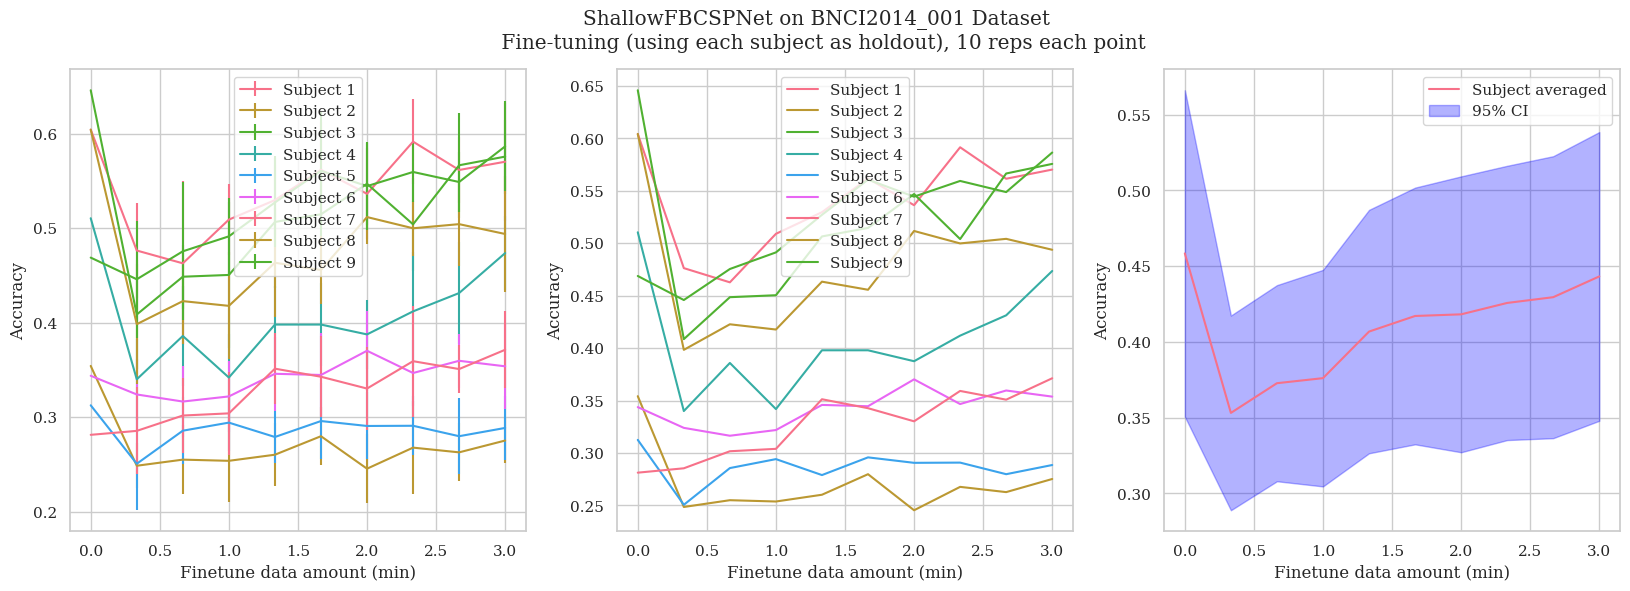

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

for col in df_results.columns:
    y_values = [np.mean(lst) for lst in df_results[col]]
    y_errors = [np.std(lst) for lst in df_results[col]]
    ax1.errorbar(df_results.index * 4 / 60, y_values, yerr=y_errors, label=f'Subject {col}')
    ax2.plot(df_results.index * 4 / 60, y_values, label=f'Subject {col}')

ax1.legend()
ax1.set_xlabel('Finetune data amount (min)')
ax1.set_ylabel('Accuracy')

ax2.legend()
ax2.set_xlabel('Finetune data amount (min)')
ax2.set_ylabel('Accuracy')

df_results_rep_avg = df_results.applymap(lambda x: np.mean(x))
subject_averaged_df = df_results_rep_avg.mean(axis=1)
std_err_df = df_results_rep_avg.sem(axis=1)
conf_interval_df = stats.t.interval(0.95, len(df_results_rep_avg.columns) - 1, loc=subject_averaged_df, scale=std_err_df)

ax3.plot(subject_averaged_df.index * 4 / 60, subject_averaged_df, label='Subject averaged')
ax3.fill_between(subject_averaged_df.index * 4 / 60, conf_interval_df[0], conf_interval_df[1], color='b', alpha=0.3, label='95% CI')

ax3.legend()
ax3.set_xlabel('Finetune data amount (min)')
ax3.set_ylabel('Accuracy')

plt.suptitle('ShallowFBCSPNet on BNCI2014_001 Dataset \n Fine-tuning (using each subject as holdout), 10 reps each point')

plt.savefig(os.path.join(results_dir, f'{file_name}.png'))